In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


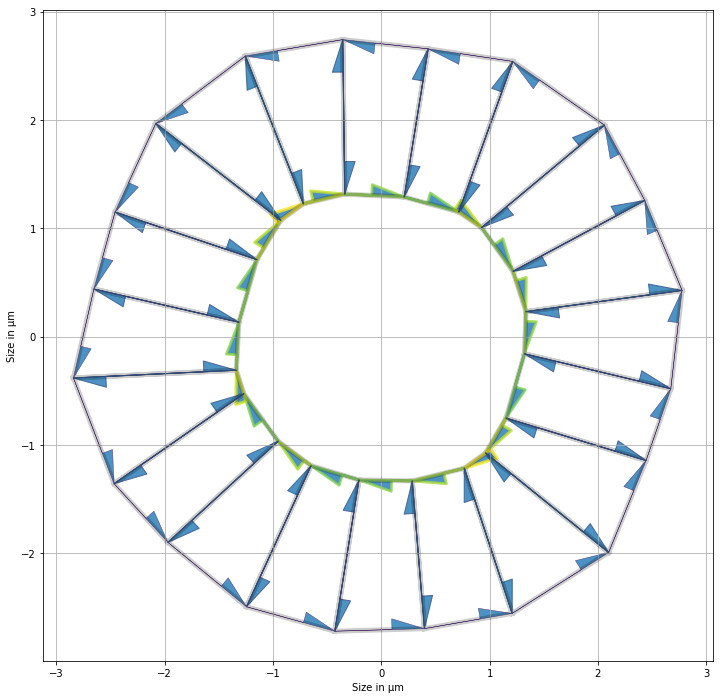

In [3]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

In [5]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [6]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice sans modification

Apical tensions:  [0.00218507 0.00194426 0.00319998 0.00180642 0.00177677 0.0017477
 0.00188348 0.00569949 0.00396838 0.00180909 0.28236276 0.03655472
 0.00159496 0.00150456 0.00593747 0.00166839 0.00159585 0.00207799
 0.00159716 0.00305703] 
Basal tensions:  [5.41298992e-04 9.16086515e-05 9.18015945e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.71809926e-03
 1.55980570e-03 0.00000000e+00 2.67569851e-01 2.98155685e-02
 0.00000000e+00 0.00000000e+00 4.12530530e-03 2.02180567e-04
 0.00000000e+00 5.43522621e-04 0.00000000e+00 1.18752183e-03] 
Lateral tensions:  [0.00188718 0.00136243 0.00176826 0.00177555 0.00106367 0.00105044
 0.00114451 0.00305604 0.00348141 0.00190868 0.13608716 0.15016835
 0.01469458 0.00102794 0.00285546 0.00316347 0.00103437 0.00118303
 0.00125312 0.00158537] 
Area elasticity:  [0.00198355 0.00144574 0.00294254 0.00127432 0.00126968 0.00122999
 0.00135008 0.00661197 0.00384291 0.001236   0.39974471 0.04736251
 0.00117853 0.00109185 0.00721489 0.

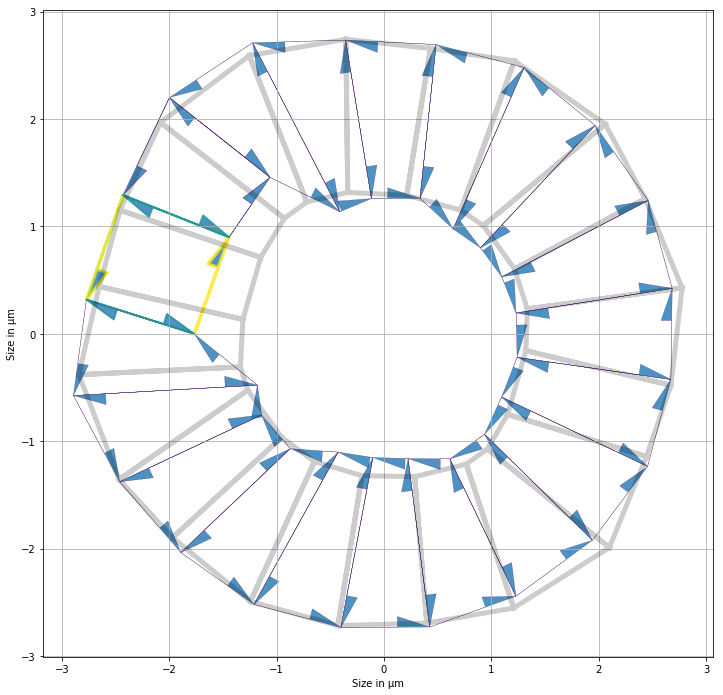

In [7]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
no_mod_mat, residuals = nnls(matrix, constant)
organo3_no_mod_mat = organo3.copy()
organo3_no_mod_mat.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_no_mod_mat,
                                                                     no_mod_mat[:3*organo3.Nf])
organo3_no_mod_mat.face_df.loc[:, 'prefered_area'] = organo3_no_mod_mat.face_df.area + no_mod_mat[3*organo3.Nf:
                                                                                                  4*organo3.Nf]
organo3_no_mod_mat.settings['lumen_prefered_vol'] = organo3_no_mod_mat.settings['lumen_volume'] + no_mod_mat[-1]
Solver.find_energy_min(organo3_no_mod_mat, geom, model)
print_tensions(organo3_no_mod_mat, organo3)
print('Apical tensions: ', no_mod_mat[organo3.apical_edges],
      '\nBasal tensions: ', no_mod_mat[organo3.basal_edges],
      '\nLateral tensions: ', no_mod_mat[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', no_mod_mat[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', no_mod_mat[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-no_mod_mat),
      '\nNNLS residuals: ', residuals)

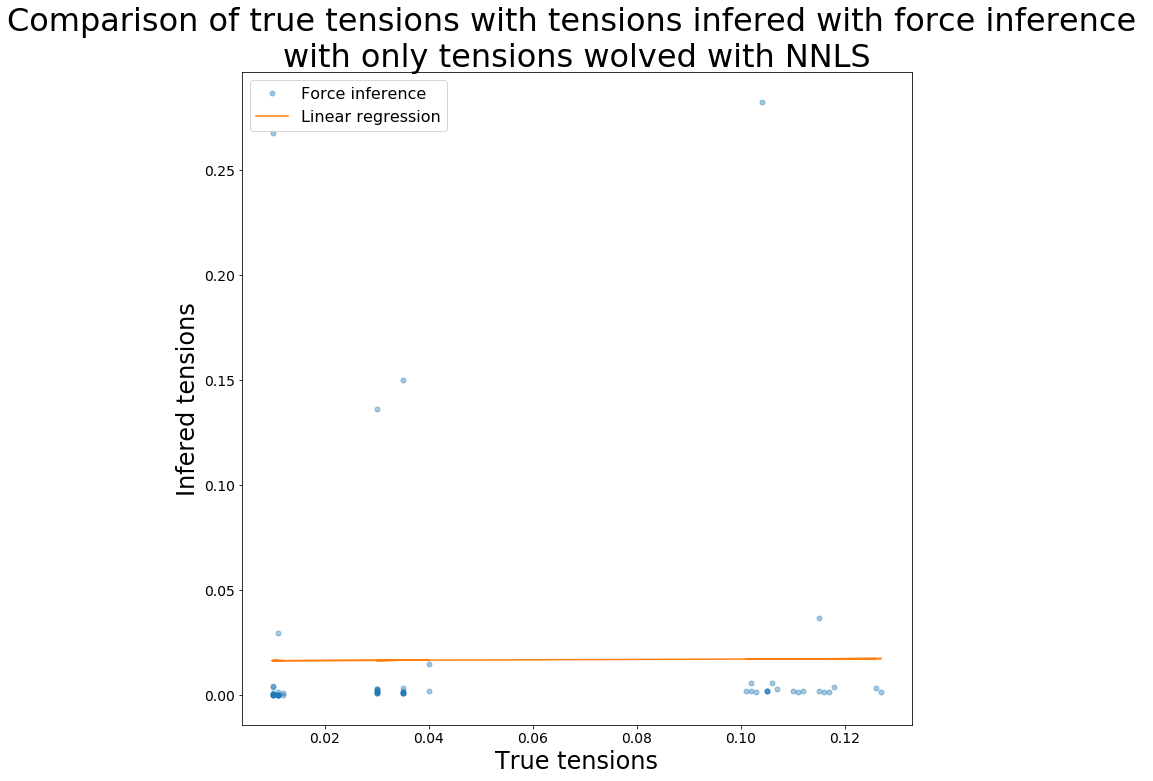

R value : 0.006813302782176759 
Standard error : 0.04719802477077426


In [8]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  no_mod_mat[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

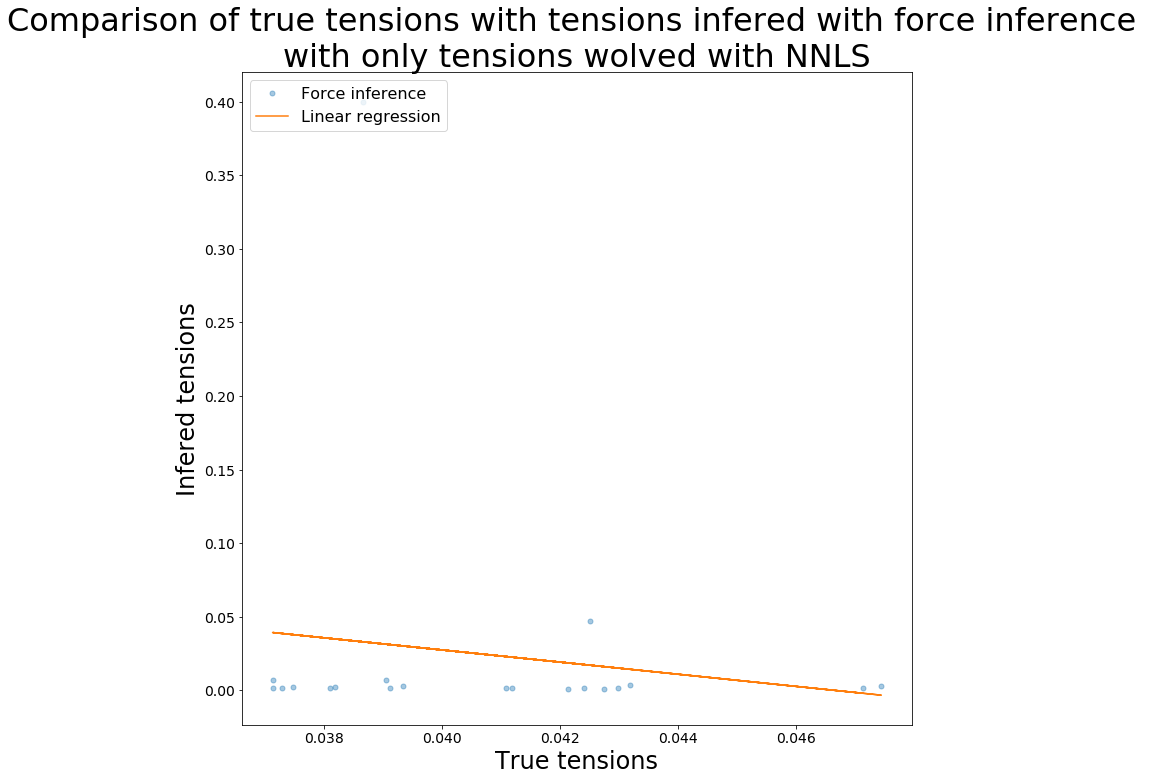

R value : -0.14390062271584955 
Standard error : 0.04288887417656306


In [9]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  no_mod_mat[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en deux contraintes
On supprime la contrainte $$\sum \Lambda_{i,j} = c$$ On ajoute les contraintes $$\Lambda_0 + \Lambda_1 + \Lambda_2 = c_1$$ $$\Lambda_6 + \Lambda_7 + \Lambda_8 = c_3$$ Où $c_3 = c_1*\frac{1-\rho}{\rho}$ et $\rho = \frac{\overline \ell_{api}}{\overline \ell_{api} + \overline \ell_{lat}}$ où $\overline \ell_{api}$ (resp. $\overline \ell_{lat}$) est la longueur moyenne des edges apicaux (resp. latéraux).

Apical tensions:  [0.03748589 0.03938289 0.04116264 0.03816068 0.03758016 0.03705753
 0.03833909 0.03706304 0.04002898 0.0381749  0.03797331 0.03937478
 0.04138994 0.03959071 0.03831789 0.03787235 0.03986228 0.03753584
 0.03847921 0.03842924] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0.00946699 0.01012773 0.0155722  0.01434757 0.00991037 0.0097021
 0.01169903 0.01071456 0.01160224 0.01287964 0.00903927 0.01052922
 0.01498103 0.01505836 0.01086176 0.00871672 0.01198916 0.01227995
 0.01101346 0.01213196] 
Area elasticity:  [0.01296309 0.01448277 0.0157866  0.01359331 0.01283539 0.01221532
 0.01342016 0.01224476 0.01397946 0.01287206 0.01330711 0.014297
 0.01552015 0.01404119 0.01310125 0.01251331 0.01383827 0.01256647
 0.01337702 0.01322197] 
Lumen area elasticity:  0.07191728940729389 
Distance to solution:  0.3644506175944125 
NNLS residuals:  0.005418617332809616 
Distance from th mesh to exp mesh:  5.711718743711233


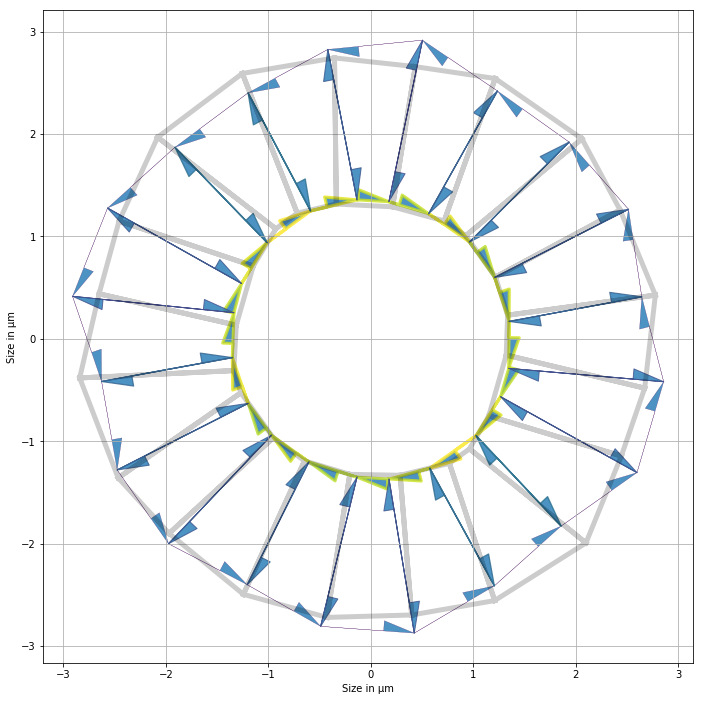

In [10]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
rapport_lenght = (organo3.edge_df.length[organo3.apical_edges].mean() /
                  (organo3.edge_df.length[organo3.apical_edges].mean() +
                   organo3.edge_df.length[organo3.lateral_edges].mean()))
constant[-1] = (organo3.edge_df.line_tension.mean() /
               (organo3.face_df.area_elasticity.mean() *
                organo3.face_df.prefered_area.mean()**1.5))*(1-rapport_lenght) * organo3.apical_edges.shape[0]
constant = np.concatenate((constant, [(organo3.lateral_edges.shape[0]/2 *
                                       rapport_lenght *
                                       organo3.edge_df.line_tension.mean() /
                                       (organo3.face_df.area_elasticity.mean() *
                                        organo3.face_df.prefered_area.mean()**1.5))]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = np.concatenate((np.ones(organo3.Nf),
                             np.zeros(3*organo3.Nf+1)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(2*organo3.Nf), np.ones(organo3.Nf), np.zeros(organo3.Nf+1)))))
mat_2_cst, residuals = nnls(matrix, constant)
organo3_mat_2_cst = organo3.copy()
organo3_mat_2_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_2_cst,
                                                                    mat_2_cst[:3*organo3.Nf])
organo3_mat_2_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_2_cst.face_df.area + mat_2_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_2_cst.settings['lumen_prefered_vol'] = organo3_mat_2_cst.settings['lumen_volume'] + mat_2_cst[-1]
Solver.find_energy_min(organo3_mat_2_cst, geom, model)
print_tensions(organo3_mat_2_cst, organo3)
print('Apical tensions: ', mat_2_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_2_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_2_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_2_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_2_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_2_cst),
      '\nNNLS residuals: ', residuals,
      '\nDistance from th mesh to exp mesh: ', np.sum(np.linalg.norm(_distance(organo3, organo3_mat_2_cst), axis=1)))

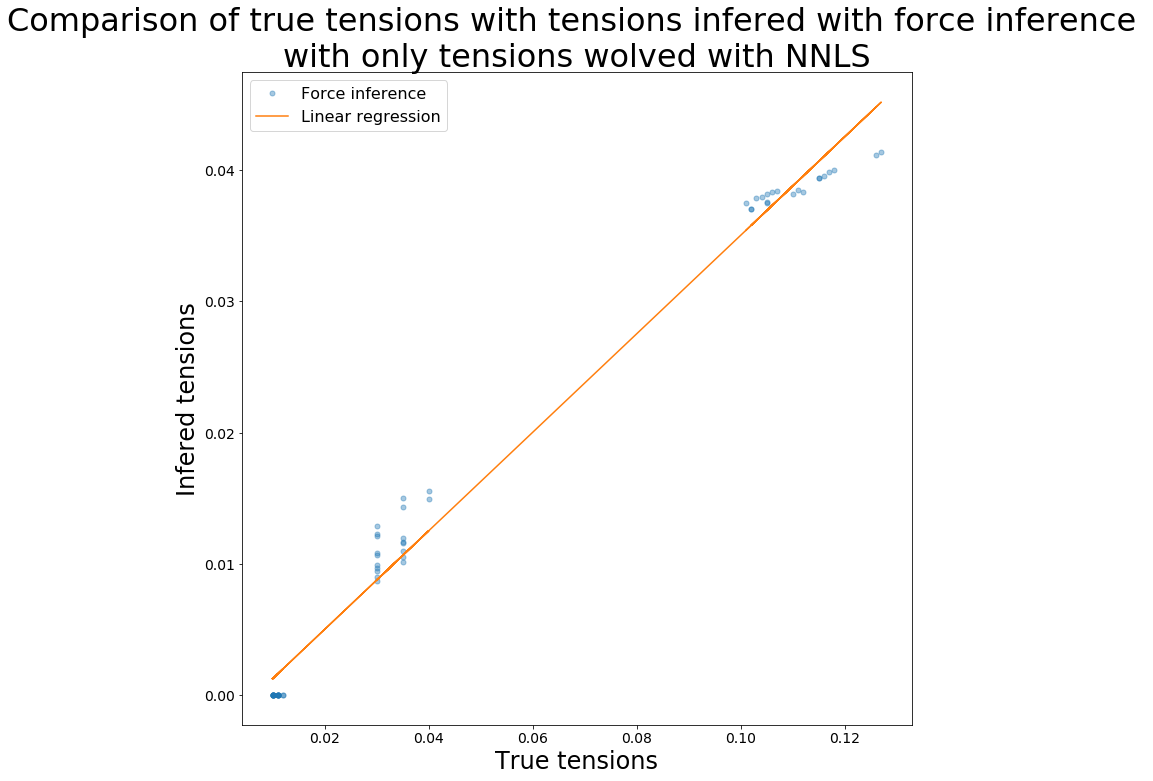

R value : 0.9934448800400587 
Standard error : 0.0016089608602075898


In [11]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_2_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

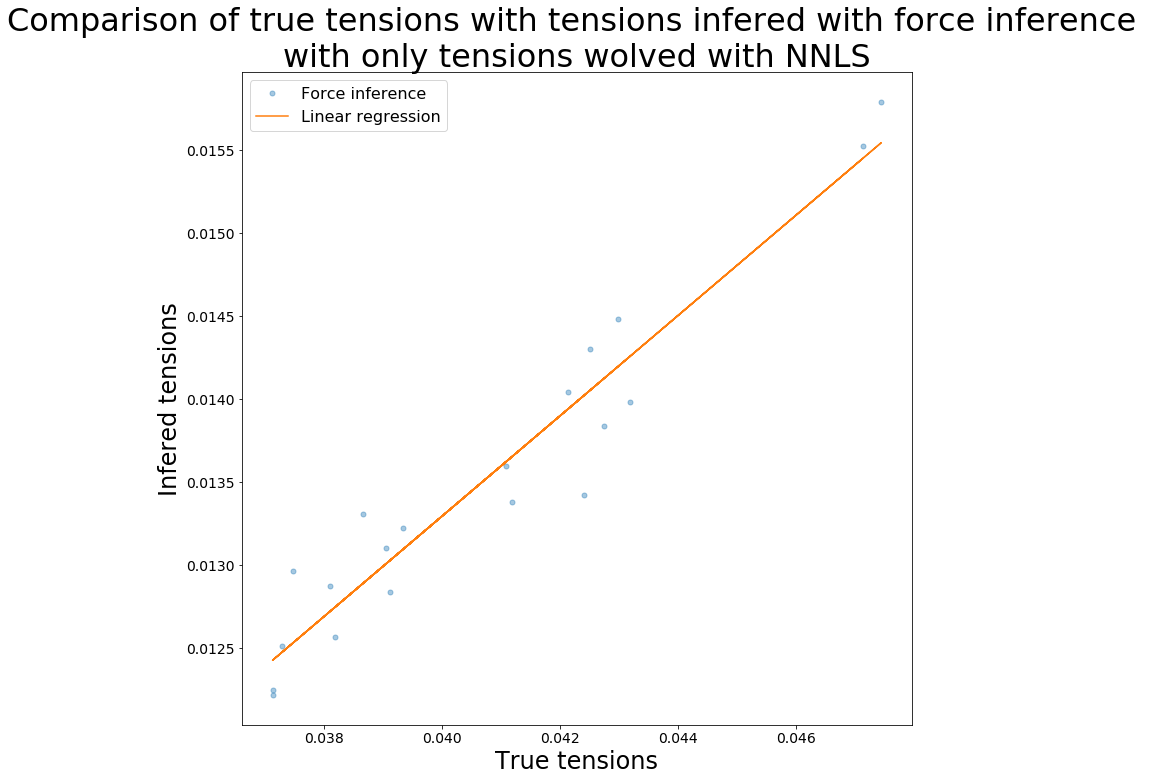

R value : 0.9613455364941056 
Standard error : 0.00013077184546566776


In [12]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_2_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Minimize the distance wrt tensions

In [13]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_2_cst_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_2_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_2_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_2_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

5.625688567930007 [0.13285911 0.21773245 0.14200336 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574682 0.09987797 0.07565828 0.20869502
 0.25743709 0.1698311  0.19157315 0.19381963 0.10748804 0.26458356
 0.11940962 0.12332827 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688594981642 [0.1328591  0.21773245 0.14200335 0.19315548 0.11480529 0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487266 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466708 0.22161578 0.28440674 0.14066475
 0.17656059 0.10675106 0.09574682 0.09987797 0.07565827 0.20869501
 0.25743709 0.1698311  0.19157315 0.19381963 0.10748805 0.26458356
 0.11940962 0.12332827 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688531675481 [0.1328591  0.21773245 0.14200335 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.121354   0.12662481 0.12500657 0.20367196
 0.15876451 0.13031665 0.20487266 0.06351757 0.16512277 0.06715662
 0.00609009 0.06421318 0.19466708 0.22161578 0.28440673 0.14066476
 0.17656058 0.10675107 0.09574682 0.09987797 0.07565828 0.208695
 0.25743709 0.16983109 0.19157315 0.19381963 0.10748805 0.26458356
 0.11940962 0.12332826 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

5.625688683063888 [0.13285911 0.21773245 0.14200336 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367196
 0.15876451 0.13031665 0.20487266 0.06351756 0.16512279 0.06715662
 0.00609009 0.06421318 0.19466708 0.22161578 0.28440673 0.14066476
 0.17656058 0.10675107 0.09574682 0.09987797 0.07565828 0.20869502
 0.25743709 0.16983111 0.19157316 0.19381963 0.10748804 0.26458357
 0.11940962 0.12332828 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.6256867972695765 [0.13285896 0.2177327  0.14200317 0.19315546 0.11480524 0.07755959
 0.0413446  0.02802538 0.12135393 0.12662476 0.12500655 0.20367191
 0.15876447 0.13031661 0.20487262 0.06351756 0.16512272 0.06715657
 0.00609006 0.0642132  0.19466716 0.22161562 0.2844067  0.14066462
 0.17656053 0.10675102 0.09574677 0.09987793 0.07565824 0.20869491
 0.257437   0.16983107 0.19157308 0.19381956 0.10748804 0.26458348
 0.11940956 0.1233282  0.08127716 0.1281001  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

5.625690042493172 [0.13285914 0.21773262 0.1420034  0.19315559 0.11480545 0.07755959
 0.04134472 0.02802508 0.12135373 0.12662494 0.12500666 0.20367212
 0.15876462 0.13031673 0.20487281 0.06351766 0.16512285 0.06715659
 0.00609009 0.06421326 0.19466718 0.2216159  0.28440682 0.14066485
 0.17656067 0.10675112 0.09574666 0.09987769 0.07565815 0.20869489
 0.25743718 0.16983121 0.19157324 0.19381974 0.10748815 0.26458367
 0.11940964 0.12332828 0.08127719 0.12810015 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625689396222947 [0.13285911 0.21773252 0.14200335 0.1931555  0.11480536 0.07755961
 0.04134461 0.02802539 0.12135397 0.12662481 0.12500666 0.20367195
 0.15876461 0.13031652 0.204873   0.06351756 0.16512282 0.06715658
 0.00609009 0.06421322 0.19466711 0.22161582 0.28440673 0.14066478
 0.17656061 0.10675109 0.0957468  0.09987796 0.07565828 0.20869498
 0.25743709 0.16983114 0.19157303 0.19381977 0.10748806 0.26458373
 0.11940961 0.12332826 0.08127718 0.12810013 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688497404757 [0.13285934 0.21773239 0.14200335 0.19315546 0.11480533 0.07755959
 0.0413446  0.02802539 0.12135397 0.12662478 0.12500659 0.20367196
 0.15876451 0.13031665 0.20487267 0.06351759 0.16512274 0.06715664
 0.00609007 0.06421294 0.19466701 0.22161591 0.28440669 0.14066476
 0.17656058 0.10675106 0.09574679 0.09987795 0.07565827 0.20869496
 0.25743706 0.16983112 0.19157313 0.19381962 0.10748806 0.26458354
 0.11940961 0.12332824 0.08127732 0.12810022 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688552694872 [0.13285911 0.21773245 0.14200335 0.19315547 0.11480529 0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574681 0.09987797 0.07565828 0.20869501
 0.25743709 0.1698311  0.19157315 0.19381963 0.10748804 0.26458356
 0.11940962 0.12332827 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688491479481 [0.1328591  0.21773244 0.14200335 0.19315546 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500657 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574682 0.09987797 0.07565827 0.20869501
 0.25743709 0.16983109 0.19157315 0.19381962 0.10748804 0.26458356
 0.11940962 0.12332826 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688580202977 [0.13285911 0.21773245 0.14200336 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512278 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574682 0.09987797 0.07565828 0.20869502
 0.25743708 0.1698311  0.19157315 0.19381963 0.10748804 0.26458356
 0.11940962 0.12332828 0.08127721 0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688567930007 [0.13285911 0.21773245 0.14200336 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574682 0.09987797 0.07565828 0.20869502
 0.25743709 0.1698311  0.19157315 0.19381963 0.10748804 0.26458356
 0.11940962 0.12332827 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688567930007 [0.13285911 0.21773245 0.14200336 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574682 0.09987797 0.07565828 0.20869502
 0.25743709 0.1698311  0.19157315 0.19381963 0.10748804 0.26458356
 0.11940962 0.12332827 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688567930007 [0.13285911 0.21773245 0.14200336 0.19315547 0.1148053  0.07755961
 0.04134458 0.02802543 0.12135401 0.1266248  0.12500658 0.20367195
 0.15876451 0.13031665 0.20487265 0.06351757 0.16512277 0.06715663
 0.00609009 0.06421317 0.19466707 0.22161578 0.28440673 0.14066475
 0.17656058 0.10675106 0.09574682 0.09987797 0.07565828 0.20869502
 0.25743709 0.1698311  0.19157315 0.19381963 0.10748804 0.26458356
 0.11940962 0.12332827 0.0812772  0.12810016 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625691245253588 [0.13285922 0.21773246 0.14200344 0.19315554 0.11480526 0.07755966
 0.04134454 0.02802556 0.12135418 0.12662486 0.12500657 0.20367196
 0.15876454 0.13031668 0.20487265 0.06351756 0.16512283 0.06715677
 0.00609013 0.06421314 0.19466715 0.22161587 0.28440694 0.14066481
 0.17656065 0.10675109 0.0957469  0.09987807 0.07565833 0.20869521
 0.25743722 0.16983111 0.19157325 0.1938197  0.10748801 0.2645837
 0.11940972 0.12332838 0.0812773  0.1281003  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.625682841707389 [0.13285909 0.217732   0.14200325 0.1931552  0.11480492 0.07755959
 0.04134439 0.02802565 0.12135413 0.12662469 0.1250063  0.20367157
 0.15876425 0.13031646 0.20487225 0.06351738 0.16512259 0.06715679
 0.00609009 0.06421294 0.19466685 0.22161551 0.28440656 0.14066451
 0.17656037 0.10675091 0.09574681 0.09987801 0.07565822 0.20869502
 0.25743688 0.16983081 0.19157298 0.19381938 0.10748778 0.26458335
 0.1194096  0.12332825 0.08127727 0.12810024 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.625688217324838 [0.13285914 0.21773227 0.14200337 0.1931554  0.11480513 0.07755961
 0.0413445  0.0280256  0.12135418 0.12662481 0.12500644 0.20367182
 0.15876443 0.13031659 0.20487251 0.06351747 0.16512274 0.06715679
 0.00609008 0.06421303 0.19466702 0.22161571 0.28440682 0.14066469
 0.17656056 0.10675103 0.09574688 0.09987806 0.07565829 0.20869518
 0.25743711 0.16983099 0.19157317 0.1938196  0.10748792 0.2645836
 0.1194097  0.12332836 0.08127732 0.1281003  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.625688685633689 [0.13285916 0.21773234 0.14200338 0.19315544 0.11480518 0.07755962
 0.04134452 0.02802557 0.12135415 0.12662482 0.12500649 0.20367186
 0.15876446 0.13031661 0.20487255 0.06351748 0.16512276 0.06715675
 0.0060901  0.06421308 0.19466707 0.22161576 0.28440682 0.14066472
 0.17656056 0.10675104 0.09574687 0.09987804 0.07565829 0.20869515
 0.25743712 0.16983103 0.19157317 0.19381961 0.10748793 0.26458359
 0.11940968 0.12332835 0.08127728 0.12810027 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5919015117410407 [3.31694082e-03 1.78025900e-02 2.86322506e-02 3.42120535e-02
 1.95725243e-02 1.70092651e-02 5.03219953e-03 9.14475038e-03
 2.23108358e-02 1.56153875e-02 7.56903412e-03 1.68553352e-02
 2.49847938e-02 3.30649749e-02 1.25252621e-02 6.73241826e-03
 1.16446518e-02 2.37640602e-02 1.97569464e-02 9.68392593e-03
 5.36000656e-03 8.37945332e-03 1.86552555e-02 1.59515359e-02
 8.59379953e-03 3.88096407e-03 2.27588512e-02 7.49331695e-03
 1.31414010e-02 1.38062788e-02 1.18098854e-02 9.91985961e-03
 9.29386995e-03 6.79826542e-03 6.94097834e-03 8.90473499e-03
 1.57727461e-02 1.44562432e-02 3.50790342e-02 1.52573718e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015047566933 [3.31694076e-03 1.78025904e-02 2.86322514e-02 3.42120552e-02
 1.95725247e-02 1.70092655e-02 5.03219725e-03 9.14475172e-03
 2.23108356e-02 1.56153874e-02 7.56903382e-03 1.68553348e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241816e-03
 1.16446517e-02 2.37640599e-02 1.97569462e-02 9.68392563e-03
 5.36000650e-03 8.37945266e-03 1.86552522e-02 1.59515385e-02
 8.59379826e-03 3.88096497e-03 2.27588488e-02 7.49331643e-03
 1.31414016e-02 1.38062782e-02 1.18098853e-02 9.91985942e-03
 9.29386979e-03 6.79826531e-03 6.94097822e-03 8.90473482e-03
 1.57727458e-02 1.44562429e-02 3.50790335e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015157929877 [3.31694076e-03 1.78025904e-02 2.86322514e-02 3.42120551e-02
 1.95725245e-02 1.70092650e-02 5.03219926e-03 9.14475003e-03
 2.23108355e-02 1.56153871e-02 7.56903749e-03 1.68553384e-02
 2.49847934e-02 3.30649745e-02 1.25252620e-02 6.73241813e-03
 1.16446517e-02 2.37640599e-02 1.97569462e-02 9.68392562e-03
 5.36000651e-03 8.37945266e-03 1.86552523e-02 1.59515386e-02
 8.59379810e-03 3.88096385e-03 2.27588509e-02 7.49331674e-03
 1.31414010e-02 1.38062782e-02 1.18098877e-02 9.91986153e-03
 9.29386948e-03 6.79826546e-03 6.94097829e-03 8.90473485e-03
 1.57727458e-02 1.44562429e-02 3.50790335e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919014980430212 [3.31694064e-03 1.78025903e-02 2.86322512e-02 3.42120549e-02
 1.95725244e-02 1.70092649e-02 5.03219920e-03 9.14474993e-03
 2.23108354e-02 1.56153873e-02 7.56903382e-03 1.68553346e-02
 2.49847933e-02 3.30649741e-02 1.25252636e-02 6.73241441e-03
 1.16446517e-02 2.37640597e-02 1.97569461e-02 9.68392549e-03
 5.36000647e-03 8.37945259e-03 1.86552521e-02 1.59515385e-02
 8.59379802e-03 3.88096379e-03 2.27588507e-02 7.49331678e-03
 1.31414007e-02 1.38062784e-02 1.18098851e-02 9.91985944e-03
 9.29386941e-03 6.79826462e-03 6.94098066e-03 8.90473367e-03
 1.57727448e-02 1.44562431e-02 3.50790332e-02 1.52573715e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919014952908273 [3.31694085e-03 1.78025906e-02 2.86322513e-02 3.42120550e-02
 1.95725244e-02 1.70092650e-02 5.03219925e-03 9.14475000e-03
 2.23108355e-02 1.56153873e-02 7.56903385e-03 1.68553347e-02
 2.49847934e-02 3.30649744e-02 1.25252620e-02 6.73241821e-03
 1.16446517e-02 2.37640599e-02 1.97569427e-02 9.68392266e-03
 5.36000756e-03 8.37945232e-03 1.86552522e-02 1.59515386e-02
 8.59379807e-03 3.88096381e-03 2.27588508e-02 7.49331680e-03
 1.31414007e-02 1.38062785e-02 1.18098852e-02 9.91985939e-03
 9.29386974e-03 6.79826527e-03 6.94097817e-03 8.90473485e-03
 1.57727456e-02 1.44562428e-02 3.50790304e-02 1.52573725e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015068842417 [3.31694092e-03 1.78025905e-02 2.86322513e-02 3.42120551e-02
 1.95725245e-02 1.70092650e-02 5.03219941e-03 9.14475026e-03
 2.23108355e-02 1.56153873e-02 7.56903402e-03 1.68553349e-02
 2.49847935e-02 3.30649745e-02 1.25252619e-02 6.73241817e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392571e-03
 5.36000656e-03 8.37945269e-03 1.86552519e-02 1.59515391e-02
 8.59379820e-03 3.88096391e-03 2.27588510e-02 7.49331683e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985950e-03
 9.29386981e-03 6.79826533e-03 6.94097825e-03 8.90473492e-03
 1.57727459e-02 1.44562430e-02 3.50790337e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015083654394 [3.31694095e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219960e-03 9.14475029e-03
 2.23108356e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379820e-03 3.88096392e-03 2.27588513e-02 7.49331698e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386982e-03 6.79826534e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015071886478 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219941e-03 9.14475027e-03
 2.23108355e-02 1.56153873e-02 7.56903397e-03 1.68553349e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098852e-02 9.91985943e-03
 9.29386982e-03 6.79826533e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015073431366 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219941e-03 9.14475027e-03
 2.23108355e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252618e-02 6.73241833e-03
 1.16446517e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386981e-03 6.79826532e-03 6.94097807e-03 8.90473491e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919019070084315 [3.31694071e-03 1.78025978e-02 2.86322598e-02 3.42120648e-02
 1.95725291e-02 1.70092699e-02 5.03220232e-03 9.14475540e-03
 2.23108411e-02 1.56153911e-02 7.56903765e-03 1.68553412e-02
 2.49848003e-02 3.30649841e-02 1.25252651e-02 6.73242150e-03
 1.16446546e-02 2.37640767e-02 1.97570073e-02 9.68400930e-03
 5.36001091e-03 8.37945375e-03 1.86552589e-02 1.59515442e-02
 8.59380087e-03 3.88096541e-03 2.27588584e-02 7.49331956e-03
 1.31414051e-02 1.38062835e-02 1.18098892e-02 9.91986286e-03
 9.29387291e-03 6.79826747e-03 6.94098011e-03 8.90473921e-03
 1.57727480e-02 1.44562438e-02 3.50791303e-02 1.52573635e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.591901503123941 [3.31694119e-03 1.78025913e-02 2.86322538e-02 3.42120557e-02
 1.95725244e-02 1.70092650e-02 5.03219936e-03 9.14475023e-03
 2.23108353e-02 1.56153872e-02 7.56903398e-03 1.68553348e-02
 2.49847933e-02 3.30649742e-02 1.25252618e-02 6.73241811e-03
 1.16446515e-02 2.37640596e-02 1.97569460e-02 9.68392550e-03
 5.36000659e-03 8.37945186e-03 1.86552506e-02 1.59515375e-02
 8.59379769e-03 3.88096384e-03 2.27588509e-02 7.49331674e-03
 1.31414008e-02 1.38062785e-02 1.18098852e-02 9.91985944e-03
 9.29386971e-03 6.79826526e-03 6.94097821e-03 8.90473490e-03
 1.57727457e-02 1.44562429e-02 3.50790334e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.5919014987570288 [3.31694099e-03 1.78025904e-02 2.86322512e-02 3.42120549e-02
 1.95725240e-02 1.70092641e-02 5.03219809e-03 9.14475000e-03
 2.23108352e-02 1.56153871e-02 7.56903407e-03 1.68553349e-02
 2.49847933e-02 3.30649743e-02 1.25252619e-02 6.73241814e-03
 1.16446515e-02 2.37640597e-02 1.97569461e-02 9.68392568e-03
 5.36000656e-03 8.37945262e-03 1.86552523e-02 1.59515387e-02
 8.59379794e-03 3.88096235e-03 2.27588497e-02 7.49331753e-03
 1.31414005e-02 1.38062787e-02 1.18098852e-02 9.91985948e-03
 9.29386975e-03 6.79826529e-03 6.94097823e-03 8.90473493e-03
 1.57727458e-02 1.44562430e-02 3.50790336e-02 1.52573716e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015087502533 [3.31694114e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725244e-02 1.70092650e-02 5.03219959e-03 9.14475057e-03
 2.23108355e-02 1.56153876e-02 7.56903312e-03 1.68553342e-02
 2.49847933e-02 3.30649745e-02 1.25252619e-02 6.73241820e-03
 1.16446515e-02 2.37640599e-02 1.97569462e-02 9.68392580e-03
 5.36000662e-03 8.37945270e-03 1.86552524e-02 1.59515388e-02
 8.59379829e-03 3.88096397e-03 2.27588511e-02 7.49331700e-03
 1.31414006e-02 1.38062791e-02 1.18098864e-02 9.91985982e-03
 9.29386991e-03 6.79826524e-03 6.94097824e-03 8.90473502e-03
 1.57727459e-02 1.44562431e-02 3.50790339e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015149439623 [3.31694117e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725244e-02 1.70092651e-02 5.03219955e-03 9.14475052e-03
 2.23108355e-02 1.56153873e-02 7.56903415e-03 1.68553353e-02
 2.49847936e-02 3.30649748e-02 1.25252641e-02 6.73241917e-03
 1.16446513e-02 2.37640599e-02 1.97569461e-02 9.68392584e-03
 5.36000662e-03 8.37945272e-03 1.86552525e-02 1.59515388e-02
 8.59379830e-03 3.88096400e-03 2.27588511e-02 7.49331684e-03
 1.31414010e-02 1.38062787e-02 1.18098854e-02 9.91985943e-03
 9.29387037e-03 6.79826644e-03 6.94097935e-03 8.90473368e-03
 1.57727465e-02 1.44562429e-02 3.50790340e-02 1.52573718e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.59190151307321 [3.31694125e-03 1.78025903e-02 2.86322513e-02 3.42120551e-02
 1.95725244e-02 1.70092650e-02 5.03219951e-03 9.14475045e-03
 2.23108355e-02 1.56153873e-02 7.56903412e-03 1.68553351e-02
 2.49847934e-02 3.30649745e-02 1.25252618e-02 6.73241803e-03
 1.16446516e-02 2.37640594e-02 1.97569480e-02 9.68392674e-03
 5.36000604e-03 8.37945285e-03 1.86552524e-02 1.59515387e-02
 8.59379827e-03 3.88096398e-03 2.27588510e-02 7.49331681e-03
 1.31414010e-02 1.38062786e-02 1.18098853e-02 9.91985955e-03
 9.29386982e-03 6.79826535e-03 6.94097832e-03 8.90473487e-03
 1.57727462e-02 1.44562433e-02 3.50790353e-02 1.52573731e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.5919015074945094 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219942e-03 9.14475028e-03
 2.23108355e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386982e-03 6.79826533e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015074945094 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219942e-03 9.14475028e-03
 2.23108355e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386982e-03 6.79826533e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015074945094 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219942e-03 9.14475028e-03
 2.23108355e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386982e-03 6.79826533e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015074945094 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219942e-03 9.14475028e-03
 2.23108355e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386982e-03 6.79826533e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015074945094 [3.31694094e-03 1.78025905e-02 2.86322514e-02 3.42120552e-02
 1.95725245e-02 1.70092651e-02 5.03219942e-03 9.14475028e-03
 2.23108355e-02 1.56153873e-02 7.56903403e-03 1.68553350e-02
 2.49847935e-02 3.30649745e-02 1.25252620e-02 6.73241818e-03
 1.16446516e-02 2.37640599e-02 1.97569462e-02 9.68392572e-03
 5.36000656e-03 8.37945269e-03 1.86552524e-02 1.59515387e-02
 8.59379819e-03 3.88096391e-03 2.27588510e-02 7.49331684e-03
 1.31414009e-02 1.38062786e-02 1.18098853e-02 9.91985951e-03
 9.29386982e-03 6.79826533e-03 6.94097826e-03 8.90473493e-03
 1.57727459e-02 1.44562430e-02 3.50790338e-02 1.52573717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015461559742 [3.31694209e-03 1.78025925e-02 2.86322504e-02 3.42120559e-02
 1.95725258e-02 1.70092666e-02 5.03220012e-03 9.14475129e-03
 2.23108362e-02 1.56153879e-02 7.56903481e-03 1.68553364e-02
 2.49847946e-02 3.30649758e-02 1.25252626e-02 6.73241875e-03
 1.16446521e-02 2.37640611e-02 1.97569476e-02 9.68392639e-03
 5.36000733e-03 8.37945175e-03 1.86552584e-02 1.59515370e-02
 8.59379754e-03 3.88096406e-03 2.27588534e-02 7.49331731e-03
 1.31414021e-02 1.38062798e-02 1.18098863e-02 9.91986022e-03
 9.29387090e-03 6.79826596e-03 6.94097862e-03 8.90473578e-03
 1.57727473e-02 1.44562443e-02 3.50790367e-02 1.52573730e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015250847994 [3.31694094e-03 1.78025909e-02 2.86322520e-02 3.42120558e-02
 1.95725244e-02 1.70092644e-02 5.03220400e-03 9.14475185e-03
 2.23108352e-02 1.56153875e-02 7.56903431e-03 1.68553351e-02
 2.49847941e-02 3.30649751e-02 1.25252624e-02 6.73241832e-03
 1.16446520e-02 2.37640604e-02 1.97569467e-02 9.68392591e-03
 5.36000668e-03 8.37945291e-03 1.86552531e-02 1.59515394e-02
 8.59379798e-03 3.88096231e-03 2.27588512e-02 7.49331962e-03
 1.31414003e-02 1.38062801e-02 1.18098852e-02 9.91985989e-03
 9.29387024e-03 6.79826553e-03 6.94097832e-03 8.90473501e-03
 1.57727465e-02 1.44562434e-02 3.50790347e-02 1.52573721e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.591901503051687 [3.31694053e-03 1.78025905e-02 2.86322514e-02 3.42120556e-02
 1.95725249e-02 1.70092655e-02 5.03219962e-03 9.14474982e-03
 2.23108355e-02 1.56153872e-02 7.56903112e-03 1.68553313e-02
 2.49847927e-02 3.30649743e-02 1.25252625e-02 6.73241850e-03
 1.16446521e-02 2.37640601e-02 1.97569465e-02 9.68392559e-03
 5.36000636e-03 8.37945276e-03 1.86552527e-02 1.59515387e-02
 8.59379812e-03 3.88096370e-03 2.27588511e-02 7.49331744e-03
 1.31414000e-02 1.38062789e-02 1.18098866e-02 9.91986000e-03
 9.29387003e-03 6.79826455e-03 6.94097793e-03 8.90473463e-03
 1.57727464e-02 1.44562429e-02 3.50790339e-02 1.52573720e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.5919015316903107 [3.31694113e-03 1.78025912e-02 2.86322517e-02 3.42120566e-02
 1.95725255e-02 1.70092661e-02 5.03220006e-03 9.14475027e-03
 2.23108354e-02 1.56153877e-02 7.56903410e-03 1.68553356e-02
 2.49847940e-02 3.30649738e-02 1.25252582e-02 6.73242240e-03
 1.16446511e-02 2.37640607e-02 1.97569471e-02 9.68392660e-03
 5.36000680e-03 8.37945307e-03 1.86552539e-02 1.59515394e-02
 8.59379868e-03 3.88096395e-03 2.27588526e-02 7.49331739e-03
 1.31414016e-02 1.38062797e-02 1.18098858e-02 9.91985946e-03
 9.29387208e-03 6.79826713e-03 6.94098029e-03 8.90473118e-03
 1.57727486e-02 1.44562425e-02 3.50790360e-02 1.52573727e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5919015252829024 [3.31694129e-03 1.78025901e-02 2.86322518e-02 3.42120560e-02
 1.95725250e-02 1.70092656e-02 5.03219957e-03 9.14475029e-03
 2.23108358e-02 1.56153878e-02 7.56903419e-03 1.68553352e-02
 2.49847940e-02 3.30649750e-02 1.25252621e-02 6.73241818e-03
 1.16446521e-02 2.37640595e-02 1.97569485e-02 9.68393017e-03
 5.36000474e-03 8.37945368e-03 1.86552528e-02 1.59515389e-02
 8.59379829e-03 3.88096384e-03 2.27588517e-02 7.49331719e-03
 1.31414011e-02 1.38062791e-02 1.18098854e-02 9.91985959e-03
 9.29387033e-03 6.79826550e-03 6.94097860e-03 8.90473473e-03
 1.57727469e-02 1.44562441e-02 3.50790305e-02 1.52573766e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596731985425 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918830e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596595723958 [3.58212177e-03 9.07903892e-03 1.69882036e-02 1.34899568e-02
 6.03929215e-03 1.49507763e-02 2.07589960e-02 3.07241989e-03
 1.54572433e-02 1.72169419e-02 7.94268412e-03 8.29364325e-03
 1.60577187e-02 1.96026871e-02 4.43704557e-03 3.39108122e-03
 1.15645553e-02 1.99774534e-02 1.65814317e-02 1.46256574e-02
 1.64061658e-03 8.90470698e-03 1.20591191e-02 9.83919015e-03
 1.89541363e-02 9.83364302e-03 1.64337753e-02 9.56140281e-03
 8.57760827e-03 1.10660875e-02 1.20312012e-02 6.48100270e-03
 6.44648304e-03 5.36748556e-03 4.37731161e-03 3.85102858e-03
 1.25531884e-02 2.36045536e-03 1.09407720e-02 7.91145311e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.422659680414483 [3.58212165e-03 9.07903878e-03 1.69882044e-02 1.34899576e-02
 6.03929504e-03 1.49507764e-02 2.07589962e-02 3.07242158e-03
 1.54572434e-02 1.72169420e-02 7.94268396e-03 8.29364419e-03
 1.60577191e-02 1.96026877e-02 4.43704540e-03 3.39108200e-03
 1.15645555e-02 1.99774540e-02 1.65814320e-02 1.46256577e-02
 1.64061662e-03 8.90470728e-03 1.20591204e-02 9.83918841e-03
 1.89541394e-02 9.83364282e-03 1.64337771e-02 9.56140184e-03
 8.57761107e-03 1.10660875e-02 1.20312022e-02 6.48100295e-03
 6.44648320e-03 5.36748576e-03 4.37731190e-03 3.85102890e-03
 1.25531890e-02 2.36045561e-03 1.09407727e-02 7.91145348e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4226596793134826 [3.58212166e-03 9.07903880e-03 1.69882044e-02 1.34899576e-02
 6.03929497e-03 1.49507764e-02 2.07589965e-02 3.07241983e-03
 1.54572436e-02 1.72169426e-02 7.94268445e-03 8.29364460e-03
 1.60577192e-02 1.96026873e-02 4.43704536e-03 3.39108192e-03
 1.15645555e-02 1.99774540e-02 1.65814320e-02 1.46256577e-02
 1.64061662e-03 8.90470725e-03 1.20591204e-02 9.83918844e-03
 1.89541394e-02 9.83364282e-03 1.64337762e-02 9.56140335e-03
 8.57760876e-03 1.10660876e-02 1.20312028e-02 6.48100063e-03
 6.44648531e-03 5.36748572e-03 4.37731213e-03 3.85102898e-03
 1.25531890e-02 2.36045559e-03 1.09407727e-02 7.91145348e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42265968021816613 [3.58212164e-03 9.07903878e-03 1.69882044e-02 1.34899576e-02
 6.03929497e-03 1.49507764e-02 2.07589965e-02 3.07241978e-03
 1.54572436e-02 1.72169425e-02 7.94268398e-03 8.29364424e-03
 1.60577191e-02 1.96026878e-02 4.43704578e-03 3.39108229e-03
 1.15645554e-02 1.99774541e-02 1.65814321e-02 1.46256577e-02
 1.64061659e-03 8.90470731e-03 1.20591204e-02 9.83918846e-03
 1.89541395e-02 9.83364290e-03 1.64337763e-02 9.56140335e-03
 8.57760871e-03 1.10660879e-02 1.20312021e-02 6.48100305e-03
 6.44648320e-03 5.36748553e-03 4.37731180e-03 3.85103025e-03
 1.25531880e-02 2.36045640e-03 1.09407729e-02 7.91145339e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4226596706873492 [3.58211860e-03 9.07903900e-03 1.69882043e-02 1.34899575e-02
 6.03929496e-03 1.49507763e-02 2.07589963e-02 3.07241985e-03
 1.54572435e-02 1.72169423e-02 7.94268407e-03 8.29364382e-03
 1.60577189e-02 1.96026875e-02 4.43704549e-03 3.39108165e-03
 1.15645555e-02 1.99774538e-02 1.65814318e-02 1.46256571e-02
 1.64061923e-03 8.90470715e-03 1.20591200e-02 9.83918826e-03
 1.89541391e-02 9.83364259e-03 1.64337759e-02 9.56140319e-03
 8.57760854e-03 1.10660878e-02 1.20312017e-02 6.48100290e-03
 6.44648319e-03 5.36748569e-03 4.37731177e-03 3.85102876e-03
 1.25531886e-02 2.36045573e-03 1.09407733e-02 7.91145155e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42265967337578914 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929499e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364401e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918820e-03
 1.89541393e-02 9.83364268e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42265967319996367 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241976e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108185e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918831e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140325e-03
 8.57760856e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4226596735844239 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572435e-02 1.72169423e-02 7.94268402e-03 8.29364411e-03
 1.60577188e-02 1.96026875e-02 4.43704542e-03 3.39108185e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470714e-03 1.20591203e-02 9.83918831e-03
 1.89541392e-02 9.83364268e-03 1.64337760e-02 9.56140323e-03
 8.57760860e-03 1.10660878e-02 1.20312019e-02 6.48100316e-03
 6.44648302e-03 5.36748572e-03 4.37731182e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42265967337561156 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364403e-03
 1.60577189e-02 1.96026875e-02 4.43704543e-03 3.39108188e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918831e-03
 1.89541392e-02 9.83364268e-03 1.64337760e-02 9.56140323e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102874e-03
 1.25531889e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42265967324743087 [3.58212167e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061655e-03 8.90470713e-03 1.20591203e-02 9.83918831e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145342e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42265967252199027 [3.58212147e-03 9.07903861e-03 1.69882046e-02 1.34899598e-02
 6.03929541e-03 1.49507759e-02 2.07589961e-02 3.07241975e-03
 1.54572433e-02 1.72169422e-02 7.94268391e-03 8.29364410e-03
 1.60577188e-02 1.96026874e-02 4.43704536e-03 3.39108193e-03
 1.15645553e-02 1.99774537e-02 1.65814318e-02 1.46256574e-02
 1.64061652e-03 8.90470671e-03 1.20591214e-02 9.83918644e-03
 1.89541386e-02 9.83364224e-03 1.64337760e-02 9.56140325e-03
 8.57760859e-03 1.10660877e-02 1.20312019e-02 6.48100291e-03
 6.44648313e-03 5.36748568e-03 4.37731182e-03 3.85102885e-03
 1.25531888e-02 2.36045558e-03 1.09407725e-02 7.91145334e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42265967212518923 [3.58212159e-03 9.07903864e-03 1.69882042e-02 1.34899573e-02
 6.03929471e-03 1.49507761e-02 2.07589965e-02 3.07242131e-03
 1.54572432e-02 1.72169423e-02 7.94268392e-03 8.29364420e-03
 1.60577188e-02 1.96026875e-02 4.43704534e-03 3.39108200e-03
 1.15645553e-02 1.99774538e-02 1.65814318e-02 1.46256575e-02
 1.64061659e-03 8.90470717e-03 1.20591203e-02 9.83918834e-03
 1.89541394e-02 9.83364279e-03 1.64337748e-02 9.56140139e-03
 8.57760938e-03 1.10660880e-02 1.20312018e-02 6.48100297e-03
 6.44648317e-03 5.36748569e-03 4.37731183e-03 3.85102887e-03
 1.25531888e-02 2.36045559e-03 1.09407726e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42265966701451285 [3.58212159e-03 9.07903866e-03 1.69882041e-02 1.34899573e-02
 6.03929483e-03 1.49507761e-02 2.07589961e-02 3.07241967e-03
 1.54572433e-02 1.72169419e-02 7.94268319e-03 8.29364178e-03
 1.60577186e-02 1.96026874e-02 4.43704539e-03 3.39108192e-03
 1.15645553e-02 1.99774537e-02 1.65814317e-02 1.46256574e-02
 1.64061658e-03 8.90470711e-03 1.20591202e-02 9.83918822e-03
 1.89541391e-02 9.83364264e-03 1.64337759e-02 9.56140316e-03
 8.57760844e-03 1.10660882e-02 1.20312007e-02 6.48100248e-03
 6.44648452e-03 5.36748563e-03 4.37731167e-03 3.85102878e-03
 1.25531887e-02 2.36045555e-03 1.09407725e-02 7.91145333e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4226596719098197 [3.58212159e-03 9.07903863e-03 1.69882042e-02 1.34899574e-02
 6.03929483e-03 1.49507762e-02 2.07589962e-02 3.07241970e-03
 1.54572434e-02 1.72169422e-02 7.94268389e-03 8.29364424e-03
 1.60577189e-02 1.96026873e-02 4.43704462e-03 3.39107973e-03
 1.15645551e-02 1.99774536e-02 1.65814317e-02 1.46256574e-02
 1.64061661e-03 8.90470720e-03 1.20591203e-02 9.83918829e-03
 1.89541393e-02 9.83364274e-03 1.64337761e-02 9.56140323e-03
 8.57760862e-03 1.10660878e-02 1.20312019e-02 6.48100290e-03
 6.44648320e-03 5.36748613e-03 4.37731205e-03 3.85103077e-03
 1.25531892e-02 2.36045526e-03 1.09407725e-02 7.91145344e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596720654213 [3.58212232e-03 9.07903845e-03 1.69882040e-02 1.34899573e-02
 6.03929487e-03 1.49507761e-02 2.07589961e-02 3.07241974e-03
 1.54572433e-02 1.72169422e-02 7.94268390e-03 8.29364403e-03
 1.60577188e-02 1.96026874e-02 4.43704534e-03 3.39108192e-03
 1.15645553e-02 1.99774537e-02 1.65814318e-02 1.46256599e-02
 1.64061771e-03 8.90470711e-03 1.20591203e-02 9.83918823e-03
 1.89541391e-02 9.83364265e-03 1.64337760e-02 9.56140315e-03
 8.57760854e-03 1.10660877e-02 1.20312018e-02 6.48100288e-03
 6.44648310e-03 5.36748566e-03 4.37731181e-03 3.85102883e-03
 1.25531889e-02 2.36045518e-03 1.09407712e-02 7.91145205e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596731985425 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918830e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596731985425 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918830e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596731985425 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918830e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596731985425 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918830e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226596731985425 [3.58212164e-03 9.07903876e-03 1.69882042e-02 1.34899574e-02
 6.03929492e-03 1.49507763e-02 2.07589963e-02 3.07241978e-03
 1.54572434e-02 1.72169423e-02 7.94268399e-03 8.29364402e-03
 1.60577189e-02 1.96026875e-02 4.43704542e-03 3.39108184e-03
 1.15645554e-02 1.99774538e-02 1.65814319e-02 1.46256575e-02
 1.64061660e-03 8.90470713e-03 1.20591203e-02 9.83918830e-03
 1.89541392e-02 9.83364267e-03 1.64337760e-02 9.56140322e-03
 8.57760859e-03 1.10660878e-02 1.20312018e-02 6.48100293e-03
 6.44648318e-03 5.36748571e-03 4.37731181e-03 3.85102882e-03
 1.25531888e-02 2.36045554e-03 1.09407725e-02 7.91145338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4226600427872446 [3.58212050e-03 9.07903624e-03 1.69882154e-02 1.34899619e-02
 6.03929607e-03 1.49507816e-02 2.07590094e-02 3.07241747e-03
 1.54572513e-02 1.72169563e-02 7.94268077e-03 8.29366695e-03
 1.60577286e-02 1.96027010e-02 4.43704176e-03 3.39110003e-03
 1.15645602e-02 1.99774688e-02 1.65814398e-02 1.46256636e-02
 1.64061827e-03 8.90471966e-03 1.20591330e-02 9.83920345e-03
 1.89541597e-02 9.83365595e-03 1.64337991e-02 9.56141408e-03
 8.57761781e-03 1.10660970e-02 1.20312218e-02 6.48101069e-03
 6.44648774e-03 5.36749084e-03 4.37731859e-03 3.85103607e-03
 1.25532040e-02 2.36046151e-03 1.09407900e-02 7.91146215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42265936306453894 [3.58212279e-03 9.07904209e-03 1.69881955e-02 1.34899528e-02
 6.03929411e-03 1.49507714e-02 2.07589863e-02 3.07242035e-03
 1.54572357e-02 1.72169317e-02 7.94268775e-03 8.29362350e-03
 1.60577116e-02 1.96026772e-02 4.43704973e-03 3.39106495e-03
 1.15645521e-02 1.99774418e-02 1.65814261e-02 1.46256536e-02
 1.64061546e-03 8.90469502e-03 1.20591116e-02 9.83917977e-03
 1.89541220e-02 9.83362759e-03 1.64337518e-02 9.56139686e-03
 8.57760120e-03 1.10660810e-02 1.20311823e-02 6.48099689e-03
 6.44648101e-03 5.36748276e-03 4.37730471e-03 3.85102147e-03
 1.25531767e-02 2.36044851e-03 1.09407554e-02 7.91144627e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.42265949620222243 [3.58212221e-03 9.07904098e-03 1.69881994e-02 1.34899550e-02
 6.03929496e-03 1.49507738e-02 2.07589907e-02 3.07242134e-03
 1.54572404e-02 1.72169358e-02 7.94268471e-03 8.29363388e-03
 1.60577122e-02 1.96026818e-02 4.43704773e-03 3.39107186e-03
 1.15645536e-02 1.99774477e-02 1.65814287e-02 1.46256556e-02
 1.64061588e-03 8.90469997e-03 1.20591156e-02 9.83918373e-03
 1.89541289e-02 9.83363382e-03 1.64337633e-02 9.56139866e-03
 8.57760367e-03 1.10660849e-02 1.20311891e-02 6.48099870e-03
 6.44648659e-03 5.36748240e-03 4.37730785e-03 3.85102372e-03
 1.25531814e-02 2.36045091e-03 1.09407620e-02 7.91144930e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4226592648183822 [3.58212315e-03 9.07904325e-03 1.69881929e-02 1.34899512e-02
 6.03929461e-03 1.49507701e-02 2.07589833e-02 3.07242368e-03
 1.54572362e-02 1.72169272e-02 7.94268977e-03 8.29361657e-03
 1.60577096e-02 1.96026742e-02 4.43704825e-03 3.39106147e-03
 1.15645489e-02 1.99774361e-02 1.65814242e-02 1.46256525e-02
 1.64061515e-03 8.90469051e-03 1.20591089e-02 9.83917743e-03
 1.89541152e-02 9.83362261e-03 1.64337466e-02 9.56139313e-03
 8.57759781e-03 1.10660802e-02 1.20311754e-02 6.48099416e-03
 6.44648046e-03 5.36748134e-03 4.37730486e-03 3.85101668e-03
 1.25531752e-02 2.36044483e-03 1.09407489e-02 7.91144468e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42265970756666627 [3.58212227e-03 9.07903799e-03 1.69882054e-02 1.34899582e-02
 6.03929508e-03 1.49507770e-02 2.07589977e-02 3.07241951e-03
 1.54572443e-02 1.72169439e-02 7.94268373e-03 8.29364576e-03
 1.60577201e-02 1.96026890e-02 4.43704561e-03 3.39108305e-03
 1.15645561e-02 1.99774549e-02 1.65814325e-02 1.46256561e-02
 1.64061888e-03 8.90470938e-03 1.20591216e-02 9.83918925e-03
 1.89541409e-02 9.83364368e-03 1.64337777e-02 9.56140413e-03
 8.57760941e-03 1.10660886e-02 1.20312031e-02 6.48100391e-03
 6.44648365e-03 5.36748662e-03 4.37731188e-03 3.85102944e-03
 1.25531908e-02 2.36045558e-03 1.09407721e-02 7.91145505e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37862093089145266 [4.07514752e-03 8.83513674e-03 1.67232286e-02 1.36368405e-02
 6.56992113e-03 1.34388799e-02 1.80548161e-02 3.68117473e-03
 1.46370780e-02 1.63355481e-02 7.14940004e-03 5.74887559e-03
 1.54500089e-02 1.83721604e-02 4.61109220e-03 1.79557184e-03
 1.19640620e-02 1.79187765e-02 1.45153787e-02 1.41760429e-02
 1.46433293e-03 7.07288224e-03 1.02448215e-02 9.48172698e-03
 1.62921801e-02 7.93370975e-03 1.32873732e-02 8.11750330e-03
 7.32220707e-03 9.26289378e-03 9.16392987e-03 5.44815117e-03
 6.29021531e-03 5.19188263e-03 4.03085211e-03 3.45372108e-03
 1.01481931e-02 1.92110689e-03 8.25350841e-03 6.19128780e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786209327866743 [4.07514619e-03 8.83513715e-03 1.67232289e-02 1.36368406e-02
 6.56992222e-03 1.34388796e-02 1.80548163e-02 3.68117467e-03
 1.46370781e-02 1.63355481e-02 7.14940008e-03 5.74887570e-03
 1.54500090e-02 1.83721605e-02 4.61109219e-03 1.79557190e-03
 1.19640620e-02 1.79187766e-02 1.45153786e-02 1.41760430e-02
 1.46433531e-03 7.07288094e-03 1.02448221e-02 9.48172620e-03
 1.62921826e-02 7.93370745e-03 1.32873732e-02 8.11750313e-03
 7.32220703e-03 9.26289382e-03 9.16392990e-03 5.44815118e-03
 6.29021532e-03 5.19188264e-03 4.03085214e-03 3.45372109e-03
 1.01481932e-02 1.92110678e-03 8.25350820e-03 6.19128770e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862094754817516 [4.07514601e-03 8.83513714e-03 1.67232293e-02 1.36368411e-02
 6.56992114e-03 1.34388802e-02 1.80548166e-02 3.68117490e-03
 1.46370771e-02 1.63355468e-02 7.14939943e-03 5.74887658e-03
 1.54500092e-02 1.83721608e-02 4.61109184e-03 1.79557287e-03
 1.19640623e-02 1.79187773e-02 1.45153792e-02 1.41760432e-02
 1.46433547e-03 7.07288163e-03 1.02448232e-02 9.48172782e-03
 1.62921817e-02 7.93371046e-03 1.32873748e-02 8.11750414e-03
 7.32220544e-03 9.26289392e-03 9.16393168e-03 5.44815137e-03
 6.29021577e-03 5.19188311e-03 4.03085249e-03 3.45372146e-03
 1.01481941e-02 1.92110724e-03 8.25350934e-03 6.19128820e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37862094685196174 [4.07514601e-03 8.83513711e-03 1.67232294e-02 1.36368410e-02
 6.56992110e-03 1.34388801e-02 1.80548166e-02 3.68117455e-03
 1.46370784e-02 1.63355487e-02 7.14940009e-03 5.74887644e-03
 1.54500075e-02 1.83721596e-02 4.61109149e-03 1.79557267e-03
 1.19640623e-02 1.79187773e-02 1.45153791e-02 1.41760432e-02
 1.46433545e-03 7.07288146e-03 1.02448230e-02 9.48172771e-03
 1.62921814e-02 7.93371038e-03 1.32873743e-02 8.11750390e-03
 7.32220765e-03 9.26289432e-03 9.16393095e-03 5.44815207e-03
 6.29021520e-03 5.19188184e-03 4.03085327e-03 3.45372169e-03
 1.01481939e-02 1.92110711e-03 8.25350906e-03 6.19128811e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786209540327221 [4.07514596e-03 8.83513713e-03 1.67232294e-02 1.36368411e-02
 6.56992109e-03 1.34388802e-02 1.80548167e-02 3.68117456e-03
 1.46370784e-02 1.63355487e-02 7.14939985e-03 5.74887668e-03
 1.54500093e-02 1.83721610e-02 4.61109208e-03 1.79557265e-03
 1.19640610e-02 1.79187777e-02 1.45153792e-02 1.41760433e-02
 1.46433538e-03 7.07288155e-03 1.02448232e-02 9.48172782e-03
 1.62921816e-02 7.93371044e-03 1.32873745e-02 8.11750402e-03
 7.32220772e-03 9.26289457e-03 9.16393084e-03 5.44815160e-03
 6.29021586e-03 5.19188295e-03 4.03085237e-03 3.45372149e-03
 1.01481962e-02 1.92110683e-03 8.25350985e-03 6.19128797e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862093913793543 [4.07514596e-03 8.83513703e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939989e-03 5.74887611e-03
 1.54500090e-02 1.83721605e-02 4.61109199e-03 1.79557235e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433551e-03 7.07288104e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393032e-03 5.44815133e-03
 6.29021551e-03 5.19188279e-03 4.03085227e-03 3.45372125e-03
 1.01481935e-02 1.92110700e-03 8.25350869e-03 6.19128788e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786209386545015 [4.07514607e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992095e-03 1.34388798e-02 1.80548163e-02 3.68117462e-03
 1.46370781e-02 1.63355482e-02 7.14939989e-03 5.74887609e-03
 1.54500090e-02 1.83721605e-02 4.61109200e-03 1.79557233e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288116e-03 1.02448226e-02 9.48172728e-03
 1.62921805e-02 7.93371022e-03 1.32873737e-02 8.11750356e-03
 7.32220731e-03 9.26289405e-03 9.16393031e-03 5.44815132e-03
 6.29021550e-03 5.19188278e-03 4.03085227e-03 3.45372124e-03
 1.01481935e-02 1.92110699e-03 8.25350866e-03 6.19128786e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3786209401916342 [4.07514605e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117463e-03
 1.46370781e-02 1.63355483e-02 7.14939988e-03 5.74887614e-03
 1.54500090e-02 1.83721606e-02 4.61109198e-03 1.79557237e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433537e-03 7.07288119e-03 1.02448226e-02 9.48172734e-03
 1.62921808e-02 7.93371007e-03 1.32873738e-02 8.11750361e-03
 7.32220759e-03 9.26289421e-03 9.16393035e-03 5.44815134e-03
 6.29021552e-03 5.19188280e-03 4.03085228e-03 3.45372126e-03
 1.01481936e-02 1.92110701e-03 8.25350871e-03 6.19128789e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.378620939538506 [4.07514606e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939990e-03 5.74887608e-03
 1.54500090e-02 1.83721605e-02 4.61109200e-03 1.79557233e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288116e-03 1.02448226e-02 9.48172731e-03
 1.62921807e-02 7.93371005e-03 1.32873737e-02 8.11750357e-03
 7.32220732e-03 9.26289406e-03 9.16393032e-03 5.44815134e-03
 6.29021570e-03 5.19188306e-03 4.03085229e-03 3.45372125e-03
 1.01481935e-02 1.92110699e-03 8.25350867e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3786209387694658 [4.07514606e-03 8.83513707e-03 1.67232290e-02 1.36368407e-02
 6.56992107e-03 1.34388799e-02 1.80548162e-02 3.68117462e-03
 1.46370781e-02 1.63355482e-02 7.14939988e-03 5.74887610e-03
 1.54500089e-02 1.83721605e-02 4.61109199e-03 1.79557233e-03
 1.19640620e-02 1.79187766e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288117e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393033e-03 5.44815133e-03
 6.29021552e-03 5.19188279e-03 4.03085227e-03 3.45372124e-03
 1.01481933e-02 1.92110694e-03 8.25350870e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862094123269047 [4.07514775e-03 8.83513668e-03 1.67232289e-02 1.36368406e-02
 6.56992097e-03 1.34388798e-02 1.80548162e-02 3.68117448e-03
 1.46370780e-02 1.63355482e-02 7.14939978e-03 5.74887635e-03
 1.54500089e-02 1.83721605e-02 4.61109187e-03 1.79557259e-03
 1.19640619e-02 1.79187768e-02 1.45153786e-02 1.41760429e-02
 1.46433550e-03 7.07288129e-03 1.02448230e-02 9.48172739e-03
 1.62921808e-02 7.93371015e-03 1.32873739e-02 8.11750363e-03
 7.32220738e-03 9.26289411e-03 9.16393048e-03 5.44815136e-03
 6.29021552e-03 5.19188280e-03 4.03085233e-03 3.45372133e-03
 1.01481937e-02 1.92110694e-03 8.25350845e-03 6.19128767e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786209420819051 [4.07514590e-03 8.83513690e-03 1.67232289e-02 1.36368406e-02
 6.56992279e-03 1.34388796e-02 1.80548161e-02 3.68117447e-03
 1.46370780e-02 1.63355483e-02 7.14939977e-03 5.74887640e-03
 1.54500089e-02 1.83721606e-02 4.61109186e-03 1.79557262e-03
 1.19640620e-02 1.79187768e-02 1.45153787e-02 1.41760429e-02
 1.46433537e-03 7.07288117e-03 1.02448230e-02 9.48172869e-03
 1.62921804e-02 7.93370906e-03 1.32873740e-02 8.11750380e-03
 7.32220744e-03 9.26289414e-03 9.16393052e-03 5.44815138e-03
 6.29021554e-03 5.19188281e-03 4.03085234e-03 3.45372135e-03
 1.01481936e-02 1.92110709e-03 8.25350886e-03 6.19128793e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862093862506885 [4.07514601e-03 8.83513698e-03 1.67232289e-02 1.36368406e-02
 6.56992096e-03 1.34388798e-02 1.80548161e-02 3.68117411e-03
 1.46370801e-02 1.63355488e-02 7.14939991e-03 5.74887614e-03
 1.54500088e-02 1.83721604e-02 4.61109196e-03 1.79557235e-03
 1.19640619e-02 1.79187767e-02 1.45153786e-02 1.41760429e-02
 1.46433535e-03 7.07288112e-03 1.02448225e-02 9.48172725e-03
 1.62921806e-02 7.93371004e-03 1.32873733e-02 8.11750335e-03
 7.32220735e-03 9.26289450e-03 9.16393000e-03 5.44815139e-03
 6.29021548e-03 5.19188273e-03 4.03085224e-03 3.45372125e-03
 1.01481934e-02 1.92110699e-03 8.25350862e-03 6.19128782e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786209292649053 [4.07514609e-03 8.83513700e-03 1.67232287e-02 1.36368404e-02
 6.56992102e-03 1.34388797e-02 1.80548159e-02 3.68117462e-03
 1.46370778e-02 1.63355478e-02 7.14939956e-03 5.74887601e-03
 1.54500109e-02 1.83721607e-02 4.61109213e-03 1.79557208e-03
 1.19640618e-02 1.79187764e-02 1.45153785e-02 1.41760428e-02
 1.46433530e-03 7.07288092e-03 1.02448222e-02 9.48172699e-03
 1.62921802e-02 7.93370979e-03 1.32873733e-02 8.11750330e-03
 7.32220705e-03 9.26289392e-03 9.16392965e-03 5.44815048e-03
 6.29021312e-03 5.19188290e-03 4.03085180e-03 3.45372099e-03
 1.01481932e-02 1.92110690e-03 8.25350836e-03 6.19128765e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862093302422306 [4.07514605e-03 8.83513698e-03 1.67232288e-02 1.36368405e-02
 6.56992101e-03 1.34388797e-02 1.80548160e-02 3.68117459e-03
 1.46370779e-02 1.63355480e-02 7.14939984e-03 5.74887597e-03
 1.54500088e-02 1.83721603e-02 4.61109168e-03 1.79557255e-03
 1.19640639e-02 1.79187766e-02 1.45153785e-02 1.41760428e-02
 1.46433536e-03 7.07288106e-03 1.02448224e-02 9.48172714e-03
 1.62921804e-02 7.93370994e-03 1.32873735e-02 8.11750343e-03
 7.32220719e-03 9.26289389e-03 9.16393018e-03 5.44815122e-03
 6.29021540e-03 5.19188285e-03 4.03085238e-03 3.45372115e-03
 1.01481912e-02 1.92110608e-03 8.25350831e-03 6.19128788e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786209393233131 [4.07514606e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939988e-03 5.74887612e-03
 1.54500090e-02 1.83721605e-02 4.61109199e-03 1.79557235e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288118e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393033e-03 5.44815133e-03
 6.29021551e-03 5.19188279e-03 4.03085228e-03 3.45372125e-03
 1.01481935e-02 1.92110700e-03 8.25350869e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3786209393233131 [4.07514606e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939988e-03 5.74887612e-03
 1.54500090e-02 1.83721605e-02 4.61109199e-03 1.79557235e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288118e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393033e-03 5.44815133e-03
 6.29021551e-03 5.19188279e-03 4.03085228e-03 3.45372125e-03
 1.01481935e-02 1.92110700e-03 8.25350869e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3786209393233131 [4.07514606e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939988e-03 5.74887612e-03
 1.54500090e-02 1.83721605e-02 4.61109199e-03 1.79557235e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288118e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393033e-03 5.44815133e-03
 6.29021551e-03 5.19188279e-03 4.03085228e-03 3.45372125e-03
 1.01481935e-02 1.92110700e-03 8.25350869e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3786209393233131 [4.07514606e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939988e-03 5.74887612e-03
 1.54500090e-02 1.83721605e-02 4.61109199e-03 1.79557235e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288118e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393033e-03 5.44815133e-03
 6.29021551e-03 5.19188279e-03 4.03085228e-03 3.45372125e-03
 1.01481935e-02 1.92110700e-03 8.25350869e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3786209393233131 [4.07514606e-03 8.83513706e-03 1.67232290e-02 1.36368407e-02
 6.56992106e-03 1.34388799e-02 1.80548163e-02 3.68117461e-03
 1.46370781e-02 1.63355482e-02 7.14939988e-03 5.74887612e-03
 1.54500090e-02 1.83721605e-02 4.61109199e-03 1.79557235e-03
 1.19640620e-02 1.79187768e-02 1.45153788e-02 1.41760430e-02
 1.46433536e-03 7.07288118e-03 1.02448226e-02 9.48172732e-03
 1.62921807e-02 7.93371006e-03 1.32873738e-02 8.11750358e-03
 7.32220733e-03 9.26289407e-03 9.16393033e-03 5.44815133e-03
 6.29021551e-03 5.19188279e-03 4.03085228e-03 3.45372125e-03
 1.01481935e-02 1.92110700e-03 8.25350869e-03 6.19128787e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862122898557204 [4.07514196e-03 8.83513575e-03 1.67232331e-02 1.36368480e-02
 6.56992177e-03 1.34388841e-02 1.80548215e-02 3.68117533e-03
 1.46370840e-02 1.63355547e-02 7.14939614e-03 5.74888912e-03
 1.54500115e-02 1.83721643e-02 4.61108643e-03 1.79558589e-03
 1.19640669e-02 1.79187877e-02 1.45153870e-02 1.41760438e-02
 1.46433761e-03 7.07289059e-03 1.02448381e-02 9.48173941e-03
 1.62922029e-02 7.93372074e-03 1.32873941e-02 8.11751407e-03
 7.32221657e-03 9.26290550e-03 9.16394569e-03 5.44815664e-03
 6.29022462e-03 5.19188954e-03 4.03085807e-03 3.45372573e-03
 1.01482079e-02 1.92111293e-03 8.25352574e-03 6.19129230e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37862140364075514 [4.07514294e-03 8.83513822e-03 1.67232366e-02 1.36368510e-02
 6.56991880e-03 1.34388839e-02 1.80548227e-02 3.68117453e-03
 1.46370868e-02 1.63355588e-02 7.14939287e-03 5.74889636e-03
 1.54500132e-02 1.83721663e-02 4.61108398e-03 1.79559413e-03
 1.19640691e-02 1.79187935e-02 1.45153917e-02 1.41760463e-02
 1.46433947e-03 7.07289816e-03 1.02448445e-02 9.48174852e-03
 1.62922179e-02 7.93372446e-03 1.32874082e-02 8.11751879e-03
 7.32222296e-03 9.26291124e-03 9.16395415e-03 5.44816110e-03
 6.29022921e-03 5.19189388e-03 4.03086027e-03 3.45372939e-03
 1.01482157e-02 1.92111761e-03 8.25353519e-03 6.19129992e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3786204850444418 [4.07514980e-03 8.83513634e-03 1.67232209e-02 1.36368299e-02
 6.56992108e-03 1.34388739e-02 1.80548073e-02 3.68117294e-03
 1.46370674e-02 1.63355362e-02 7.14940791e-03 5.74885591e-03
 1.54500041e-02 1.83721543e-02 4.61109938e-03 1.79555097e-03
 1.19640555e-02 1.79187604e-02 1.45153667e-02 1.41760394e-02
 1.46433188e-03 7.07286445e-03 1.02448016e-02 9.48170921e-03
 1.62921464e-02 7.93369519e-03 1.32873442e-02 8.11748543e-03
 7.32219317e-03 9.26288043e-03 9.16390697e-03 5.44814172e-03
 6.29020252e-03 5.19187110e-03 4.03084548e-03 3.45371335e-03
 1.01481721e-02 1.92109780e-03 8.25348430e-03 6.19127594e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3786210368227158 [4.07514522e-03 8.83513729e-03 1.67232297e-02 1.36368430e-02
 6.56992110e-03 1.34388810e-02 1.80548172e-02 3.68117588e-03
 1.46370799e-02 1.63355494e-02 7.14939827e-03 5.74888176e-03
 1.54500071e-02 1.83721585e-02 4.61109129e-03 1.79557731e-03
 1.19640631e-02 1.79187790e-02 1.45153818e-02 1.41760430e-02
 1.46433602e-03 7.07288579e-03 1.02448267e-02 9.48173077e-03
 1.62921888e-02 7.93371402e-03 1.32873810e-02 8.11750774e-03
 7.32220924e-03 9.26289799e-03 9.16393645e-03 5.44814965e-03
 6.29022198e-03 5.19188801e-03 4.03085043e-03 3.45372343e-03
 1.01481989e-02 1.92111082e-03 8.25351578e-03 6.19129108e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.37862064317441785 [4.07514883e-03 8.83513657e-03 1.67232231e-02 1.36368336e-02
 6.56992122e-03 1.34388759e-02 1.80548098e-02 3.68117503e-03
 1.46370721e-02 1.63355411e-02 7.14940358e-03 5.74886248e-03
 1.54500057e-02 1.83721553e-02 4.61109721e-03 1.79556032e-03
 1.19640553e-02 1.79187638e-02 1.45153702e-02 1.41760399e-02
 1.46433400e-03 7.07287134e-03 1.02448086e-02 9.48171500e-03
 1.62921585e-02 7.93370096e-03 1.32873556e-02 8.11749282e-03
 7.32219808e-03 9.26288236e-03 9.16391668e-03 5.44814566e-03
 6.29020585e-03 5.19187609e-03 4.03084687e-03 3.45371898e-03
 1.01481829e-02 1.92109758e-03 8.25349328e-03 6.19127944e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.37862158986164335 [4.07515085e-03 8.83514774e-03 1.67232462e-02 1.36368619e-02
 6.56992987e-03 1.34388966e-02 1.80548334e-02 3.68118518e-03
 1.46370967e-02 1.63355688e-02 7.14939934e-03 5.74888852e-03
 1.54500213e-02 1.83721748e-02 4.61109042e-03 1.79558572e-03
 1.19640796e-02 1.79188021e-02 1.45154024e-02 1.41760562e-02
 1.46433960e-03 7.07289857e-03 1.02448500e-02 9.48175100e-03
 1.62922204e-02 7.93372640e-03 1.32874072e-02 8.11752298e-03
 7.32222281e-03 9.26291633e-03 9.16395144e-03 5.44816252e-03
 6.29023535e-03 5.19189876e-03 4.03086042e-03 3.45372541e-03
 1.01482214e-02 1.92111467e-03 8.25353445e-03 6.19130120e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2671977261955954 [7.14671971e-03 9.55912066e-03 1.27950018e-02 1.08915489e-02
 7.97092958e-03 1.13462025e-02 1.33066632e-02 6.40943704e-03
 1.16959849e-02 1.23625298e-02 8.69163977e-03 2.90473981e-03
 1.22196715e-02 1.37176277e-02 6.98772421e-03 5.10165204e-03
 1.05429383e-02 1.26174903e-02 1.15245305e-02 1.21739081e-02
 1.13731868e-03 2.46122604e-03 4.84500059e-03 5.36320502e-03
 7.21765630e-03 3.16178766e-03 5.19759940e-03 4.12308260e-03
 3.48967260e-03 4.45780166e-03 2.10213058e-03 3.05461361e-03
 3.85564567e-03 3.30063015e-03 2.25313152e-03 1.31991791e-03
 4.47621261e-03 1.89797695e-04 2.29743305e-03 2.57104179e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26719772435175226 [7.14671968e-03 9.55912064e-03 1.27950022e-02 1.08915495e-02
 7.97092965e-03 1.13462024e-02 1.33066625e-02 6.40943654e-03
 1.16959850e-02 1.23625298e-02 8.69163980e-03 2.90473990e-03
 1.22196715e-02 1.37176276e-02 6.98772424e-03 5.10165211e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731872e-03 2.46122572e-03 4.84500035e-03 5.36320529e-03
 7.21765602e-03 3.16178732e-03 5.19759836e-03 4.12308352e-03
 3.48967225e-03 4.45780156e-03 2.10213058e-03 3.05461357e-03
 3.85564563e-03 3.30063012e-03 2.25313150e-03 1.31991790e-03
 4.47621255e-03 1.89797694e-04 2.29743301e-03 2.57104175e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772878026055 [7.14671960e-03 9.55912062e-03 1.27950024e-02 1.08915496e-02
 7.97092955e-03 1.13462024e-02 1.33066632e-02 6.40943701e-03
 1.16959850e-02 1.23625299e-02 8.69163970e-03 2.90474001e-03
 1.22196717e-02 1.37176278e-02 6.98772420e-03 5.10165198e-03
 1.05429383e-02 1.26174903e-02 1.15245305e-02 1.21739081e-02
 1.13731875e-03 2.46122578e-03 4.84500048e-03 5.36320545e-03
 7.21765630e-03 3.16178760e-03 5.19759948e-03 4.12308267e-03
 3.48967268e-03 4.45780140e-03 2.10213040e-03 3.05461459e-03
 3.85564537e-03 3.30063016e-03 2.25313154e-03 1.31991793e-03
 4.47621266e-03 1.89797707e-04 2.29743306e-03 2.57104183e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772782086665 [7.14671960e-03 9.55912062e-03 1.27950024e-02 1.08915496e-02
 7.97092955e-03 1.13462024e-02 1.33066632e-02 6.40943699e-03
 1.16959850e-02 1.23625299e-02 8.69163976e-03 2.90473974e-03
 1.22196716e-02 1.37176278e-02 6.98772415e-03 5.10165166e-03
 1.05429384e-02 1.26174904e-02 1.15245305e-02 1.21739082e-02
 1.13731875e-03 2.46122578e-03 4.84500048e-03 5.36320545e-03
 7.21765630e-03 3.16178760e-03 5.19759947e-03 4.12308266e-03
 3.48967267e-03 4.45780171e-03 2.10213063e-03 3.05461364e-03
 3.85564566e-03 3.30062982e-03 2.25313251e-03 1.31991733e-03
 4.47621250e-03 1.89797632e-04 2.29743307e-03 2.57104182e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772507228423 [7.14671966e-03 9.55912069e-03 1.27950023e-02 1.08915496e-02
 7.97092957e-03 1.13462024e-02 1.33066631e-02 6.40943705e-03
 1.16959849e-02 1.23625298e-02 8.69163978e-03 2.90473984e-03
 1.22196715e-02 1.37176277e-02 6.98772423e-03 5.10165208e-03
 1.05429383e-02 1.26174902e-02 1.15245300e-02 1.21739076e-02
 1.13731836e-03 2.46122567e-03 4.84500036e-03 5.36320536e-03
 7.21765618e-03 3.16178756e-03 5.19759940e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213057e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313150e-03 1.31991787e-03
 4.47621249e-03 1.89797383e-04 2.29743224e-03 2.57104274e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772640660444 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473979e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122574e-03 4.84500041e-03 5.36320547e-03
 7.21765619e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621260e-03 1.89797691e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772631149635 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943700e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122574e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178756e-03 5.19759952e-03 4.12308254e-03
 3.48967259e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621260e-03 1.89797691e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2671977261705261 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163973e-03 2.90473978e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213058e-03 3.05461357e-03
 3.85564565e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797690e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26719772623275423 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772417e-03 5.10165201e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122574e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063013e-03 2.25313146e-03 1.31991795e-03
 4.47621259e-03 1.89797688e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2671977261808766 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731872e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797687e-04 2.29743305e-03 2.57104175e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26719772485765303 [7.14671950e-03 9.55912053e-03 1.27950035e-02 1.08915496e-02
 7.97092948e-03 1.13462023e-02 1.33066631e-02 6.40943699e-03
 1.16959849e-02 1.23625297e-02 8.69163971e-03 2.90473979e-03
 1.22196715e-02 1.37176276e-02 6.98772416e-03 5.10165200e-03
 1.05429382e-02 1.26174902e-02 1.15245304e-02 1.21739080e-02
 1.13731878e-03 2.46122534e-03 4.84499920e-03 5.36320552e-03
 7.21765610e-03 3.16178752e-03 5.19759940e-03 4.12308258e-03
 3.48967257e-03 4.45780161e-03 2.10213059e-03 3.05461358e-03
 3.85564563e-03 3.30063012e-03 2.25313149e-03 1.31991789e-03
 4.47621256e-03 1.89797678e-04 2.29743303e-03 2.57104175e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2671977297931004 [7.14671951e-03 9.55912054e-03 1.27950024e-02 1.08915495e-02
 7.97092937e-03 1.13462023e-02 1.33066644e-02 6.40943688e-03
 1.16959849e-02 1.23625298e-02 8.69163966e-03 2.90473964e-03
 1.22196716e-02 1.37176278e-02 6.98772411e-03 5.10165187e-03
 1.05429383e-02 1.26174903e-02 1.15245304e-02 1.21739081e-02
 1.13731874e-03 2.46122578e-03 4.84500050e-03 5.36320552e-03
 7.21765648e-03 3.16178794e-03 5.19759985e-03 4.12308323e-03
 3.48967283e-03 4.45780174e-03 2.10213064e-03 3.05461364e-03
 3.85564571e-03 3.30063018e-03 2.25313153e-03 1.31991792e-03
 4.47621267e-03 1.89797689e-04 2.29743308e-03 2.57104183e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2671977286738347 [7.14671955e-03 9.55912055e-03 1.27950023e-02 1.08915495e-02
 7.97092948e-03 1.13462023e-02 1.33066631e-02 6.40943692e-03
 1.16959849e-02 1.23625296e-02 8.69164080e-03 2.90473941e-03
 1.22196714e-02 1.37176277e-02 6.98772413e-03 5.10165193e-03
 1.05429382e-02 1.26174902e-02 1.15245304e-02 1.21739080e-02
 1.13731872e-03 2.46122575e-03 4.84500042e-03 5.36320539e-03
 7.21765622e-03 3.16178759e-03 5.19759943e-03 4.12308261e-03
 3.48967258e-03 4.45780218e-03 2.10213179e-03 3.05461412e-03
 3.85564584e-03 3.30063016e-03 2.25313150e-03 1.31991790e-03
 4.47621261e-03 1.89797677e-04 2.29743306e-03 2.57104179e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2671977260637115 [7.14671957e-03 9.55912056e-03 1.27950022e-02 1.08915495e-02
 7.97092950e-03 1.13462023e-02 1.33066631e-02 6.40943697e-03
 1.16959849e-02 1.23625297e-02 8.69163969e-03 2.90473976e-03
 1.22196715e-02 1.37176276e-02 6.98772528e-03 5.10165180e-03
 1.05429381e-02 1.26174902e-02 1.15245304e-02 1.21739080e-02
 1.13731871e-03 2.46122573e-03 4.84500038e-03 5.36320535e-03
 7.21765617e-03 3.16178757e-03 5.19759941e-03 4.12308259e-03
 3.48967258e-03 4.45780162e-03 2.10213059e-03 3.05461358e-03
 3.85564570e-03 3.30063066e-03 2.25313088e-03 1.31991790e-03
 4.47621265e-03 1.89797714e-04 2.29743305e-03 2.57104177e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.26719773045314316 [7.14671947e-03 9.55912051e-03 1.27950023e-02 1.08915496e-02
 7.97092947e-03 1.13462024e-02 1.33066632e-02 6.40943692e-03
 1.16959849e-02 1.23625298e-02 8.69163967e-03 2.90473966e-03
 1.22196716e-02 1.37176278e-02 6.98772410e-03 5.10165185e-03
 1.05429382e-02 1.26174903e-02 1.15245317e-02 1.21739081e-02
 1.13731890e-03 2.46122581e-03 4.84500049e-03 5.36320544e-03
 7.21765629e-03 3.16178762e-03 5.19759949e-03 4.12308266e-03
 3.48967265e-03 4.45780170e-03 2.10213064e-03 3.05461363e-03
 3.85564570e-03 3.30063018e-03 2.25313154e-03 1.31991797e-03
 4.47621284e-03 1.89798173e-04 2.29743415e-03 2.57104234e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772621515103 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797690e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772621515103 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797690e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772621515103 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797690e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772621515103 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797690e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.26719772621515103 [7.14671962e-03 9.55912060e-03 1.27950023e-02 1.08915495e-02
 7.97092954e-03 1.13462024e-02 1.33066631e-02 6.40943701e-03
 1.16959849e-02 1.23625298e-02 8.69163974e-03 2.90473980e-03
 1.22196715e-02 1.37176277e-02 6.98772419e-03 5.10165202e-03
 1.05429383e-02 1.26174902e-02 1.15245304e-02 1.21739081e-02
 1.13731873e-03 2.46122573e-03 4.84500040e-03 5.36320537e-03
 7.21765618e-03 3.16178757e-03 5.19759941e-03 4.12308260e-03
 3.48967260e-03 4.45780164e-03 2.10213059e-03 3.05461360e-03
 3.85564566e-03 3.30063014e-03 2.25313151e-03 1.31991790e-03
 4.47621259e-03 1.89797690e-04 2.29743304e-03 2.57104178e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2671977040503134 [7.14672068e-03 9.55912081e-03 1.27949988e-02 1.08915472e-02
 7.97093017e-03 1.13462018e-02 1.33066618e-02 6.40943810e-03
 1.16959840e-02 1.23625283e-02 8.69164058e-03 2.90474200e-03
 1.22196701e-02 1.37176257e-02 6.98772511e-03 5.10165418e-03
 1.05429377e-02 1.26174890e-02 1.15245300e-02 1.21739071e-02
 1.13731874e-03 2.46122333e-03 4.84500305e-03 5.36320601e-03
 7.21765310e-03 3.16178626e-03 5.19759796e-03 4.12308137e-03
 3.48967204e-03 4.45780040e-03 2.10212947e-03 3.05461300e-03
 3.85564486e-03 3.30062951e-03 2.25313120e-03 1.31991769e-03
 4.47621117e-03 1.89797948e-04 2.29743222e-03 2.57104079e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2671977204044683 [7.14672044e-03 9.55912100e-03 1.27950015e-02 1.08915490e-02
 7.97092997e-03 1.13462021e-02 1.33066607e-02 6.40943590e-03
 1.16959839e-02 1.23625290e-02 8.69164029e-03 2.90474104e-03
 1.22196709e-02 1.37176268e-02 6.98772476e-03 5.10165324e-03
 1.05429382e-02 1.26174896e-02 1.15245305e-02 1.21739078e-02
 1.13731876e-03 2.46122520e-03 4.84499995e-03 5.36320530e-03
 7.21765516e-03 3.16178912e-03 5.19759568e-03 4.12308647e-03
 3.48967423e-03 4.45780155e-03 2.10212967e-03 3.05461333e-03
 3.85564550e-03 3.30062984e-03 2.25313151e-03 1.31991771e-03
 4.47621217e-03 1.89797801e-04 2.29743261e-03 2.57104136e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2671976971182277 [7.14672157e-03 9.55912148e-03 1.27949999e-02 1.08915483e-02
 7.97093079e-03 1.13462019e-02 1.33066612e-02 6.40943875e-03
 1.16959837e-02 1.23625267e-02 8.69163783e-03 2.90473929e-03
 1.22196685e-02 1.37176249e-02 6.98772532e-03 5.10165490e-03
 1.05429375e-02 1.26174881e-02 1.15245301e-02 1.21739069e-02
 1.13731886e-03 2.46122443e-03 4.84499897e-03 5.36320377e-03
 7.21765314e-03 3.16178707e-03 5.19759780e-03 4.12308107e-03
 3.48967090e-03 4.45780229e-03 2.10212508e-03 3.05461740e-03
 3.85564701e-03 3.30062992e-03 2.25313134e-03 1.31991761e-03
 4.47621160e-03 1.89798071e-04 2.29743181e-03 2.57104058e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.267197679529837 [7.14672246e-03 9.55912171e-03 1.27949982e-02 1.08915473e-02
 7.97093132e-03 1.13462015e-02 1.33066600e-02 6.40943986e-03
 1.16959829e-02 1.23625264e-02 8.69164131e-03 2.90474448e-03
 1.22196679e-02 1.37176223e-02 6.98772302e-03 5.10165390e-03
 1.05429358e-02 1.26174868e-02 1.15245295e-02 1.21739059e-02
 1.13731881e-03 2.46122372e-03 4.84499783e-03 5.36320264e-03
 7.21765112e-03 3.16178626e-03 5.19759635e-03 4.12308038e-03
 3.48966939e-03 4.45779910e-03 2.10212786e-03 3.05461241e-03
 3.85564475e-03 3.30063139e-03 2.25313545e-03 1.31991830e-03
 4.47621073e-03 1.89798614e-04 2.29743120e-03 2.57103970e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.2671977102400703 [7.14672053e-03 9.55912091e-03 1.27950008e-02 1.08915488e-02
 7.97093033e-03 1.13462022e-02 1.33066621e-02 6.40943821e-03
 1.16959843e-02 1.23625287e-02 8.69164047e-03 2.90474162e-03
 1.22196704e-02 1.37176260e-02 6.98772495e-03 5.10165370e-03
 1.05429377e-02 1.26174891e-02 1.15245282e-02 1.21739055e-02
 1.13732061e-03 2.46122491e-03 4.84499980e-03 5.36320447e-03
 7.21765424e-03 3.16178708e-03 5.19759830e-03 4.12308176e-03
 3.48967142e-03 4.45780060e-03 2.10212967e-03 3.05461323e-03
 3.85564510e-03 3.30062981e-03 2.25313136e-03 1.31991832e-03
 4.47621210e-03 1.89799381e-04 2.29742773e-03 2.57104517e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.23492795082046866 [9.16498986e-03 9.74547633e-03 1.05951398e-02 9.57510813e-03
 9.33890556e-03 1.01831729e-02 1.05524457e-02 8.36849899e-03
 9.94902415e-03 1.02909451e-02 9.29052333e-03 6.73020200e-03
 9.97970642e-03 1.05346561e-02 8.04313292e-03 8.27577416e-03
 9.93621281e-03 1.02010415e-02 9.95515073e-03 1.08114429e-02
 2.81399610e-04 1.52010804e-03 3.21307338e-03 4.10531705e-03
 3.78797334e-03 1.67535522e-03 2.55701070e-03 2.27759700e-03
 2.39684508e-03 2.72945823e-03 1.17879773e-03 2.00466244e-03
 3.36909094e-03 3.19066282e-03 2.46699283e-03 6.56741131e-04
 2.60390456e-03 9.07634106e-04 7.30753541e-04 1.38975644e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2349279500350901 [9.16499008e-03 9.74547652e-03 1.05951398e-02 9.57510816e-03
 9.33890541e-03 1.01831727e-02 1.05524458e-02 8.36849901e-03
 9.94902416e-03 1.02909451e-02 9.29052333e-03 6.73020200e-03
 9.97970642e-03 1.05346561e-02 8.04313292e-03 8.27577416e-03
 9.93621282e-03 1.02010415e-02 9.95515072e-03 1.08114429e-02
 2.81399212e-04 1.52010746e-03 3.21307353e-03 4.10531686e-03
 3.78797392e-03 1.67535486e-03 2.55701054e-03 2.27759694e-03
 2.39684508e-03 2.72945823e-03 1.17879773e-03 2.00466244e-03
 3.36909095e-03 3.19066283e-03 2.46699284e-03 6.56741134e-04
 2.60390458e-03 9.07634123e-04 7.30753480e-04 1.38975648e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.23492794883726484 [9.16499007e-03 9.74547650e-03 1.05951397e-02 9.57510809e-03
 9.33890555e-03 1.01831729e-02 1.05524457e-02 8.36849905e-03
 9.94902377e-03 1.02909447e-02 9.29052339e-03 6.73020205e-03
 9.97970639e-03 1.05346560e-02 8.04313292e-03 8.27577417e-03
 9.93621279e-03 1.02010415e-02 9.95515070e-03 1.08114428e-02
 2.81399202e-04 1.52010744e-03 3.21307352e-03 4.10531701e-03
 3.78797329e-03 1.67535520e-03 2.55701072e-03 2.27759700e-03
 2.39684483e-03 2.72945816e-03 1.17879788e-03 2.00466234e-03
 3.36909089e-03 3.19066278e-03 2.46699281e-03 6.56741120e-04
 2.60390454e-03 9.07634099e-04 7.30753478e-04 1.38975645e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2349279488465032 [9.16499007e-03 9.74547650e-03 1.05951397e-02 9.57510810e-03
 9.33890555e-03 1.01831729e-02 1.05524457e-02 8.36849899e-03
 9.94902413e-03 1.02909451e-02 9.29052337e-03 6.73020207e-03
 9.97970594e-03 1.05346556e-02 8.04313296e-03 8.27577420e-03
 9.93621280e-03 1.02010415e-02 9.95515070e-03 1.08114429e-02
 2.81399201e-04 1.52010744e-03 3.21307352e-03 4.10531701e-03
 3.78797330e-03 1.67535521e-03 2.55701069e-03 2.27759698e-03
 2.39684504e-03 2.72945818e-03 1.17879768e-03 2.00466247e-03
 3.36909089e-03 3.19066281e-03 2.46699280e-03 6.56741060e-04
 2.60390453e-03 9.07634093e-04 7.30753474e-04 1.38975645e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2349279499415823 [9.16499007e-03 9.74547651e-03 1.05951397e-02 9.57510811e-03
 9.33890555e-03 1.01831729e-02 1.05524457e-02 8.36849899e-03
 9.94902414e-03 1.02909451e-02 9.29052333e-03 6.73020200e-03
 9.97970641e-03 1.05346561e-02 8.04313294e-03 8.27577424e-03
 9.93621246e-03 1.02010413e-02 9.95515076e-03 1.08114429e-02
 2.81399199e-04 1.52010744e-03 3.21307355e-03 4.10531704e-03
 3.78797332e-03 1.67535522e-03 2.55701070e-03 2.27759700e-03
 2.39684506e-03 2.72945821e-03 1.17879775e-03 2.00466244e-03
 3.36909092e-03 3.19066280e-03 2.46699275e-03 6.56740984e-04
 2.60390486e-03 9.07634462e-04 7.30753413e-04 1.38975639e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.23492794969012254 [9.16499005e-03 9.74547648e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399188e-04 1.52010742e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390455e-03 9.07634106e-04 7.30753487e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794971285091 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890552e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399208e-04 1.52010745e-03 3.21307354e-03 4.10531703e-03
 3.78797329e-03 1.67535525e-03 2.55701069e-03 2.27759698e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390455e-03 9.07634106e-04 7.30753485e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794984167442 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849898e-03
 9.94902412e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577414e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701070e-03 2.27759699e-03
 2.39684512e-03 2.72945824e-03 1.17879773e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741124e-04
 2.60390456e-03 9.07634107e-04 7.30753484e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794982891863 [9.16499005e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313291e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466243e-03
 3.36909096e-03 3.19066284e-03 2.46699282e-03 6.56741121e-04
 2.60390456e-03 9.07634107e-04 7.30753483e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2349279496288056 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621278e-03 1.02010415e-02 9.95515070e-03 1.08114429e-02
 2.81399207e-04 1.52010745e-03 3.21307354e-03 4.10531703e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945821e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699281e-03 6.56741119e-04
 2.60390453e-03 9.07634075e-04 7.30753483e-04 1.38975646e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.234927949227665 [9.16499078e-03 9.74547636e-03 1.05951397e-02 9.57510807e-03
 9.33890550e-03 1.01831729e-02 1.05524457e-02 8.36849894e-03
 9.94902410e-03 1.02909451e-02 9.29052328e-03 6.73020196e-03
 9.97970637e-03 1.05346560e-02 8.04313287e-03 8.27577411e-03
 9.93621276e-03 1.02010415e-02 9.95515063e-03 1.08114428e-02
 2.81398588e-04 1.52010772e-03 3.21307361e-03 4.10531703e-03
 3.78797332e-03 1.67535520e-03 2.55701069e-03 2.27759698e-03
 2.39684506e-03 2.72945820e-03 1.17879772e-03 2.00466241e-03
 3.36909092e-03 3.19066280e-03 2.46699281e-03 6.56741112e-04
 2.60390455e-03 9.07634107e-04 7.30753414e-04 1.38975650e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.23492794966215375 [9.16499002e-03 9.74547645e-03 1.05951397e-02 9.57510802e-03
 9.33890626e-03 1.01831728e-02 1.05524456e-02 8.36849894e-03
 9.94902410e-03 1.02909451e-02 9.29052328e-03 6.73020196e-03
 9.97970637e-03 1.05346560e-02 8.04313287e-03 8.27577411e-03
 9.93621276e-03 1.02010415e-02 9.95515066e-03 1.08114428e-02
 2.81399203e-04 1.52010744e-03 3.21307359e-03 4.10531732e-03
 3.78797298e-03 1.67535519e-03 2.55701077e-03 2.27759700e-03
 2.39684507e-03 2.72945821e-03 1.17879772e-03 2.00466241e-03
 3.36909092e-03 3.19066280e-03 2.46699281e-03 6.56741113e-04
 2.60390454e-03 9.07634097e-04 7.30753487e-04 1.38975646e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794959710805 [9.16499003e-03 9.74547647e-03 1.05951397e-02 9.57510809e-03
 9.33890551e-03 1.01831729e-02 1.05524457e-02 8.36849887e-03
 9.94902485e-03 1.02909451e-02 9.29052326e-03 6.73020195e-03
 9.97970638e-03 1.05346560e-02 8.04313288e-03 8.27577411e-03
 9.93621278e-03 1.02010415e-02 9.95515067e-03 1.08114428e-02
 2.81399204e-04 1.52010745e-03 3.21307355e-03 4.10531704e-03
 3.78797334e-03 1.67535523e-03 2.55701067e-03 2.27759693e-03
 2.39684459e-03 2.72945837e-03 1.17879766e-03 2.00466245e-03
 3.36909094e-03 3.19066281e-03 2.46699282e-03 6.56741118e-04
 2.60390456e-03 9.07634106e-04 7.30753486e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794969350703 [9.16499003e-03 9.74547647e-03 1.05951397e-02 9.57510809e-03
 9.33890551e-03 1.01831729e-02 1.05524457e-02 8.36849895e-03
 9.94902411e-03 1.02909451e-02 9.29052325e-03 6.73020189e-03
 9.97970721e-03 1.05346561e-02 8.04313285e-03 8.27577410e-03
 9.93621278e-03 1.02010415e-02 9.95515067e-03 1.08114428e-02
 2.81399205e-04 1.52010745e-03 3.21307355e-03 4.10531705e-03
 3.78797334e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684508e-03 2.72945825e-03 1.17879778e-03 2.00466235e-03
 3.36909025e-03 3.19066301e-03 2.46699282e-03 6.56741137e-04
 2.60390456e-03 9.07634107e-04 7.30753486e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794974447678 [9.16499003e-03 9.74547647e-03 1.05951397e-02 9.57510808e-03
 9.33890551e-03 1.01831729e-02 1.05524457e-02 8.36849895e-03
 9.94902411e-03 1.02909451e-02 9.29052329e-03 6.73020196e-03
 9.97970638e-03 1.05346560e-02 8.04313284e-03 8.27577401e-03
 9.93621353e-03 1.02010415e-02 9.95515064e-03 1.08114428e-02
 2.81399203e-04 1.52010745e-03 3.21307354e-03 4.10531703e-03
 3.78797333e-03 1.67535520e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945821e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066283e-03 2.46699290e-03 6.56741286e-04
 2.60390385e-03 9.07634370e-04 7.30753523e-04 1.38975649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794975114004 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390456e-03 9.07634106e-04 7.30753485e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794975114004 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390456e-03 9.07634106e-04 7.30753485e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794975114004 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390456e-03 9.07634106e-04 7.30753485e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794975114004 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390456e-03 9.07634106e-04 7.30753485e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492794975114004 [9.16499006e-03 9.74547649e-03 1.05951397e-02 9.57510810e-03
 9.33890553e-03 1.01831729e-02 1.05524457e-02 8.36849897e-03
 9.94902413e-03 1.02909451e-02 9.29052332e-03 6.73020199e-03
 9.97970639e-03 1.05346560e-02 8.04313290e-03 8.27577415e-03
 9.93621279e-03 1.02010415e-02 9.95515069e-03 1.08114429e-02
 2.81399209e-04 1.52010745e-03 3.21307354e-03 4.10531704e-03
 3.78797333e-03 1.67535521e-03 2.55701069e-03 2.27759699e-03
 2.39684507e-03 2.72945822e-03 1.17879772e-03 2.00466242e-03
 3.36909093e-03 3.19066281e-03 2.46699282e-03 6.56741123e-04
 2.60390456e-03 9.07634106e-04 7.30753485e-04 1.38975647e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.234927959974327 [9.16498795e-03 9.74547427e-03 1.05951392e-02 9.57510821e-03
 9.33890579e-03 1.01831731e-02 1.05524460e-02 8.36849936e-03
 9.94902438e-03 1.02909452e-02 9.29052380e-03 6.73020261e-03
 9.97970655e-03 1.05346562e-02 8.04313338e-03 8.27577469e-03
 9.93621294e-03 1.02010416e-02 9.95515078e-03 1.08114422e-02
 2.81404530e-04 1.52011239e-03 3.21307536e-03 4.10531684e-03
 3.78797379e-03 1.67535481e-03 2.55701044e-03 2.27759684e-03
 2.39684525e-03 2.72945821e-03 1.17879754e-03 2.00466236e-03
 3.36909087e-03 3.19066277e-03 2.46699273e-03 6.56741243e-04
 2.60390482e-03 9.07634390e-04 7.30752038e-04 1.38975730e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.23492795465545271 [9.16499037e-03 9.74547674e-03 1.05951394e-02 9.57510749e-03
 9.33890304e-03 1.01831706e-02 1.05524450e-02 8.36849912e-03
 9.94902420e-03 1.02909450e-02 9.29052378e-03 6.73020266e-03
 9.97970638e-03 1.05346560e-02 8.04313336e-03 8.27577470e-03
 9.93621290e-03 1.02010416e-02 9.95515092e-03 1.08114430e-02
 2.81399710e-04 1.52010793e-03 3.21307374e-03 4.10531859e-03
 3.78797828e-03 1.67535475e-03 2.55701156e-03 2.27759831e-03
 2.39684485e-03 2.72945823e-03 1.17879753e-03 2.00466229e-03
 3.36909076e-03 3.19066266e-03 2.46699267e-03 6.56741230e-04
 2.60390430e-03 9.07633960e-04 7.30753533e-04 1.38975636e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492796114227033 [9.16499078e-03 9.74547715e-03 1.05951400e-02 9.57510854e-03
 9.33890592e-03 1.01831733e-02 1.05524460e-02 8.36849875e-03
 9.94902282e-03 1.02909442e-02 9.29052316e-03 6.73020234e-03
 9.97970672e-03 1.05346562e-02 8.04313359e-03 8.27577481e-03
 9.93621315e-03 1.02010421e-02 9.95515116e-03 1.08114434e-02
 2.81399541e-04 1.52010767e-03 3.21307373e-03 4.10531702e-03
 3.78797428e-03 1.67535459e-03 2.55700944e-03 2.27759752e-03
 2.39684667e-03 2.72946168e-03 1.17879658e-03 2.00466382e-03
 3.36909124e-03 3.19066349e-03 2.46699236e-03 6.56741337e-04
 2.60390451e-03 9.07633962e-04 7.30753858e-04 1.38975646e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.23492795949217563 [9.16499079e-03 9.74547707e-03 1.05951396e-02 9.57510828e-03
 9.33890601e-03 1.01831733e-02 1.05524461e-02 8.36849942e-03
 9.94902426e-03 1.02909449e-02 9.29052360e-03 6.73020228e-03
 9.97970503e-03 1.05346544e-02 8.04313290e-03 8.27577461e-03
 9.93621288e-03 1.02010417e-02 9.95515095e-03 1.08114432e-02
 2.81399596e-04 1.52010765e-03 3.21307342e-03 4.10531663e-03
 3.78797365e-03 1.67535478e-03 2.55701034e-03 2.27759643e-03
 2.39684567e-03 2.72945860e-03 1.17879756e-03 2.00466182e-03
 3.36909449e-03 3.19066660e-03 2.46699289e-03 6.56742211e-04
 2.60390440e-03 9.07634091e-04 7.30754097e-04 1.38975621e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2349279728690644 [9.16499078e-03 9.74547701e-03 1.05951401e-02 9.57510858e-03
 9.33890614e-03 1.01831735e-02 1.05524464e-02 8.36849949e-03
 9.94902466e-03 1.02909452e-02 9.29052406e-03 6.73020296e-03
 9.97970662e-03 1.05346563e-02 8.04313326e-03 8.27577398e-03
 9.93621154e-03 1.02010398e-02 9.95515047e-03 1.08114432e-02
 2.81400127e-04 1.52010836e-03 3.21307380e-03 4.10531703e-03
 3.78797396e-03 1.67535495e-03 2.55701055e-03 2.27759667e-03
 2.39684597e-03 2.72945901e-03 1.17879623e-03 2.00466169e-03
 3.36909171e-03 3.19066334e-03 2.46699421e-03 6.56742972e-04
 2.60390990e-03 9.07639597e-04 7.30753386e-04 1.38975820e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.23492818394793544 [9.16500177e-03 9.74548727e-03 1.05951456e-02 9.57511561e-03
 9.33891657e-03 1.01831833e-02 1.05524544e-02 8.36850989e-03
 9.94903197e-03 1.02909518e-02 9.29053533e-03 6.73021506e-03
 9.97971306e-03 1.05346621e-02 8.04314413e-03 8.27578719e-03
 9.93622101e-03 1.02010491e-02 9.95516024e-03 1.08114509e-02
 2.81404168e-04 1.52011005e-03 3.21307628e-03 4.10531927e-03
 3.78797430e-03 1.67535710e-03 2.55701147e-03 2.27759807e-03
 2.39684782e-03 2.72946114e-03 1.17879755e-03 2.00466481e-03
 3.36909383e-03 3.19066556e-03 2.46699615e-03 6.56746432e-04
 2.60390766e-03 9.07637901e-04 7.30751740e-04 1.38975914e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982163272607 [9.79591789e-03 9.79246050e-03 9.63839224e-03 9.18365618e-03
 9.83150540e-03 9.50394015e-03 8.89379057e-03 9.07805183e-03
 9.20561793e-03 9.38479825e-03 9.33418321e-03 8.32297736e-03
 9.06497602e-03 9.17305356e-03 8.59453262e-03 9.32878567e-03
 9.70082670e-03 9.00554224e-03 8.85176513e-03 9.79998528e-03
 3.73851582e-04 1.17620083e-03 3.44509537e-03 3.79624512e-03
 2.38208957e-03 1.61517497e-03 2.54594031e-03 1.81910801e-03
 2.35668421e-03 2.76365123e-03 1.28736421e-03 1.49490718e-03
 3.70147122e-03 3.95430185e-03 2.13756665e-03 2.11543815e-04
 2.22522614e-03 1.44429020e-03 8.80436209e-04 1.43435438e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982196711875 [9.79591786e-03 9.79246045e-03 9.63839253e-03 9.18365653e-03
 9.83150539e-03 9.50394016e-03 8.89379031e-03 9.07805159e-03
 9.20561797e-03 9.38479827e-03 9.33418321e-03 8.32297736e-03
 9.06497603e-03 9.17305357e-03 8.59453262e-03 9.32878567e-03
 9.70082671e-03 9.00554224e-03 8.85176513e-03 9.79998528e-03
 3.73851528e-04 1.17620083e-03 3.44509525e-03 3.79624531e-03
 2.38208947e-03 1.61517480e-03 2.54594025e-03 1.81910855e-03
 2.35668404e-03 2.76365120e-03 1.28736422e-03 1.49490719e-03
 3.70147123e-03 3.95430187e-03 2.13756666e-03 2.11543829e-04
 2.22522615e-03 1.44429021e-03 8.80436195e-04 1.43435441e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2268998226422479 [9.79591786e-03 9.79246045e-03 9.63839254e-03 9.18365653e-03
 9.83150536e-03 9.50394012e-03 8.89379057e-03 9.07805184e-03
 9.20561795e-03 9.38479829e-03 9.33418294e-03 8.32297714e-03
 9.06497605e-03 9.17305359e-03 8.59453262e-03 9.32878567e-03
 9.70082671e-03 9.00554224e-03 8.85176513e-03 9.79998528e-03
 3.73851533e-04 1.17620082e-03 3.44509526e-03 3.79624533e-03
 2.38208955e-03 1.61517499e-03 2.54594034e-03 1.81910804e-03
 2.35668419e-03 2.76365110e-03 1.28736478e-03 1.49490763e-03
 3.70147106e-03 3.95430183e-03 2.13756666e-03 2.11543831e-04
 2.22522615e-03 1.44429022e-03 8.80436187e-04 1.43435441e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.22689982250244625 [9.79591786e-03 9.79246045e-03 9.63839253e-03 9.18365653e-03
 9.83150536e-03 9.50394012e-03 8.89379056e-03 9.07805183e-03
 9.20561793e-03 9.38479826e-03 9.33418321e-03 8.32297735e-03
 9.06497605e-03 9.17305358e-03 8.59453237e-03 9.32878537e-03
 9.70082674e-03 9.00554226e-03 8.85176513e-03 9.79998528e-03
 3.73851537e-04 1.17620082e-03 3.44509525e-03 3.79624532e-03
 2.38208954e-03 1.61517499e-03 2.54594034e-03 1.81910804e-03
 2.35668421e-03 2.76365124e-03 1.28736424e-03 1.49490720e-03
 3.70147119e-03 3.95430169e-03 2.13756717e-03 2.11544365e-04
 2.22522599e-03 1.44429015e-03 8.80436189e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2268998215788371 [9.79591791e-03 9.79246047e-03 9.63839253e-03 9.18365653e-03
 9.83150536e-03 9.50394012e-03 8.89379056e-03 9.07805183e-03
 9.20561793e-03 9.38479826e-03 9.33418321e-03 8.32297735e-03
 9.06497603e-03 9.17305356e-03 8.59453262e-03 9.32878567e-03
 9.70082672e-03 9.00554227e-03 8.85176483e-03 9.79998504e-03
 3.73851680e-04 1.17620074e-03 3.44509523e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736423e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543820e-04
 2.22522610e-03 1.44429007e-03 8.80435822e-04 1.43435466e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.22689982196471076 [9.79591785e-03 9.79246044e-03 9.63839250e-03 9.18365650e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851533e-04 1.17620083e-03 3.44509524e-03 3.79624536e-03
 2.38208956e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543820e-04
 2.22522614e-03 1.44429020e-03 8.80436197e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982184612992 [9.79591785e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379054e-03 9.07805181e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517497e-03 2.54594035e-03 1.81910796e-03
 2.35668420e-03 2.76365123e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982189937566 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365123e-03 1.28736421e-03 1.49490718e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2268998218554389 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453260e-03 9.32878564e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756662e-03 2.11543790e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.22689982192886607 [9.79591785e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998526e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436210e-04 1.43435439e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982149923657 [9.79591779e-03 9.79246036e-03 9.63839327e-03 9.18365651e-03
 9.83150529e-03 9.50394007e-03 8.89379053e-03 9.07805180e-03
 9.20561791e-03 9.38479823e-03 9.33418317e-03 8.32297732e-03
 9.06497600e-03 9.17305354e-03 8.59453259e-03 9.32878563e-03
 9.70082667e-03 9.00554221e-03 8.85176509e-03 9.79998524e-03
 3.73851477e-04 1.17620080e-03 3.44509454e-03 3.79624539e-03
 2.38208953e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668420e-03 2.76365123e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543820e-04
 2.22522614e-03 1.44429020e-03 8.80436191e-04 1.43435441e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982200724004 [9.79591782e-03 9.79246041e-03 9.63839250e-03 9.18365649e-03
 9.83150528e-03 9.50394002e-03 8.89379127e-03 9.07805174e-03
 9.20561788e-03 9.38479822e-03 9.33418316e-03 8.32297731e-03
 9.06497600e-03 9.17305354e-03 8.59453258e-03 9.32878562e-03
 9.70082667e-03 9.00554221e-03 8.85176509e-03 9.79998525e-03
 3.73851541e-04 1.17620082e-03 3.44509524e-03 3.79624532e-03
 2.38208963e-03 1.61517524e-03 2.54593973e-03 1.81910820e-03
 2.35668428e-03 2.76365125e-03 1.28736421e-03 1.49490719e-03
 3.70147122e-03 3.95430185e-03 2.13756665e-03 2.11543820e-04
 2.22522613e-03 1.44429020e-03 8.80436193e-04 1.43435439e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982211669016 [9.79591781e-03 9.79246040e-03 9.63839249e-03 9.18365649e-03
 9.83150531e-03 9.50394007e-03 8.89379052e-03 9.07805178e-03
 9.20561787e-03 9.38479818e-03 9.33418385e-03 8.32297722e-03
 9.06497597e-03 9.17305352e-03 8.59453257e-03 9.32878561e-03
 9.70082666e-03 9.00554220e-03 8.85176509e-03 9.79998524e-03
 3.73851541e-04 1.17620082e-03 3.44509523e-03 3.79624530e-03
 2.38208955e-03 1.61517497e-03 2.54594032e-03 1.81910801e-03
 2.35668424e-03 2.76365145e-03 1.28736414e-03 1.49490728e-03
 3.70147129e-03 3.95430187e-03 2.13756664e-03 2.11543819e-04
 2.22522613e-03 1.44429019e-03 8.80436192e-04 1.43435439e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982223667263 [9.79591782e-03 9.79246041e-03 9.63839250e-03 9.18365649e-03
 9.83150531e-03 9.50394007e-03 8.89379053e-03 9.07805179e-03
 9.20561790e-03 9.38479823e-03 9.33418316e-03 8.32297730e-03
 9.06497598e-03 9.17305352e-03 8.59453328e-03 9.32878554e-03
 9.70082664e-03 9.00554220e-03 8.85176509e-03 9.79998525e-03
 3.73851539e-04 1.17620082e-03 3.44509524e-03 3.79624530e-03
 2.38208955e-03 1.61517498e-03 2.54594032e-03 1.81910803e-03
 2.35668420e-03 2.76365123e-03 1.28736423e-03 1.49490717e-03
 3.70147127e-03 3.95430210e-03 2.13756635e-03 2.11544012e-04
 2.22522620e-03 1.44429022e-03 8.80436202e-04 1.43435439e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689982205566983 [9.79591778e-03 9.79246040e-03 9.63839249e-03 9.18365649e-03
 9.83150531e-03 9.50394007e-03 8.89379053e-03 9.07805179e-03
 9.20561790e-03 9.38479822e-03 9.33418316e-03 8.32297731e-03
 9.06497600e-03 9.17305353e-03 8.59453258e-03 9.32878561e-03
 9.70082664e-03 9.00554216e-03 8.85176582e-03 9.79998520e-03
 3.73851487e-04 1.17620084e-03 3.44509524e-03 3.79624530e-03
 2.38208955e-03 1.61517497e-03 2.54594032e-03 1.81910803e-03
 2.35668420e-03 2.76365123e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430185e-03 2.13756665e-03 2.11543805e-04
 2.22522619e-03 1.44429038e-03 8.80435873e-04 1.43435464e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2268998219234146 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2268998219234146 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2268998219234146 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2268998219234146 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2268998219234146 [9.79591784e-03 9.79246043e-03 9.63839251e-03 9.18365651e-03
 9.83150534e-03 9.50394010e-03 8.89379055e-03 9.07805182e-03
 9.20561792e-03 9.38479824e-03 9.33418319e-03 8.32297734e-03
 9.06497602e-03 9.17305355e-03 8.59453261e-03 9.32878565e-03
 9.70082669e-03 9.00554223e-03 8.85176511e-03 9.79998527e-03
 3.73851532e-04 1.17620083e-03 3.44509524e-03 3.79624531e-03
 2.38208955e-03 1.61517498e-03 2.54594033e-03 1.81910803e-03
 2.35668421e-03 2.76365124e-03 1.28736422e-03 1.49490719e-03
 3.70147122e-03 3.95430186e-03 2.13756665e-03 2.11543821e-04
 2.22522614e-03 1.44429020e-03 8.80436196e-04 1.43435440e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.22689983035697583 [9.79591783e-03 9.79246016e-03 9.63839067e-03 9.18365488e-03
 9.83150506e-03 9.50393998e-03 8.89379066e-03 9.07805215e-03
 9.20561807e-03 9.38479841e-03 9.33418364e-03 8.32297768e-03
 9.06497618e-03 9.17305371e-03 8.59453292e-03 9.32878608e-03
 9.70082688e-03 9.00554242e-03 8.85176543e-03 9.79998536e-03
 3.73850732e-04 1.17620138e-03 3.44509978e-03 3.79624679e-03
 2.38208994e-03 1.61517518e-03 2.54594063e-03 1.81910878e-03
 2.35668412e-03 2.76365150e-03 1.28736458e-03 1.49490722e-03
 3.70147134e-03 3.95430195e-03 2.13756688e-03 2.11544189e-04
 2.22522634e-03 1.44429050e-03 8.80435660e-04 1.43435484e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689983520925325 [9.79591842e-03 9.79246092e-03 9.63839250e-03 9.18365675e-03
 9.83150524e-03 9.50393977e-03 8.89378867e-03 9.07804992e-03
 9.20561762e-03 9.38479825e-03 9.33418379e-03 8.32297782e-03
 9.06497621e-03 9.17305369e-03 8.59453312e-03 9.32878619e-03
 9.70082697e-03 9.00554258e-03 8.85176552e-03 9.79998563e-03
 3.73851167e-04 1.17620115e-03 3.44509554e-03 3.79624484e-03
 2.38209205e-03 1.61517575e-03 2.54594212e-03 1.81911269e-03
 2.35668564e-03 2.76365208e-03 1.28736481e-03 1.49490711e-03
 3.70147138e-03 3.95430201e-03 2.13756648e-03 2.11543397e-04
 2.22522632e-03 1.44429020e-03 8.80436593e-04 1.43435447e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689983592536597 [9.79591877e-03 9.79246111e-03 9.63839244e-03 9.18365676e-03
 9.83150580e-03 9.50394067e-03 8.89379107e-03 9.07805229e-03
 9.20561803e-03 9.38479766e-03 9.33418170e-03 8.32297595e-03
 9.06497544e-03 9.17305323e-03 8.59453346e-03 9.32878626e-03
 9.70082696e-03 9.00554268e-03 8.85176560e-03 9.79998577e-03
 3.73850849e-04 1.17620154e-03 3.44509510e-03 3.79624495e-03
 2.38209060e-03 1.61517462e-03 2.54593998e-03 1.81910806e-03
 2.35668472e-03 2.76365276e-03 1.28736870e-03 1.49490939e-03
 3.70147282e-03 3.95430257e-03 2.13756678e-03 2.11543106e-04
 2.22522638e-03 1.44428997e-03 8.80437192e-04 1.43435434e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689984240811592 [9.79591889e-03 9.79246123e-03 9.63839239e-03 9.18365676e-03
 9.83150588e-03 9.50394071e-03 8.89379131e-03 9.07805236e-03
 9.20561853e-03 9.38479824e-03 9.33418380e-03 8.32297872e-03
 9.06497571e-03 9.17305288e-03 8.59453147e-03 9.32878436e-03
 9.70082633e-03 9.00554232e-03 8.85176584e-03 9.79998563e-03
 3.73850649e-04 1.17620163e-03 3.44509521e-03 3.79624494e-03
 2.38209076e-03 1.61517482e-03 2.54594007e-03 1.81910687e-03
 2.35668466e-03 2.76365133e-03 1.28736299e-03 1.49490672e-03
 3.70147201e-03 3.95430353e-03 2.13757336e-03 2.11549169e-04
 2.22522793e-03 1.44429147e-03 8.80436170e-04 1.43435491e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.22689983057988564 [9.79591774e-03 9.79246056e-03 9.63839251e-03 9.18365666e-03
 9.83150575e-03 9.50394055e-03 8.89379104e-03 9.07805221e-03
 9.20561833e-03 9.38479839e-03 9.33418371e-03 8.32297808e-03
 9.06497619e-03 9.17305367e-03 8.59453300e-03 9.32878635e-03
 9.70082670e-03 9.00554196e-03 8.85176369e-03 9.79998335e-03
 3.73849775e-04 1.17620314e-03 3.44509530e-03 3.79624522e-03
 2.38209009e-03 1.61517492e-03 2.54594024e-03 1.81910753e-03
 2.35668446e-03 2.76365131e-03 1.28736353e-03 1.49490660e-03
 3.70147143e-03 3.95430206e-03 2.13756704e-03 2.11544450e-04
 2.22522705e-03 1.44429192e-03 8.80434306e-04 1.43435990e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987557130615 [9.51642940e-03 9.57619112e-03 9.20630197e-03 8.92547959e-03
 9.38325134e-03 9.35383230e-03 9.00261247e-03 8.32757169e-03
 9.21538463e-03 9.20159615e-03 9.59137359e-03 7.97260300e-03
 9.02583476e-03 9.11449485e-03 8.39452595e-03 9.30186098e-03
 9.43514305e-03 8.52834868e-03 8.78605838e-03 9.47541724e-03
 2.93047311e-04 1.09106733e-03 3.22108895e-03 3.45482394e-03
 2.04676400e-03 1.84276744e-03 2.05764043e-03 1.24401046e-03
 2.26365040e-03 2.54020101e-03 8.27233281e-04 6.33602853e-04
 3.38043034e-03 3.70095995e-03 1.60159253e-03 3.48175415e-04
 2.10527344e-03 1.58249893e-03 9.09641105e-04 1.39560704e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2182198759131656 [9.51642962e-03 9.57619133e-03 9.20630200e-03 8.92547961e-03
 9.38325115e-03 9.35383212e-03 9.00261250e-03 8.32757171e-03
 9.21538464e-03 9.20159616e-03 9.59137359e-03 7.97260300e-03
 9.02583477e-03 9.11449485e-03 8.39452595e-03 9.30186098e-03
 9.43514305e-03 8.52834868e-03 8.78605836e-03 9.47541723e-03
 2.93047784e-04 1.09106697e-03 3.22108906e-03 3.45482378e-03
 2.04676442e-03 1.84276726e-03 2.05764027e-03 1.24401039e-03
 2.26365040e-03 2.54020100e-03 8.27233282e-04 6.33602855e-04
 3.38043035e-03 3.70095996e-03 1.60159253e-03 3.48175418e-04
 2.10527345e-03 1.58249895e-03 9.09641069e-04 1.39560718e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21821987565940815 [9.51642960e-03 9.57619131e-03 9.20630198e-03 8.92547958e-03
 9.38325134e-03 9.35383230e-03 9.00261249e-03 8.32757173e-03
 9.21538430e-03 9.20159585e-03 9.59137363e-03 7.97260301e-03
 9.02583477e-03 9.11449486e-03 8.39452594e-03 9.30186097e-03
 9.43514304e-03 8.52834867e-03 8.78605835e-03 9.47541722e-03
 2.93047809e-04 1.09106695e-03 3.22108910e-03 3.45482395e-03
 2.04676397e-03 1.84276746e-03 2.05764044e-03 1.24401040e-03
 2.26365031e-03 2.54020116e-03 8.27233325e-04 6.33602751e-04
 3.38043033e-03 3.70095995e-03 1.60159251e-03 3.48175396e-04
 2.10527344e-03 1.58249894e-03 9.09641063e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987548679686 [9.51642961e-03 9.57619132e-03 9.20630197e-03 8.92547957e-03
 9.38325133e-03 9.35383229e-03 9.00261246e-03 8.32757168e-03
 9.21538463e-03 9.20159615e-03 9.59137361e-03 7.97260304e-03
 9.02583446e-03 9.11449456e-03 8.39452598e-03 9.30186101e-03
 9.43514304e-03 8.52834868e-03 8.78605835e-03 9.47541722e-03
 2.93047784e-04 1.09106697e-03 3.22108909e-03 3.45482394e-03
 2.04676400e-03 1.84276744e-03 2.05764043e-03 1.24401046e-03
 2.26365039e-03 2.54020099e-03 8.27233190e-04 6.33602897e-04
 3.38043033e-03 3.70095996e-03 1.60159241e-03 3.48175358e-04
 2.10527343e-03 1.58249893e-03 9.09641065e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987588612626 [9.51642962e-03 9.57619133e-03 9.20630199e-03 8.92547958e-03
 9.38325134e-03 9.35383230e-03 9.00261247e-03 8.32757169e-03
 9.21538464e-03 9.20159616e-03 9.59137358e-03 7.97260299e-03
 9.02583478e-03 9.11449486e-03 8.39452597e-03 9.30186103e-03
 9.43514279e-03 8.52834842e-03 8.78605840e-03 9.47541726e-03
 2.93047802e-04 1.09106696e-03 3.22108911e-03 3.45482396e-03
 2.04676401e-03 1.84276745e-03 2.05764044e-03 1.24401047e-03
 2.26365040e-03 2.54020102e-03 8.27233289e-04 6.33602855e-04
 3.38043035e-03 3.70095996e-03 1.60159243e-03 3.48175262e-04
 2.10527352e-03 1.58249908e-03 9.09640934e-04 1.39560712e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2182198759883656 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137357e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186096e-03
 9.43514303e-03 8.52834867e-03 8.78605834e-03 9.47541721e-03
 2.93047837e-04 1.09106695e-03 3.22108909e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095996e-03 1.60159252e-03 3.48175402e-04
 2.10527344e-03 1.58249894e-03 9.09641066e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759439122 [9.51642960e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383227e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137357e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186096e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108909e-03 3.45482394e-03
 2.04676398e-03 1.84276747e-03 2.05764043e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159252e-03 3.48175402e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759708597 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538461e-03 9.20159614e-03 9.59137357e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186095e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047794e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365043e-03 2.54020100e-03 8.27233287e-04 6.33602847e-04
 3.38043034e-03 3.70095996e-03 1.60159252e-03 3.48175400e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759772039 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137357e-03 7.97260298e-03
 9.02583474e-03 9.11449483e-03 8.39452593e-03 9.30186096e-03
 9.43514303e-03 8.52834867e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764043e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233282e-04 6.33602850e-04
 3.38043037e-03 3.70095998e-03 1.60159251e-03 3.48175399e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21821987594159892 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137357e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186096e-03
 9.43514302e-03 8.52834865e-03 8.78605834e-03 9.47541721e-03
 2.93047794e-04 1.09106696e-03 3.22108909e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159251e-03 3.48175398e-04
 2.10527345e-03 1.58249894e-03 9.09641063e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987622786054 [9.51643025e-03 9.57619119e-03 9.20630194e-03 8.92547954e-03
 9.38325129e-03 9.35383225e-03 9.00261243e-03 8.32757164e-03
 9.21538460e-03 9.20159612e-03 9.59137353e-03 7.97260294e-03
 9.02583474e-03 9.11449482e-03 8.39452590e-03 9.30186092e-03
 9.43514301e-03 8.52834864e-03 8.78605829e-03 9.47541717e-03
 2.93047650e-04 1.09106721e-03 3.22108916e-03 3.45482395e-03
 2.04676399e-03 1.84276744e-03 2.05764043e-03 1.24401045e-03
 2.26365039e-03 2.54020100e-03 8.27233284e-04 6.33602847e-04
 3.38043033e-03 3.70095995e-03 1.60159251e-03 3.48175392e-04
 2.10527344e-03 1.58249895e-03 9.09641041e-04 1.39560735e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987575161692 [9.51642956e-03 9.57619127e-03 9.20630193e-03 8.92547951e-03
 9.38325198e-03 9.35383217e-03 9.00261240e-03 8.32757163e-03
 9.21538459e-03 9.20159612e-03 9.59137354e-03 7.97260294e-03
 9.02583474e-03 9.11449482e-03 8.39452590e-03 9.30186092e-03
 9.43514301e-03 8.52834864e-03 8.78605831e-03 9.47541719e-03
 2.93047789e-04 1.09106696e-03 3.22108915e-03 3.45482421e-03
 2.04676345e-03 1.84276750e-03 2.05764051e-03 1.24401047e-03
 2.26365039e-03 2.54020100e-03 8.27233284e-04 6.33602846e-04
 3.38043033e-03 3.70095995e-03 1.60159251e-03 3.48175391e-04
 2.10527343e-03 1.58249893e-03 9.09641059e-04 1.39560716e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987579937746 [9.51642957e-03 9.57619128e-03 9.20630196e-03 8.92547955e-03
 9.38325130e-03 9.35383225e-03 9.00261240e-03 8.32757158e-03
 9.21538527e-03 9.20159616e-03 9.59137351e-03 7.97260294e-03
 9.02583474e-03 9.11449483e-03 8.39452590e-03 9.30186093e-03
 9.43514302e-03 8.52834865e-03 8.78605832e-03 9.47541720e-03
 2.93047796e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276747e-03 2.05764046e-03 1.24401046e-03
 2.26364987e-03 2.54020121e-03 8.27233248e-04 6.33602864e-04
 3.38043034e-03 3.70095995e-03 1.60159251e-03 3.48175394e-04
 2.10527344e-03 1.58249894e-03 9.09641062e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987569212192 [9.51642957e-03 9.57619128e-03 9.20630196e-03 8.92547955e-03
 9.38325130e-03 9.35383226e-03 9.00261244e-03 8.32757165e-03
 9.21538460e-03 9.20159612e-03 9.59137351e-03 7.97260288e-03
 9.02583548e-03 9.11449484e-03 8.39452588e-03 9.30186092e-03
 9.43514302e-03 8.52834865e-03 8.78605832e-03 9.47541720e-03
 2.93047792e-04 1.09106696e-03 3.22108909e-03 3.45482395e-03
 2.04676399e-03 1.84276744e-03 2.05764043e-03 1.24401046e-03
 2.26365039e-03 2.54020102e-03 8.27233357e-04 6.33602729e-04
 3.38042971e-03 3.70096012e-03 1.60159253e-03 3.48175409e-04
 2.10527344e-03 1.58249893e-03 9.09641062e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987601047355 [9.51642957e-03 9.57619128e-03 9.20630196e-03 8.92547955e-03
 9.38325130e-03 9.35383226e-03 9.00261244e-03 8.32757165e-03
 9.21538460e-03 9.20159613e-03 9.59137354e-03 7.97260295e-03
 9.02583474e-03 9.11449482e-03 8.39452587e-03 9.30186085e-03
 9.43514369e-03 8.52834865e-03 8.78605829e-03 9.47541719e-03
 2.93047801e-04 1.09106696e-03 3.22108909e-03 3.45482395e-03
 2.04676399e-03 1.84276744e-03 2.05764043e-03 1.24401046e-03
 2.26365039e-03 2.54020100e-03 8.27233286e-04 6.33602849e-04
 3.38043034e-03 3.70095997e-03 1.60159259e-03 3.48175586e-04
 2.10527282e-03 1.58249913e-03 9.09641137e-04 1.39560719e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2182198759527862 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137356e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186095e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159252e-03 3.48175401e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759527862 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137356e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186095e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159252e-03 3.48175401e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759527862 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137356e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186095e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159252e-03 3.48175401e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759527862 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137356e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186095e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159252e-03 3.48175401e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2182198759527862 [9.51642959e-03 9.57619130e-03 9.20630197e-03 8.92547957e-03
 9.38325132e-03 9.35383228e-03 9.00261245e-03 8.32757167e-03
 9.21538462e-03 9.20159614e-03 9.59137356e-03 7.97260297e-03
 9.02583476e-03 9.11449484e-03 8.39452593e-03 9.30186095e-03
 9.43514303e-03 8.52834866e-03 8.78605834e-03 9.47541721e-03
 2.93047793e-04 1.09106696e-03 3.22108910e-03 3.45482395e-03
 2.04676400e-03 1.84276745e-03 2.05764044e-03 1.24401046e-03
 2.26365039e-03 2.54020101e-03 8.27233288e-04 6.33602851e-04
 3.38043034e-03 3.70095995e-03 1.60159252e-03 3.48175401e-04
 2.10527344e-03 1.58249894e-03 9.09641064e-04 1.39560717e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21821987554174826 [9.51642712e-03 9.57618907e-03 9.20630184e-03 8.92547964e-03
 9.38325155e-03 9.35383239e-03 9.00261261e-03 8.32757185e-03
 9.21538485e-03 9.20159656e-03 9.59137375e-03 7.97260271e-03
 9.02583528e-03 9.11449541e-03 8.39452592e-03 9.30186101e-03
 9.43514313e-03 8.52834881e-03 8.78605814e-03 9.47541661e-03
 2.93043830e-04 1.09107252e-03 3.22109056e-03 3.45482392e-03
 2.04676363e-03 1.84276788e-03 2.05764080e-03 1.24401024e-03
 2.26365019e-03 2.54020105e-03 8.27233863e-04 6.33602854e-04
 3.38043033e-03 3.70096001e-03 1.60159219e-03 3.48174838e-04
 2.10527361e-03 1.58249879e-03 9.09639110e-04 1.39560880e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2182198851789175 [9.51642932e-03 9.57619147e-03 9.20630216e-03 8.92547939e-03
 9.38324907e-03 9.35382971e-03 9.00261182e-03 8.32757166e-03
 9.21538497e-03 9.20159650e-03 9.59137376e-03 7.97260261e-03
 9.02583536e-03 9.11449550e-03 8.39452587e-03 9.30186099e-03
 9.43514332e-03 8.52834885e-03 8.78605851e-03 9.47541744e-03
 2.93048604e-04 1.09106678e-03 3.22109003e-03 3.45482507e-03
 2.04676981e-03 1.84276779e-03 2.05764134e-03 1.24401280e-03
 2.26364955e-03 2.54020162e-03 8.27233947e-04 6.33602825e-04
 3.38043048e-03 3.70096018e-03 1.60159221e-03 3.48174827e-04
 2.10527346e-03 1.58249901e-03 9.09641004e-04 1.39560731e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21821989112799395 [9.51643044e-03 9.57619190e-03 9.20630177e-03 8.92547970e-03
 9.38325161e-03 9.35383265e-03 9.00261220e-03 8.32757187e-03
 9.21538315e-03 9.20159456e-03 9.59137382e-03 7.97260364e-03
 9.02583461e-03 9.11449447e-03 8.39452669e-03 9.30186175e-03
 9.43514328e-03 8.52834902e-03 8.78605883e-03 9.47541752e-03
 2.93046669e-04 1.09106764e-03 3.22108894e-03 3.45482345e-03
 2.04676557e-03 1.84276586e-03 2.05763916e-03 1.24401339e-03
 2.26365144e-03 2.54020537e-03 8.27235845e-04 6.33606308e-04
 3.38042967e-03 3.70096000e-03 1.60159296e-03 3.48176156e-04
 2.10527354e-03 1.58249901e-03 9.09641209e-04 1.39560719e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821989307934972 [9.51642986e-03 9.57619166e-03 9.20630225e-03 8.92547983e-03
 9.38325171e-03 9.35383261e-03 9.00261270e-03 8.32757207e-03
 9.21538477e-03 9.20159650e-03 9.59137364e-03 7.97260272e-03
 9.02583297e-03 9.11449315e-03 8.39452578e-03 9.30186081e-03
 9.43514336e-03 8.52834873e-03 8.78605870e-03 9.47541749e-03
 2.93048297e-04 1.09106696e-03 3.22108942e-03 3.45482423e-03
 2.04676389e-03 1.84276807e-03 2.05764103e-03 1.24401056e-03
 2.26365051e-03 2.54020124e-03 8.27236312e-04 6.33604897e-04
 3.38043306e-03 3.70096263e-03 1.60159485e-03 3.48176214e-04
 2.10527327e-03 1.58249954e-03 9.09641080e-04 1.39560745e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21821987881924698 [9.51642991e-03 9.57619132e-03 9.20630207e-03 8.92547972e-03
 9.38325158e-03 9.35383255e-03 9.00261261e-03 8.32757192e-03
 9.21538474e-03 9.20159627e-03 9.59137386e-03 7.97260320e-03
 9.02583473e-03 9.11449499e-03 8.39452571e-03 9.30186070e-03
 9.43514103e-03 8.52834642e-03 8.78605811e-03 9.47541664e-03
 2.93046585e-04 1.09106726e-03 3.22108888e-03 3.45482385e-03
 2.04676358e-03 1.84276743e-03 2.05764037e-03 1.24401028e-03
 2.26365017e-03 2.54020080e-03 8.27233406e-04 6.33602793e-04
 3.38043032e-03 3.70095898e-03 1.60159502e-03 3.48176050e-04
 2.10527628e-03 1.58250299e-03 9.09638875e-04 1.39560857e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21822014526150102 [9.51644064e-03 9.57620194e-03 9.20630971e-03 8.92548804e-03
 9.38326220e-03 9.35384299e-03 9.00262216e-03 8.32758216e-03
 9.21539332e-03 9.20160440e-03 9.59138501e-03 7.97261435e-03
 9.02584298e-03 9.11450279e-03 8.39453650e-03 9.30187277e-03
 9.43515205e-03 8.52835753e-03 8.78606837e-03 9.47542638e-03
 2.93047892e-04 1.09107178e-03 3.22109304e-03 3.45482782e-03
 2.04676824e-03 1.84277093e-03 2.05764440e-03 1.24401371e-03
 2.26365425e-03 2.54020526e-03 8.27235829e-04 6.33605208e-04
 3.38043435e-03 3.70096366e-03 1.60159740e-03 3.48180530e-04
 2.10527797e-03 1.58250337e-03 9.09643119e-04 1.39561193e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349186844193957 [9.25663951e-03 9.66508262e-03 8.35052808e-03 8.16177484e-03
 9.62061404e-03 8.87847474e-03 8.20131505e-03 8.64899844e-03
 8.57183203e-03 8.54362126e-03 9.40066990e-03 8.40931641e-03
 8.33207217e-03 8.30355430e-03 8.60647600e-03 9.54819080e-03
 8.85454572e-03 8.06964409e-03 8.32688183e-03 8.94862706e-03
 9.87285089e-04 1.43298354e-03 3.00438141e-03 3.07276167e-03
 2.08967642e-03 2.08334301e-03 2.18188001e-03 1.07184698e-03
 2.38302029e-03 2.36294755e-03 1.33168044e-03 5.68942134e-04
 3.18239247e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774276e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2134918691455432 [9.25663949e-03 9.66508257e-03 8.35052839e-03 8.16177516e-03
 9.62061400e-03 8.87847476e-03 8.20131485e-03 8.64899821e-03
 8.57183206e-03 8.54362129e-03 9.40066991e-03 8.40931642e-03
 8.33207218e-03 8.30355431e-03 8.60647601e-03 9.54819081e-03
 8.85454573e-03 8.06964410e-03 8.32688184e-03 8.94862706e-03
 9.87285156e-04 1.43298366e-03 3.00438121e-03 3.07276167e-03
 2.08967645e-03 2.08334291e-03 2.18188018e-03 1.07184747e-03
 2.38302014e-03 2.36294751e-03 1.33168044e-03 5.68942126e-04
 3.18239248e-03 3.51980264e-03 1.71755701e-03 1.22573657e-03
 2.14336968e-03 1.51682650e-03 1.22774277e-03 1.36731651e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21349186924507849 [9.25663949e-03 9.66508257e-03 8.35052838e-03 8.16177516e-03
 9.62061398e-03 8.87847472e-03 8.20131505e-03 8.64899845e-03
 8.57183206e-03 8.54362127e-03 9.40066969e-03 8.40931626e-03
 8.33207218e-03 8.30355432e-03 8.60647601e-03 9.54819081e-03
 8.85454572e-03 8.06964410e-03 8.32688183e-03 8.94862706e-03
 9.87285151e-04 1.43298365e-03 3.00438121e-03 3.07276168e-03
 2.08967651e-03 2.08334306e-03 2.18188002e-03 1.07184699e-03
 2.38302026e-03 2.36294743e-03 1.33168074e-03 5.68942584e-04
 3.18239232e-03 3.51980260e-03 1.71755699e-03 1.22573656e-03
 2.14336968e-03 1.51682649e-03 1.22774277e-03 1.36731650e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349186891633176 [9.25663949e-03 9.66508257e-03 8.35052838e-03 8.16177516e-03
 9.62061398e-03 8.87847472e-03 8.20131505e-03 8.64899844e-03
 8.57183204e-03 8.54362126e-03 9.40066991e-03 8.40931642e-03
 8.33207220e-03 8.30355431e-03 8.60647577e-03 9.54819055e-03
 8.85454575e-03 8.06964411e-03 8.32688184e-03 8.94862706e-03
 9.87285148e-04 1.43298365e-03 3.00438121e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302029e-03 2.36294755e-03 1.33168042e-03 5.68942115e-04
 3.18239243e-03 3.51980247e-03 1.71755737e-03 1.22573691e-03
 2.14336953e-03 1.51682645e-03 1.22774275e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349186822359797 [9.25663953e-03 9.66508259e-03 8.35052838e-03 8.16177515e-03
 9.62061398e-03 8.87847471e-03 8.20131504e-03 8.64899844e-03
 8.57183203e-03 8.54362126e-03 9.40066990e-03 8.40931641e-03
 8.33207217e-03 8.30355431e-03 8.60647600e-03 9.54819081e-03
 8.85454573e-03 8.06964413e-03 8.32688153e-03 8.94862677e-03
 9.87285039e-04 1.43298359e-03 3.00438119e-03 3.07276166e-03
 2.08967649e-03 2.08334305e-03 2.18188001e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168042e-03 5.68942115e-04
 3.18239246e-03 3.51980262e-03 1.71755699e-03 1.22573655e-03
 2.14336963e-03 1.51682634e-03 1.22774267e-03 1.36731678e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2134918686593518 [9.25663947e-03 9.66508256e-03 8.35052835e-03 8.16177513e-03
 9.62061397e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285143e-04 1.43298364e-03 3.00438118e-03 3.07276170e-03
 2.08967650e-03 2.08334305e-03 2.18188001e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774276e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2134918686144335 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131502e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285144e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188001e-03 1.07184696e-03
 2.38302028e-03 2.36294754e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774276e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21349186868755698 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942130e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2134918686609889 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755698e-03 1.22573655e-03
 2.14336967e-03 1.51682649e-03 1.22774276e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21349186868889924 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349186867572678 [9.25663943e-03 9.66508248e-03 8.35052904e-03 8.16177514e-03
 9.62061392e-03 8.87847468e-03 8.20131502e-03 8.64899841e-03
 8.57183201e-03 8.54362124e-03 9.40066987e-03 8.40931638e-03
 8.33207215e-03 8.30355428e-03 8.60647597e-03 9.54819077e-03
 8.85454569e-03 8.06964407e-03 8.32688180e-03 8.94862702e-03
 9.87285204e-04 1.43298376e-03 3.00438057e-03 3.07276182e-03
 2.08967652e-03 2.08334306e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942128e-04
 3.18239246e-03 3.51980263e-03 1.71755699e-03 1.22573656e-03
 2.14336967e-03 1.51682648e-03 1.22774276e-03 1.36731650e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2134918686552249 [9.25663945e-03 9.66508253e-03 8.35052835e-03 8.16177512e-03
 9.62061391e-03 8.87847463e-03 8.20131566e-03 8.64899836e-03
 8.57183199e-03 8.54362122e-03 9.40066986e-03 8.40931638e-03
 8.33207214e-03 8.30355428e-03 8.60647597e-03 9.54819077e-03
 8.85454569e-03 8.06964406e-03 8.32688180e-03 8.94862702e-03
 9.87285137e-04 1.43298364e-03 3.00438120e-03 3.07276168e-03
 2.08967656e-03 2.08334323e-03 2.18187941e-03 1.07184722e-03
 2.38302034e-03 2.36294756e-03 1.33168043e-03 5.68942126e-04
 3.18239246e-03 3.51980262e-03 1.71755699e-03 1.22573655e-03
 2.14336966e-03 1.51682648e-03 1.22774276e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21349186841467932 [9.25663945e-03 9.66508253e-03 8.35052834e-03 8.16177512e-03
 9.62061393e-03 8.87847467e-03 8.20131500e-03 8.64899839e-03
 8.57183197e-03 8.54362121e-03 9.40067047e-03 8.40931629e-03
 8.33207212e-03 8.30355426e-03 8.60647596e-03 9.54819076e-03
 8.85454568e-03 8.06964406e-03 8.32688179e-03 8.94862702e-03
 9.87285135e-04 1.43298363e-03 3.00438119e-03 3.07276166e-03
 2.08967649e-03 2.08334304e-03 2.18188001e-03 1.07184699e-03
 2.38302031e-03 2.36294770e-03 1.33167987e-03 5.68942355e-04
 3.18239251e-03 3.51980263e-03 1.71755699e-03 1.22573655e-03
 2.14336966e-03 1.51682648e-03 1.22774276e-03 1.36731648e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349186878701015 [9.25663945e-03 9.66508253e-03 8.35052835e-03 8.16177513e-03
 9.62061394e-03 8.87847468e-03 8.20131501e-03 8.64899840e-03
 8.57183200e-03 8.54362123e-03 9.40066986e-03 8.40931637e-03
 8.33207212e-03 8.30355428e-03 8.60647659e-03 9.54819069e-03
 8.85454566e-03 8.06964406e-03 8.32688179e-03 8.94862702e-03
 9.87285140e-04 1.43298364e-03 3.00438120e-03 3.07276166e-03
 2.08967650e-03 2.08334305e-03 2.18188001e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942126e-04
 3.18239251e-03 3.51980283e-03 1.71755651e-03 1.22573678e-03
 2.14336972e-03 1.51682650e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349186858728791 [9.25663942e-03 9.66508252e-03 8.35052834e-03 8.16177512e-03
 9.62061394e-03 8.87847468e-03 8.20131501e-03 8.64899840e-03
 8.57183200e-03 8.54362123e-03 9.40066986e-03 8.40931638e-03
 8.33207214e-03 8.30355427e-03 8.60647597e-03 9.54819075e-03
 8.85454567e-03 8.06964401e-03 8.32688244e-03 8.94862700e-03
 9.87285168e-04 1.43298365e-03 3.00438120e-03 3.07276166e-03
 2.08967649e-03 2.08334304e-03 2.18188001e-03 1.07184699e-03
 2.38302027e-03 2.36294754e-03 1.33168043e-03 5.68942125e-04
 3.18239246e-03 3.51980262e-03 1.71755700e-03 1.22573656e-03
 2.14336971e-03 1.51682667e-03 1.22774223e-03 1.36731671e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.213491868689422 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.213491868689422 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.213491868689422 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.213491868689422 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.213491868689422 [9.25663947e-03 9.66508255e-03 8.35052836e-03 8.16177514e-03
 9.62061396e-03 8.87847470e-03 8.20131503e-03 8.64899842e-03
 8.57183202e-03 8.54362125e-03 9.40066989e-03 8.40931640e-03
 8.33207216e-03 8.30355429e-03 8.60647599e-03 9.54819079e-03
 8.85454571e-03 8.06964408e-03 8.32688182e-03 8.94862704e-03
 9.87285145e-04 1.43298364e-03 3.00438120e-03 3.07276167e-03
 2.08967650e-03 2.08334305e-03 2.18188002e-03 1.07184699e-03
 2.38302028e-03 2.36294755e-03 1.33168043e-03 5.68942131e-04
 3.18239246e-03 3.51980263e-03 1.71755700e-03 1.22573656e-03
 2.14336967e-03 1.51682649e-03 1.22774277e-03 1.36731649e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.21349188501208338 [9.25663974e-03 9.66508228e-03 8.35052674e-03 8.16177356e-03
 9.62061365e-03 8.87847473e-03 8.20131527e-03 8.64899877e-03
 8.57183225e-03 8.54362138e-03 9.40067040e-03 8.40931698e-03
 8.33207226e-03 8.30355436e-03 8.60647644e-03 9.54819128e-03
 8.85454593e-03 8.06964435e-03 8.32688214e-03 8.94862729e-03
 9.87286129e-04 1.43298488e-03 3.00438614e-03 3.07276497e-03
 2.08967768e-03 2.08334373e-03 2.18188038e-03 1.07184759e-03
 2.38302036e-03 2.36294776e-03 1.33168063e-03 5.68942315e-04
 3.18239266e-03 3.51980284e-03 1.71755708e-03 1.22573668e-03
 2.14336987e-03 1.51682668e-03 1.22774308e-03 1.36731684e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349188523571366 [9.25663983e-03 9.66508286e-03 8.35052849e-03 8.16177538e-03
 9.62061402e-03 8.87847428e-03 8.20131278e-03 8.64899651e-03
 8.57183158e-03 8.54362104e-03 9.40067026e-03 8.40931655e-03
 8.33207240e-03 8.30355452e-03 8.60647633e-03 9.54819114e-03
 8.85454598e-03 8.06964434e-03 8.32688210e-03 8.94862732e-03
 9.87285235e-04 1.43298375e-03 3.00438149e-03 3.07276158e-03
 2.08967795e-03 2.08334445e-03 2.18188450e-03 1.07185313e-03
 2.38302181e-03 2.36294850e-03 1.33168088e-03 5.68942829e-04
 3.18239246e-03 3.51980263e-03 1.71755708e-03 1.22573665e-03
 2.14336969e-03 1.51682654e-03 1.22774289e-03 1.36731654e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2134918873334849 [9.25663981e-03 9.66508291e-03 8.35052871e-03 8.16177547e-03
 9.62061434e-03 8.87847505e-03 8.20131517e-03 8.64899877e-03
 8.57183180e-03 8.54362083e-03 9.40066779e-03 8.40931396e-03
 8.33207188e-03 8.30355432e-03 8.60647635e-03 9.54819104e-03
 8.85454606e-03 8.06964443e-03 8.32688218e-03 8.94862736e-03
 9.87285332e-04 1.43298385e-03 3.00438131e-03 3.07276178e-03
 2.08967662e-03 2.08334315e-03 2.18188043e-03 1.07184776e-03
 2.38302072e-03 2.36294937e-03 1.33168576e-03 5.68948217e-04
 3.18239413e-03 3.51980315e-03 1.71755765e-03 1.22573718e-03
 2.14336980e-03 1.51682659e-03 1.22774266e-03 1.36731672e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21349189588123707 [9.25664021e-03 9.66508307e-03 8.35052849e-03 8.16177549e-03
 9.62061440e-03 8.87847534e-03 8.20131555e-03 8.64899902e-03
 8.57183241e-03 8.54362149e-03 9.40067040e-03 8.40931726e-03
 8.33207164e-03 8.30355361e-03 8.60647471e-03 9.54818903e-03
 8.85454536e-03 8.06964424e-03 8.32688239e-03 8.94862735e-03
 9.87285427e-04 1.43298390e-03 3.00438127e-03 3.07276197e-03
 2.08967695e-03 2.08334346e-03 2.18188040e-03 1.07184735e-03
 2.38302051e-03 2.36294763e-03 1.33168157e-03 5.68943721e-04
 3.18239332e-03 3.51980448e-03 1.71756353e-03 1.22574285e-03
 2.14337140e-03 1.51682755e-03 1.22774332e-03 1.36731690e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21349188986267625 [9.25663948e-03 9.66508274e-03 8.35052831e-03 8.16177533e-03
 9.62061429e-03 8.87847536e-03 8.20131553e-03 8.64899896e-03
 8.57183236e-03 8.54362141e-03 9.40067055e-03 8.40931733e-03
 8.33207201e-03 8.30355406e-03 8.60647665e-03 9.54819135e-03
 8.85454576e-03 8.06964370e-03 8.32688041e-03 8.94862568e-03
 9.87286600e-04 1.43298490e-03 3.00438122e-03 3.07276207e-03
 2.08967694e-03 2.08334333e-03 2.18188029e-03 1.07184737e-03
 2.38302045e-03 2.36294743e-03 1.33168130e-03 5.68943381e-04
 3.18239252e-03 3.51980300e-03 1.71755747e-03 1.22573712e-03
 2.14337040e-03 1.51682826e-03 1.22774600e-03 1.36732161e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343567489292 [9.53448902e-03 9.45991543e-03 7.64229771e-03 7.96115811e-03
 9.19789030e-03 9.01573577e-03 8.23852846e-03 7.66214964e-03
 8.93288151e-03 8.14893327e-03 9.69738057e-03 7.74818291e-03
 8.15239909e-03 8.10359830e-03 7.97688637e-03 9.56667101e-03
 8.45987733e-03 7.52397401e-03 8.19612617e-03 8.40730849e-03
 1.24804515e-03 1.91635180e-03 3.04215268e-03 2.86202149e-03
 2.51979908e-03 2.38288572e-03 2.28563700e-03 2.21509082e-03
 3.01557402e-03 2.85110933e-03 1.38903350e-03 1.63763502e-03
 3.67498236e-03 3.86099729e-03 2.24923067e-03 1.33568125e-03
 2.15804674e-03 1.63269271e-03 1.20914506e-03 1.74257206e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343415466253 [9.53448920e-03 9.45991564e-03 7.64229770e-03 7.96115812e-03
 9.19789000e-03 9.01573548e-03 8.23852849e-03 7.66214964e-03
 8.93288150e-03 8.14893325e-03 9.69738057e-03 7.74818292e-03
 8.15239907e-03 8.10359828e-03 7.97688637e-03 9.56667101e-03
 8.45987731e-03 7.52397400e-03 8.19612615e-03 8.40730847e-03
 1.24804466e-03 1.91635144e-03 3.04215276e-03 2.86202131e-03
 2.51979925e-03 2.38288554e-03 2.28563683e-03 2.21509079e-03
 3.01557400e-03 2.85110930e-03 1.38903349e-03 1.63763501e-03
 3.67498234e-03 3.86099727e-03 2.24923066e-03 1.33568123e-03
 2.15804672e-03 1.63269270e-03 1.20914508e-03 1.74257214e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343309701517 [9.53448919e-03 9.45991563e-03 7.64229767e-03 7.96115808e-03
 9.19789028e-03 9.01573576e-03 8.23852846e-03 7.66214970e-03
 8.93288106e-03 8.14893286e-03 9.69738063e-03 7.74818295e-03
 8.15239906e-03 8.10359826e-03 7.97688637e-03 9.56667101e-03
 8.45987730e-03 7.52397399e-03 8.19612614e-03 8.40730846e-03
 1.24804467e-03 1.91635144e-03 3.04215278e-03 2.86202146e-03
 2.51979904e-03 2.38288569e-03 2.28563698e-03 2.21509061e-03
 3.01557366e-03 2.85110917e-03 1.38903330e-03 1.63763500e-03
 3.67498230e-03 3.86099723e-03 2.24923064e-03 1.33568123e-03
 2.15804670e-03 1.63269269e-03 1.20914507e-03 1.74257213e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2150934330921231 [9.53448920e-03 9.45991563e-03 7.64229766e-03 7.96115808e-03
 9.19789028e-03 9.01573577e-03 8.23852845e-03 7.66214964e-03
 8.93288148e-03 8.14893323e-03 9.69738060e-03 7.74818301e-03
 8.15239868e-03 8.10359790e-03 7.97688643e-03 9.56667105e-03
 8.45987731e-03 7.52397400e-03 8.19612615e-03 8.40730846e-03
 1.24804468e-03 1.91635144e-03 3.04215277e-03 2.86202147e-03
 2.51979906e-03 2.38288568e-03 2.28563696e-03 2.21509080e-03
 3.01557400e-03 2.85110927e-03 1.38903347e-03 1.63763477e-03
 3.67498204e-03 3.86099700e-03 2.24923044e-03 1.33568120e-03
 2.15804669e-03 1.63269268e-03 1.20914508e-03 1.74257213e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21509343547552748 [9.53448922e-03 9.45991565e-03 7.64229770e-03 7.96115810e-03
 9.19789029e-03 9.01573578e-03 8.23852847e-03 7.66214964e-03
 8.93288151e-03 8.14893327e-03 9.69738058e-03 7.74818293e-03
 8.15239909e-03 8.10359830e-03 7.97688640e-03 9.56667108e-03
 8.45987712e-03 7.52397384e-03 8.19612619e-03 8.40730851e-03
 1.24804469e-03 1.91635147e-03 3.04215284e-03 2.86202152e-03
 2.51979910e-03 2.38288573e-03 2.28563701e-03 2.21509084e-03
 3.01557404e-03 2.85110934e-03 1.38903352e-03 1.63763501e-03
 3.67498235e-03 3.86099727e-03 2.24923065e-03 1.33568112e-03
 2.15804687e-03 1.63269295e-03 1.20914496e-03 1.74257210e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343486683957 [9.53448917e-03 9.45991561e-03 7.64229768e-03 7.96115809e-03
 9.19789027e-03 9.01573575e-03 8.23852845e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738056e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804465e-03 1.91635145e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343494291003 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115809e-03
 9.19789027e-03 9.01573575e-03 8.23852845e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738056e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288572e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343504972508 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115809e-03
 9.19789027e-03 9.01573575e-03 8.23852845e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738056e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215282e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557406e-03 2.85110934e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343510127166 [9.53448918e-03 9.45991562e-03 7.64229769e-03 7.96115809e-03
 9.19789027e-03 9.01573575e-03 8.23852845e-03 7.66214962e-03
 8.93288150e-03 8.14893325e-03 9.69738056e-03 7.74818290e-03
 8.15239907e-03 8.10359828e-03 7.97688636e-03 9.56667100e-03
 8.45987731e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215282e-03 2.86202150e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557402e-03 2.85110932e-03 1.38903350e-03 1.63763501e-03
 3.67498241e-03 3.86099733e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257216e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343487421861 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115808e-03
 9.19789027e-03 9.01573575e-03 8.23852845e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738056e-03 7.74818290e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667100e-03
 8.45987729e-03 7.52397397e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099727e-03 2.24923066e-03 1.33568124e-03
 2.15804674e-03 1.63269270e-03 1.20914508e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2150934349943418 [9.53448978e-03 9.45991552e-03 7.64229765e-03 7.96115806e-03
 9.19789024e-03 9.01573573e-03 8.23852842e-03 7.66214959e-03
 8.93288148e-03 8.14893323e-03 9.69738053e-03 7.74818286e-03
 8.15239905e-03 8.10359826e-03 7.97688633e-03 9.56667097e-03
 8.45987728e-03 7.52397396e-03 8.19612607e-03 8.40730842e-03
 1.24804431e-03 1.91635168e-03 3.04215287e-03 2.86202150e-03
 2.51979907e-03 2.38288570e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110931e-03 1.38903349e-03 1.63763500e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568123e-03
 2.15804673e-03 1.63269272e-03 1.20914514e-03 1.74257227e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2150934345874062 [9.53448915e-03 9.45991559e-03 7.64229765e-03 7.96115802e-03
 9.19789086e-03 9.01573567e-03 8.23852839e-03 7.66214959e-03
 8.93288147e-03 8.14893323e-03 9.69738053e-03 7.74818287e-03
 8.15239905e-03 8.10359826e-03 7.97688633e-03 9.56667097e-03
 8.45987728e-03 7.52397397e-03 8.19612611e-03 8.40730844e-03
 1.24804468e-03 1.91635145e-03 3.04215286e-03 2.86202172e-03
 2.51979847e-03 2.38288577e-03 2.28563705e-03 2.21509081e-03
 3.01557401e-03 2.85110931e-03 1.38903348e-03 1.63763500e-03
 3.67498234e-03 3.86099727e-03 2.24923065e-03 1.33568123e-03
 2.15804672e-03 1.63269270e-03 1.20914508e-03 1.74257214e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21509343535781944 [9.53448916e-03 9.45991560e-03 7.64229768e-03 7.96115807e-03
 9.19789025e-03 9.01573573e-03 8.23852841e-03 7.66214951e-03
 8.93288210e-03 8.14893328e-03 9.69738050e-03 7.74818286e-03
 8.15239906e-03 8.10359827e-03 7.97688633e-03 9.56667097e-03
 8.45987729e-03 7.52397397e-03 8.19612611e-03 8.40730845e-03
 1.24804468e-03 1.91635146e-03 3.04215282e-03 2.86202150e-03
 2.51979908e-03 2.38288573e-03 2.28563700e-03 2.21509104e-03
 3.01557375e-03 2.85110941e-03 1.38903356e-03 1.63763501e-03
 3.67498236e-03 3.86099729e-03 2.24923067e-03 1.33568124e-03
 2.15804674e-03 1.63269271e-03 1.20914509e-03 1.74257216e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2150934352127393 [9.53448916e-03 9.45991560e-03 7.64229768e-03 7.96115807e-03
 9.19789025e-03 9.01573574e-03 8.23852843e-03 7.66214960e-03
 8.93288148e-03 8.14893323e-03 9.69738051e-03 7.74818280e-03
 8.15239976e-03 8.10359830e-03 7.97688631e-03 9.56667096e-03
 8.45987729e-03 7.52397397e-03 8.19612611e-03 8.40730845e-03
 1.24804468e-03 1.91635146e-03 3.04215282e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110934e-03 1.38903352e-03 1.63763526e-03
 3.67498191e-03 3.86099735e-03 2.24923072e-03 1.33568125e-03
 2.15804674e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21509343487462929 [9.53448916e-03 9.45991560e-03 7.64229767e-03 7.96115807e-03
 9.19789025e-03 9.01573573e-03 8.23852843e-03 7.66214960e-03
 8.93288148e-03 8.14893324e-03 9.69738053e-03 7.74818287e-03
 8.15239906e-03 8.10359826e-03 7.97688631e-03 9.56667091e-03
 8.45987790e-03 7.52397395e-03 8.19612609e-03 8.40730844e-03
 1.24804467e-03 1.91635145e-03 3.04215281e-03 2.86202149e-03
 2.51979906e-03 2.38288570e-03 2.28563698e-03 2.21509081e-03
 3.01557401e-03 2.85110931e-03 1.38903349e-03 1.63763500e-03
 3.67498235e-03 3.86099730e-03 2.24923069e-03 1.33568141e-03
 2.15804615e-03 1.63269291e-03 1.20914513e-03 1.74257217e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343492241953 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115808e-03
 9.19789027e-03 9.01573575e-03 8.23852844e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738055e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343492241953 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115808e-03
 9.19789027e-03 9.01573575e-03 8.23852844e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738055e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343492241953 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115808e-03
 9.19789027e-03 9.01573575e-03 8.23852844e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738055e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343492241953 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115808e-03
 9.19789027e-03 9.01573575e-03 8.23852844e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738055e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343492241953 [9.53448918e-03 9.45991562e-03 7.64229768e-03 7.96115808e-03
 9.19789027e-03 9.01573575e-03 8.23852844e-03 7.66214962e-03
 8.93288149e-03 8.14893325e-03 9.69738055e-03 7.74818289e-03
 8.15239907e-03 8.10359828e-03 7.97688635e-03 9.56667099e-03
 8.45987730e-03 7.52397399e-03 8.19612613e-03 8.40730846e-03
 1.24804468e-03 1.91635146e-03 3.04215281e-03 2.86202149e-03
 2.51979907e-03 2.38288571e-03 2.28563699e-03 2.21509081e-03
 3.01557401e-03 2.85110932e-03 1.38903349e-03 1.63763501e-03
 3.67498235e-03 3.86099728e-03 2.24923066e-03 1.33568124e-03
 2.15804673e-03 1.63269271e-03 1.20914509e-03 1.74257215e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2150934499817781 [9.53448679e-03 9.45991364e-03 7.64229734e-03 7.96115820e-03
 9.19789069e-03 9.01573599e-03 8.23852877e-03 7.66214989e-03
 8.93288177e-03 8.14893354e-03 9.69738090e-03 7.74818316e-03
 8.15239936e-03 8.10359856e-03 7.97688664e-03 9.56667134e-03
 8.45987741e-03 7.52397410e-03 8.19612581e-03 8.40730791e-03
 1.24805082e-03 1.91635710e-03 3.04215432e-03 2.86202143e-03
 2.51979921e-03 2.38288561e-03 2.28563690e-03 2.21509087e-03
 3.01557411e-03 2.85110932e-03 1.38903348e-03 1.63763511e-03
 3.67498251e-03 3.86099743e-03 2.24923074e-03 1.33568125e-03
 2.15804707e-03 1.63269282e-03 1.20914584e-03 1.74257382e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21509344551204929 [9.53448948e-03 9.45991601e-03 7.64229767e-03 7.96115779e-03
 9.19788892e-03 9.01573428e-03 8.23852826e-03 7.66215018e-03
 8.93288189e-03 8.14893343e-03 9.69738097e-03 7.74818353e-03
 8.15239932e-03 8.10359851e-03 7.97688687e-03 9.56667142e-03
 8.45987764e-03 7.52397433e-03 8.19612650e-03 8.40730877e-03
 1.24804544e-03 1.91635202e-03 3.04215344e-03 2.86202276e-03
 2.51980398e-03 2.38288606e-03 2.28563729e-03 2.21509066e-03
 3.01557341e-03 2.85110940e-03 1.38903367e-03 1.63763482e-03
 3.67498202e-03 3.86099693e-03 2.24923061e-03 1.33568154e-03
 2.15804678e-03 1.63269282e-03 1.20914533e-03 1.74257232e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343043640433 [9.53448945e-03 9.45991591e-03 7.64229783e-03 7.96115828e-03
 9.19789047e-03 9.01573616e-03 8.23852849e-03 7.66214980e-03
 8.93288094e-03 8.14893270e-03 9.69738045e-03 7.74818293e-03
 8.15239934e-03 8.10359834e-03 7.97688662e-03 9.56667135e-03
 8.45987750e-03 7.52397419e-03 8.19612638e-03 8.40730867e-03
 1.24804455e-03 1.91635132e-03 3.04215272e-03 2.86202133e-03
 2.51979926e-03 2.38288485e-03 2.28563575e-03 2.21509092e-03
 3.01557123e-03 2.85110986e-03 1.38903350e-03 1.63763406e-03
 3.67498154e-03 3.86099729e-03 2.24923063e-03 1.33568108e-03
 2.15804663e-03 1.63269262e-03 1.20914500e-03 1.74257204e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343408822976 [9.53448883e-03 9.45991582e-03 7.64229801e-03 7.96115831e-03
 9.19789057e-03 9.01573559e-03 8.23852826e-03 7.66214979e-03
 8.93288208e-03 8.14893385e-03 9.69738049e-03 7.74818133e-03
 8.15239803e-03 8.10359737e-03 7.97688532e-03 9.56667050e-03
 8.45987732e-03 7.52397379e-03 8.19612617e-03 8.40730863e-03
 1.24804378e-03 1.91635092e-03 3.04215322e-03 2.86202109e-03
 2.51979841e-03 2.38288618e-03 2.28563747e-03 2.21508994e-03
 3.01557283e-03 2.85110890e-03 1.38903258e-03 1.63763680e-03
 3.67498454e-03 3.86099963e-03 2.24923225e-03 1.33568101e-03
 2.15804680e-03 1.63269300e-03 1.20914447e-03 1.74257179e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509343505655487 [9.53448884e-03 9.45991551e-03 7.64229792e-03 7.96115824e-03
 9.19789043e-03 9.01573567e-03 8.23852832e-03 7.66214964e-03
 8.93288192e-03 8.14893357e-03 9.69738061e-03 7.74818199e-03
 8.15239920e-03 8.10359868e-03 7.97688556e-03 9.56667023e-03
 8.45987477e-03 7.52397085e-03 8.19612524e-03 8.40730782e-03
 1.24804459e-03 1.91635123e-03 3.04215271e-03 2.86202082e-03
 2.51979817e-03 2.38288554e-03 2.28563683e-03 2.21508991e-03
 3.01557318e-03 2.85110907e-03 1.38903276e-03 1.63763596e-03
 3.67498384e-03 3.86099783e-03 2.24923091e-03 1.33568120e-03
 2.15805046e-03 1.63269761e-03 1.20914557e-03 1.74257343e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21509370988296195 [9.53450003e-03 9.45992620e-03 7.64230562e-03 7.96116662e-03
 9.19790109e-03 9.01574644e-03 8.23853825e-03 7.66216000e-03
 8.93289009e-03 8.14894155e-03 9.69739184e-03 7.74819413e-03
 8.15240727e-03 8.10360625e-03 7.97689685e-03 9.56668261e-03
 8.45988637e-03 7.52398284e-03 8.19613602e-03 8.40731774e-03
 1.24804836e-03 1.91635623e-03 3.04215690e-03 2.86202560e-03
 2.51980388e-03 2.38288929e-03 2.28564028e-03 2.21509462e-03
 3.01557636e-03 2.85111308e-03 1.38903747e-03 1.63763878e-03
 3.67498611e-03 3.86100083e-03 2.24923513e-03 1.33568619e-03
 2.15805139e-03 1.63269707e-03 1.20914962e-03 1.74257644e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434454608783 [9.01768329e-03 9.37078193e-03 7.35394824e-03 7.53601667e-03
 9.58493656e-03 8.76912783e-03 7.73158929e-03 8.29155880e-03
 7.88793614e-03 7.47437734e-03 9.62187705e-03 8.56007794e-03
 7.50438737e-03 7.30701729e-03 8.40610294e-03 9.70653273e-03
 8.48303346e-03 7.62441396e-03 8.28808994e-03 8.15494327e-03
 1.71646769e-03 2.13894317e-03 2.84970933e-03 2.83583076e-03
 2.91971179e-03 2.69406565e-03 2.58439811e-03 2.09408580e-03
 2.72245899e-03 2.83408039e-03 2.76119194e-03 1.80370835e-03
 3.29947313e-03 3.72454414e-03 2.50357739e-03 2.05146748e-03
 2.22707506e-03 2.07517725e-03 2.16574839e-03 1.76982362e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434591499185 [9.01768328e-03 9.37078189e-03 7.35394855e-03 7.53601692e-03
 9.58493655e-03 8.76912784e-03 7.73158915e-03 8.29155866e-03
 7.88793616e-03 7.47437738e-03 9.62187706e-03 8.56007795e-03
 7.50438738e-03 7.30701731e-03 8.40610295e-03 9.70653275e-03
 8.48303348e-03 7.62441397e-03 8.28808995e-03 8.15494327e-03
 1.71646775e-03 2.13894336e-03 2.84970917e-03 2.83583068e-03
 2.91971181e-03 2.69406563e-03 2.58439848e-03 2.09408632e-03
 2.72245888e-03 2.83408036e-03 2.76119195e-03 1.80370835e-03
 3.29947316e-03 3.72454417e-03 2.50357741e-03 2.05146749e-03
 2.22707508e-03 2.07517727e-03 2.16574840e-03 1.76982366e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434601540536 [9.01768328e-03 9.37078188e-03 7.35394855e-03 7.53601692e-03
 9.58493652e-03 8.76912781e-03 7.73158930e-03 8.29155881e-03
 7.88793618e-03 7.47437736e-03 9.62187691e-03 8.56007783e-03
 7.50438738e-03 7.30701733e-03 8.40610295e-03 9.70653275e-03
 8.48303348e-03 7.62441397e-03 8.28808995e-03 8.15494327e-03
 1.71646775e-03 2.13894336e-03 2.84970918e-03 2.83583069e-03
 2.91971187e-03 2.69406573e-03 2.58439814e-03 2.09408582e-03
 2.72245897e-03 2.83408032e-03 2.76119242e-03 1.80370886e-03
 3.29947303e-03 3.72454412e-03 2.50357740e-03 2.05146748e-03
 2.22707508e-03 2.07517726e-03 2.16574839e-03 1.76982366e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434511102454 [9.01768327e-03 9.37078188e-03 7.35394854e-03 7.53601691e-03
 9.58493652e-03 8.76912780e-03 7.73158929e-03 8.29155880e-03
 7.88793614e-03 7.47437735e-03 9.62187706e-03 8.56007795e-03
 7.50438740e-03 7.30701729e-03 8.40610273e-03 9.70653247e-03
 8.48303352e-03 7.62441397e-03 8.28808995e-03 8.15494326e-03
 1.71646773e-03 2.13894334e-03 2.84970916e-03 2.83583067e-03
 2.91971185e-03 2.69406571e-03 2.58439813e-03 2.09408581e-03
 2.72245900e-03 2.83408040e-03 2.76119193e-03 1.80370833e-03
 3.29947309e-03 3.72454401e-03 2.50357785e-03 2.05146779e-03
 2.22707489e-03 2.07517723e-03 2.16574836e-03 1.76982364e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2167043429871085 [9.01768333e-03 9.37078189e-03 7.35394852e-03 7.53601690e-03
 9.58493651e-03 8.76912779e-03 7.73158928e-03 8.29155880e-03
 7.88793613e-03 7.47437732e-03 9.62187705e-03 8.56007795e-03
 7.50438735e-03 7.30701727e-03 8.40610294e-03 9.70653274e-03
 8.48303346e-03 7.62441400e-03 8.28808959e-03 8.15494287e-03
 1.71646755e-03 2.13894327e-03 2.84970911e-03 2.83583064e-03
 2.91971182e-03 2.69406568e-03 2.58439810e-03 2.09408579e-03
 2.72245896e-03 2.83408037e-03 2.76119191e-03 1.80370832e-03
 3.29947311e-03 3.72454410e-03 2.50357737e-03 2.05146745e-03
 2.22707500e-03 2.07517704e-03 2.16574802e-03 1.76982362e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21670434451643103 [9.01768326e-03 9.37078186e-03 7.35394851e-03 7.53601687e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646772e-03 2.13894333e-03 2.84970913e-03 2.83583067e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408038e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434445253992 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158926e-03 8.29155878e-03
 7.88793613e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646772e-03 2.13894333e-03 2.84970914e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439809e-03 2.09408578e-03
 2.72245898e-03 2.83408038e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434456789353 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434454543816 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610292e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357737e-03 2.05146746e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434457586066 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434465748745 [9.01768321e-03 9.37078179e-03 7.35394918e-03 7.53601688e-03
 9.58493646e-03 8.76912776e-03 7.73158925e-03 8.29155877e-03
 7.88793611e-03 7.47437732e-03 9.62187702e-03 8.56007791e-03
 7.50438734e-03 7.30701727e-03 8.40610291e-03 9.70653270e-03
 8.48303344e-03 7.62441393e-03 8.28808991e-03 8.15494322e-03
 1.71646777e-03 2.13894351e-03 2.84970853e-03 2.83583084e-03
 2.91971186e-03 2.69406571e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574837e-03 1.76982364e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434449095288 [9.01768323e-03 9.37078184e-03 7.35394850e-03 7.53601687e-03
 9.58493644e-03 8.76912773e-03 7.73158986e-03 8.29155871e-03
 7.88793610e-03 7.47437730e-03 9.62187701e-03 8.56007791e-03
 7.50438734e-03 7.30701726e-03 8.40610290e-03 9.70653270e-03
 8.48303343e-03 7.62441393e-03 8.28808991e-03 8.15494323e-03
 1.71646772e-03 2.13894333e-03 2.84970914e-03 2.83583067e-03
 2.91971191e-03 2.69406581e-03 2.58439757e-03 2.09408603e-03
 2.72245902e-03 2.83408040e-03 2.76119193e-03 1.80370833e-03
 3.29947312e-03 3.72454412e-03 2.50357738e-03 2.05146746e-03
 2.22707504e-03 2.07517723e-03 2.16574837e-03 1.76982362e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434447097156 [9.01768323e-03 9.37078183e-03 7.35394850e-03 7.53601687e-03
 9.58493647e-03 8.76912776e-03 7.73158924e-03 8.29155876e-03
 7.88793607e-03 7.47437731e-03 9.62187759e-03 8.56007781e-03
 7.50438732e-03 7.30701725e-03 8.40610290e-03 9.70653269e-03
 8.48303343e-03 7.62441392e-03 8.28808990e-03 8.15494322e-03
 1.71646772e-03 2.13894332e-03 2.84970914e-03 2.83583065e-03
 2.91971184e-03 2.69406569e-03 2.58439812e-03 2.09408580e-03
 2.72245903e-03 2.83408049e-03 2.76119153e-03 1.80370855e-03
 3.29947316e-03 3.72454414e-03 2.50357738e-03 2.05146746e-03
 2.22707504e-03 2.07517723e-03 2.16574837e-03 1.76982362e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434471437106 [9.01768323e-03 9.37078184e-03 7.35394851e-03 7.53601688e-03
 9.58493647e-03 8.76912776e-03 7.73158925e-03 8.29155877e-03
 7.88793611e-03 7.47437731e-03 9.62187701e-03 8.56007790e-03
 7.50438731e-03 7.30701728e-03 8.40610351e-03 9.70653263e-03
 8.48303340e-03 7.62441392e-03 8.28808991e-03 8.15494323e-03
 1.71646772e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119194e-03 1.80370833e-03
 3.29947318e-03 3.72454428e-03 2.50357698e-03 2.05146767e-03
 2.22707511e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670434473575234 [9.01768320e-03 9.37078183e-03 7.35394850e-03 7.53601688e-03
 9.58493647e-03 8.76912776e-03 7.73158925e-03 8.29155877e-03
 7.88793611e-03 7.47437731e-03 9.62187701e-03 8.56007791e-03
 7.50438734e-03 7.30701726e-03 8.40610290e-03 9.70653269e-03
 8.48303342e-03 7.62441386e-03 8.28809052e-03 8.15494323e-03
 1.71646777e-03 2.13894334e-03 2.84970915e-03 2.83583065e-03
 2.91971184e-03 2.69406570e-03 2.58439811e-03 2.09408581e-03
 2.72245898e-03 2.83408038e-03 2.76119193e-03 1.80370833e-03
 3.29947312e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707508e-03 2.07517746e-03 2.16574805e-03 1.76982376e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.216704344574488 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.216704344574488 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.216704344574488 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.216704344574488 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.216704344574488 [9.01768326e-03 9.37078186e-03 7.35394852e-03 7.53601689e-03
 9.58493650e-03 8.76912778e-03 7.73158927e-03 8.29155879e-03
 7.88793612e-03 7.47437733e-03 9.62187703e-03 8.56007793e-03
 7.50438735e-03 7.30701728e-03 8.40610293e-03 9.70653272e-03
 8.48303345e-03 7.62441394e-03 8.28808993e-03 8.15494325e-03
 1.71646773e-03 2.13894333e-03 2.84970915e-03 2.83583066e-03
 2.91971184e-03 2.69406570e-03 2.58439812e-03 2.09408581e-03
 2.72245898e-03 2.83408039e-03 2.76119193e-03 1.80370834e-03
 3.29947313e-03 3.72454413e-03 2.50357738e-03 2.05146747e-03
 2.22707505e-03 2.07517724e-03 2.16574838e-03 1.76982363e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.21670436063075635 [9.01768352e-03 9.37078154e-03 7.35394699e-03 7.53601496e-03
 9.58493621e-03 8.76912771e-03 7.73158946e-03 8.29155908e-03
 7.88793632e-03 7.47437749e-03 9.62187752e-03 8.56007844e-03
 7.50438756e-03 7.30701747e-03 8.40610332e-03 9.70653323e-03
 8.48303376e-03 7.62441431e-03 8.28809035e-03 8.15494355e-03
 1.71646829e-03 2.13894490e-03 2.84971399e-03 2.83583486e-03
 2.91971268e-03 2.69406667e-03 2.58439859e-03 2.09408630e-03
 2.72245921e-03 2.83408070e-03 2.76119188e-03 1.80370826e-03
 3.29947340e-03 3.72454434e-03 2.50357756e-03 2.05146767e-03
 2.22707523e-03 2.07517720e-03 2.16574809e-03 1.76982393e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.21670436003391344 [9.01768357e-03 9.37078214e-03 7.35394865e-03 7.53601702e-03
 9.58493637e-03 8.76912729e-03 7.73158665e-03 8.29155633e-03
 7.88793569e-03 7.47437695e-03 9.62187724e-03 8.56007798e-03
 7.50438760e-03 7.30701751e-03 8.40610320e-03 9.70653305e-03
 8.48303372e-03 7.62441421e-03 8.28809022e-03 8.15494351e-03
 1.71646778e-03 2.13894342e-03 2.84970943e-03 2.83583071e-03
 2.91971319e-03 2.69406705e-03 2.58440353e-03 2.09409141e-03
 2.72246066e-03 2.83408163e-03 2.76119267e-03 1.80370898e-03
 3.29947312e-03 3.72454410e-03 2.50357755e-03 2.05146759e-03
 2.22707505e-03 2.07517721e-03 2.16574831e-03 1.76982367e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.2167043627399873 [9.01768368e-03 9.37078223e-03 7.35394878e-03 7.53601723e-03
 9.58493683e-03 8.76912815e-03 7.73158935e-03 8.29155901e-03
 7.88793570e-03 7.47437687e-03 9.62187455e-03 8.56007533e-03
 7.50438701e-03 7.30701707e-03 8.40610332e-03 9.70653296e-03
 8.48303370e-03 7.62441421e-03 8.28809025e-03 8.15494357e-03
 1.71646787e-03 2.13894351e-03 2.84970919e-03 2.83583074e-03
 2.91971201e-03 2.69406585e-03 2.58439872e-03 2.09408662e-03
 2.72245993e-03 2.83408202e-03 2.76119767e-03 1.80371399e-03
 3.29947474e-03 3.72454506e-03 2.50357798e-03 2.05146799e-03
 2.22707523e-03 2.07517745e-03 2.16574857e-03 1.76982372e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.2167043658555758 [9.01768396e-03 9.37078235e-03 7.35394865e-03 7.53601731e-03
 9.58493680e-03 8.76912822e-03 7.73158963e-03 8.29155922e-03
 7.88793653e-03 7.47437759e-03 9.62187738e-03 8.56007856e-03
 7.50438685e-03 7.30701668e-03 8.40610141e-03 9.70653085e-03
 8.48303261e-03 7.62441399e-03 8.28809020e-03 8.15494356e-03
 1.71646798e-03 2.13894367e-03 2.84970919e-03 2.83583068e-03
 2.91971231e-03 2.69406609e-03 2.58439848e-03 2.09408623e-03
 2.72245893e-03 2.83408021e-03 2.76119261e-03 1.80370943e-03
 3.29947418e-03 3.72454598e-03 2.50358263e-03 2.05147254e-03
 2.22707732e-03 2.07517798e-03 2.16574912e-03 1.76982388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.21670435582406 [9.01768295e-03 9.37078199e-03 7.35394855e-03 7.53601709e-03
 9.58493670e-03 8.76912812e-03 7.73158953e-03 8.29155909e-03
 7.88793646e-03 7.47437755e-03 9.62187745e-03 8.56007849e-03
 7.50438745e-03 7.30701733e-03 8.40610336e-03 9.70653305e-03
 8.48303335e-03 7.62441318e-03 8.28808851e-03 8.15494240e-03
 1.71646931e-03 2.13894410e-03 2.84970922e-03 2.83583081e-03
 2.91971220e-03 2.69406596e-03 2.58439836e-03 2.09408614e-03
 2.72245886e-03 2.83408013e-03 2.76119209e-03 1.80370868e-03
 3.29947306e-03 3.72454424e-03 2.50357710e-03 2.05146754e-03
 2.22707576e-03 2.07517964e-03 2.16574908e-03 1.76982688e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.19602229750715935 [9.17910418e-03 9.23845923e-03 6.59306700e-03 7.15837405e-03
 9.02521284e-03 8.47857788e-03 7.53027097e-03 7.94358434e-03
 7.77741406e-03 7.02873462e-03 9.40133280e-03 8.18940570e-03
 7.03657949e-03 6.90526777e-03 8.01043621e-03 9.66004768e-03
 7.71531893e-03 6.91433125e-03 7.93333852e-03 7.67054779e-03
 1.24419013e-03 1.70065593e-03 2.28207022e-03 2.24051303e-03
 2.23624705e-03 2.22180166e-03 1.94663839e-03 1.37487435e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366197e-03
 2.47896292e-03 2.60999513e-03 1.97175612e-03 1.59164995e-03
 1.78161393e-03 1.40910563e-03 1.15213354e-03 1.29871223e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229698982318 [9.17910434e-03 9.23845939e-03 6.59306699e-03 7.15837406e-03
 9.02521266e-03 8.47857773e-03 7.53027099e-03 7.94358435e-03
 7.77741406e-03 7.02873462e-03 9.40133280e-03 8.18940570e-03
 7.03657948e-03 6.90526777e-03 8.01043621e-03 9.66004768e-03
 7.71531893e-03 6.91433125e-03 7.93333850e-03 7.67054777e-03
 1.24418989e-03 1.70065574e-03 2.28207028e-03 2.24051292e-03
 2.23624722e-03 2.22180164e-03 1.94663827e-03 1.37487431e-03
 1.92818848e-03 1.95641231e-03 1.67740553e-03 1.30366196e-03
 2.47896291e-03 2.60999512e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1960222967926948 [9.17910434e-03 9.23845938e-03 6.59306698e-03 7.15837403e-03
 9.02521283e-03 8.47857788e-03 7.53027099e-03 7.94358438e-03
 7.77741384e-03 7.02873440e-03 9.40133284e-03 8.18940572e-03
 7.03657948e-03 6.90526776e-03 8.01043621e-03 9.66004768e-03
 7.71531893e-03 6.91433125e-03 7.93333850e-03 7.67054777e-03
 1.24418989e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180164e-03 1.94663837e-03 1.37487424e-03
 1.92818843e-03 1.95641238e-03 1.67740544e-03 1.30366193e-03
 2.47896290e-03 2.60999512e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.19602229680840677 [9.17910434e-03 9.23845938e-03 6.59306698e-03 7.15837403e-03
 9.02521283e-03 8.47857788e-03 7.53027097e-03 7.94358434e-03
 7.77741406e-03 7.02873462e-03 9.40133282e-03 8.18940574e-03
 7.03657924e-03 6.90526754e-03 8.01043624e-03 9.66004770e-03
 7.71531893e-03 6.91433125e-03 7.93333850e-03 7.67054777e-03
 1.24418989e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641230e-03 1.67740550e-03 1.30366184e-03
 2.47896295e-03 2.60999519e-03 1.97175601e-03 1.59164990e-03
 1.78161391e-03 1.40910562e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229751389375 [9.17910435e-03 9.23845939e-03 6.59306699e-03 7.15837404e-03
 9.02521284e-03 8.47857788e-03 7.53027097e-03 7.94358435e-03
 7.77741406e-03 7.02873462e-03 9.40133280e-03 8.18940570e-03
 7.03657949e-03 6.90526777e-03 8.01043623e-03 9.66004773e-03
 7.71531872e-03 6.91433103e-03 7.93333854e-03 7.67054779e-03
 1.24418991e-03 1.70065576e-03 2.28207033e-03 2.24051306e-03
 2.23624707e-03 2.22180168e-03 1.94663842e-03 1.37487436e-03
 1.92818850e-03 1.95641234e-03 1.67740555e-03 1.30366198e-03
 2.47896294e-03 2.60999514e-03 1.97175609e-03 1.59164989e-03
 1.78161405e-03 1.40910576e-03 1.15213343e-03 1.29871229e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229722618422 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418988e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1960222972457772 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180166e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.19602229726425024 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818851e-03 1.95641232e-03 1.67740553e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229723631193 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657947e-03 6.90526775e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641231e-03 1.67740553e-03 1.30366196e-03
 2.47896293e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229725007753 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229706503693 [9.17910477e-03 9.23845931e-03 6.59306695e-03 7.15837401e-03
 9.02521280e-03 8.47857785e-03 7.53027094e-03 7.94358431e-03
 7.77741404e-03 7.02873460e-03 9.40133277e-03 8.18940567e-03
 7.03657946e-03 6.90526775e-03 8.01043618e-03 9.66004765e-03
 7.71531891e-03 6.91433122e-03 7.93333846e-03 7.67054772e-03
 1.24418950e-03 1.70065588e-03 2.28207034e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663838e-03 1.37487434e-03
 1.92818849e-03 1.95641231e-03 1.67740553e-03 1.30366196e-03
 2.47896291e-03 2.60999512e-03 1.97175610e-03 1.59164993e-03
 1.78161392e-03 1.40910563e-03 1.15213357e-03 1.29871241e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1960222969892386 [9.17910431e-03 9.23845935e-03 6.59306695e-03 7.15837399e-03
 9.02521326e-03 8.47857780e-03 7.53027093e-03 7.94358431e-03
 7.77741403e-03 7.02873460e-03 9.40133277e-03 8.18940567e-03
 7.03657946e-03 6.90526774e-03 8.01043618e-03 9.66004765e-03
 7.71531891e-03 6.91433123e-03 7.93333847e-03 7.67054775e-03
 1.24418989e-03 1.70065575e-03 2.28207033e-03 2.24051318e-03
 2.23624662e-03 2.22180173e-03 1.94663842e-03 1.37487434e-03
 1.92818848e-03 1.95641231e-03 1.67740553e-03 1.30366195e-03
 2.47896291e-03 2.60999512e-03 1.97175610e-03 1.59164993e-03
 1.78161392e-03 1.40910562e-03 1.15213354e-03 1.29871230e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.19602229729181916 [9.17910432e-03 9.23845936e-03 6.59306697e-03 7.15837402e-03
 9.02521281e-03 8.47857785e-03 7.53027093e-03 7.94358427e-03
 7.77741449e-03 7.02873461e-03 9.40133276e-03 8.18940567e-03
 7.03657947e-03 6.90526775e-03 8.01043618e-03 9.66004765e-03
 7.71531891e-03 6.91433123e-03 7.93333848e-03 7.67054775e-03
 1.24418989e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624706e-03 2.22180166e-03 1.94663840e-03 1.37487445e-03
 1.92818814e-03 1.95641242e-03 1.67740556e-03 1.30366197e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1960222973085787 [9.17910432e-03 9.23845936e-03 6.59306697e-03 7.15837402e-03
 9.02521281e-03 8.47857786e-03 7.53027095e-03 7.94358432e-03
 7.77741404e-03 7.02873460e-03 9.40133275e-03 8.18940563e-03
 7.03657998e-03 6.90526776e-03 8.01043617e-03 9.66004765e-03
 7.71531891e-03 6.91433123e-03 7.93333848e-03 7.67054775e-03
 1.24418989e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663838e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740557e-03 1.30366209e-03
 2.47896247e-03 2.60999525e-03 1.97175613e-03 1.59164995e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1960222971435042 [9.17910431e-03 9.23845936e-03 6.59306697e-03 7.15837402e-03
 9.02521281e-03 8.47857785e-03 7.53027095e-03 7.94358432e-03
 7.77741404e-03 7.02873460e-03 9.40133277e-03 8.18940567e-03
 7.03657947e-03 6.90526775e-03 8.01043617e-03 9.66004760e-03
 7.71531937e-03 6.91433123e-03 7.93333846e-03 7.67054775e-03
 1.24418989e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663838e-03 1.37487434e-03
 1.92818849e-03 1.95641231e-03 1.67740553e-03 1.30366196e-03
 2.47896291e-03 2.60999513e-03 1.97175614e-03 1.59165000e-03
 1.78161349e-03 1.40910574e-03 1.15213358e-03 1.29871232e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.19602229724781442 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229724781442 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229724781442 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229724781442 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602229724781442 [9.17910433e-03 9.23845937e-03 6.59306698e-03 7.15837403e-03
 9.02521282e-03 8.47857787e-03 7.53027096e-03 7.94358433e-03
 7.77741405e-03 7.02873461e-03 9.40133279e-03 8.18940569e-03
 7.03657948e-03 6.90526776e-03 8.01043620e-03 9.66004767e-03
 7.71531892e-03 6.91433124e-03 7.93333849e-03 7.67054776e-03
 1.24418990e-03 1.70065575e-03 2.28207031e-03 2.24051304e-03
 2.23624705e-03 2.22180165e-03 1.94663839e-03 1.37487434e-03
 1.92818849e-03 1.95641232e-03 1.67740554e-03 1.30366196e-03
 2.47896292e-03 2.60999513e-03 1.97175611e-03 1.59164994e-03
 1.78161392e-03 1.40910563e-03 1.15213355e-03 1.29871231e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1960223125683638 [9.17910225e-03 9.23845737e-03 6.59306667e-03 7.15837416e-03
 9.02521311e-03 8.47857822e-03 7.53027133e-03 7.94358466e-03
 7.77741438e-03 7.02873493e-03 9.40133318e-03 8.18940608e-03
 7.03657979e-03 6.90526805e-03 8.01043659e-03 9.66004806e-03
 7.71531921e-03 6.91433150e-03 7.93333852e-03 7.67054738e-03
 1.24419506e-03 1.70066060e-03 2.28207189e-03 2.24051348e-03
 2.23624734e-03 2.22180167e-03 1.94663835e-03 1.37487448e-03
 1.92818861e-03 1.95641234e-03 1.67740565e-03 1.30366204e-03
 2.47896294e-03 2.60999519e-03 1.97175616e-03 1.59165000e-03
 1.78161408e-03 1.40910582e-03 1.15213404e-03 1.29871374e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.19602231839880122 [9.17910471e-03 9.23845975e-03 6.59306710e-03 7.15837375e-03
 9.02521105e-03 8.47857569e-03 7.53027064e-03 7.94358451e-03
 7.77741435e-03 7.02873487e-03 9.40133324e-03 8.18940614e-03
 7.03657979e-03 6.90526806e-03 8.01043662e-03 9.66004811e-03
 7.71531927e-03 6.91433161e-03 7.93333892e-03 7.67054814e-03
 1.24419036e-03 1.70065623e-03 2.28207131e-03 2.24051505e-03
 2.23625223e-03 2.22180506e-03 1.94664045e-03 1.37487529e-03
 1.92818885e-03 1.95641285e-03 1.67740592e-03 1.30366236e-03
 2.47896332e-03 2.60999556e-03 1.97175647e-03 1.59165027e-03
 1.78161434e-03 1.40910596e-03 1.15213389e-03 1.29871265e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1960223061503694 [9.17910460e-03 9.23845965e-03 6.59306706e-03 7.15837418e-03
 9.02521304e-03 8.47857802e-03 7.53027080e-03 7.94358391e-03
 7.77741227e-03 7.02873304e-03 9.40133229e-03 8.18940565e-03
 7.03657953e-03 6.90526781e-03 8.01043647e-03 9.66004797e-03
 7.71531909e-03 6.91433145e-03 7.93333879e-03 7.67054794e-03
 1.24418992e-03 1.70065573e-03 2.28207030e-03 2.24051302e-03
 2.23624716e-03 2.22180183e-03 1.94663883e-03 1.37487570e-03
 1.92819080e-03 1.95641639e-03 1.67740678e-03 1.30366259e-03
 2.47896304e-03 2.60999520e-03 1.97175616e-03 1.59165000e-03
 1.78161396e-03 1.40910566e-03 1.15213350e-03 1.29871234e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1960223133591143 [9.17910468e-03 9.23845970e-03 6.59306712e-03 7.15837424e-03
 9.02521312e-03 8.47857816e-03 7.53027123e-03 7.94358468e-03
 7.77741423e-03 7.02873472e-03 9.40133280e-03 8.18940537e-03
 7.03657787e-03 6.90526621e-03 8.01043588e-03 9.66004764e-03
 7.71531908e-03 6.91433147e-03 7.93333881e-03 7.67054804e-03
 1.24419009e-03 1.70065594e-03 2.28207050e-03 2.24051322e-03
 2.23624732e-03 2.22180189e-03 1.94663864e-03 1.37487459e-03
 1.92818865e-03 1.95641266e-03 1.67740642e-03 1.30366355e-03
 2.47896687e-03 2.60999945e-03 1.97175746e-03 1.59165091e-03
 1.78161426e-03 1.40910592e-03 1.15213390e-03 1.29871243e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.19602228931748591 [9.17910442e-03 9.23845928e-03 6.59306708e-03 7.15837418e-03
 9.02521280e-03 8.47857814e-03 7.53027115e-03 7.94358423e-03
 7.77741412e-03 7.02873480e-03 9.40133289e-03 8.18940580e-03
 7.03657955e-03 6.90526783e-03 8.01043605e-03 9.66004694e-03
 7.71531732e-03 6.91432951e-03 7.93333770e-03 7.67054757e-03
 1.24418940e-03 1.70065529e-03 2.28206922e-03 2.24051221e-03
 2.23624635e-03 2.22180027e-03 1.94663697e-03 1.37487379e-03
 1.92818802e-03 1.95641112e-03 1.67740477e-03 1.30366107e-03
 2.47896190e-03 2.60999414e-03 1.97175606e-03 1.59165029e-03
 1.78161724e-03 1.40910934e-03 1.15213457e-03 1.29871226e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.19602259302849606 [9.17911534e-03 9.23847018e-03 6.59307484e-03 7.15838264e-03
 9.02522378e-03 8.47858849e-03 7.53028071e-03 7.94359483e-03
 7.77742299e-03 7.02874290e-03 9.40134412e-03 8.18941694e-03
 7.03658777e-03 6.90527579e-03 8.01044673e-03 9.66005929e-03
 7.71532801e-03 6.91434026e-03 7.93334865e-03 7.67055707e-03
 1.24419492e-03 1.70066091e-03 2.28207501e-03 2.24051785e-03
 2.23625229e-03 2.22180681e-03 1.94664362e-03 1.37487922e-03
 1.92819281e-03 1.95641738e-03 1.67741085e-03 1.30366736e-03
 2.47896783e-03 2.60999989e-03 1.97176142e-03 1.59165499e-03
 1.78161909e-03 1.40911034e-03 1.15213811e-03 1.29871734e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.168276545296412 [8.63506275e-03 8.76901330e-03 5.58770002e-03 6.30805675e-03
 8.70642956e-03 7.93954593e-03 6.88774287e-03 7.74345346e-03
 6.70124513e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913133e-03 7.77531806e-03 9.22270546e-03
 6.98304097e-03 6.38084502e-03 7.67222303e-03 6.90565296e-03
 7.05802619e-04 8.99826110e-04 1.20153133e-03 1.26892222e-03
 1.19797265e-03 1.48215693e-03 1.28124837e-03 6.37422457e-04
 1.10687313e-03 1.01888709e-03 9.18152290e-04 7.35184220e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043823e-04 7.67891220e-04 4.04563283e-04 5.64213228e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.16827654532796454 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642954e-03 7.93954593e-03 6.88774279e-03 7.74345335e-03
 6.70124514e-03 6.00284678e-03 9.20388350e-03 8.26394793e-03
 6.03196674e-03 5.88913133e-03 7.77531806e-03 9.22270546e-03
 6.98304096e-03 6.38084502e-03 7.67222303e-03 6.90565296e-03
 7.05802635e-04 8.99826171e-04 1.20153122e-03 1.26892216e-03
 1.19797267e-03 1.48215688e-03 1.28124835e-03 6.37422605e-04
 1.10687307e-03 1.01888707e-03 9.18152290e-04 7.35184221e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043823e-04 7.67891219e-04 4.04563283e-04 5.64213231e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654543408677 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642953e-03 7.93954591e-03 6.88774286e-03 7.74345346e-03
 6.70124513e-03 6.00284678e-03 9.20388340e-03 8.26394786e-03
 6.03196675e-03 5.88913133e-03 7.77531806e-03 9.22270546e-03
 6.98304097e-03 6.38084502e-03 7.67222303e-03 6.90565296e-03
 7.05802636e-04 8.99826172e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422458e-04
 1.10687311e-03 1.01888705e-03 9.18152425e-04 7.35184275e-04
 1.47280641e-03 1.42112047e-03 1.15719073e-03 1.23121324e-03
 9.85043824e-04 7.67891220e-04 4.04563284e-04 5.64213232e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1682765457569954 [8.63506274e-03 8.76901328e-03 5.58770019e-03 6.30805691e-03
 8.70642954e-03 7.93954592e-03 6.88774287e-03 7.74345346e-03
 6.70124513e-03 6.00284678e-03 9.20388350e-03 8.26394794e-03
 6.03196676e-03 5.88913134e-03 7.77531795e-03 9.22270533e-03
 6.98304099e-03 6.38084503e-03 7.67222304e-03 6.90565296e-03
 7.05802646e-04 8.99826181e-04 1.20153123e-03 1.26892217e-03
 1.19797270e-03 1.48215696e-03 1.28124838e-03 6.37422466e-04
 1.10687314e-03 1.01888711e-03 9.18152300e-04 7.35184227e-04
 1.47280648e-03 1.42112043e-03 1.15719085e-03 1.23121341e-03
 9.85043805e-04 7.67891212e-04 4.04563286e-04 5.64213243e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16827654539753806 [8.63506277e-03 8.76901329e-03 5.58770019e-03 6.30805690e-03
 8.70642954e-03 7.93954592e-03 6.88774287e-03 7.74345346e-03
 6.70124513e-03 6.00284678e-03 9.20388350e-03 8.26394794e-03
 6.03196675e-03 5.88913133e-03 7.77531806e-03 9.22270546e-03
 6.98304097e-03 6.38084504e-03 7.67222291e-03 6.90565283e-03
 7.05802588e-04 8.99826164e-04 1.20153123e-03 1.26892217e-03
 1.19797270e-03 1.48215695e-03 1.28124838e-03 6.37422464e-04
 1.10687314e-03 1.01888710e-03 9.18152298e-04 7.35184227e-04
 1.47280648e-03 1.42112049e-03 1.15719074e-03 1.23121325e-03
 9.85043813e-04 7.67891197e-04 4.04563244e-04 5.64213271e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1682765453182594 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805689e-03
 8.70642953e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802632e-04 8.99826167e-04 1.20153120e-03 1.26892216e-03
 1.19797268e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687312e-03 1.01888709e-03 9.18152288e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.168276545336232 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422449e-04
 1.10687312e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.16827654534823272 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152288e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654534854383 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222303e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422457e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719072e-03 1.23121323e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213230e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654535117828 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563283e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1682765452793123 [8.63506272e-03 8.76901324e-03 5.58770051e-03 6.30805689e-03
 8.70642951e-03 7.93954590e-03 6.88774285e-03 7.74345344e-03
 6.70124511e-03 6.00284676e-03 9.20388348e-03 8.26394792e-03
 6.03196673e-03 5.88913132e-03 7.77531804e-03 9.22270544e-03
 6.98304095e-03 6.38084501e-03 7.67222302e-03 6.90565294e-03
 7.05802640e-04 8.99826218e-04 1.20153092e-03 1.26892222e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422454e-04
 1.10687312e-03 1.01888709e-03 9.18152286e-04 7.35184216e-04
 1.47280647e-03 1.42112048e-03 1.15719072e-03 1.23121324e-03
 9.85043819e-04 7.67891216e-04 4.04563280e-04 5.64213228e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16827654527176716 [8.63506273e-03 8.76901326e-03 5.58770017e-03 6.30805689e-03
 8.70642951e-03 7.93954588e-03 6.88774315e-03 7.74345343e-03
 6.70124511e-03 6.00284676e-03 9.20388348e-03 8.26394792e-03
 6.03196673e-03 5.88913132e-03 7.77531804e-03 9.22270544e-03
 6.98304095e-03 6.38084501e-03 7.67222302e-03 6.90565294e-03
 7.05802629e-04 8.99826166e-04 1.20153121e-03 1.26892216e-03
 1.19797270e-03 1.48215700e-03 1.28124811e-03 6.37422525e-04
 1.10687313e-03 1.01888709e-03 9.18152285e-04 7.35184216e-04
 1.47280647e-03 1.42112048e-03 1.15719072e-03 1.23121323e-03
 9.85043819e-04 7.67891215e-04 4.04563280e-04 5.64213226e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1682765452005754 [8.63506272e-03 8.76901325e-03 5.58770017e-03 6.30805689e-03
 8.70642951e-03 7.93954590e-03 6.88774285e-03 7.74345344e-03
 6.70124511e-03 6.00284675e-03 9.20388376e-03 8.26394789e-03
 6.03196673e-03 5.88913132e-03 7.77531804e-03 9.22270544e-03
 6.98304095e-03 6.38084501e-03 7.67222301e-03 6.90565294e-03
 7.05802630e-04 8.99826166e-04 1.20153121e-03 1.26892216e-03
 1.19797268e-03 1.48215694e-03 1.28124837e-03 6.37422454e-04
 1.10687313e-03 1.01888713e-03 9.18152041e-04 7.35184269e-04
 1.47280648e-03 1.42112048e-03 1.15719072e-03 1.23121324e-03
 9.85043819e-04 7.67891216e-04 4.04563280e-04 5.64213227e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16827654526662247 [8.63506272e-03 8.76901326e-03 5.58770017e-03 6.30805689e-03
 8.70642951e-03 7.93954590e-03 6.88774285e-03 7.74345344e-03
 6.70124511e-03 6.00284676e-03 9.20388348e-03 8.26394792e-03
 6.03196673e-03 5.88913131e-03 7.77531833e-03 9.22270542e-03
 6.98304094e-03 6.38084501e-03 7.67222302e-03 6.90565294e-03
 7.05802631e-04 8.99826167e-04 1.20153121e-03 1.26892216e-03
 1.19797268e-03 1.48215694e-03 1.28124837e-03 6.37422455e-04
 1.10687312e-03 1.01888709e-03 9.18152286e-04 7.35184218e-04
 1.47280648e-03 1.42112054e-03 1.15719047e-03 1.23121331e-03
 9.85043825e-04 7.67891218e-04 4.04563280e-04 5.64213227e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654520045762 [8.63506272e-03 8.76901326e-03 5.58770017e-03 6.30805689e-03
 8.70642951e-03 7.93954590e-03 6.88774285e-03 7.74345344e-03
 6.70124511e-03 6.00284676e-03 9.20388348e-03 8.26394792e-03
 6.03196673e-03 5.88913132e-03 7.77531804e-03 9.22270544e-03
 6.98304095e-03 6.38084499e-03 7.67222332e-03 6.90565293e-03
 7.05802638e-04 8.99826166e-04 1.20153121e-03 1.26892215e-03
 1.19797268e-03 1.48215694e-03 1.28124837e-03 6.37422454e-04
 1.10687312e-03 1.01888709e-03 9.18152285e-04 7.35184216e-04
 1.47280647e-03 1.42112048e-03 1.15719072e-03 1.23121323e-03
 9.85043833e-04 7.67891241e-04 4.04563037e-04 5.64213275e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654535038328 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654535038328 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654535038328 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654535038328 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827654535038328 [8.63506274e-03 8.76901327e-03 5.58770018e-03 6.30805690e-03
 8.70642952e-03 7.93954591e-03 6.88774286e-03 7.74345345e-03
 6.70124512e-03 6.00284677e-03 9.20388349e-03 8.26394793e-03
 6.03196674e-03 5.88913132e-03 7.77531805e-03 9.22270545e-03
 6.98304096e-03 6.38084502e-03 7.67222302e-03 6.90565295e-03
 7.05802633e-04 8.99826169e-04 1.20153122e-03 1.26892216e-03
 1.19797269e-03 1.48215694e-03 1.28124837e-03 6.37422456e-04
 1.10687313e-03 1.01888709e-03 9.18152289e-04 7.35184219e-04
 1.47280647e-03 1.42112048e-03 1.15719073e-03 1.23121324e-03
 9.85043821e-04 7.67891218e-04 4.04563282e-04 5.64213229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827655991300866 [8.63506267e-03 8.76901284e-03 5.58769911e-03 6.30805539e-03
 8.70642910e-03 7.93954579e-03 6.88774301e-03 7.74345364e-03
 6.70124530e-03 6.00284695e-03 9.20388371e-03 8.26394811e-03
 6.03196692e-03 5.88913151e-03 7.77531824e-03 9.22270566e-03
 6.98304114e-03 6.38084519e-03 7.67222322e-03 6.90565309e-03
 7.05803252e-04 8.99827447e-04 1.20153647e-03 1.26892665e-03
 1.19797367e-03 1.48215745e-03 1.28124866e-03 6.37422600e-04
 1.10687330e-03 1.01888727e-03 9.18152465e-04 7.35184378e-04
 1.47280666e-03 1.42112067e-03 1.15719089e-03 1.23121338e-03
 9.85043966e-04 7.67891336e-04 4.04563416e-04 5.64213503e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16827656188284446 [8.63506305e-03 8.76901362e-03 5.58770045e-03 6.30805712e-03
 8.70642961e-03 7.93954563e-03 6.88774056e-03 7.74345155e-03
 6.70124488e-03 6.00284682e-03 9.20388378e-03 8.26394822e-03
 6.03196701e-03 5.88913160e-03 7.77531835e-03 9.22270581e-03
 6.98304126e-03 6.38084529e-03 7.67222334e-03 6.90565323e-03
 7.05802878e-04 8.99826403e-04 1.20153148e-03 1.26892252e-03
 1.19797355e-03 1.48215859e-03 1.28125143e-03 6.37427980e-04
 1.10687464e-03 1.01888799e-03 9.18152523e-04 7.35184428e-04
 1.47280675e-03 1.42112074e-03 1.15719098e-03 1.23121347e-03
 9.85044087e-04 7.67891455e-04 4.04563419e-04 5.64213484e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1682765602785671 [8.63506309e-03 8.76901363e-03 5.58770043e-03 6.30805718e-03
 8.70642989e-03 7.93954625e-03 6.88774317e-03 7.74345373e-03
 6.70124515e-03 6.00284651e-03 9.20388129e-03 8.26394559e-03
 6.03196656e-03 5.88913140e-03 7.77531833e-03 9.22270584e-03
 6.98304126e-03 6.38084530e-03 7.67222336e-03 6.90565324e-03
 7.05802758e-04 8.99826288e-04 1.20153132e-03 1.26892227e-03
 1.19797281e-03 1.48215707e-03 1.28124849e-03 6.37422556e-04
 1.10687382e-03 1.01888845e-03 9.18157500e-04 7.35188429e-04
 1.47280808e-03 1.42112109e-03 1.15719090e-03 1.23121336e-03
 9.85043941e-04 7.67891328e-04 4.04563353e-04 5.64213352e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1682765404798217 [8.63506291e-03 8.76901328e-03 5.58770005e-03 6.30805693e-03
 8.70642947e-03 7.93954602e-03 6.88774298e-03 7.74345356e-03
 6.70124517e-03 6.00284673e-03 9.20388353e-03 8.26394814e-03
 6.03196644e-03 5.88913073e-03 7.77531608e-03 9.22270327e-03
 6.98304019e-03 6.38084489e-03 7.67222302e-03 6.90565298e-03
 7.05801970e-04 8.99825540e-04 1.20153037e-03 1.26892136e-03
 1.19797204e-03 1.48215615e-03 1.28124762e-03 6.37421965e-04
 1.10687232e-03 1.01888621e-03 9.18151732e-04 7.35183811e-04
 1.47280610e-03 1.42112111e-03 1.15719521e-03 1.23121801e-03
 9.85043921e-04 7.67891233e-04 4.04563092e-04 5.64212495e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1682765396096053 [8.63506215e-03 8.76901303e-03 5.58770005e-03 6.30805693e-03
 8.70642951e-03 7.93954601e-03 6.88774296e-03 7.74345355e-03
 6.70124517e-03 6.00284675e-03 9.20388354e-03 8.26394814e-03
 6.03196670e-03 5.88913124e-03 7.77531817e-03 9.22270546e-03
 6.98304079e-03 6.38084444e-03 7.67222113e-03 6.90565127e-03
 7.05803321e-04 8.99826191e-04 1.20153066e-03 1.26892157e-03
 1.19797221e-03 1.48215636e-03 1.28124783e-03 6.37422093e-04
 1.10687253e-03 1.01888644e-03 9.18151879e-04 7.35183854e-04
 1.47280586e-03 1.42111987e-03 1.15719026e-03 1.23121278e-03
 9.85043924e-04 7.67891550e-04 4.04565041e-04 5.64216525e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16287894275154574 [8.32746501e-03 8.37347231e-03 5.28948206e-03 6.09535719e-03
 8.28141072e-03 7.71004717e-03 6.68323645e-03 7.35953213e-03
 6.51018313e-03 5.74706650e-03 8.73839691e-03 7.97067501e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021185e-03 6.11122983e-03 7.20812736e-03 6.49194650e-03
 8.93502644e-04 1.11013958e-03 9.52433832e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677229e-04
 9.64128976e-04 7.77437929e-04 1.14079865e-03 9.09164497e-04
 1.19611842e-03 1.08594943e-03 1.28374465e-03 1.54262169e-03
 1.20767679e-03 1.01698305e-03 6.71997498e-04 6.93476447e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894257357932 [8.32746511e-03 8.37347240e-03 5.28948205e-03 6.09535720e-03
 8.28141063e-03 7.71004710e-03 6.68323646e-03 7.35953213e-03
 6.51018313e-03 5.74706650e-03 8.73839691e-03 7.97067501e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021185e-03 6.11122983e-03 7.20812736e-03 6.49194649e-03
 8.93502539e-04 1.11013952e-03 9.52433851e-04 1.05841780e-03
 1.30534438e-03 1.45288658e-03 1.15232994e-03 7.61677217e-04
 9.64128974e-04 7.77437928e-04 1.14079865e-03 9.09164496e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997512e-04 6.93476469e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1628789425943119 [8.32746511e-03 8.37347240e-03 5.28948205e-03 6.09535719e-03
 8.28141072e-03 7.71004717e-03 6.68323645e-03 7.35953215e-03
 6.51018302e-03 5.74706638e-03 8.73839693e-03 7.97067502e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021185e-03 6.11122983e-03 7.20812736e-03 6.49194649e-03
 8.93502539e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288660e-03 1.15232999e-03 7.61677177e-04
 9.64128997e-04 7.77437992e-04 1.14079860e-03 9.09164488e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997512e-04 6.93476469e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16287894258799546 [8.32746511e-03 8.37347240e-03 5.28948205e-03 6.09535719e-03
 8.28141072e-03 7.71004717e-03 6.68323645e-03 7.35953213e-03
 6.51018313e-03 5.74706650e-03 8.73839692e-03 7.97067503e-03
 5.79146383e-03 5.64662305e-03 7.47192376e-03 8.97923808e-03
 6.72021185e-03 6.11122983e-03 7.20812736e-03 6.49194649e-03
 8.93502541e-04 1.11013952e-03 9.52433867e-04 1.05841786e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677230e-04
 9.64128977e-04 7.77437928e-04 1.14079864e-03 9.09164432e-04
 1.19611844e-03 1.08594950e-03 1.28374461e-03 1.54262168e-03
 1.20767679e-03 1.01698305e-03 6.71997513e-04 6.93476470e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894230836797 [8.32746511e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004717e-03 6.68323645e-03 7.35953213e-03
 6.51018313e-03 5.74706650e-03 8.73839691e-03 7.97067501e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923808e-03
 6.72021185e-03 6.11122979e-03 7.20812727e-03 6.49194650e-03
 8.93502530e-04 1.11013951e-03 9.52433862e-04 1.05841785e-03
 1.30534432e-03 1.45288660e-03 1.15232999e-03 7.61677225e-04
 9.64128972e-04 7.77437924e-04 1.14079864e-03 9.09164493e-04
 1.19611841e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767672e-03 1.01698293e-03 6.71997473e-04 6.93476405e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1628789426926407 [8.32746510e-03 8.37347240e-03 5.28948204e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433866e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1628789426880556 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1628789426926126 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1628789426865664 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192372e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374465e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16287894269324946 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1628789425295669 [8.32746507e-03 8.37347265e-03 5.28948203e-03 6.09535717e-03
 8.28141070e-03 7.71004715e-03 6.68323643e-03 7.35953211e-03
 6.51018312e-03 5.74706649e-03 8.73839689e-03 7.97067499e-03
 5.79146395e-03 5.64662318e-03 7.47192372e-03 8.97923806e-03
 6.72021184e-03 6.11122982e-03 7.20812734e-03 6.49194647e-03
 8.93502591e-04 1.11013926e-03 9.52433894e-04 1.05841786e-03
 1.30534432e-03 1.45288660e-03 1.15233000e-03 7.61677225e-04
 9.64128972e-04 7.77437924e-04 1.14079864e-03 9.09164492e-04
 1.19611841e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767678e-03 1.01698304e-03 6.71997510e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16287894259802232 [8.32746509e-03 8.37347239e-03 5.28948204e-03 6.09535717e-03
 8.28141069e-03 7.71004741e-03 6.68323642e-03 7.35953211e-03
 6.51018312e-03 5.74706649e-03 8.73839689e-03 7.97067499e-03
 5.79146395e-03 5.64662318e-03 7.47192372e-03 8.97923806e-03
 6.72021184e-03 6.11122982e-03 7.20812734e-03 6.49194647e-03
 8.93502536e-04 1.11013951e-03 9.52433864e-04 1.05841786e-03
 1.30534436e-03 1.45288638e-03 1.15233005e-03 7.61677232e-04
 9.64128973e-04 7.77437925e-04 1.14079864e-03 9.09164493e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767678e-03 1.01698304e-03 6.71997509e-04 6.93476466e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1628789426072953 [8.32746510e-03 8.37347239e-03 5.28948204e-03 6.09535718e-03
 8.28141070e-03 7.71004716e-03 6.68323644e-03 7.35953211e-03
 6.51018312e-03 5.74706676e-03 8.73839688e-03 7.97067499e-03
 5.79146395e-03 5.64662318e-03 7.47192372e-03 8.97923806e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502536e-04 1.11013951e-03 9.52433863e-04 1.05841785e-03
 1.30534432e-03 1.45288660e-03 1.15233000e-03 7.61677233e-04
 9.64129009e-04 7.77437683e-04 1.14079868e-03 9.09164498e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767678e-03 1.01698304e-03 6.71997510e-04 6.93476467e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16287894261161512 [8.32746509e-03 8.37347239e-03 5.28948204e-03 6.09535718e-03
 8.28141070e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018312e-03 5.74706649e-03 8.73839689e-03 7.97067499e-03
 5.79146395e-03 5.64662348e-03 7.47192370e-03 8.97923806e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502536e-04 1.11013951e-03 9.52433863e-04 1.05841785e-03
 1.30534432e-03 1.45288660e-03 1.15233000e-03 7.61677226e-04
 9.64128973e-04 7.77437926e-04 1.14079865e-03 9.09164503e-04
 1.19611846e-03 1.08594917e-03 1.28374467e-03 1.54262170e-03
 1.20767678e-03 1.01698304e-03 6.71997510e-04 6.93476467e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894268663694 [8.32746509e-03 8.37347239e-03 5.28948204e-03 6.09535718e-03
 8.28141070e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018312e-03 5.74706649e-03 8.73839690e-03 7.97067500e-03
 5.79146395e-03 5.64662318e-03 7.47192372e-03 8.97923805e-03
 6.72021184e-03 6.11123008e-03 7.20812733e-03 6.49194647e-03
 8.93502537e-04 1.11013951e-03 9.52433864e-04 1.05841785e-03
 1.30534432e-03 1.45288660e-03 1.15233000e-03 7.61677226e-04
 9.64128973e-04 7.77437926e-04 1.14079865e-03 9.09164494e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767684e-03 1.01698288e-03 6.71997529e-04 6.93476478e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894269312667 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894269312667 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894269312667 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894269312667 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287894269312667 [8.32746510e-03 8.37347240e-03 5.28948205e-03 6.09535718e-03
 8.28141071e-03 7.71004716e-03 6.68323644e-03 7.35953212e-03
 6.51018313e-03 5.74706650e-03 8.73839690e-03 7.97067500e-03
 5.79146396e-03 5.64662319e-03 7.47192373e-03 8.97923807e-03
 6.72021184e-03 6.11122982e-03 7.20812735e-03 6.49194648e-03
 8.93502538e-04 1.11013952e-03 9.52433865e-04 1.05841785e-03
 1.30534432e-03 1.45288661e-03 1.15233000e-03 7.61677227e-04
 9.64128975e-04 7.77437927e-04 1.14079865e-03 9.09164495e-04
 1.19611842e-03 1.08594943e-03 1.28374464e-03 1.54262169e-03
 1.20767679e-03 1.01698304e-03 6.71997511e-04 6.93476468e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287895448721926 [8.32746468e-03 8.37347031e-03 5.28948051e-03 6.09535698e-03
 8.28141077e-03 7.71004737e-03 6.68323667e-03 7.35953237e-03
 6.51018335e-03 5.74706670e-03 8.73839718e-03 7.97067525e-03
 5.79146417e-03 5.64662340e-03 7.47192397e-03 8.97923836e-03
 6.72021207e-03 6.11123004e-03 7.20812757e-03 6.49194648e-03
 8.93504077e-04 1.11014318e-03 9.52437046e-04 1.05841922e-03
 1.30534480e-03 1.45288679e-03 1.15233015e-03 7.61677360e-04
 9.64129119e-04 7.77438083e-04 1.14079882e-03 9.09164637e-04
 1.19611857e-03 1.08594958e-03 1.28374482e-03 1.54262186e-03
 1.20767692e-03 1.01698317e-03 6.71997744e-04 6.93476763e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287895997819357 [8.32746538e-03 8.37347269e-03 5.28948225e-03 6.09535722e-03
 8.28141032e-03 7.71004554e-03 6.68323508e-03 7.35953175e-03
 6.51018320e-03 5.74706670e-03 8.73839720e-03 7.97067526e-03
 5.79146420e-03 5.64662342e-03 7.47192399e-03 8.97923837e-03
 6.72021208e-03 6.11123006e-03 7.20812761e-03 6.49194672e-03
 8.93502732e-04 1.11013972e-03 9.52434126e-04 1.05841850e-03
 1.30534584e-03 1.45289172e-03 1.15233538e-03 7.61678640e-04
 9.64129641e-04 7.77438201e-04 1.14079887e-03 9.09164671e-04
 1.19611861e-03 1.08594961e-03 1.28374484e-03 1.54262187e-03
 1.20767692e-03 1.01698317e-03 6.71997666e-04 6.93476629e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.16287895545470552 [8.32746539e-03 8.37347269e-03 5.28948226e-03 6.09535742e-03
 8.28141101e-03 7.71004744e-03 6.68323664e-03 7.35953215e-03
 6.51018282e-03 5.74706499e-03 8.73839474e-03 7.97067450e-03
 5.79146403e-03 5.64662340e-03 7.47192400e-03 8.97923838e-03
 6.72021209e-03 6.11123006e-03 7.20812762e-03 6.49194672e-03
 8.93502706e-04 1.11013969e-03 9.52434006e-04 1.05841801e-03
 1.30534451e-03 1.45288678e-03 1.15233016e-03 7.61677787e-04
 9.64130279e-04 7.77442090e-04 1.14080211e-03 9.09165597e-04
 1.19611911e-03 1.08594967e-03 1.28374482e-03 1.54262186e-03
 1.20767692e-03 1.01698317e-03 6.71997649e-04 6.93476612e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1628789588593329 [8.32746540e-03 8.37347273e-03 5.28948231e-03 6.09535744e-03
 8.28141105e-03 7.71004746e-03 6.68323670e-03 7.35953240e-03
 6.51018340e-03 5.74706676e-03 8.73839719e-03 7.97067504e-03
 5.79146379e-03 5.64662178e-03 7.47192152e-03 8.97923775e-03
 6.72021183e-03 6.11123008e-03 7.20812764e-03 6.49194674e-03
 8.93502852e-04 1.11013985e-03 9.52434162e-04 1.05841817e-03
 1.30534467e-03 1.45288696e-03 1.15233031e-03 7.61677489e-04
 9.64129275e-04 7.77438257e-04 1.14079907e-03 9.09165238e-04
 1.19611988e-03 1.08595400e-03 1.28374745e-03 1.54262350e-03
 1.20767709e-03 1.01698350e-03 6.71997786e-04 6.93476761e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.16287895531727498 [8.32746516e-03 8.37347271e-03 5.28948233e-03 6.09535746e-03
 8.28141108e-03 7.71004747e-03 6.68323671e-03 7.35953242e-03
 6.51018342e-03 5.74706677e-03 8.73839725e-03 7.97067528e-03
 5.79146424e-03 5.64662349e-03 7.47192399e-03 8.97923814e-03
 6.72021184e-03 6.11122770e-03 7.20812533e-03 6.49194624e-03
 8.93503091e-04 1.11013995e-03 9.52434190e-04 1.05841819e-03
 1.30534468e-03 1.45288700e-03 1.15233034e-03 7.61677501e-04
 9.64129296e-04 7.77438283e-04 1.14079902e-03 9.09164792e-04
 1.19611877e-03 1.08594976e-03 1.28374515e-03 1.54262209e-03
 1.20767871e-03 1.01698354e-03 6.72000017e-04 6.93478356e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1544632034006022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15446320330183497 [7.70580678e-03 7.77066968e-03 4.61360285e-03 5.49930756e-03
 7.75591934e-03 7.15655634e-03 6.00116770e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453525e-03 7.45265350e-03
 5.12975740e-03 5.02833849e-03 6.91136759e-03 8.35273644e-03
 6.11104770e-03 5.39377417e-03 6.60923992e-03 5.81221270e-03
 1.36239279e-03 1.62254237e-03 8.14535166e-04 1.01416952e-03
 1.63988019e-03 1.59352985e-03 1.10756010e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702439e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320331327212 [7.70580678e-03 7.77066967e-03 4.61360285e-03 5.49930765e-03
 7.75591944e-03 7.15655631e-03 6.00116771e-03 6.78504041e-03
 5.91382794e-03 5.11860864e-03 8.22453526e-03 7.45265350e-03
 5.12975740e-03 5.02833849e-03 6.91136759e-03 8.35273644e-03
 6.11104770e-03 5.39377417e-03 6.60923992e-03 5.81221270e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352988e-03 1.10756008e-03 1.06982506e-03
 1.08923834e-03 7.55877196e-04 1.64737383e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320326108237 [7.70580678e-03 7.77066967e-03 4.61360285e-03 5.49930765e-03
 7.75591944e-03 7.15655631e-03 6.00116770e-03 6.78504052e-03
 5.91382802e-03 5.11860864e-03 8.22453528e-03 7.45265339e-03
 5.12975730e-03 5.02833849e-03 6.91136760e-03 8.35273644e-03
 6.11104770e-03 5.39377417e-03 6.60923992e-03 5.81221270e-03
 1.36239279e-03 1.62254237e-03 8.14535234e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923828e-03 7.55877239e-04 1.64737379e-03 1.27296604e-03
 1.06568848e-03 9.60290807e-04 1.48810887e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702437e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320317588005 [7.70580678e-03 7.77066967e-03 4.61360285e-03 5.49930765e-03
 7.75591944e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453525e-03 7.45265350e-03
 5.12975740e-03 5.02833849e-03 6.91136760e-03 8.35273641e-03
 6.11104769e-03 5.39377417e-03 6.60923992e-03 5.81221270e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290873e-04 1.48810882e-03 2.00652447e-03
 1.36328899e-03 1.15550371e-03 1.03788185e-03 8.97702436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320325667479 [7.70580670e-03 7.77066969e-03 4.61360286e-03 5.49930765e-03
 7.75591944e-03 7.15655631e-03 6.00116770e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453525e-03 7.45265350e-03
 5.12975740e-03 5.02833849e-03 6.91136759e-03 8.35273644e-03
 6.11104770e-03 5.39377418e-03 6.60923993e-03 5.81221263e-03
 1.36239281e-03 1.62254233e-03 8.14535229e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788179e-03 8.97702396e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1544632033977188 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535234e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15446320339774022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504051e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923828e-03 7.55877250e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320339457995 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453525e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290879e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320340407332 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290879e-04 1.48810888e-03 2.00652452e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320340057668 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702439e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1544632033394808 [7.70580677e-03 7.77066965e-03 4.61360285e-03 5.49930791e-03
 7.75591941e-03 7.15655629e-03 6.00116768e-03 6.78504051e-03
 5.91382801e-03 5.11860862e-03 8.22453524e-03 7.45265349e-03
 5.12975739e-03 5.02833848e-03 6.91136757e-03 8.35273643e-03
 6.11104769e-03 5.39377416e-03 6.60923990e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535295e-04 1.01416923e-03
 1.63988017e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923828e-03 7.55877249e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290878e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15446320326635854 [7.70580676e-03 7.77066966e-03 4.61360284e-03 5.49930764e-03
 7.75591942e-03 7.15655629e-03 6.00116767e-03 6.78504075e-03
 5.91382800e-03 5.11860862e-03 8.22453523e-03 7.45265349e-03
 5.12975739e-03 5.02833848e-03 6.91136757e-03 8.35273643e-03
 6.11104769e-03 5.39377416e-03 6.60923990e-03 5.81221269e-03
 1.36239278e-03 1.62254237e-03 8.14535233e-04 1.01416948e-03
 1.63988013e-03 1.59352990e-03 1.10756015e-03 1.06982478e-03
 1.08923833e-03 7.55877257e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290878e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702436e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320323414967 [7.70580676e-03 7.77066966e-03 4.61360284e-03 5.49930764e-03
 7.75591942e-03 7.15655630e-03 6.00116768e-03 6.78504051e-03
 5.91382801e-03 5.11860862e-03 8.22453521e-03 7.45265373e-03
 5.12975738e-03 5.02833847e-03 6.91136757e-03 8.35273643e-03
 6.11104768e-03 5.39377416e-03 6.60923990e-03 5.81221269e-03
 1.36239278e-03 1.62254237e-03 8.14535233e-04 1.01416948e-03
 1.63988013e-03 1.59352989e-03 1.10756011e-03 1.06982501e-03
 1.08923828e-03 7.55877255e-04 1.64737388e-03 1.27296573e-03
 1.06568849e-03 9.60290887e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702435e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320321498577 [7.70580676e-03 7.77066966e-03 4.61360284e-03 5.49930764e-03
 7.75591942e-03 7.15655630e-03 6.00116768e-03 6.78504051e-03
 5.91382801e-03 5.11860862e-03 8.22453523e-03 7.45265349e-03
 5.12975739e-03 5.02833847e-03 6.91136756e-03 8.35273665e-03
 6.11104766e-03 5.39377416e-03 6.60923990e-03 5.81221269e-03
 1.36239278e-03 1.62254237e-03 8.14535233e-04 1.01416948e-03
 1.63988013e-03 1.59352989e-03 1.10756011e-03 1.06982501e-03
 1.08923828e-03 7.55877248e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290881e-04 1.48810892e-03 2.00652431e-03
 1.36328909e-03 1.15550379e-03 1.03788185e-03 8.97702435e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446320332871347 [7.70580675e-03 7.77066966e-03 4.61360284e-03 5.49930764e-03
 7.75591943e-03 7.15655630e-03 6.00116768e-03 6.78504051e-03
 5.91382801e-03 5.11860862e-03 8.22453524e-03 7.45265349e-03
 5.12975739e-03 5.02833848e-03 6.91136758e-03 8.35273643e-03
 6.11104769e-03 5.39377415e-03 6.60923990e-03 5.81221294e-03
 1.36239282e-03 1.62254238e-03 8.14535234e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756011e-03 1.06982501e-03
 1.08923828e-03 7.55877249e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290878e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788190e-03 8.97702229e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1544632034006022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1544632034006022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1544632034006022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1544632034006022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1544632034006022 [7.70580677e-03 7.77066967e-03 4.61360285e-03 5.49930764e-03
 7.75591943e-03 7.15655631e-03 6.00116769e-03 6.78504052e-03
 5.91382802e-03 5.11860863e-03 8.22453524e-03 7.45265350e-03
 5.12975740e-03 5.02833848e-03 6.91136758e-03 8.35273644e-03
 6.11104769e-03 5.39377417e-03 6.60923991e-03 5.81221269e-03
 1.36239279e-03 1.62254238e-03 8.14535235e-04 1.01416949e-03
 1.63988013e-03 1.59352989e-03 1.10756012e-03 1.06982501e-03
 1.08923829e-03 7.55877251e-04 1.64737384e-03 1.27296597e-03
 1.06568845e-03 9.60290880e-04 1.48810888e-03 2.00652451e-03
 1.36328909e-03 1.15550378e-03 1.03788185e-03 8.97702438e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15446321674937002 [7.70580703e-03 7.77066974e-03 4.61360272e-03 5.49930597e-03
 7.75591739e-03 7.15655579e-03 6.00116776e-03 6.78504074e-03
 5.91382825e-03 5.11860884e-03 8.22453555e-03 7.45265377e-03
 5.12975761e-03 5.02833869e-03 6.91136785e-03 8.35273674e-03
 6.11104792e-03 5.39377438e-03 6.60924017e-03 5.81221292e-03
 1.36239301e-03 1.62254291e-03 8.14536872e-04 1.01417358e-03
 1.63988430e-03 1.59353105e-03 1.10756076e-03 1.06982520e-03
 1.08923841e-03 7.55877370e-04 1.64737402e-03 1.27296612e-03
 1.06568857e-03 9.60290984e-04 1.48810903e-03 2.00652468e-03
 1.36328918e-03 1.15550387e-03 1.03788197e-03 8.97702550e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446321666416837 [7.70580704e-03 7.77066994e-03 4.61360303e-03 5.49930785e-03
 7.75591968e-03 7.15655637e-03 6.00116721e-03 6.78503864e-03
 5.91382650e-03 5.11860839e-03 8.22453527e-03 7.45265371e-03
 5.12975760e-03 5.02833868e-03 6.91136783e-03 8.35273673e-03
 6.11104791e-03 5.39377437e-03 6.60924015e-03 5.81221291e-03
 1.36239293e-03 1.62254252e-03 8.14535322e-04 1.01416959e-03
 1.63988034e-03 1.59353051e-03 1.10756131e-03 1.06982912e-03
 1.08924255e-03 7.55878818e-04 1.64737440e-03 1.27296616e-03
 1.06568856e-03 9.60290975e-04 1.48810902e-03 2.00652467e-03
 1.36328917e-03 1.15550386e-03 1.03788196e-03 8.97702541e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446321928806223 [7.70580707e-03 7.77066999e-03 4.61360306e-03 5.49930788e-03
 7.75591976e-03 7.15655659e-03 6.00116793e-03 6.78504079e-03
 5.91382824e-03 5.11860865e-03 8.22453479e-03 7.45265144e-03
 5.12975594e-03 5.02833838e-03 6.91136760e-03 8.35273674e-03
 6.11104795e-03 5.39377440e-03 6.60924019e-03 5.81221293e-03
 1.36239305e-03 1.62254264e-03 8.14535396e-04 1.01416968e-03
 1.63988040e-03 1.59353015e-03 1.10756033e-03 1.06982521e-03
 1.08923856e-03 7.55877843e-04 1.64737531e-03 1.27297043e-03
 1.06569264e-03 9.60292607e-04 1.48810940e-03 2.00652490e-03
 1.36328927e-03 1.15550396e-03 1.03788205e-03 8.97702628e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446321418515468 [7.70580715e-03 7.77067006e-03 4.61360311e-03 5.49930793e-03
 7.75591984e-03 7.15655666e-03 6.00116799e-03 6.78504086e-03
 5.91382833e-03 5.11860891e-03 8.22453566e-03 7.45265386e-03
 5.12975765e-03 5.02833856e-03 6.91136733e-03 8.35273385e-03
 6.11104509e-03 5.39377416e-03 6.60923999e-03 5.81221297e-03
 1.36239306e-03 1.62254266e-03 8.14535420e-04 1.01416970e-03
 1.63988041e-03 1.59353017e-03 1.10756036e-03 1.06982522e-03
 1.08923850e-03 7.55877469e-04 1.64737414e-03 1.27296622e-03
 1.06568877e-03 9.60291372e-04 1.48811064e-03 2.00652677e-03
 1.36329007e-03 1.15550565e-03 1.03788234e-03 8.97702793e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15446321640125746 [7.70580456e-03 7.77066930e-03 4.61360288e-03 5.49930787e-03
 7.75591978e-03 7.15655661e-03 6.00116794e-03 6.78504081e-03
 5.91382829e-03 5.11860887e-03 8.22453559e-03 7.45265379e-03
 5.12975764e-03 5.02833873e-03 6.91136788e-03 8.35273680e-03
 6.11104798e-03 5.39377412e-03 6.60923969e-03 5.81221062e-03
 1.36239647e-03 1.62254381e-03 8.14535648e-04 1.01416978e-03
 1.63988043e-03 1.59353018e-03 1.10756036e-03 1.06982523e-03
 1.08923851e-03 7.55877474e-04 1.64737416e-03 1.27296623e-03
 1.06568868e-03 9.60291079e-04 1.48810917e-03 2.00652485e-03
 1.36328945e-03 1.15550406e-03 1.03788358e-03 8.97704969e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362422224648 [7.36656274e-03 7.55514695e-03 3.30270409e-03 4.32535472e-03
 7.45447856e-03 6.54323367e-03 4.85440428e-03 5.98874777e-03
 4.98458752e-03 3.86286577e-03 8.13183172e-03 6.84386524e-03
 3.93801300e-03 3.85850652e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504911e-03 5.78148687e-03 4.73514226e-03
 3.26709663e-03 3.51777594e-03 1.19001366e-03 1.40311679e-03
 3.35992418e-03 2.79469117e-03 1.38558494e-03 2.15829301e-03
 1.64182589e-03 8.40061156e-04 3.75829949e-03 2.72127830e-03
 1.12473554e-03 1.44370041e-03 2.70989354e-03 4.06785189e-03
 2.17463516e-03 1.79014578e-03 2.32997888e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1592236255718389 [7.36656269e-03 7.55514723e-03 3.30270429e-03 4.32535473e-03
 7.45447860e-03 6.54323350e-03 4.85440414e-03 5.98874780e-03
 4.98458753e-03 3.86286577e-03 8.13183173e-03 6.84386525e-03
 3.93801300e-03 3.85850652e-03 6.17779504e-03 8.42794079e-03
 5.22217952e-03 4.25504911e-03 5.78148687e-03 4.73514225e-03
 3.26709678e-03 3.51777589e-03 1.19001402e-03 1.40311695e-03
 3.35992415e-03 2.79469136e-03 1.38558513e-03 2.15829295e-03
 1.64182588e-03 8.40061157e-04 3.75829952e-03 2.72127833e-03
 1.12473555e-03 1.44370042e-03 2.70989356e-03 4.06785192e-03
 2.17463518e-03 1.79014579e-03 2.32997891e-03 1.84314357e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15922362516962935 [7.36656269e-03 7.55514723e-03 3.30270429e-03 4.32535471e-03
 7.45447855e-03 6.54323367e-03 4.85440428e-03 5.98874778e-03
 4.98458753e-03 3.86286567e-03 8.13183154e-03 6.84386529e-03
 3.93801301e-03 3.85850652e-03 6.17779504e-03 8.42794079e-03
 5.22217952e-03 4.25504911e-03 5.78148687e-03 4.73514225e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469119e-03 1.38558495e-03 2.15829299e-03
 1.64182579e-03 8.40061166e-04 3.75829963e-03 2.72127823e-03
 1.12473553e-03 1.44370040e-03 2.70989356e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1592236242608981 [7.36656268e-03 7.55514722e-03 3.30270429e-03 4.32535471e-03
 7.45447854e-03 6.54323366e-03 4.85440428e-03 5.98874776e-03
 4.98458752e-03 3.86286577e-03 8.13183172e-03 6.84386526e-03
 3.93801299e-03 3.85850639e-03 6.17779480e-03 8.42794084e-03
 5.22217953e-03 4.25504911e-03 5.78148687e-03 4.73514225e-03
 3.26709675e-03 3.51777586e-03 1.19001402e-03 1.40311695e-03
 3.35992421e-03 2.79469118e-03 1.38558494e-03 2.15829301e-03
 1.64182589e-03 8.40061156e-04 3.75829948e-03 2.72127827e-03
 1.12473539e-03 1.44370009e-03 2.70989350e-03 4.06785176e-03
 2.17463517e-03 1.79014577e-03 2.32997889e-03 1.84314355e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1592236241127607 [7.36656269e-03 7.55514723e-03 3.30270429e-03 4.32535471e-03
 7.45447854e-03 6.54323366e-03 4.85440428e-03 5.98874776e-03
 4.98458752e-03 3.86286577e-03 8.13183172e-03 6.84386524e-03
 3.93801300e-03 3.85850652e-03 6.17779504e-03 8.42794079e-03
 5.22217951e-03 4.25504898e-03 5.78148665e-03 4.73514227e-03
 3.26709674e-03 3.51777585e-03 1.19001402e-03 1.40311694e-03
 3.35992420e-03 2.79469118e-03 1.38558494e-03 2.15829301e-03
 1.64182589e-03 8.40061155e-04 3.75829949e-03 2.72127830e-03
 1.12473553e-03 1.44370040e-03 2.70989353e-03 4.06785187e-03
 2.17463504e-03 1.79014546e-03 2.32997876e-03 1.84314344e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15922362532928114 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989356e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362531546425 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469119e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1592236253248387 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386524e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15922362534613255 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779502e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370043e-03 2.70989356e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362535606804 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504909e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989356e-03 4.06785191e-03
 2.17463517e-03 1.79014580e-03 2.32997891e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1592236248472635 [7.36656261e-03 7.55514757e-03 3.30270426e-03 4.32535468e-03
 7.45447852e-03 6.54323364e-03 4.85440425e-03 5.98874774e-03
 4.98458750e-03 3.86286575e-03 8.13183170e-03 6.84386522e-03
 3.93801298e-03 3.85850650e-03 6.17779501e-03 8.42794076e-03
 5.22217949e-03 4.25504908e-03 5.78148684e-03 4.73514221e-03
 3.26709687e-03 3.51777553e-03 1.19001396e-03 1.40311698e-03
 3.35992422e-03 2.79469118e-03 1.38558494e-03 2.15829301e-03
 1.64182589e-03 8.40061156e-04 3.75829950e-03 2.72127831e-03
 1.12473554e-03 1.44370041e-03 2.70989354e-03 4.06785189e-03
 2.17463517e-03 1.79014578e-03 2.32997890e-03 1.84314355e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15922362506663235 [7.36656266e-03 7.55514720e-03 3.30270427e-03 4.32535468e-03
 7.45447849e-03 6.54323398e-03 4.85440423e-03 5.98874773e-03
 4.98458750e-03 3.86286575e-03 8.13183170e-03 6.84386522e-03
 3.93801298e-03 3.85850650e-03 6.17779501e-03 8.42794076e-03
 5.22217950e-03 4.25504909e-03 5.78148685e-03 4.73514223e-03
 3.26709676e-03 3.51777587e-03 1.19001403e-03 1.40311695e-03
 3.35992429e-03 2.79469087e-03 1.38558504e-03 2.15829303e-03
 1.64182590e-03 8.40061158e-04 3.75829950e-03 2.72127831e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785190e-03
 2.17463517e-03 1.79014578e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1592236253810287 [7.36656267e-03 7.55514721e-03 3.30270427e-03 4.32535469e-03
 7.45447853e-03 6.54323365e-03 4.85440426e-03 5.98874774e-03
 4.98458751e-03 3.86286613e-03 8.13183168e-03 6.84386521e-03
 3.93801298e-03 3.85850650e-03 6.17779502e-03 8.42794077e-03
 5.22217950e-03 4.25504909e-03 5.78148685e-03 4.73514223e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558496e-03 2.15829305e-03
 1.64182599e-03 8.40060828e-04 3.75829960e-03 2.72127834e-03
 1.12473554e-03 1.44370041e-03 2.70989356e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314357e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15922362559617453 [7.36656267e-03 7.55514721e-03 3.30270427e-03 4.32535469e-03
 7.45447853e-03 6.54323365e-03 4.85440426e-03 5.98874775e-03
 4.98458750e-03 3.86286575e-03 8.13183170e-03 6.84386521e-03
 3.93801300e-03 3.85850692e-03 6.17779499e-03 8.42794075e-03
 5.22217949e-03 4.25504909e-03 5.78148685e-03 4.73514223e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829952e-03 2.72127834e-03
 1.12473567e-03 1.44370024e-03 2.70989362e-03 4.06785194e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314357e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362544585683 [7.36656267e-03 7.55514721e-03 3.30270427e-03 4.32535469e-03
 7.45447853e-03 6.54323365e-03 4.85440426e-03 5.98874775e-03
 4.98458750e-03 3.86286575e-03 8.13183170e-03 6.84386522e-03
 3.93801298e-03 3.85850650e-03 6.17779501e-03 8.42794075e-03
 5.22217951e-03 4.25504945e-03 5.78148683e-03 4.73514222e-03
 3.26709677e-03 3.51777588e-03 1.19001403e-03 1.40311695e-03
 3.35992422e-03 2.79469119e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061161e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989356e-03 4.06785192e-03
 2.17463527e-03 1.79014565e-03 2.32997893e-03 1.84314359e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362532440582 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362532440582 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362532440582 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362532440582 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922362532440582 [7.36656268e-03 7.55514722e-03 3.30270428e-03 4.32535470e-03
 7.45447854e-03 6.54323366e-03 4.85440427e-03 5.98874776e-03
 4.98458751e-03 3.86286576e-03 8.13183172e-03 6.84386523e-03
 3.93801299e-03 3.85850651e-03 6.17779503e-03 8.42794078e-03
 5.22217951e-03 4.25504910e-03 5.78148686e-03 4.73514224e-03
 3.26709677e-03 3.51777589e-03 1.19001403e-03 1.40311695e-03
 3.35992423e-03 2.79469120e-03 1.38558495e-03 2.15829302e-03
 1.64182590e-03 8.40061162e-04 3.75829951e-03 2.72127832e-03
 1.12473554e-03 1.44370041e-03 2.70989355e-03 4.06785191e-03
 2.17463517e-03 1.79014579e-03 2.32997890e-03 1.84314356e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922363675417928 [7.36656210e-03 7.55514571e-03 3.30270278e-03 4.32535447e-03
 7.45447872e-03 6.54323398e-03 4.85440456e-03 5.98874814e-03
 4.98458782e-03 3.86286603e-03 8.13183229e-03 6.84386569e-03
 3.93801324e-03 3.85850674e-03 6.17779544e-03 8.42794137e-03
 5.22217983e-03 4.25504931e-03 5.78148707e-03 4.73514222e-03
 3.26709884e-03 3.51778012e-03 1.19001167e-03 1.40311895e-03
 3.35992518e-03 2.79469163e-03 1.38558513e-03 2.15829325e-03
 1.64182608e-03 8.40061250e-04 3.75829989e-03 2.72127859e-03
 1.12473566e-03 1.44370053e-03 2.70989378e-03 4.06785228e-03
 2.17463530e-03 1.79014580e-03 2.32997943e-03 1.84314368e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.15922364603987332 [7.36656325e-03 7.55514780e-03 3.30270440e-03 4.32535463e-03
 7.45447817e-03 6.54323180e-03 4.85440208e-03 5.98874732e-03
 4.98458750e-03 3.86286597e-03 8.13183236e-03 6.84386572e-03
 3.93801324e-03 3.85850673e-03 6.17779547e-03 8.42794147e-03
 5.22217984e-03 4.25504930e-03 5.78148720e-03 4.73514256e-03
 3.26709726e-03 3.51777647e-03 1.19001441e-03 1.40311745e-03
 3.35992610e-03 2.79469644e-03 1.38559026e-03 2.15829460e-03
 1.64182680e-03 8.40061568e-04 3.75830013e-03 2.72127871e-03
 1.12473569e-03 1.44370058e-03 2.70989388e-03 4.06785247e-03
 2.17463535e-03 1.79014586e-03 2.32997922e-03 1.84314379e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1592236446434665 [7.36656325e-03 7.55514782e-03 3.30270450e-03 4.32535498e-03
 7.45447914e-03 6.54323413e-03 4.85440449e-03 5.98874776e-03
 4.98458717e-03 3.86286370e-03 8.13182987e-03 6.84386471e-03
 3.93801288e-03 3.85850669e-03 6.17779545e-03 8.42794147e-03
 5.22217986e-03 4.25504932e-03 5.78148721e-03 4.73514257e-03
 3.26709724e-03 3.51777640e-03 1.19001419e-03 1.40311715e-03
 3.35992470e-03 2.79469163e-03 1.38558531e-03 2.15829410e-03
 1.64182785e-03 8.40064979e-04 3.75830432e-03 2.72128010e-03
 1.12473607e-03 1.44370086e-03 2.70989389e-03 4.06785244e-03
 2.17463536e-03 1.79014588e-03 2.32997921e-03 1.84314378e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1592236402329968 [7.36656330e-03 7.55514787e-03 3.30270449e-03 4.32535498e-03
 7.45447919e-03 6.54323420e-03 4.85440460e-03 5.98874819e-03
 4.98458786e-03 3.86286601e-03 8.13183230e-03 6.84386541e-03
 3.93801285e-03 3.85850451e-03 6.17779332e-03 8.42794046e-03
 5.22217945e-03 4.25504923e-03 5.78148721e-03 4.73514258e-03
 3.26709728e-03 3.51777645e-03 1.19001423e-03 1.40311719e-03
 3.35992474e-03 2.79469160e-03 1.38558512e-03 2.15829335e-03
 1.64182616e-03 8.40061312e-04 3.75830029e-03 2.72127934e-03
 1.12473759e-03 1.44369958e-03 2.70989693e-03 4.06785422e-03
 2.17463535e-03 1.79014622e-03 2.32997925e-03 1.84314382e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.15922363839074694 [7.36656295e-03 7.55514769e-03 3.30270452e-03 4.32535503e-03
 7.45447919e-03 6.54323421e-03 4.85440465e-03 5.98874823e-03
 4.98458790e-03 3.86286608e-03 8.13183242e-03 6.84386580e-03
 3.93801330e-03 3.85850677e-03 6.17779538e-03 8.42794110e-03
 5.22217940e-03 4.25504714e-03 5.78148519e-03 4.73514182e-03
 3.26709758e-03 3.51777658e-03 1.19001412e-03 1.40311716e-03
 3.35992464e-03 2.79469154e-03 1.38558513e-03 2.15829329e-03
 1.64182613e-03 8.40061297e-04 3.75829998e-03 2.72127865e-03
 1.12473571e-03 1.44370054e-03 2.70989416e-03 4.06785277e-03
 2.17463708e-03 1.79014451e-03 2.32998103e-03 1.84314549e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

1.4242012175640424 [7.37389614e-02 7.71427435e-02 2.30431571e-02 7.30548108e-03
 2.69270464e-02 3.14322238e-02 3.45919188e-02 3.37647610e-02
 2.26637700e-02 4.48260962e-03 2.53430894e-02 2.48914610e-02
 1.29294614e-02 1.34240302e-02 4.62454849e-02 7.23346666e-02
 3.14933879e-02 1.34711369e-02 2.41008229e-02 3.01711191e-02
 8.46280297e-02 1.04302356e-01 2.40719753e-02 2.91663935e-02
 2.59567233e-02 3.44954531e-02 4.47512729e-02 3.40784813e-02
 3.35266996e-02 2.30217606e-02 3.35599408e-02 2.00456574e-02
 3.44355715e-02 1.68130783e-02 7.12028425e-02 8.04994089e-02
 1.68215056e-02 2.73926557e-02 3.09982617e-02 2.48444824e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.13000390480098456 [7.07055123e-03 7.16823637e-03 3.04458652e-03 4.25170257e-03
 7.01648210e-03 6.37091606e-03 4.87163948e-03 5.84494198e-03
 4.79676612e-03 3.68881462e-03 7.64877393e-03 6.80152294e-03
 3.84453398e-03 3.67344599e-03 6.20643399e-03 8.00506734e-03
 4.93887378e-03 4.29888840e-03 5.83941656e-03 4.58884338e-03
 1.33171088e-03 1.54039552e-03 4.14554713e-04 5.24962249e-04
 1.57544347e-03 1.22585016e-03 5.55819114e-04 9.57812981e-04
 7.29655370e-04 3.72031801e-04 1.73332639e-03 1.12804416e-03
 5.07789374e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110530e-04 7.69225495e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390460932126 [7.07055123e-03 7.16823634e-03 3.04458671e-03 4.25170274e-03
 7.01648208e-03 6.37091608e-03 4.87163935e-03 5.84494186e-03
 4.79676614e-03 3.68881462e-03 7.64877393e-03 6.80152294e-03
 3.84453398e-03 3.67344599e-03 6.20643399e-03 8.00506734e-03
 4.93887378e-03 4.29888840e-03 5.83941656e-03 4.58884338e-03
 1.33171090e-03 1.54039559e-03 4.14554490e-04 5.24962085e-04
 1.57544353e-03 1.22585011e-03 5.55819168e-04 9.57812990e-04
 7.29655316e-04 3.72031784e-04 1.73332638e-03 1.12804417e-03
 5.07789374e-04 7.26356367e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545308e-04 8.44110530e-04 7.69225494e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390478373963 [7.07055123e-03 7.16823634e-03 3.04458671e-03 4.25170274e-03
 7.01648207e-03 6.37091606e-03 4.87163948e-03 5.84494198e-03
 4.79676612e-03 3.68881464e-03 7.64877383e-03 6.80152285e-03
 3.84453400e-03 3.67344599e-03 6.20643399e-03 8.00506734e-03
 4.93887378e-03 4.29888840e-03 5.83941656e-03 4.58884338e-03
 1.33171090e-03 1.54039559e-03 4.14554491e-04 5.24962086e-04
 1.57544354e-03 1.22585018e-03 5.55819117e-04 9.57812980e-04
 7.29655358e-04 3.72031761e-04 1.73332645e-03 1.12804422e-03
 5.07789352e-04 7.26356350e-04 1.16245098e-03 1.87734924e-03
 1.12139830e-03 8.56545309e-04 8.44110531e-04 7.69225495e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390509557605 [7.07055123e-03 7.16823634e-03 3.04458671e-03 4.25170274e-03
 7.01648207e-03 6.37091606e-03 4.87163948e-03 5.84494198e-03
 4.79676612e-03 3.68881462e-03 7.64877393e-03 6.80152295e-03
 3.84453398e-03 3.67344601e-03 6.20643386e-03 8.00506720e-03
 4.93887382e-03 4.29888840e-03 5.83941656e-03 4.58884338e-03
 1.33171091e-03 1.54039559e-03 4.14554491e-04 5.24962088e-04
 1.57544355e-03 1.22585018e-03 5.55819120e-04 9.57812985e-04
 7.29655374e-04 3.72031804e-04 1.73332639e-03 1.12804417e-03
 5.07789357e-04 7.26356390e-04 1.16245112e-03 1.87734940e-03
 1.12139832e-03 8.56545294e-04 8.44110534e-04 7.69225497e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390505849135 [7.07055126e-03 7.16823635e-03 3.04458671e-03 4.25170274e-03
 7.01648207e-03 6.37091606e-03 4.87163948e-03 5.84494198e-03
 4.79676612e-03 3.68881462e-03 7.64877393e-03 6.80152295e-03
 3.84453398e-03 3.67344599e-03 6.20643399e-03 8.00506734e-03
 4.93887378e-03 4.29888843e-03 5.83941641e-03 4.58884321e-03
 1.33171087e-03 1.54039558e-03 4.14554492e-04 5.24962087e-04
 1.57544354e-03 1.22585018e-03 5.55819119e-04 9.57812984e-04
 7.29655373e-04 3.72031803e-04 1.73332639e-03 1.12804417e-03
 5.07789376e-04 7.26356368e-04 1.16245098e-03 1.87734925e-03
 1.12139828e-03 8.56545342e-04 8.44110718e-04 7.69225699e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390466778017 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554463e-04 5.24962071e-04
 1.57544353e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655368e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110528e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472418538 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812980e-04
 7.29655368e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472436943 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031799e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472493734 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472031914 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110527e-04 7.69225490e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390476297144 [7.07055121e-03 7.16823631e-03 3.04458698e-03 4.25170273e-03
 7.01648205e-03 6.37091604e-03 4.87163946e-03 5.84494196e-03
 4.79676610e-03 3.68881461e-03 7.64877391e-03 6.80152293e-03
 3.84453397e-03 3.67344598e-03 6.20643398e-03 8.00506732e-03
 4.93887377e-03 4.29888839e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039562e-03 4.14554386e-04 5.24962144e-04
 1.57544354e-03 1.22585017e-03 5.55819110e-04 9.57812974e-04
 7.29655365e-04 3.72031796e-04 1.73332638e-03 1.12804416e-03
 5.07789371e-04 7.26356365e-04 1.16245097e-03 1.87734923e-03
 1.12139830e-03 8.56545306e-04 8.44110525e-04 7.69225490e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390454029181 [7.07055121e-03 7.16823632e-03 3.04458670e-03 4.25170273e-03
 7.01648205e-03 6.37091603e-03 4.87163970e-03 5.84494195e-03
 4.79676610e-03 3.68881461e-03 7.64877391e-03 6.80152293e-03
 3.84453397e-03 3.67344598e-03 6.20643397e-03 8.00506732e-03
 4.93887377e-03 4.29888839e-03 5.83941654e-03 4.58884337e-03
 1.33171089e-03 1.54039558e-03 4.14554489e-04 5.24962082e-04
 1.57544354e-03 1.22585021e-03 5.55818889e-04 9.57813005e-04
 7.29655371e-04 3.72031797e-04 1.73332637e-03 1.12804416e-03
 5.07789370e-04 7.26356365e-04 1.16245097e-03 1.87734923e-03
 1.12139830e-03 8.56545306e-04 8.44110525e-04 7.69225490e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390449741633 [7.07055121e-03 7.16823632e-03 3.04458670e-03 4.25170273e-03
 7.01648205e-03 6.37091604e-03 4.87163946e-03 5.84494196e-03
 4.79676610e-03 3.68881460e-03 7.64877413e-03 6.80152291e-03
 3.84453397e-03 3.67344598e-03 6.20643397e-03 8.00506732e-03
 4.93887377e-03 4.29888839e-03 5.83941654e-03 4.58884336e-03
 1.33171089e-03 1.54039558e-03 4.14554489e-04 5.24962081e-04
 1.57544353e-03 1.22585017e-03 5.55819110e-04 9.57812975e-04
 7.29655372e-04 3.72031824e-04 1.73332616e-03 1.12804419e-03
 5.07789372e-04 7.26356366e-04 1.16245097e-03 1.87734923e-03
 1.12139830e-03 8.56545306e-04 8.44110525e-04 7.69225490e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1300039045103076 [7.07055121e-03 7.16823632e-03 3.04458670e-03 4.25170273e-03
 7.01648205e-03 6.37091604e-03 4.87163946e-03 5.84494196e-03
 4.79676610e-03 3.68881461e-03 7.64877391e-03 6.80152293e-03
 3.84453397e-03 3.67344596e-03 6.20643420e-03 8.00506730e-03
 4.93887376e-03 4.29888839e-03 5.83941654e-03 4.58884336e-03
 1.33171089e-03 1.54039558e-03 4.14554489e-04 5.24962082e-04
 1.57544353e-03 1.22585017e-03 5.55819110e-04 9.57812974e-04
 7.29655365e-04 3.72031796e-04 1.73332638e-03 1.12804416e-03
 5.07789381e-04 7.26356345e-04 1.16245078e-03 1.87734929e-03
 1.12139829e-03 8.56545307e-04 8.44110525e-04 7.69225490e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.13000390453955796 [7.07055120e-03 7.16823632e-03 3.04458670e-03 4.25170273e-03
 7.01648205e-03 6.37091604e-03 4.87163946e-03 5.84494196e-03
 4.79676610e-03 3.68881461e-03 7.64877391e-03 6.80152293e-03
 3.84453397e-03 3.67344598e-03 6.20643397e-03 8.00506732e-03
 4.93887377e-03 4.29888837e-03 5.83941678e-03 4.58884336e-03
 1.33171090e-03 1.54039558e-03 4.14554489e-04 5.24962082e-04
 1.57544353e-03 1.22585017e-03 5.55819110e-04 9.57812974e-04
 7.29655365e-04 3.72031797e-04 1.73332638e-03 1.12804416e-03
 5.07789371e-04 7.26356365e-04 1.16245097e-03 1.87734923e-03
 1.12139831e-03 8.56545277e-04 8.44110349e-04 7.69225545e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472503986 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472503986 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472503986 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472503986 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000390472503986 [7.07055122e-03 7.16823633e-03 3.04458670e-03 4.25170274e-03
 7.01648206e-03 6.37091605e-03 4.87163947e-03 5.84494197e-03
 4.79676611e-03 3.68881462e-03 7.64877392e-03 6.80152294e-03
 3.84453398e-03 3.67344598e-03 6.20643398e-03 8.00506733e-03
 4.93887378e-03 4.29888840e-03 5.83941655e-03 4.58884337e-03
 1.33171090e-03 1.54039558e-03 4.14554490e-04 5.24962085e-04
 1.57544354e-03 1.22585017e-03 5.55819114e-04 9.57812979e-04
 7.29655369e-04 3.72031800e-04 1.73332638e-03 1.12804416e-03
 5.07789373e-04 7.26356366e-04 1.16245097e-03 1.87734924e-03
 1.12139830e-03 8.56545307e-04 8.44110529e-04 7.69225493e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000392650619425 [7.07055141e-03 7.16823606e-03 3.04458568e-03 4.25170140e-03
 7.01648177e-03 6.37091616e-03 4.87163963e-03 5.84494230e-03
 4.79676638e-03 3.68881475e-03 7.64877444e-03 6.80152331e-03
 3.84453413e-03 3.67344612e-03 6.20643434e-03 8.00506788e-03
 4.93887399e-03 4.29888856e-03 5.83941690e-03 4.58884351e-03
 1.33171200e-03 1.54039749e-03 4.14558822e-04 5.24967601e-04
 1.57544552e-03 1.22585109e-03 5.55819549e-04 9.57813377e-04
 7.29655705e-04 3.72032086e-04 1.73332705e-03 1.12804469e-03
 5.07789575e-04 7.26356475e-04 1.16245145e-03 1.87734986e-03
 1.12139847e-03 8.56545434e-04 8.44110827e-04 7.69225654e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.13000392211151174 [7.07055165e-03 7.16823680e-03 3.04458685e-03 4.25170294e-03
 7.01648226e-03 6.37091567e-03 4.87163776e-03 5.84494017e-03
 4.79676573e-03 3.68881468e-03 7.64877437e-03 6.80152333e-03
 3.84453418e-03 3.67344617e-03 6.20643435e-03 8.00506785e-03
 4.93887403e-03 4.29888861e-03 5.83941691e-03 4.58884361e-03
 1.33171131e-03 1.54039601e-03 4.14554548e-04 5.24962273e-04
 1.57544433e-03 1.22585201e-03 5.55823665e-04 9.57816681e-04
 7.29657044e-04 3.72032656e-04 1.73332692e-03 1.12804455e-03
 5.07789517e-04 7.26356433e-04 1.16245132e-03 1.87734968e-03
 1.12139841e-03 8.56545381e-04 8.44110742e-04 7.69225635e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1300039189023962 [7.07055163e-03 7.16823676e-03 3.04458691e-03 4.25170301e-03
 7.01648248e-03 6.37091643e-03 4.87163977e-03 5.84494229e-03
 4.79676619e-03 3.68881410e-03 7.64877183e-03 6.80152091e-03
 3.84453348e-03 3.67344616e-03 6.20643431e-03 8.00506778e-03
 4.93887404e-03 4.29888865e-03 5.83941691e-03 4.58884365e-03
 1.33171113e-03 1.54039582e-03 4.14554513e-04 5.24962184e-04
 1.57544378e-03 1.22585040e-03 5.55819285e-04 9.57813250e-04
 7.29656063e-04 3.72033157e-04 1.73333076e-03 1.12804849e-03
 5.07790178e-04 7.26357020e-04 1.16245119e-03 1.87734948e-03
 1.12139833e-03 8.56545317e-04 8.44110642e-04 7.69225566e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.13000391415124146 [7.07055148e-03 7.16823658e-03 3.04458690e-03 4.25170296e-03
 7.01648232e-03 6.37091631e-03 4.87163972e-03 5.84494223e-03
 4.79676633e-03 3.68881482e-03 7.64877418e-03 6.80152317e-03
 3.84453406e-03 3.67344537e-03 6.20643236e-03 8.00506534e-03
 4.93887294e-03 4.29888851e-03 5.83941673e-03 4.58884360e-03
 1.33171091e-03 1.54039559e-03 4.14554472e-04 5.24962090e-04
 1.57544354e-03 1.22585018e-03 5.55819139e-04 9.57813001e-04
 7.29655385e-04 3.72031816e-04 1.73332638e-03 1.12804425e-03
 5.07790089e-04 7.26355995e-04 1.16245621e-03 1.87735430e-03
 1.12139802e-03 8.56545874e-04 8.44110480e-04 7.69225463e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1300039184070137 [7.07055065e-03 7.16823639e-03 3.04458680e-03 4.25170292e-03
 7.01648238e-03 6.37091633e-03 4.87163967e-03 5.84494223e-03
 4.79676633e-03 3.68881477e-03 7.64877426e-03 6.80152322e-03
 3.84453414e-03 3.67344613e-03 6.20643425e-03 8.00506762e-03
 4.93887391e-03 4.29888768e-03 5.83941512e-03 4.58884226e-03
 1.33171200e-03 1.54039623e-03 4.14554459e-04 5.24962181e-04
 1.57544377e-03 1.22585039e-03 5.55819272e-04 9.57813147e-04
 7.29655508e-04 3.72031919e-04 1.73332664e-03 1.12804438e-03
 5.07789445e-04 7.26356380e-04 1.16245115e-03 1.87734946e-03
 1.12139901e-03 8.56544716e-04 8.44115830e-04 7.69230364e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.12292806524436006 [6.78166567e-03 6.80074589e-03 3.26348744e-03 4.15171058e-03
 6.67200571e-03 6.13684633e-03 4.76848797e-03 5.64042663e-03
 4.64377215e-03 3.67606740e-03 7.28696477e-03 6.51269972e-03
 3.81356512e-03 3.84452432e-03 5.96312632e-03 7.60439971e-03
 4.93221294e-03 4.25872860e-03 5.57107078e-03 4.62242800e-03
 9.76721643e-04 1.18527188e-03 7.48065440e-04 2.92894497e-04
 1.16017055e-03 7.25830172e-04 1.34750546e-04 5.40079766e-04
 2.66485738e-04 3.35057886e-04 1.34070199e-03 7.44196600e-04
 4.88740258e-04 9.31239967e-04 8.71738780e-04 1.67159581e-03
 1.10359348e-03 8.97839123e-04 7.02168705e-04 7.97508778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806511524629 [6.78166577e-03 6.80074597e-03 3.26348742e-03 4.15171059e-03
 6.67200563e-03 6.13684624e-03 4.76848799e-03 5.64042664e-03
 4.64377215e-03 3.67606740e-03 7.28696477e-03 6.51269972e-03
 3.81356512e-03 3.84452432e-03 5.96312632e-03 7.60439971e-03
 4.93221294e-03 4.25872860e-03 5.57107078e-03 4.62242797e-03
 9.76721501e-04 1.18527184e-03 7.48065380e-04 2.92894556e-04
 1.16017056e-03 7.25830213e-04 1.34750583e-04 5.40079759e-04
 2.66485737e-04 3.35057886e-04 1.34070199e-03 7.44196599e-04
 4.88740258e-04 9.31239967e-04 8.71738779e-04 1.67159581e-03
 1.10359348e-03 8.97839120e-04 7.02168721e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1229280648692022 [6.78166577e-03 6.80074597e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684633e-03 4.76848798e-03 5.64042666e-03
 4.64377202e-03 3.67606724e-03 7.28696480e-03 6.51269973e-03
 3.81356512e-03 3.84452432e-03 5.96312632e-03 7.60439971e-03
 4.93221294e-03 4.25872860e-03 5.57107078e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830166e-04 1.34750531e-04 5.40079699e-04
 2.66485822e-04 3.35057960e-04 1.34070194e-03 7.44196583e-04
 4.88740260e-04 9.31239967e-04 8.71738776e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.12292806498123668 [6.78166577e-03 6.80074597e-03 3.26348742e-03 4.15171058e-03
 6.67200571e-03 6.13684633e-03 4.76848797e-03 5.64042663e-03
 4.64377215e-03 3.67606740e-03 7.28696478e-03 6.51269975e-03
 3.81356493e-03 3.84452413e-03 5.96312635e-03 7.60439971e-03
 4.93221295e-03 4.25872860e-03 5.57107078e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750545e-04 5.40079763e-04
 2.66485736e-04 3.35057890e-04 1.34070197e-03 7.44196549e-04
 4.88740425e-04 9.31240099e-04 8.71738774e-04 1.67159578e-03
 1.10359349e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806507843934 [6.78166578e-03 6.80074597e-03 3.26348742e-03 4.15171058e-03
 6.67200571e-03 6.13684633e-03 4.76848797e-03 5.64042664e-03
 4.64377215e-03 3.67606740e-03 7.28696477e-03 6.51269973e-03
 3.81356512e-03 3.84452433e-03 5.96312632e-03 7.60439974e-03
 4.93221274e-03 4.25872841e-03 5.57107080e-03 4.62242798e-03
 9.76721496e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830166e-04 1.34750545e-04 5.40079762e-04
 2.66485735e-04 3.35057888e-04 1.34070198e-03 7.44196594e-04
 4.88740259e-04 9.31239970e-04 8.71738757e-04 1.67159580e-03
 1.10359367e-03 8.97839279e-04 7.02168741e-04 7.97508714e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497423794 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356512e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721483e-04 1.18527185e-03 7.48065380e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508725e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497996758 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894508e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806496390997 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750545e-04 5.40079762e-04
 2.66485734e-04 3.35057880e-04 1.34070198e-03 7.44196596e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806492139217 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065377e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057888e-04 1.34070198e-03 7.44196595e-04
 4.88740231e-04 9.31239944e-04 8.71738776e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806494452688 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196596e-04
 4.88740258e-04 9.31239967e-04 8.71738776e-04 1.67159580e-03
 1.10359346e-03 8.97839103e-04 7.02168720e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806476419336 [6.78166596e-03 6.80074594e-03 3.26348741e-03 4.15171056e-03
 6.67200570e-03 6.13684632e-03 4.76848796e-03 5.64042662e-03
 4.64377214e-03 3.67606739e-03 7.28696475e-03 6.51269971e-03
 3.81356511e-03 3.84452432e-03 5.96312630e-03 7.60439969e-03
 4.93221293e-03 4.25872859e-03 5.57107076e-03 4.62242795e-03
 9.76721337e-04 1.18527186e-03 7.48065370e-04 2.92894508e-04
 1.16017054e-03 7.25830162e-04 1.34750545e-04 5.40079759e-04
 2.66485733e-04 3.35057890e-04 1.34070197e-03 7.44196590e-04
 4.88740259e-04 9.31239968e-04 8.71738771e-04 1.67159580e-03
 1.10359348e-03 8.97839119e-04 7.02168725e-04 7.97508681e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806474421136 [6.78166576e-03 6.80074595e-03 3.26348741e-03 4.15171055e-03
 6.67200590e-03 6.13684630e-03 4.76848796e-03 5.64042662e-03
 4.64377214e-03 3.67606739e-03 7.28696475e-03 6.51269971e-03
 3.81356511e-03 3.84452432e-03 5.96312630e-03 7.60439969e-03
 4.93221293e-03 4.25872859e-03 5.57107076e-03 4.62242796e-03
 9.76721492e-04 1.18527184e-03 7.48065375e-04 2.92894470e-04
 1.16017035e-03 7.25830195e-04 1.34750539e-04 5.40079759e-04
 2.66485733e-04 3.35057890e-04 1.34070198e-03 7.44196591e-04
 4.88740259e-04 9.31239968e-04 8.71738772e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168717e-04 7.97508723e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806486145226 [6.78166576e-03 6.80074595e-03 3.26348741e-03 4.15171057e-03
 6.67200570e-03 6.13684632e-03 4.76848796e-03 5.64042661e-03
 4.64377235e-03 3.67606739e-03 7.28696475e-03 6.51269971e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439969e-03
 4.93221293e-03 4.25872859e-03 5.57107076e-03 4.62242796e-03
 9.76721494e-04 1.18527184e-03 7.48065377e-04 2.92894508e-04
 1.16017055e-03 7.25830165e-04 1.34750553e-04 5.40079801e-04
 2.66485539e-04 3.35057881e-04 1.34070198e-03 7.44196593e-04
 4.88740259e-04 9.31239968e-04 8.71738773e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168718e-04 7.97508723e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806515308749 [6.78166576e-03 6.80074595e-03 3.26348741e-03 4.15171057e-03
 6.67200570e-03 6.13684632e-03 4.76848796e-03 5.64042662e-03
 4.64377214e-03 3.67606739e-03 7.28696475e-03 6.51269970e-03
 3.81356536e-03 3.84452432e-03 5.96312630e-03 7.60439969e-03
 4.93221293e-03 4.25872859e-03 5.57107076e-03 4.62242796e-03
 9.76721494e-04 1.18527184e-03 7.48065377e-04 2.92894508e-04
 1.16017055e-03 7.25830164e-04 1.34750545e-04 5.40079760e-04
 2.66485734e-04 3.35057888e-04 1.34070198e-03 7.44196624e-04
 4.88740323e-04 9.31239975e-04 8.71738772e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168718e-04 7.97508723e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806504057943 [6.78166576e-03 6.80074595e-03 3.26348741e-03 4.15171057e-03
 6.67200570e-03 6.13684632e-03 4.76848796e-03 5.64042662e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269971e-03
 3.81356511e-03 3.84452432e-03 5.96312630e-03 7.60439967e-03
 4.93221314e-03 4.25872860e-03 5.57107076e-03 4.62242796e-03
 9.76721494e-04 1.18527184e-03 7.48065377e-04 2.92894508e-04
 1.16017055e-03 7.25830164e-04 1.34750545e-04 5.40079761e-04
 2.66485734e-04 3.35057889e-04 1.34070198e-03 7.44196593e-04
 4.88740259e-04 9.31239967e-04 8.71738783e-04 1.67159580e-03
 1.10359349e-03 8.97839139e-04 7.02168713e-04 7.97508723e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497916126 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497916126 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497916126 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497916126 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292806497916126 [6.78166577e-03 6.80074596e-03 3.26348742e-03 4.15171057e-03
 6.67200571e-03 6.13684632e-03 4.76848797e-03 5.64042663e-03
 4.64377214e-03 3.67606739e-03 7.28696476e-03 6.51269972e-03
 3.81356511e-03 3.84452432e-03 5.96312631e-03 7.60439970e-03
 4.93221294e-03 4.25872860e-03 5.57107077e-03 4.62242797e-03
 9.76721498e-04 1.18527184e-03 7.48065376e-04 2.92894507e-04
 1.16017055e-03 7.25830168e-04 1.34750546e-04 5.40079763e-04
 2.66485736e-04 3.35057887e-04 1.34070198e-03 7.44196597e-04
 4.88740258e-04 9.31239967e-04 8.71738777e-04 1.67159580e-03
 1.10359348e-03 8.97839120e-04 7.02168719e-04 7.97508722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292807349022694 [6.78166392e-03 6.80074406e-03 3.26348694e-03 4.15171068e-03
 6.67200608e-03 6.13684667e-03 4.76848822e-03 5.64042696e-03
 4.64377242e-03 3.67606759e-03 7.28696520e-03 6.51270007e-03
 3.81356532e-03 3.84452454e-03 5.96312665e-03 7.60440015e-03
 4.93221318e-03 4.25872877e-03 5.57107095e-03 4.62242738e-03
 9.76726671e-04 1.18527577e-03 7.48063604e-04 2.92894833e-04
 1.16017094e-03 7.25830466e-04 1.34750567e-04 5.40079975e-04
 2.66485908e-04 3.35057753e-04 1.34070236e-03 7.44196904e-04
 4.88740191e-04 9.31239910e-04 8.71739010e-04 1.67159613e-03
 1.10359344e-03 8.97839007e-04 7.02169415e-04 7.97507312e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1229280729551395 [6.78166616e-03 6.80074636e-03 3.26348753e-03 4.15171013e-03
 6.67200383e-03 6.13684433e-03 4.76848751e-03 5.64042675e-03
 4.64377240e-03 3.67606759e-03 7.28696521e-03 6.51270008e-03
 3.81356532e-03 3.84452454e-03 5.96312666e-03 7.60440017e-03
 4.93221319e-03 4.25872882e-03 5.57107110e-03 4.62242822e-03
 9.76721812e-04 1.18527225e-03 7.48065123e-04 2.92893334e-04
 1.16017415e-03 7.25834399e-04 1.34749752e-04 5.40080225e-04
 2.66485958e-04 3.35057750e-04 1.34070239e-03 7.44196925e-04
 4.88740195e-04 9.31239919e-04 8.71739033e-04 1.67159616e-03
 1.10359346e-03 8.97839117e-04 7.02168843e-04 7.97508676e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.12292807534948604 [6.78166611e-03 6.80074634e-03 3.26348753e-03 4.15171073e-03
 6.67200608e-03 6.13684659e-03 4.76848794e-03 5.64042616e-03
 4.64377063e-03 3.67606641e-03 7.28696437e-03 6.51269976e-03
 3.81356522e-03 3.84452448e-03 5.96312659e-03 7.60440012e-03
 4.93221314e-03 4.25872875e-03 5.57107104e-03 4.62242815e-03
 9.76721903e-04 1.18527232e-03 7.48065311e-04 2.92894482e-04
 1.16017101e-03 7.25830632e-04 1.34751068e-04 5.40081578e-04
 2.66490575e-04 3.35056119e-04 1.34070360e-03 7.44197473e-04
 4.88740097e-04 9.31239926e-04 8.71739103e-04 1.67159627e-03
 1.10359347e-03 8.97839137e-04 7.02168885e-04 7.97508674e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292807255670579 [6.78166607e-03 6.80074631e-03 3.26348751e-03 4.15171070e-03
 6.67200604e-03 6.13684659e-03 4.76848811e-03 5.64042686e-03
 4.64377234e-03 3.67606747e-03 7.28696490e-03 6.51269922e-03
 3.81356420e-03 3.84452374e-03 5.96312579e-03 7.60439989e-03
 4.93221304e-03 4.25872872e-03 5.57107100e-03 4.62242812e-03
 9.76721898e-04 1.18527232e-03 7.48065310e-04 2.92894480e-04
 1.16017101e-03 7.25830575e-04 1.34750577e-04 5.40080045e-04
 2.66485964e-04 3.35057635e-04 1.34070291e-03 7.44198056e-04
 4.88741511e-04 9.31239922e-04 8.71739282e-04 1.67159683e-03
 1.10359336e-03 8.97839116e-04 7.02168869e-04 7.97508664e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292807467633951 [6.78166603e-03 6.80074632e-03 3.26348749e-03 4.15171068e-03
 6.67200605e-03 6.13684658e-03 4.76848808e-03 5.64042685e-03
 4.64377233e-03 3.67606747e-03 7.28696515e-03 6.51269995e-03
 3.81356521e-03 3.84452440e-03 5.96312636e-03 7.60439915e-03
 4.93221251e-03 4.25872791e-03 5.57107016e-03 4.62242799e-03
 9.76721992e-04 1.18527244e-03 7.48065286e-04 2.92894476e-04
 1.16017113e-03 7.25830682e-04 1.34750583e-04 5.40080118e-04
 2.66486026e-04 3.35057676e-04 1.34070264e-03 7.44197118e-04
 4.88740162e-04 9.31239779e-04 8.71739791e-04 1.67159663e-03
 1.10359597e-03 8.97840462e-04 7.02168549e-04 7.97508928e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.12292827851786892 [6.78167671e-03 6.80075683e-03 3.26349456e-03 4.15171876e-03
 6.67201659e-03 6.13685677e-03 4.76849724e-03 5.64043682e-03
 4.64378085e-03 3.67607502e-03 7.28697615e-03 6.51271073e-03
 3.81357278e-03 3.84453170e-03 5.96313662e-03 7.60441134e-03
 4.93222119e-03 4.25873689e-03 5.57108064e-03 4.62243661e-03
 9.76725111e-04 1.18527573e-03 7.48062646e-04 2.92893411e-04
 1.16017442e-03 7.25834140e-04 1.34750750e-04 5.40083007e-04
 2.66488727e-04 3.35054965e-04 1.34070621e-03 7.44200709e-04
 4.88738586e-04 9.31238009e-04 8.71742167e-04 1.67159933e-03
 1.10359249e-03 8.97838063e-04 7.02170244e-04 7.97507427e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794609422543 [6.37930416e-03 6.52676354e-03 2.49146623e-03 3.76096302e-03
 6.35915039e-03 5.77297838e-03 4.39802692e-03 5.20963084e-03
 4.15743488e-03 3.24751906e-03 7.00172523e-03 6.20101461e-03
 3.41827832e-03 3.14673127e-03 5.49838366e-03 7.20187798e-03
 4.32995636e-03 3.69054632e-03 5.10958036e-03 3.97798513e-03
 1.04398294e-03 1.26291001e-03 7.33579262e-04 4.13262209e-04
 1.22626645e-03 7.33846479e-04 2.70113315e-04 5.62119000e-04
 1.76557682e-04 5.32777996e-04 1.48128844e-03 8.29907980e-04
 5.71759340e-04 7.53111237e-04 7.90356155e-04 1.74076066e-03
 9.16384542e-04 7.70149903e-04 6.21644368e-04 5.64465780e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794647085897 [6.37930416e-03 6.52676352e-03 2.49146643e-03 3.76096319e-03
 6.35915037e-03 5.77297840e-03 4.39802679e-03 5.20963074e-03
 4.15743490e-03 3.24751906e-03 7.00172524e-03 6.20101461e-03
 3.41827832e-03 3.14673127e-03 5.49838366e-03 7.20187798e-03
 4.32995636e-03 3.69054632e-03 5.10958037e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579286e-04 4.13262173e-04
 1.22626651e-03 7.33846447e-04 2.70113401e-04 5.62119023e-04
 1.76557656e-04 5.32778008e-04 1.48128844e-03 8.29907985e-04
 5.71759339e-04 7.53111236e-04 7.90356160e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644371e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794659578762 [6.37930416e-03 6.52676352e-03 2.49146643e-03 3.76096319e-03
 6.35915036e-03 5.77297838e-03 4.39802692e-03 5.20963085e-03
 4.15743488e-03 3.24751908e-03 7.00172513e-03 6.20101451e-03
 3.41827834e-03 3.14673127e-03 5.49838366e-03 7.20187798e-03
 4.32995636e-03 3.69054632e-03 5.10958037e-03 3.97798512e-03
 1.04398295e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119000e-04
 1.76557667e-04 5.32778045e-04 1.48128848e-03 8.29908010e-04
 5.71759406e-04 7.53111237e-04 7.90356157e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139179467534973 [6.37930416e-03 6.52676352e-03 2.49146643e-03 3.76096319e-03
 6.35915036e-03 5.77297838e-03 4.39802692e-03 5.20963085e-03
 4.15743488e-03 3.24751906e-03 7.00172524e-03 6.20101461e-03
 3.41827832e-03 3.14673130e-03 5.49838352e-03 7.20187784e-03
 4.32995640e-03 3.69054632e-03 5.10958037e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907982e-04
 5.71759346e-04 7.53111308e-04 7.90356278e-04 1.74076079e-03
 9.16384588e-04 7.70149899e-04 6.21644371e-04 5.64465778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11391794670701104 [6.37930419e-03 6.52676353e-03 2.49146643e-03 3.76096319e-03
 6.35915036e-03 5.77297838e-03 4.39802692e-03 5.20963085e-03
 4.15743488e-03 3.24751906e-03 7.00172524e-03 6.20101461e-03
 3.41827832e-03 3.14673127e-03 5.49838366e-03 7.20187798e-03
 4.32995636e-03 3.69054635e-03 5.10958021e-03 3.97798494e-03
 1.04398292e-03 1.26291008e-03 7.33579288e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759339e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384530e-04 7.70149968e-04 6.21644561e-04 5.64465955e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794646835063 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096318e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398295e-03 1.26291009e-03 7.33579287e-04 4.13262164e-04
 1.22626652e-03 7.33846494e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794648060294 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113311e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794648985934 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777997e-04 1.48128844e-03 8.29907984e-04
 5.71759341e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794648155738 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356156e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794647373182 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398295e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149905e-04 6.21644365e-04 5.64465772e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794681185534 [6.37930414e-03 6.52676349e-03 2.49146667e-03 3.76096318e-03
 6.35915034e-03 5.77297836e-03 4.39802691e-03 5.20963083e-03
 4.15743487e-03 3.24751905e-03 7.00172522e-03 6.20101459e-03
 3.41827831e-03 3.14673126e-03 5.49838365e-03 7.20187796e-03
 4.32995635e-03 3.69054631e-03 5.10958035e-03 3.97798511e-03
 1.04398296e-03 1.26291013e-03 7.33579508e-04 4.13262153e-04
 1.22626652e-03 7.33846491e-04 2.70113314e-04 5.62118998e-04
 1.76557681e-04 5.32777998e-04 1.48128844e-03 8.29907978e-04
 5.71759341e-04 7.53111238e-04 7.90356154e-04 1.74076066e-03
 9.16384543e-04 7.70149905e-04 6.21644367e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794670667671 [6.37930414e-03 6.52676350e-03 2.49146642e-03 3.76096318e-03
 6.35915034e-03 5.77297835e-03 4.39802712e-03 5.20963082e-03
 4.15743486e-03 3.24751905e-03 7.00172522e-03 6.20101459e-03
 3.41827831e-03 3.14673126e-03 5.49838365e-03 7.20187796e-03
 4.32995635e-03 3.69054631e-03 5.10958035e-03 3.97798511e-03
 1.04398295e-03 1.26291008e-03 7.33579288e-04 4.13262173e-04
 1.22626652e-03 7.33846522e-04 2.70113456e-04 5.62119027e-04
 1.76557683e-04 5.32777997e-04 1.48128844e-03 8.29907978e-04
 5.71759341e-04 7.53111238e-04 7.90356154e-04 1.74076066e-03
 9.16384543e-04 7.70149905e-04 6.21644367e-04 5.64465778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794624113262 [6.37930414e-03 6.52676350e-03 2.49146642e-03 3.76096318e-03
 6.35915034e-03 5.77297836e-03 4.39802691e-03 5.20963083e-03
 4.15743486e-03 3.24751904e-03 7.00172541e-03 6.20101458e-03
 3.41827831e-03 3.14673126e-03 5.49838365e-03 7.20187796e-03
 4.32995635e-03 3.69054631e-03 5.10958035e-03 3.97798511e-03
 1.04398295e-03 1.26291008e-03 7.33579289e-04 4.13262175e-04
 1.22626651e-03 7.33846488e-04 2.70113315e-04 5.62118998e-04
 1.76557688e-04 5.32777966e-04 1.48128825e-03 8.29908004e-04
 5.71759334e-04 7.53111239e-04 7.90356152e-04 1.74076065e-03
 9.16384543e-04 7.70149904e-04 6.21644366e-04 5.64465778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794625858293 [6.37930414e-03 6.52676350e-03 2.49146642e-03 3.76096318e-03
 6.35915034e-03 5.77297836e-03 4.39802691e-03 5.20963083e-03
 4.15743486e-03 3.24751905e-03 7.00172522e-03 6.20101459e-03
 3.41827831e-03 3.14673124e-03 5.49838385e-03 7.20187795e-03
 4.32995635e-03 3.69054631e-03 5.10958035e-03 3.97798511e-03
 1.04398295e-03 1.26291008e-03 7.33579289e-04 4.13262174e-04
 1.22626651e-03 7.33846488e-04 2.70113315e-04 5.62118997e-04
 1.76557680e-04 5.32777998e-04 1.48128843e-03 8.29907977e-04
 5.71759339e-04 7.53111190e-04 7.90355980e-04 1.74076070e-03
 9.16384535e-04 7.70149905e-04 6.21644366e-04 5.64465778e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391794633347312 [6.37930414e-03 6.52676350e-03 2.49146642e-03 3.76096318e-03
 6.35915035e-03 5.77297836e-03 4.39802691e-03 5.20963083e-03
 4.15743486e-03 3.24751905e-03 7.00172522e-03 6.20101459e-03
 3.41827831e-03 3.14673126e-03 5.49838365e-03 7.20187796e-03
 4.32995635e-03 3.69054629e-03 5.10958056e-03 3.97798511e-03
 1.04398295e-03 1.26291008e-03 7.33579288e-04 4.13262174e-04
 1.22626651e-03 7.33846489e-04 2.70113315e-04 5.62118998e-04
 1.76557680e-04 5.32777998e-04 1.48128843e-03 8.29907977e-04
 5.71759342e-04 7.53111238e-04 7.90356152e-04 1.74076065e-03
 9.16384550e-04 7.70149859e-04 6.21644234e-04 5.64465802e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139179464818129 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139179464818129 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139179464818129 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139179464818129 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139179464818129 [6.37930415e-03 6.52676351e-03 2.49146642e-03 3.76096319e-03
 6.35915036e-03 5.77297837e-03 4.39802691e-03 5.20963084e-03
 4.15743487e-03 3.24751906e-03 7.00172523e-03 6.20101460e-03
 3.41827832e-03 3.14673126e-03 5.49838366e-03 7.20187797e-03
 4.32995636e-03 3.69054631e-03 5.10958036e-03 3.97798512e-03
 1.04398296e-03 1.26291009e-03 7.33579287e-04 4.13262172e-04
 1.22626652e-03 7.33846495e-04 2.70113312e-04 5.62119002e-04
 1.76557683e-04 5.32777996e-04 1.48128844e-03 8.29907983e-04
 5.71759340e-04 7.53111237e-04 7.90356158e-04 1.74076066e-03
 9.16384543e-04 7.70149904e-04 6.21644369e-04 5.64465777e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11391794804503778 [6.37930432e-03 6.52676320e-03 2.49146564e-03 3.76096190e-03
 6.35915004e-03 5.77297845e-03 4.39802704e-03 5.20963110e-03
 4.15743506e-03 3.24751914e-03 7.00172570e-03 6.20101493e-03
 3.41827842e-03 3.14673134e-03 5.49838393e-03 7.20187845e-03
 4.32995652e-03 3.69054642e-03 5.10958063e-03 3.97798520e-03
 1.04398391e-03 1.26291198e-03 7.33575368e-04 4.13259451e-04
 1.22626841e-03 7.33847332e-04 2.70113055e-04 5.62119319e-04
 1.76557901e-04 5.32777863e-04 1.48128904e-03 8.29908438e-04
 5.71759222e-04 7.53111159e-04 7.90356550e-04 1.74076125e-03
 9.16384552e-04 7.70149918e-04 6.21644585e-04 5.64465635e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391795348227159 [6.37930454e-03 6.52676395e-03 2.49146650e-03 3.76096334e-03
 6.35915053e-03 5.77297796e-03 4.39802533e-03 5.20962901e-03
 4.15743445e-03 3.24751913e-03 7.00172565e-03 6.20101496e-03
 3.41827848e-03 3.14673140e-03 5.49838397e-03 7.20187844e-03
 4.32995656e-03 3.69054648e-03 5.10958066e-03 3.97798530e-03
 1.04398334e-03 1.26291048e-03 7.33579222e-04 4.13261978e-04
 1.22626720e-03 7.33848094e-04 2.70112008e-04 5.62122788e-04
 1.76558710e-04 5.32777392e-04 1.48128896e-03 8.29908340e-04
 5.71759234e-04 7.53111160e-04 7.90356466e-04 1.74076111e-03
 9.16384531e-04 7.70149895e-04 6.21644533e-04 5.64465720e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391795307593404 [6.37930455e-03 6.52676394e-03 2.49146657e-03 3.76096342e-03
 6.35915077e-03 5.77297873e-03 4.39802718e-03 5.20963114e-03
 4.15743494e-03 3.24751845e-03 7.00172334e-03 6.20101272e-03
 3.41827775e-03 3.14673146e-03 5.49838395e-03 7.20187843e-03
 4.32995659e-03 3.69054653e-03 5.10958069e-03 3.97798535e-03
 1.04398324e-03 1.26291037e-03 7.33579217e-04 4.13262070e-04
 1.22626681e-03 7.33846756e-04 2.70113192e-04 5.62119271e-04
 1.76558459e-04 5.32776452e-04 1.48129256e-03 8.29911879e-04
 5.71757523e-04 7.53111129e-04 7.90356404e-04 1.74076098e-03
 9.16384500e-04 7.70149864e-04 6.21644480e-04 5.64465719e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11391795477136035 [6.37930449e-03 6.52676389e-03 2.49146653e-03 3.76096337e-03
 6.35915072e-03 5.77297868e-03 4.39802713e-03 5.20963112e-03
 4.15743509e-03 3.24751921e-03 7.00172563e-03 6.20101488e-03
 3.41827841e-03 3.14673052e-03 5.49838232e-03 7.20187631e-03
 4.32995547e-03 3.69054641e-03 5.10958057e-03 3.97798530e-03
 1.04398326e-03 1.26291040e-03 7.33579206e-04 4.13262060e-04
 1.22626683e-03 7.33846779e-04 2.70113178e-04 5.62119215e-04
 1.76557824e-04 5.32777880e-04 1.48128881e-03 8.29908340e-04
 5.71758948e-04 7.53109363e-04 7.90361450e-04 1.74076590e-03
 9.16383428e-04 7.70150052e-04 6.21644430e-04 5.64465693e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139179565119523 [6.37930361e-03 6.52676367e-03 2.49146642e-03 3.76096332e-03
 6.35915073e-03 5.77297866e-03 4.39802708e-03 5.20963109e-03
 4.15743506e-03 3.24751916e-03 7.00172564e-03 6.20101490e-03
 3.41827843e-03 3.14673135e-03 5.49838391e-03 7.20187833e-03
 4.32995650e-03 3.69054555e-03 5.10957902e-03 3.97798428e-03
 1.04398430e-03 1.26291079e-03 7.33579145e-04 4.13262054e-04
 1.22626694e-03 7.33846869e-04 2.70113157e-04 5.62119274e-04
 1.76557867e-04 5.32777870e-04 1.48128894e-03 8.29908367e-04
 5.71759222e-04 7.53111139e-04 7.90356475e-04 1.74076114e-03
 9.16384964e-04 7.70148396e-04 6.21649540e-04 5.64467640e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.10110172249414032 [5.61775569e-03 5.46084409e-03 1.91589653e-03 2.96219067e-03
 5.31238217e-03 4.85552811e-03 3.62865745e-03 4.40598749e-03
 3.53483634e-03 2.46426837e-03 5.97547481e-03 5.30021181e-03
 2.48625023e-03 2.57997249e-03 4.96875671e-03 6.32992443e-03
 3.72943493e-03 3.04431409e-03 4.27595322e-03 3.51216703e-03
 1.10956827e-03 8.30971415e-04 1.25797932e-03 7.28562794e-04
 5.51778698e-04 2.42801986e-04 7.65353528e-04 3.76366760e-04
 6.28045546e-04 1.29396684e-03 1.32530242e-03 8.90969055e-04
 9.72995158e-04 1.32343644e-03 9.87384927e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889382e-04 1.18283576e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172218903204 [5.61775573e-03 5.46084411e-03 1.91589652e-03 2.96219068e-03
 5.31238212e-03 4.85552803e-03 3.62865747e-03 4.40598749e-03
 3.53483633e-03 2.46426837e-03 5.97547481e-03 5.30021180e-03
 2.48625023e-03 2.57997249e-03 4.96875671e-03 6.32992442e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971303e-04 1.25797928e-03 7.28562828e-04
 5.51778645e-04 2.42802108e-04 7.65353563e-04 3.76366765e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995157e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889388e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172215104271 [5.61775574e-03 5.46084411e-03 1.91589652e-03 2.96219067e-03
 5.31238217e-03 4.85552811e-03 3.62865745e-03 4.40598751e-03
 3.53483626e-03 2.46426829e-03 5.97547482e-03 5.30021181e-03
 2.48625023e-03 2.57997249e-03 4.96875671e-03 6.32992442e-03
 3.72943493e-03 3.04431409e-03 4.27595322e-03 3.51216702e-03
 1.10956814e-03 8.30971306e-04 1.25797928e-03 7.28562791e-04
 5.51778696e-04 2.42801986e-04 7.65353532e-04 3.76366726e-04
 6.28045592e-04 1.29396689e-03 1.32530243e-03 8.90969046e-04
 9.72995157e-04 1.32343644e-03 9.87384927e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889385e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1011017220007947 [5.61775574e-03 5.46084411e-03 1.91589652e-03 2.96219067e-03
 5.31238217e-03 4.85552811e-03 3.62865745e-03 4.40598749e-03
 3.53483634e-03 2.46426837e-03 5.97547481e-03 5.30021182e-03
 2.48625009e-03 2.57997236e-03 4.96875672e-03 6.32992442e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216702e-03
 1.10956814e-03 8.30971305e-04 1.25797928e-03 7.28562791e-04
 5.51778695e-04 2.42801986e-04 7.65353528e-04 3.76366759e-04
 6.28045546e-04 1.29396684e-03 1.32530241e-03 8.90969084e-04
 9.72995171e-04 1.32343644e-03 9.87384974e-04 1.56745619e-03
 1.25323242e-03 1.03320457e-03 3.97889386e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.10110172201807321 [5.61775574e-03 5.46084411e-03 1.91589652e-03 2.96219067e-03
 5.31238217e-03 4.85552811e-03 3.62865745e-03 4.40598749e-03
 3.53483633e-03 2.46426837e-03 5.97547481e-03 5.30021181e-03
 2.48625023e-03 2.57997249e-03 4.96875671e-03 6.32992444e-03
 3.72943480e-03 3.04431396e-03 4.27595324e-03 3.51216702e-03
 1.10956814e-03 8.30971305e-04 1.25797928e-03 7.28562790e-04
 5.51778696e-04 2.42801986e-04 7.65353528e-04 3.76366760e-04
 6.28045546e-04 1.29396684e-03 1.32530241e-03 8.90969053e-04
 9.72995157e-04 1.32343643e-03 9.87384920e-04 1.56745623e-03
 1.25323245e-03 1.03320456e-03 3.97889436e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172204012108 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956812e-03 8.30971293e-04 1.25797928e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206693305 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778695e-04 2.42801982e-04 7.65353530e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172205350454 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426836e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045542e-04 1.29396683e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206376704 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969053e-04
 9.72995154e-04 1.32343643e-03 9.87384929e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206678995 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971303e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172209047513 [5.61775586e-03 5.46084409e-03 1.91589651e-03 2.96219066e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426836e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216700e-03
 1.10956813e-03 8.30971324e-04 1.25797927e-03 7.28562791e-04
 5.51778692e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969051e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889390e-04 1.18283569e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172198927292 [5.61775573e-03 5.46084410e-03 1.91589651e-03 2.96219066e-03
 5.31238229e-03 4.85552809e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426836e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956814e-03 8.30971301e-04 1.25797927e-03 7.28562774e-04
 5.51778590e-04 2.42802003e-04 7.65353528e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969051e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1011017222318222 [5.61775573e-03 5.46084410e-03 1.91589651e-03 2.96219066e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598747e-03
 3.53483646e-03 2.46426836e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778692e-04 2.42801986e-04 7.65353528e-04 3.76366774e-04
 6.28045644e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.10110172224225622 [5.61775573e-03 5.46084410e-03 1.91589651e-03 2.96219066e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426836e-03 5.97547479e-03 5.30021179e-03
 2.48625038e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956814e-03 8.30971301e-04 1.25797927e-03 7.28562791e-04
 5.51778692e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969035e-04
 9.72995294e-04 1.32343642e-03 9.87384925e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1011017222127212 [5.61775573e-03 5.46084410e-03 1.91589651e-03 2.96219066e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426836e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992440e-03
 3.72943506e-03 3.04431409e-03 4.27595321e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778692e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384929e-04 1.56745618e-03
 1.25323253e-03 1.03320456e-03 3.97889386e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.10110172206783265 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206783265 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206783265 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206783265 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172206783265 [5.61775573e-03 5.46084410e-03 1.91589652e-03 2.96219067e-03
 5.31238216e-03 4.85552810e-03 3.62865744e-03 4.40598748e-03
 3.53483633e-03 2.46426837e-03 5.97547480e-03 5.30021180e-03
 2.48625022e-03 2.57997249e-03 4.96875670e-03 6.32992441e-03
 3.72943492e-03 3.04431409e-03 4.27595322e-03 3.51216701e-03
 1.10956814e-03 8.30971302e-04 1.25797927e-03 7.28562791e-04
 5.51778693e-04 2.42801986e-04 7.65353529e-04 3.76366758e-04
 6.28045547e-04 1.29396684e-03 1.32530241e-03 8.90969052e-04
 9.72995158e-04 1.32343643e-03 9.87384928e-04 1.56745620e-03
 1.25323242e-03 1.03320457e-03 3.97889389e-04 1.18283571e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172646888514 [5.61775363e-03 5.46084182e-03 1.91589625e-03 2.96219084e-03
 5.31238247e-03 4.85552839e-03 3.62865769e-03 4.40598776e-03
 3.53483656e-03 2.46426856e-03 5.97547513e-03 5.30021211e-03
 2.48625042e-03 2.57997268e-03 4.96875699e-03 6.32992475e-03
 3.72943516e-03 3.04431431e-03 4.27595344e-03 3.51216662e-03
 1.10957146e-03 8.30976031e-04 1.25797793e-03 7.28562669e-04
 5.51778705e-04 2.42801993e-04 7.65353533e-04 3.76366760e-04
 6.28045550e-04 1.29396685e-03 1.32530244e-03 8.90969073e-04
 9.72995165e-04 1.32343645e-03 9.87384954e-04 1.56745624e-03
 1.25323244e-03 1.03320458e-03 3.97889501e-04 1.18283423e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110172292573925 [5.61775605e-03 5.46084442e-03 1.91589662e-03 2.96219027e-03
 5.31238022e-03 4.85552640e-03 3.62865692e-03 4.40598767e-03
 3.53483656e-03 2.46426854e-03 5.97547514e-03 5.30021211e-03
 2.48625040e-03 2.57997266e-03 4.96875700e-03 6.32992477e-03
 3.72943514e-03 3.04431429e-03 4.27595348e-03 3.51216723e-03
 1.10956818e-03 8.30971361e-04 1.25797918e-03 7.28561486e-04
 5.51780027e-04 2.42804757e-04 7.65352295e-04 3.76366498e-04
 6.28045547e-04 1.29396686e-03 1.32530248e-03 8.90969096e-04
 9.72995163e-04 1.32343645e-03 9.87384955e-04 1.56745625e-03
 1.25323243e-03 1.03320458e-03 3.97889376e-04 1.18283572e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1011017184846745 [5.61775593e-03 5.46084429e-03 1.91589662e-03 2.96219080e-03
 5.31238235e-03 4.85552828e-03 3.62865755e-03 4.40598703e-03
 3.53483466e-03 2.46426695e-03 5.97547447e-03 5.30021186e-03
 2.48625034e-03 2.57997261e-03 4.96875688e-03 6.32992463e-03
 3.72943507e-03 3.04431423e-03 4.27595338e-03 3.51216715e-03
 1.10956816e-03 8.30971318e-04 1.25797929e-03 7.28562799e-04
 5.51778696e-04 2.42801996e-04 7.65353388e-04 3.76367821e-04
 6.28043878e-04 1.29396535e-03 1.32530188e-03 8.90969376e-04
 9.72995173e-04 1.32343646e-03 9.87384975e-04 1.56745626e-03
 1.25323246e-03 1.03320458e-03 3.97889425e-04 1.18283573e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.10110171434964571 [5.61775589e-03 5.46084425e-03 1.91589662e-03 2.96219079e-03
 5.31238232e-03 4.85552826e-03 3.62865759e-03 4.40598763e-03
 3.53483645e-03 2.46426848e-03 5.97547483e-03 5.30021145e-03
 2.48624937e-03 2.57997168e-03 4.96875634e-03 6.32992448e-03
 3.72943507e-03 3.04431423e-03 4.27595337e-03 3.51216714e-03
 1.10956815e-03 8.30971275e-04 1.25797928e-03 7.28562803e-04
 5.51778658e-04 2.42801998e-04 7.65353551e-04 3.76366739e-04
 6.28045568e-04 1.29396687e-03 1.32530268e-03 8.90968189e-04
 9.72992299e-04 1.32343327e-03 9.87383629e-04 1.56745656e-03
 1.25323248e-03 1.03320459e-03 3.97889465e-04 1.18283574e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110171415505928 [5.61775588e-03 5.46084423e-03 1.91589667e-03 2.96219082e-03
 5.31238231e-03 4.85552827e-03 3.62865762e-03 4.40598764e-03
 3.53483646e-03 2.46426851e-03 5.97547493e-03 5.30021197e-03
 2.48625040e-03 2.57997265e-03 4.96875671e-03 6.32992385e-03
 3.72943409e-03 3.04431339e-03 4.27595264e-03 3.51216710e-03
 1.10956813e-03 8.30971199e-04 1.25797926e-03 7.28562815e-04
 5.51778582e-04 2.42802009e-04 7.65353578e-04 3.76366702e-04
 6.28045594e-04 1.29396689e-03 1.32530234e-03 8.90969034e-04
 9.72995201e-04 1.32343648e-03 9.87385281e-04 1.56745540e-03
 1.25323028e-03 1.03320126e-03 3.97887895e-04 1.18283570e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.10110189005593863 [5.61776619e-03 5.46085431e-03 1.91590321e-03 2.96219842e-03
 5.31239247e-03 4.85553806e-03 3.62866620e-03 4.40599718e-03
 3.53484459e-03 2.46427563e-03 5.97548557e-03 5.30022231e-03
 2.48625739e-03 2.57997941e-03 4.96876653e-03 6.32993553e-03
 3.72944294e-03 3.04432190e-03 4.27596252e-03 3.51217531e-03
 1.10956883e-03 8.30973425e-04 1.25797768e-03 7.28560987e-04
 5.51780467e-04 2.42802102e-04 7.65351488e-04 3.76366660e-04
 6.28043881e-04 1.29396514e-03 1.32530408e-03 8.90970215e-04
 9.72993329e-04 1.32343476e-03 9.87384987e-04 1.56745698e-03
 1.25323031e-03 1.03320287e-03 3.97888020e-04 1.18283383e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0941266139282999 [5.25700285e-03 5.25986886e-03 1.77072952e-03 2.82337233e-03
 5.16647973e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698764e-03 4.14487583e-03 3.18148600e-03
 9.86682579e-04 1.00170803e-03 1.04946665e-03 5.42829116e-04
 8.58141157e-04 4.30651624e-04 5.30941575e-04 4.27388361e-04
 3.44907664e-04 9.63609008e-04 1.29884219e-03 7.70400505e-04
 8.08275783e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662294e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09412661408911449 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172297e-03 3.48461994e-03 4.20622128e-03
 3.34342551e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698764e-03 4.14487583e-03 3.18148600e-03
 9.86682587e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141203e-04 4.30651629e-04 5.30941583e-04 4.27388292e-04
 3.44907713e-04 9.63609009e-04 1.29884219e-03 7.70400505e-04
 8.08275783e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657323e-04 7.88474491e-04 3.17662294e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661451752768 [5.25700285e-03 5.25986885e-03 1.77072964e-03 2.82337246e-03
 5.16647972e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002283e-03 5.70751316e-03 5.08097978e-03
 2.44436604e-03 2.34268354e-03 4.58974261e-03 6.01854246e-03
 3.42934489e-03 2.86698764e-03 4.14487583e-03 3.18148601e-03
 9.86682590e-04 1.00170807e-03 1.04946668e-03 5.42829108e-04
 8.58141209e-04 4.30651634e-04 5.30941574e-04 4.27388364e-04
 3.44907662e-04 9.63609052e-04 1.29884228e-03 7.70400601e-04
 8.08275826e-04 1.00679925e-03 6.68939000e-04 1.51532984e-03
 8.39657321e-04 7.88474491e-04 3.17662292e-04 7.46677276e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661456973032 [5.25700285e-03 5.25986885e-03 1.77072964e-03 2.82337246e-03
 5.16647972e-03 4.70172296e-03 3.48462005e-03 4.20622136e-03
 3.34342550e-03 2.39002282e-03 5.70751321e-03 5.08097983e-03
 2.44436602e-03 2.34268356e-03 4.58974255e-03 6.01854238e-03
 3.42934491e-03 2.86698764e-03 4.14487583e-03 3.18148601e-03
 9.86682591e-04 1.00170807e-03 1.04946668e-03 5.42829107e-04
 8.58141210e-04 4.30651635e-04 5.30941573e-04 4.27388365e-04
 3.44907663e-04 9.63609007e-04 1.29884220e-03 7.70400509e-04
 8.08275786e-04 1.00679929e-03 6.68939128e-04 1.51532996e-03
 8.39657366e-04 7.88474492e-04 3.17662291e-04 7.46677275e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661431330968 [5.25700286e-03 5.25986885e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698766e-03 4.14487573e-03 3.18148589e-03
 9.86682594e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141206e-04 4.30651633e-04 5.30941574e-04 4.27388363e-04
 3.44907664e-04 9.63609007e-04 1.29884220e-03 7.70400506e-04
 8.08275783e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657321e-04 7.88474534e-04 3.17662431e-04 7.46677317e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418567182 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337245e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829106e-04
 8.58141203e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661419067245 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388362e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418276962 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609009e-04 1.29884219e-03 7.70400501e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0941266141892752 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09412661418224368 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698764e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474492e-04 3.17662288e-04 7.46677275e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661443570378 [5.25700283e-03 5.25986883e-03 1.77072981e-03 2.82337245e-03
 5.16647970e-03 4.70172294e-03 3.48462005e-03 4.20622134e-03
 3.34342549e-03 2.39002281e-03 5.70751319e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854244e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682588e-04 1.00170808e-03 1.04946683e-03 5.42829097e-04
 8.58141205e-04 4.30651630e-04 5.30941575e-04 4.27388360e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400503e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474492e-04 3.17662295e-04 7.46677278e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661434250609 [5.25700283e-03 5.25986883e-03 1.77072964e-03 2.82337245e-03
 5.16647970e-03 4.70172294e-03 3.48462018e-03 4.20622134e-03
 3.34342549e-03 2.39002281e-03 5.70751319e-03 5.08097981e-03
 2.44436602e-03 2.34268354e-03 4.58974259e-03 6.01854244e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682585e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141203e-04 4.30651631e-04 5.30941697e-04 4.27388358e-04
 3.44907662e-04 9.63609008e-04 1.29884219e-03 7.70400503e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657325e-04 7.88474492e-04 3.17662295e-04 7.46677278e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661408823014 [5.25700283e-03 5.25986883e-03 1.77072964e-03 2.82337245e-03
 5.16647970e-03 4.70172294e-03 3.48462004e-03 4.20622134e-03
 3.34342549e-03 2.39002281e-03 5.70751331e-03 5.08097981e-03
 2.44436602e-03 2.34268354e-03 4.58974259e-03 6.01854244e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682585e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141202e-04 4.30651630e-04 5.30941575e-04 4.27388360e-04
 3.44907666e-04 9.63608989e-04 1.29884209e-03 7.70400523e-04
 8.08275782e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657325e-04 7.88474492e-04 3.17662295e-04 7.46677278e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0941266141583741 [5.25700283e-03 5.25986883e-03 1.77072964e-03 2.82337245e-03
 5.16647970e-03 4.70172294e-03 3.48462004e-03 4.20622134e-03
 3.34342549e-03 2.39002281e-03 5.70751319e-03 5.08097981e-03
 2.44436602e-03 2.34268353e-03 4.58974273e-03 6.01854244e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682585e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141203e-04 4.30651630e-04 5.30941575e-04 4.27388360e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400503e-04
 8.08275783e-04 1.00679922e-03 6.68938945e-04 1.51532986e-03
 8.39657322e-04 7.88474492e-04 3.17662295e-04 7.46677278e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09412661416718945 [5.25700283e-03 5.25986883e-03 1.77072964e-03 2.82337245e-03
 5.16647970e-03 4.70172294e-03 3.48462004e-03 4.20622134e-03
 3.34342549e-03 2.39002281e-03 5.70751319e-03 5.08097981e-03
 2.44436602e-03 2.34268354e-03 4.58974259e-03 6.01854244e-03
 3.42934488e-03 2.86698762e-03 4.14487595e-03 3.18148600e-03
 9.86682584e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141202e-04 4.30651630e-04 5.30941575e-04 4.27388360e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400503e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657325e-04 7.88474473e-04 3.17662268e-04 7.46677274e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418935805 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418935805 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418935805 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418935805 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661418935805 [5.25700284e-03 5.25986884e-03 1.77072964e-03 2.82337246e-03
 5.16647971e-03 4.70172295e-03 3.48462005e-03 4.20622135e-03
 3.34342550e-03 2.39002282e-03 5.70751320e-03 5.08097982e-03
 2.44436602e-03 2.34268354e-03 4.58974260e-03 6.01854245e-03
 3.42934488e-03 2.86698763e-03 4.14487582e-03 3.18148600e-03
 9.86682586e-04 1.00170806e-03 1.04946668e-03 5.42829108e-04
 8.58141204e-04 4.30651631e-04 5.30941575e-04 4.27388361e-04
 3.44907665e-04 9.63609008e-04 1.29884219e-03 7.70400504e-04
 8.08275784e-04 1.00679924e-03 6.68938999e-04 1.51532984e-03
 8.39657324e-04 7.88474491e-04 3.17662295e-04 7.46677277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09412661033643172 [5.25700297e-03 5.25986855e-03 1.77072875e-03 2.82337130e-03
 5.16647935e-03 4.70172306e-03 3.48462019e-03 4.20622153e-03
 3.34342564e-03 2.39002292e-03 5.70751344e-03 5.08098003e-03
 2.44436612e-03 2.34268364e-03 4.58974279e-03 6.01854270e-03
 3.42934502e-03 2.86698775e-03 4.14487600e-03 3.18148614e-03
 9.86682907e-04 1.00170900e-03 1.04946282e-03 5.42826066e-04
 8.58142597e-04 4.30651927e-04 5.30941563e-04 4.27388397e-04
 3.44907662e-04 9.63609019e-04 1.29884228e-03 7.70400567e-04
 8.08275790e-04 1.00679926e-03 6.68939037e-04 1.51532991e-03
 8.39657315e-04 7.88474497e-04 3.17662298e-04 7.46677274e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0941266106142979 [5.25700312e-03 5.25986912e-03 1.77072978e-03 2.82337263e-03
 5.16647988e-03 4.70172255e-03 3.48461881e-03 4.20621957e-03
 3.34342519e-03 2.39002294e-03 5.70751350e-03 5.08098010e-03
 2.44436618e-03 2.34268369e-03 4.58974285e-03 6.01854276e-03
 3.42934508e-03 2.86698782e-03 4.14487606e-03 3.18148620e-03
 9.86682632e-04 1.00170811e-03 1.04946670e-03 5.42829110e-04
 8.58141311e-04 4.30651778e-04 5.30938583e-04 4.27389098e-04
 3.44905998e-04 9.63608976e-04 1.29884225e-03 7.70400548e-04
 8.08275792e-04 1.00679926e-03 6.68939039e-04 1.51532990e-03
 8.39657336e-04 7.88474502e-04 3.17662314e-04 7.46677284e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09412662038228138 [5.25700320e-03 5.25986919e-03 1.77072984e-03 2.82337270e-03
 5.16648006e-03 4.70172329e-03 3.48462034e-03 4.20622167e-03
 3.34342567e-03 2.39002238e-03 5.70751108e-03 5.08097777e-03
 2.44436551e-03 2.34268377e-03 4.58974293e-03 6.01854285e-03
 3.42934516e-03 2.86698790e-03 4.14487614e-03 3.18148627e-03
 9.86682611e-04 1.00170808e-03 1.04946669e-03 5.42829114e-04
 8.58141217e-04 4.30651642e-04 5.30941584e-04 4.27388363e-04
 3.44907762e-04 9.63607385e-04 1.29884677e-03 7.70405275e-04
 8.08274291e-04 1.00679917e-03 6.68939043e-04 1.51532989e-03
 8.39657365e-04 7.88474510e-04 3.17662334e-04 7.46677297e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0941266194547031 [5.25700315e-03 5.25986912e-03 1.77072988e-03 2.82337271e-03
 5.16648000e-03 4.70172325e-03 3.48462034e-03 4.20622164e-03
 3.34342574e-03 2.39002307e-03 5.70751350e-03 5.08098014e-03
 2.44436627e-03 2.34268303e-03 4.58974076e-03 6.01854051e-03
 3.42934428e-03 2.86698791e-03 4.14487612e-03 3.18148628e-03
 9.86682522e-04 1.00170796e-03 1.04946667e-03 5.42829138e-04
 8.58141094e-04 4.30651563e-04 5.30941631e-04 4.27388275e-04
 3.44907719e-04 9.63609053e-04 1.29884208e-03 7.70400429e-04
 8.08275696e-04 1.00679768e-03 6.68943480e-04 1.51533453e-03
 8.39655757e-04 7.88474447e-04 3.17662430e-04 7.46677350e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09412661428421666 [5.25700241e-03 5.25986894e-03 1.77072980e-03 2.82337263e-03
 5.16647993e-03 4.70172317e-03 3.48462025e-03 4.20622156e-03
 3.34342567e-03 2.39002299e-03 5.70751343e-03 5.08098006e-03
 2.44436620e-03 2.34268372e-03 4.58974281e-03 6.01854270e-03
 3.42934510e-03 2.86698707e-03 4.14487444e-03 3.18148495e-03
 9.86682405e-04 1.00170820e-03 1.04946668e-03 5.42829127e-04
 8.58141157e-04 4.30651604e-04 5.30941606e-04 4.27388318e-04
 3.44907700e-04 9.63609041e-04 1.29884216e-03 7.70400479e-04
 8.08275806e-04 1.00679928e-03 6.68939054e-04 1.51532988e-03
 8.39657449e-04 7.88473050e-04 3.17665846e-04 7.46675369e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575837516348 [5.22722205e-03 5.23906533e-03 1.71562545e-03 2.77713807e-03
 5.13648472e-03 4.68033652e-03 3.43370446e-03 4.18320540e-03
 3.28583633e-03 2.33791826e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385112e-03 5.98518433e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192321e-03
 9.91431966e-04 1.04849785e-03 1.00859243e-03 5.09397017e-04
 9.17205527e-04 4.66632119e-04 4.79193604e-04 4.48477465e-04
 2.96792688e-04 8.92382402e-04 1.31087819e-03 7.82960559e-04
 7.67536981e-04 9.51732334e-04 6.56725475e-04 1.52310917e-03
 7.69450848e-04 7.33384755e-04 3.29142790e-04 6.71369284e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575827841799 [5.22722211e-03 5.23906537e-03 1.71562544e-03 2.77713808e-03
 5.13648467e-03 4.68033644e-03 3.43370448e-03 4.18320540e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385112e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431858e-04 1.04849781e-03 1.00859239e-03 5.09397059e-04
 9.17205512e-04 4.66632210e-04 4.79193648e-04 4.48477464e-04
 2.96792688e-04 8.92382402e-04 1.31087819e-03 7.82960557e-04
 7.67536981e-04 9.51732334e-04 6.56725475e-04 1.52310917e-03
 7.69450849e-04 7.33384755e-04 3.29142798e-04 6.71369237e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575810742821 [5.22722211e-03 5.23906537e-03 1.71562544e-03 2.77713807e-03
 5.13648472e-03 4.68033652e-03 3.43370447e-03 4.18320541e-03
 3.28583624e-03 2.33791814e-03 5.69593036e-03 5.06371381e-03
 2.40108110e-03 2.28030417e-03 4.53385112e-03 5.98518433e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431859e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205527e-04 4.66632119e-04 4.79193606e-04 4.48477413e-04
 2.96792783e-04 8.92382431e-04 1.31087818e-03 7.82960551e-04
 7.67536981e-04 9.51732334e-04 6.56725475e-04 1.52310917e-03
 7.69450848e-04 7.33384755e-04 3.29142797e-04 6.71369237e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0929357579260969 [5.22722211e-03 5.23906537e-03 1.71562544e-03 2.77713807e-03
 5.13648472e-03 4.68033652e-03 3.43370446e-03 4.18320540e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371382e-03
 2.40108095e-03 2.28030402e-03 4.53385113e-03 5.98518433e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431859e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205526e-04 4.66632118e-04 4.79193604e-04 4.48477464e-04
 2.96792688e-04 8.92382401e-04 1.31087818e-03 7.82960545e-04
 7.67536984e-04 9.51732345e-04 6.56725487e-04 1.52310916e-03
 7.69450848e-04 7.33384754e-04 3.29142798e-04 6.71369237e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09293575808105417 [5.22722211e-03 5.23906537e-03 1.71562543e-03 2.77713807e-03
 5.13648472e-03 4.68033652e-03 3.43370446e-03 4.18320540e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385112e-03 5.98518435e-03
 3.36228869e-03 2.80787224e-03 4.10300283e-03 3.11192319e-03
 9.91431860e-04 1.04849781e-03 1.00859239e-03 5.09397014e-04
 9.17205528e-04 4.66632120e-04 4.79193603e-04 4.48477465e-04
 2.96792687e-04 8.92382401e-04 1.31087819e-03 7.82960559e-04
 7.67536981e-04 9.51732334e-04 6.56725466e-04 1.52310918e-03
 7.69450911e-04 7.33384769e-04 3.29142823e-04 6.71369236e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575811585097 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431844e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142798e-04 6.71369240e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575812755159 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397016e-04
 9.17205526e-04 4.66632114e-04 4.79193606e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575811634357 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477462e-04
 2.96792682e-04 8.92382400e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575812468623 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536979e-04 9.51732332e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575812331478 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450846e-04 7.33384753e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575804303153 [5.22722223e-03 5.23906535e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033651e-03 3.43370446e-03 4.18320539e-03
 3.28583632e-03 2.33791825e-03 5.69593033e-03 5.06371379e-03
 2.40108110e-03 2.28030416e-03 4.53385111e-03 5.98518431e-03
 3.36228882e-03 2.80787237e-03 4.10300280e-03 3.11192318e-03
 9.91431770e-04 1.04849782e-03 1.00859239e-03 5.09397016e-04
 9.17205523e-04 4.66632116e-04 4.79193605e-04 4.48477462e-04
 2.96792689e-04 8.92382402e-04 1.31087818e-03 7.82960554e-04
 7.67536982e-04 9.51732335e-04 6.56725474e-04 1.52310917e-03
 7.69450851e-04 7.33384755e-04 3.29142801e-04 6.71369218e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575802589507 [5.22722210e-03 5.23906536e-03 1.71562543e-03 2.77713805e-03
 5.13648483e-03 4.68033651e-03 3.43370445e-03 4.18320539e-03
 3.28583632e-03 2.33791825e-03 5.69593033e-03 5.06371379e-03
 2.40108110e-03 2.28030416e-03 4.53385111e-03 5.98518431e-03
 3.36228882e-03 2.80787237e-03 4.10300280e-03 3.11192318e-03
 9.91431856e-04 1.04849781e-03 1.00859239e-03 5.09396996e-04
 9.17205408e-04 4.66632136e-04 4.79193603e-04 4.48477462e-04
 2.96792689e-04 8.92382402e-04 1.31087818e-03 7.82960555e-04
 7.67536982e-04 9.51732335e-04 6.56725474e-04 1.52310917e-03
 7.69450851e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0929357582488303 [5.22722210e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033651e-03 3.43370446e-03 4.18320538e-03
 3.28583645e-03 2.33791825e-03 5.69593033e-03 5.06371379e-03
 2.40108110e-03 2.28030416e-03 4.53385111e-03 5.98518431e-03
 3.36228882e-03 2.80787237e-03 4.10300280e-03 3.11192319e-03
 9.91431856e-04 1.04849781e-03 1.00859239e-03 5.09397016e-04
 9.17205523e-04 4.66632116e-04 4.79193605e-04 4.48477483e-04
 2.96792746e-04 8.92382396e-04 1.31087819e-03 7.82960555e-04
 7.67536982e-04 9.51732335e-04 6.56725474e-04 1.52310917e-03
 7.69450851e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09293575833274709 [5.22722210e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033651e-03 3.43370446e-03 4.18320539e-03
 3.28583632e-03 2.33791825e-03 5.69593033e-03 5.06371379e-03
 2.40108126e-03 2.28030417e-03 4.53385111e-03 5.98518431e-03
 3.36228882e-03 2.80787237e-03 4.10300280e-03 3.11192318e-03
 9.91431856e-04 1.04849781e-03 1.00859239e-03 5.09397016e-04
 9.17205523e-04 4.66632116e-04 4.79193605e-04 4.48477462e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960560e-04
 7.67537123e-04 9.51732323e-04 6.56725473e-04 1.52310917e-03
 7.69450851e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575824587225 [5.22722210e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033651e-03 3.43370446e-03 4.18320539e-03
 3.28583632e-03 2.33791825e-03 5.69593033e-03 5.06371379e-03
 2.40108110e-03 2.28030416e-03 4.53385111e-03 5.98518431e-03
 3.36228895e-03 2.80787237e-03 4.10300280e-03 3.11192318e-03
 9.91431856e-04 1.04849781e-03 1.00859239e-03 5.09397016e-04
 9.17205523e-04 4.66632116e-04 4.79193605e-04 4.48477462e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960555e-04
 7.67536982e-04 9.51732335e-04 6.56725477e-04 1.52310917e-03
 7.69450936e-04 7.33384747e-04 3.29142797e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0929357581282032 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0929357581282032 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0929357581282032 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0929357581282032 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0929357581282032 [5.22722211e-03 5.23906536e-03 1.71562543e-03 2.77713806e-03
 5.13648471e-03 4.68033652e-03 3.43370446e-03 4.18320539e-03
 3.28583633e-03 2.33791825e-03 5.69593034e-03 5.06371380e-03
 2.40108110e-03 2.28030417e-03 4.53385111e-03 5.98518432e-03
 3.36228883e-03 2.80787237e-03 4.10300281e-03 3.11192319e-03
 9.91431857e-04 1.04849781e-03 1.00859239e-03 5.09397015e-04
 9.17205524e-04 4.66632117e-04 4.79193605e-04 4.48477463e-04
 2.96792689e-04 8.92382402e-04 1.31087819e-03 7.82960556e-04
 7.67536981e-04 9.51732335e-04 6.56725475e-04 1.52310917e-03
 7.69450850e-04 7.33384755e-04 3.29142799e-04 6.71369238e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09293576397167641 [5.22722025e-03 5.23906330e-03 1.71562501e-03 2.77713826e-03
 5.13648506e-03 4.68033685e-03 3.43370473e-03 4.18320570e-03
 3.28583658e-03 2.33791846e-03 5.69593071e-03 5.06371416e-03
 2.40108131e-03 2.28030437e-03 4.53385144e-03 5.98518471e-03
 3.36228908e-03 2.80787261e-03 4.10300305e-03 3.11192269e-03
 9.91436495e-04 1.04850167e-03 1.00859109e-03 5.09396935e-04
 9.17205564e-04 4.66632145e-04 4.79193603e-04 4.48477485e-04
 2.96792689e-04 8.92382413e-04 1.31087824e-03 7.82960596e-04
 7.67536989e-04 9.51732349e-04 6.56725512e-04 1.52310923e-03
 7.69450862e-04 7.33384764e-04 3.29143123e-04 6.71367611e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293576258243823 [5.22722247e-03 5.23906573e-03 1.71562557e-03 2.77713765e-03
 5.13648278e-03 4.68033477e-03 3.43370397e-03 4.18320561e-03
 3.28583657e-03 2.33791844e-03 5.69593072e-03 5.06371415e-03
 2.40108129e-03 2.28030435e-03 4.53385143e-03 5.98518472e-03
 3.36228906e-03 2.80787259e-03 4.10300310e-03 3.11192342e-03
 9.91431934e-04 1.04849789e-03 1.00859226e-03 5.09395484e-04
 9.17208215e-04 4.66636826e-04 4.79192054e-04 4.48477474e-04
 2.96792683e-04 8.92382411e-04 1.31087829e-03 7.82960631e-04
 7.67536986e-04 9.51732348e-04 6.56725524e-04 1.52310926e-03
 7.69450838e-04 7.33384758e-04 3.29142811e-04 6.71369232e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575819794021 [5.22722234e-03 5.23906559e-03 1.71562554e-03 2.77713821e-03
 5.13648494e-03 4.68033673e-03 3.43370458e-03 4.18320495e-03
 3.28583476e-03 2.33791735e-03 5.69592991e-03 5.06371391e-03
 2.40108123e-03 2.28030430e-03 4.53385132e-03 5.98518458e-03
 3.36228900e-03 2.80787253e-03 4.10300300e-03 3.11192335e-03
 9.91431889e-04 1.04849784e-03 1.00859241e-03 5.09397024e-04
 9.17205547e-04 4.66632135e-04 4.79193534e-04 4.48479141e-04
 2.96792836e-04 8.92379997e-04 1.31087871e-03 7.82960864e-04
 7.67536997e-04 9.51732362e-04 6.56725523e-04 1.52310924e-03
 7.69450895e-04 7.33384779e-04 3.29142843e-04 6.71369258e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09293575325452857 [5.22722231e-03 5.23906555e-03 1.71562555e-03 2.77713820e-03
 5.13648490e-03 4.68033670e-03 3.43370462e-03 4.18320557e-03
 3.28583647e-03 2.33791839e-03 5.69593042e-03 5.06371337e-03
 2.40108044e-03 2.28030368e-03 4.53385067e-03 5.98518444e-03
 3.36228900e-03 2.80787253e-03 4.10300298e-03 3.11192334e-03
 9.91431849e-04 1.04849779e-03 1.00859240e-03 5.09397033e-04
 9.17205497e-04 4.66632100e-04 4.79193631e-04 4.48477433e-04
 2.96792721e-04 8.92382432e-04 1.31087841e-03 7.82960929e-04
 7.67533761e-04 9.51729289e-04 6.56725211e-04 1.52310951e-03
 7.69450938e-04 7.33384792e-04 3.29142864e-04 6.71369278e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0929357542579742 [5.22722231e-03 5.23906554e-03 1.71562560e-03 2.77713824e-03
 5.13648489e-03 4.68033671e-03 3.43370466e-03 4.18320559e-03
 3.28583648e-03 2.33791844e-03 5.69593053e-03 5.06371401e-03
 2.40108129e-03 2.28030437e-03 4.53385119e-03 5.98518372e-03
 3.36228823e-03 2.80787155e-03 4.10300226e-03 3.11192334e-03
 9.91431784e-04 1.04849769e-03 1.00859239e-03 5.09397056e-04
 9.17205404e-04 4.66632040e-04 4.79193671e-04 4.48477361e-04
 2.96792767e-04 8.92382461e-04 1.31087807e-03 7.82960470e-04
 7.67537023e-04 9.51732401e-04 6.56725887e-04 1.52310910e-03
 7.69449960e-04 7.33382040e-04 3.29142120e-04 6.71369320e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09293594031865832 [5.22723271e-03 5.23907581e-03 1.71563212e-03 2.77714591e-03
 5.13649516e-03 4.68034662e-03 3.43371337e-03 4.18321522e-03
 3.28584469e-03 2.33792549e-03 5.69594132e-03 5.06372451e-03
 2.40108826e-03 2.28031099e-03 4.53386108e-03 5.98519555e-03
 3.36229677e-03 2.80788033e-03 4.10301227e-03 3.11193147e-03
 9.91433982e-04 1.04850026e-03 1.00859074e-03 5.09395061e-04
 9.17207813e-04 4.66634223e-04 4.79191500e-04 4.48479228e-04
 2.96791241e-04 8.92380483e-04 1.31088074e-03 7.82963069e-04
 7.67535068e-04 9.51730547e-04 6.56727259e-04 1.52311111e-03
 7.69448656e-04 7.33382936e-04 3.29143163e-04 6.71367319e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878535846823 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125386e-03
 5.08125522e-03 4.63183490e-03 3.34415941e-03 4.13075057e-03
 3.18392918e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505790e-03 4.02079300e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726398e-04 4.63903604e-04
 1.01687006e-03 5.34304170e-04 4.06927047e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662023e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878534825389 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183489e-03 3.34415942e-03 4.13075049e-03
 3.18392911e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505790e-03 4.02079300e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304214e-04 4.06927052e-04 4.93957772e-04
 2.35967046e-04 7.85360471e-04 1.35080858e-03 8.22799207e-04
 7.07544852e-04 8.74117878e-04 6.59822441e-04 1.55351734e-03
 6.68059579e-04 6.49507061e-04 3.73662023e-04 5.61632867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878530792956 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125392e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075057e-03
 3.18392918e-03 2.25227975e-03 5.66589416e-03 5.02454740e-03
 2.32232377e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505790e-03 4.02079300e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726362e-04 4.63903688e-04
 1.01686999e-03 5.34304213e-04 4.06927041e-04 4.93957680e-04
 2.35967179e-04 7.85360460e-04 1.35080854e-03 8.22799194e-04
 7.07544781e-04 8.74117901e-04 6.59822441e-04 1.55351734e-03
 6.68059580e-04 6.49507061e-04 3.73662023e-04 5.61632867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878523893696 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075057e-03
 3.18392918e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503012e-03 4.43360490e-03 5.91652878e-03
 3.25167827e-03 2.70505790e-03 4.02079300e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726362e-04 4.63903689e-04
 1.01686999e-03 5.34304212e-04 4.06927042e-04 4.93957678e-04
 2.35967180e-04 7.85360453e-04 1.35080858e-03 8.22799204e-04
 7.07544852e-04 8.74117885e-04 6.59822392e-04 1.55351728e-03
 6.68059464e-04 6.49507080e-04 3.73662027e-04 5.61632868e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878519009103 [5.16715116e-03 5.19918769e-03 1.61921261e-03 2.69125392e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075057e-03
 3.18392918e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505790e-03 4.02079301e-03 2.99898920e-03
 1.01599576e-03 1.13570861e-03 9.53726367e-04 4.63903688e-04
 1.01686999e-03 5.34304213e-04 4.06927041e-04 4.93957680e-04
 2.35967179e-04 7.85360453e-04 1.35080858e-03 8.22799206e-04
 7.07544852e-04 8.74117878e-04 6.59822440e-04 1.55351734e-03
 6.68059580e-04 6.49507068e-04 3.73661968e-04 5.61632762e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878544403244 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903690e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878545083229 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927041e-04 4.93957675e-04
 2.35967191e-04 7.85360453e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0910987854439535 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09109878545681335 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822439e-04 1.55351735e-03
 6.68059587e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878545332373 [5.16715121e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898923e-03
 1.01599582e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662021e-04 5.61632874e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878563944845 [5.16715121e-03 5.19918766e-03 1.61921261e-03 2.69125407e-03
 5.08125530e-03 4.63183488e-03 3.34415940e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589413e-03 5.02454747e-03
 2.32232379e-03 2.17503011e-03 4.43360488e-03 5.91652881e-03
 3.25167827e-03 2.70505789e-03 4.02079299e-03 2.99898923e-03
 1.01599581e-03 1.13570864e-03 9.53726346e-04 4.63903816e-04
 1.01687002e-03 5.34304216e-04 4.06927041e-04 4.93957680e-04
 2.35967178e-04 7.85360453e-04 1.35080858e-03 8.22799206e-04
 7.07544852e-04 8.74117877e-04 6.59822440e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878533929336 [5.16715121e-03 5.19918766e-03 1.61921260e-03 2.69125391e-03
 5.08125530e-03 4.63183488e-03 3.34415940e-03 4.13075069e-03
 3.18392917e-03 2.25227974e-03 5.66589413e-03 5.02454747e-03
 2.32232379e-03 2.17503011e-03 4.43360488e-03 5.91652881e-03
 3.25167827e-03 2.70505789e-03 4.02079299e-03 2.99898923e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304214e-04 4.06927036e-04 4.93957578e-04
 2.35967158e-04 7.85360452e-04 1.35080858e-03 8.22799206e-04
 7.07544852e-04 8.74117877e-04 6.59822440e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878532137619 [5.16715121e-03 5.19918766e-03 1.61921260e-03 2.69125391e-03
 5.08125530e-03 4.63183488e-03 3.34415940e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589412e-03 5.02454761e-03
 2.32232379e-03 2.17503011e-03 4.43360488e-03 5.91652881e-03
 3.25167827e-03 2.70505789e-03 4.02079299e-03 2.99898923e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304214e-04 4.06927041e-04 4.93957680e-04
 2.35967178e-04 7.85360450e-04 1.35080860e-03 8.22799087e-04
 7.07544831e-04 8.74117877e-04 6.59822440e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878534501088 [5.16715121e-03 5.19918766e-03 1.61921260e-03 2.69125391e-03
 5.08125530e-03 4.63183488e-03 3.34415940e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589413e-03 5.02454747e-03
 2.32232379e-03 2.17503011e-03 4.43360488e-03 5.91652893e-03
 3.25167827e-03 2.70505789e-03 4.02079299e-03 2.99898923e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304214e-04 4.06927041e-04 4.93957680e-04
 2.35967178e-04 7.85360453e-04 1.35080858e-03 8.22799206e-04
 7.07544852e-04 8.74117875e-04 6.59822460e-04 1.55351725e-03
 6.68059558e-04 6.49507061e-04 3.73662022e-04 5.61632867e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0910987856120401 [5.16715120e-03 5.19918766e-03 1.61921260e-03 2.69125391e-03
 5.08125530e-03 4.63183488e-03 3.34415940e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589413e-03 5.02454747e-03
 2.32232379e-03 2.17503011e-03 4.43360488e-03 5.91652882e-03
 3.25167827e-03 2.70505789e-03 4.02079299e-03 2.99898937e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304214e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799207e-04
 7.07544852e-04 8.74117877e-04 6.59822440e-04 1.55351734e-03
 6.68059578e-04 6.49507059e-04 3.73662045e-04 5.61632970e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0910987854436155 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0910987854436155 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0910987854436155 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0910987854436155 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0910987854436155 [5.16715122e-03 5.19918767e-03 1.61921261e-03 2.69125391e-03
 5.08125531e-03 4.63183488e-03 3.34415941e-03 4.13075056e-03
 3.18392917e-03 2.25227974e-03 5.66589414e-03 5.02454748e-03
 2.32232380e-03 2.17503011e-03 4.43360489e-03 5.91652882e-03
 3.25167828e-03 2.70505789e-03 4.02079299e-03 2.99898924e-03
 1.01599581e-03 1.13570864e-03 9.53726363e-04 4.63903688e-04
 1.01686999e-03 5.34304215e-04 4.06927040e-04 4.93957681e-04
 2.35967178e-04 7.85360452e-04 1.35080858e-03 8.22799208e-04
 7.07544852e-04 8.74117877e-04 6.59822441e-04 1.55351734e-03
 6.68059578e-04 6.49507061e-04 3.73662022e-04 5.61632866e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09109878570952039 [5.16715155e-03 5.19918794e-03 1.61921253e-03 2.69125215e-03
 5.08125353e-03 4.63183453e-03 3.34415951e-03 4.13075084e-03
 3.18392939e-03 2.25227989e-03 5.66589450e-03 5.02454780e-03
 2.32232394e-03 2.17503024e-03 4.43360518e-03 5.91652919e-03
 3.25167846e-03 2.70505806e-03 4.02079325e-03 2.99898943e-03
 1.01599592e-03 1.13570893e-03 9.53725274e-04 4.63898748e-04
 1.01687452e-03 5.34305829e-04 4.06926721e-04 4.93957765e-04
 2.35967148e-04 7.85360440e-04 1.35080873e-03 8.22799322e-04
 7.07544841e-04 8.74117867e-04 6.59822491e-04 1.55351745e-03
 6.68059490e-04 6.49507031e-04 3.73662014e-04 5.61632825e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0910987858899199 [5.16715153e-03 5.19918800e-03 1.61921270e-03 2.69125407e-03
 5.08125563e-03 4.63183506e-03 3.34415917e-03 4.13074880e-03
 3.18392771e-03 2.25227963e-03 5.66589437e-03 5.02454778e-03
 2.32232392e-03 2.17503021e-03 4.43360516e-03 5.91652917e-03
 3.25167842e-03 2.70505803e-03 4.02079323e-03 2.99898940e-03
 1.01599595e-03 1.13570880e-03 9.53726388e-04 4.63903658e-04
 1.01687015e-03 5.34304353e-04 4.06926530e-04 4.93962445e-04
 2.35963407e-04 7.85359734e-04 1.35080884e-03 8.22799347e-04
 7.07544832e-04 8.74117851e-04 6.59822487e-04 1.55351745e-03
 6.68059438e-04 6.49507010e-04 3.73661992e-04 5.61632803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.09109878438209057 [5.16715159e-03 5.19918807e-03 1.61921269e-03 2.69125408e-03
 5.08125569e-03 4.63183522e-03 3.34415962e-03 4.13075086e-03
 3.18392941e-03 2.25227973e-03 5.66589381e-03 5.02454557e-03
 2.32232170e-03 2.17503014e-03 4.43360511e-03 5.91652925e-03
 3.25167843e-03 2.70505804e-03 4.02079327e-03 2.99898942e-03
 1.01599601e-03 1.13570888e-03 9.53726403e-04 4.63903651e-04
 1.01687022e-03 5.34304377e-04 4.06926966e-04 4.93957831e-04
 2.35967124e-04 7.85360148e-04 1.35081022e-03 8.22802119e-04
 7.07539985e-04 8.74117094e-04 6.59822493e-04 1.55351752e-03
 6.68059406e-04 6.49507002e-04 3.73662001e-04 5.61632784e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878370272992 [5.16715168e-03 5.19918818e-03 1.61921265e-03 2.69125409e-03
 5.08125580e-03 4.63183529e-03 3.34415964e-03 4.13075092e-03
 3.18392945e-03 2.25227984e-03 5.66589469e-03 5.02454792e-03
 2.32232390e-03 2.17503001e-03 4.43360462e-03 5.91652675e-03
 3.25167581e-03 2.70505772e-03 4.02079317e-03 2.99898942e-03
 1.01599614e-03 1.13570903e-03 9.53726422e-04 4.63903618e-04
 1.01687037e-03 5.34304482e-04 4.06926906e-04 4.93957937e-04
 2.35967066e-04 7.85360391e-04 1.35080901e-03 8.22799543e-04
 7.07544802e-04 8.74117513e-04 6.59824279e-04 1.55351883e-03
 6.68054566e-04 6.49506292e-04 3.73661814e-04 5.61632708e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.09109878513745581 [5.16714929e-03 5.19918733e-03 1.61921258e-03 2.69125409e-03
 5.08125572e-03 4.63183524e-03 3.34415964e-03 4.13075088e-03
 3.18392942e-03 2.25227987e-03 5.66589459e-03 5.02454786e-03
 2.32232392e-03 2.17503022e-03 4.43360523e-03 5.91652928e-03
 3.25167844e-03 2.70505791e-03 4.02079281e-03 2.99898718e-03
 1.01599753e-03 1.13570992e-03 9.53726208e-04 4.63903653e-04
 1.01687023e-03 5.34304387e-04 4.06926966e-04 4.93957836e-04
 2.35967130e-04 7.85360429e-04 1.35080886e-03 8.22799425e-04
 7.07544832e-04 8.74117858e-04 6.59822539e-04 1.55351755e-03
 6.68059416e-04 6.49506733e-04 3.73663713e-04 5.61627964e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0885795263307912 [5.05666400e-03 5.11755745e-03 1.45646489e-03 2.53602757e-03
 4.97651880e-03 4.52127457e-03 3.18701554e-03 4.01774114e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824198e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531995e-03 3.87871418e-03 2.82965573e-03
 1.07034606e-03 1.26148518e-03 9.19882095e-04 4.39700502e-04
 1.14487047e-03 6.29454470e-04 3.49698240e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468831e-04
 6.57114115e-04 8.11771503e-04 7.02548299e-04 1.62701121e-03
 5.74675726e-04 5.58313373e-04 4.58464971e-04 4.55207071e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.08857952619797478 [5.05666398e-03 5.11755754e-03 1.45646493e-03 2.53602757e-03
 4.97651881e-03 4.52127451e-03 3.18701549e-03 4.01774115e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824198e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700499e-04
 1.14487046e-03 6.29454451e-04 3.49698124e-04 5.62752516e-04
 2.02070545e-04 6.78380480e-04 1.43600484e-03 9.04468831e-04
 6.57114115e-04 8.11771503e-04 7.02548298e-04 1.62701121e-03
 5.74675726e-04 5.58313373e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952624998726 [5.05666398e-03 5.11755754e-03 1.45646493e-03 2.53602757e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774114e-03
 3.01526538e-03 2.11575937e-03 5.59243953e-03 4.93824200e-03
 2.17862501e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531995e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700492e-04
 1.14487048e-03 6.29454469e-04 3.49698240e-04 5.62752528e-04
 2.02070492e-04 6.78380414e-04 1.43600486e-03 9.04468794e-04
 6.57114122e-04 8.11771503e-04 7.02548298e-04 1.62701121e-03
 5.74675727e-04 5.58313373e-04 4.58464971e-04 4.55207064e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0885795262492567 [5.05666398e-03 5.11755754e-03 1.45646494e-03 2.53602757e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774114e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824198e-03
 2.17862500e-03 2.00749884e-03 4.28042239e-03 5.79071615e-03
 3.08420086e-03 2.53531995e-03 3.87871418e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700493e-04
 1.14487048e-03 6.29454468e-04 3.49698241e-04 5.62752533e-04
 2.02070540e-04 6.78380480e-04 1.43600484e-03 9.04468825e-04
 6.57114140e-04 8.11771412e-04 7.02548282e-04 1.62701116e-03
 5.74675738e-04 5.58313374e-04 4.58464971e-04 4.55207065e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.08857952618948464 [5.05666398e-03 5.11755754e-03 1.45646494e-03 2.53602757e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774114e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824198e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071614e-03
 3.08420085e-03 2.53531992e-03 3.87871412e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700493e-04
 1.14487048e-03 6.29454468e-04 3.49698241e-04 5.62752533e-04
 2.02070540e-04 6.78380480e-04 1.43600484e-03 9.04468829e-04
 6.57114116e-04 8.11771504e-04 7.02548298e-04 1.62701121e-03
 5.74675716e-04 5.58313280e-04 4.58464910e-04 4.55207064e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0885795263893757 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752536e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0885795263988735 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454473e-04 3.49698248e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468831e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675726e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.08857952639275697 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752535e-04
 2.02070538e-04 6.78380484e-04 1.43600484e-03 9.04468831e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675726e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952639081162 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468831e-04
 6.57114115e-04 8.11771504e-04 7.02548300e-04 1.62701121e-03
 5.74675726e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952639780241 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468831e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313378e-04 4.58464975e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952626546939 [5.05666397e-03 5.11755766e-03 1.45646492e-03 2.53602756e-03
 4.97651878e-03 4.52127456e-03 3.18701553e-03 4.01774113e-03
 3.01526536e-03 2.11575939e-03 5.59243958e-03 4.93824197e-03
 2.17862500e-03 2.00749884e-03 4.28042245e-03 5.79071612e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965572e-03
 1.07034612e-03 1.26148499e-03 9.19882119e-04 4.39700492e-04
 1.14487048e-03 6.29454469e-04 3.49698240e-04 5.62752534e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468830e-04
 6.57114115e-04 8.11771503e-04 7.02548298e-04 1.62701121e-03
 5.74675726e-04 5.58313373e-04 4.58464970e-04 4.55207061e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952627413154 [5.05666397e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651878e-03 4.52127469e-03 3.18701553e-03 4.01774113e-03
 3.01526536e-03 2.11575939e-03 5.59243958e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042245e-03 5.79071612e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965572e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700490e-04
 1.14487049e-03 6.29454361e-04 3.49698219e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468830e-04
 6.57114115e-04 8.11771502e-04 7.02548298e-04 1.62701121e-03
 5.74675726e-04 5.58313373e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952659504441 [5.05666397e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526536e-03 2.11575953e-03 5.59243958e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042245e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965572e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700492e-04
 1.14487048e-03 6.29454469e-04 3.49698240e-04 5.62752537e-04
 2.02070559e-04 6.78380600e-04 1.43600485e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548298e-04 1.62701121e-03
 5.74675726e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952658602265 [5.05666397e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526536e-03 2.11575939e-03 5.59243958e-03 4.93824197e-03
 2.17862500e-03 2.00749900e-03 4.28042244e-03 5.79071612e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965572e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700492e-04
 1.14487048e-03 6.29454469e-04 3.49698240e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468831e-04
 6.57114105e-04 8.11771634e-04 7.02548307e-04 1.62701121e-03
 5.74675726e-04 5.58313373e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952653813027 [5.05666397e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526536e-03 2.11575939e-03 5.59243958e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042245e-03 5.79071612e-03
 3.08420085e-03 2.53532007e-03 3.87871416e-03 2.82965572e-03
 1.07034610e-03 1.26148512e-03 9.19882136e-04 4.39700492e-04
 1.14487048e-03 6.29454469e-04 3.49698240e-04 5.62752535e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468830e-04
 6.57114115e-04 8.11771502e-04 7.02548298e-04 1.62701121e-03
 5.74675733e-04 5.58313471e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952638934284 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752536e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952638934284 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752536e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952638934284 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752536e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952638934284 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752536e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952638934284 [5.05666398e-03 5.11755753e-03 1.45646493e-03 2.53602756e-03
 4.97651879e-03 4.52127457e-03 3.18701554e-03 4.01774113e-03
 3.01526537e-03 2.11575939e-03 5.59243959e-03 4.93824197e-03
 2.17862500e-03 2.00749885e-03 4.28042246e-03 5.79071613e-03
 3.08420085e-03 2.53531994e-03 3.87871417e-03 2.82965573e-03
 1.07034610e-03 1.26148512e-03 9.19882137e-04 4.39700492e-04
 1.14487048e-03 6.29454470e-04 3.49698240e-04 5.62752536e-04
 2.02070539e-04 6.78380480e-04 1.43600484e-03 9.04468832e-04
 6.57114115e-04 8.11771502e-04 7.02548299e-04 1.62701121e-03
 5.74675725e-04 5.58313372e-04 4.58464970e-04 4.55207063e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0885795277634547 [5.05666367e-03 5.11755578e-03 1.45646302e-03 2.53602740e-03
 4.97651905e-03 4.52127487e-03 3.18701574e-03 4.01774141e-03
 3.01526557e-03 2.11575951e-03 5.59243997e-03 4.93824230e-03
 2.17862513e-03 2.00749895e-03 4.28042274e-03 5.79071652e-03
 3.08420101e-03 2.53532009e-03 3.87871443e-03 2.82965577e-03
 1.07034771e-03 1.26148939e-03 9.19877839e-04 4.39700151e-04
 1.14487085e-03 6.29454594e-04 3.49698198e-04 5.62752643e-04
 2.02070524e-04 6.78380469e-04 1.43600504e-03 9.04468989e-04
 6.57114102e-04 8.11771491e-04 7.02548400e-04 1.62701138e-03
 5.74675620e-04 5.58313331e-04 4.58465003e-04 4.55206707e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.08857952635114975 [5.05666439e-03 5.11755797e-03 1.45646503e-03 2.53602765e-03
 4.97651847e-03 4.52127276e-03 3.18701358e-03 4.01774082e-03
 3.01526553e-03 2.11575954e-03 5.59244006e-03 4.93824238e-03
 2.17862515e-03 2.00749897e-03 4.28042281e-03 5.79071661e-03
 3.08420105e-03 2.53532012e-03 3.87871448e-03 2.82965594e-03
 1.07034631e-03 1.26148534e-03 9.19882181e-04 4.39700161e-04
 1.14487146e-03 6.29457214e-04 3.49693370e-04 5.62753327e-04
 2.02070291e-04 6.78380469e-04 1.43600510e-03 9.04469029e-04
 6.57114102e-04 8.11771494e-04 7.02548430e-04 1.62701143e-03
 5.74675608e-04 5.58313328e-04 4.58465018e-04 4.55207001e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952883302349 [5.05666439e-03 5.11755798e-03 1.45646501e-03 2.53602774e-03
 4.97651922e-03 4.52127494e-03 3.18701577e-03 4.01774135e-03
 3.01526506e-03 2.11575728e-03 5.59243769e-03 4.93824164e-03
 2.17862498e-03 2.00749895e-03 4.28042281e-03 5.79071661e-03
 3.08420101e-03 2.53532010e-03 3.87871448e-03 2.82965592e-03
 1.07034635e-03 1.26148538e-03 9.19882186e-04 4.39700456e-04
 1.14487073e-03 6.29454659e-04 3.49698171e-04 5.62752983e-04
 2.02072012e-04 6.78375864e-04 1.43600838e-03 9.04470328e-04
 6.57113808e-04 8.11771476e-04 7.02548448e-04 1.62701146e-03
 5.74675547e-04 5.58313300e-04 4.58465012e-04 4.55206973e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952562325377 [5.05666437e-03 5.11755797e-03 1.45646496e-03 2.53602770e-03
 4.97651921e-03 4.52127492e-03 3.18701573e-03 4.01774144e-03
 3.01526558e-03 2.11575946e-03 5.59244006e-03 4.93824224e-03
 2.17862494e-03 2.00749653e-03 4.28042051e-03 5.79071592e-03
 3.08420074e-03 2.53532004e-03 3.87871444e-03 2.82965587e-03
 1.07034641e-03 1.26148545e-03 9.19882192e-04 4.39700436e-04
 1.14487080e-03 6.29454711e-04 3.49698138e-04 5.62752751e-04
 2.02070480e-04 6.78380440e-04 1.43600523e-03 9.04469281e-04
 6.57113291e-04 8.11766428e-04 7.02551242e-04 1.62701309e-03
 5.74675079e-04 5.58313249e-04 4.58464997e-04 4.55206923e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08857952391119969 [5.05666421e-03 5.11755794e-03 1.45646496e-03 2.53602769e-03
 4.97651917e-03 4.52127489e-03 3.18701572e-03 4.01774141e-03
 3.01526557e-03 2.11575945e-03 5.59244002e-03 4.93824232e-03
 2.17862506e-03 2.00749886e-03 4.28042275e-03 5.79071639e-03
 3.08420079e-03 2.53531779e-03 3.87871216e-03 2.82965556e-03
 1.07034645e-03 1.26148543e-03 9.19882184e-04 4.39700426e-04
 1.14487079e-03 6.29454698e-04 3.49698131e-04 5.62752750e-04
 2.02070454e-04 6.78380431e-04 1.43600520e-03 9.04469124e-04
 6.57114059e-04 8.11771421e-04 7.02548448e-04 1.62701150e-03
 5.74675831e-04 5.58308437e-04 4.58466198e-04 4.55206889e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787865406259 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787856125273 [4.86999073e-03 4.92747160e-03 1.18549717e-03 2.28430570e-03
 4.76476232e-03 4.28442101e-03 2.92482392e-03 3.79122804e-03
 2.79546695e-03 1.85997037e-03 5.42017571e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926886e-03 3.64919628e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440117e-04 5.07600553e-04
 1.20826876e-03 6.66719810e-04 3.56266530e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366845e-04 5.30517087e-04 4.87473223e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787853638374 [4.86999073e-03 4.92747160e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482393e-03 3.79122795e-03
 2.79546690e-03 1.85997036e-03 5.42017571e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926886e-03 3.64919628e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719849e-04 3.56266518e-04 5.79506021e-04
 1.81913309e-04 6.80672139e-04 1.48452277e-03 9.43881401e-04
 7.10774462e-04 8.68733595e-04 6.95051812e-04 1.66650583e-03
 5.78366846e-04 5.30517087e-04 4.87473223e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787856185357 [4.86999073e-03 4.92747160e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482392e-03 3.79122804e-03
 2.79546695e-03 1.85997037e-03 5.42017573e-03 4.74897897e-03
 1.92138867e-03 1.74652662e-03 4.07855858e-03 5.60083044e-03
 2.85247414e-03 2.26926886e-03 3.64919628e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719851e-04 3.56266522e-04 5.79505952e-04
 1.81913445e-04 6.80672115e-04 1.48452273e-03 9.43881434e-04
 7.10774365e-04 8.68733611e-04 6.95051808e-04 1.66650583e-03
 5.78366847e-04 5.30517088e-04 4.87473223e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787852594574 [4.86999073e-03 4.92747160e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482392e-03 3.79122804e-03
 2.79546695e-03 1.85997037e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855859e-03 5.60083040e-03
 2.85247415e-03 2.26926886e-03 3.64919628e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440080e-04 5.07600663e-04
 1.20826869e-03 6.66719850e-04 3.56266523e-04 5.79505950e-04
 1.81913446e-04 6.80672110e-04 1.48452277e-03 9.43881398e-04
 7.10774462e-04 8.68733604e-04 6.95051771e-04 1.66650581e-03
 5.78366710e-04 5.30517097e-04 4.87473223e-04 4.66328256e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0845778784677082 [4.86999068e-03 4.92747162e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482392e-03 3.79122804e-03
 2.79546695e-03 1.85997037e-03 5.42017571e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926886e-03 3.64919629e-03 2.57839281e-03
 1.07755088e-03 1.32140555e-03 9.93440086e-04 5.07600662e-04
 1.20826869e-03 6.66719851e-04 3.56266522e-04 5.79505952e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881400e-04
 7.10774462e-04 8.68733595e-04 6.95051812e-04 1.66650583e-03
 5.78366846e-04 5.30517095e-04 4.87473168e-04 4.66328129e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0845778786552547 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600665e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.08457787866355818 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266521e-04 5.79505949e-04
 1.81913458e-04 6.80672110e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366845e-04 5.30517087e-04 4.87473223e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787865443758 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774462e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787866367089 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083043e-03
 2.85247413e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051811e-04 1.66650584e-03
 5.78366854e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787866181093 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839283e-03
 1.07755090e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366845e-04 5.30517087e-04 4.87473222e-04 4.66328263e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787882463264 [4.86999072e-03 4.92747159e-03 1.18549718e-03 2.28430590e-03
 4.76476239e-03 4.28442098e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897904e-03
 1.92138867e-03 1.74652662e-03 4.07855857e-03 5.60083043e-03
 2.85247413e-03 2.26926885e-03 3.64919627e-03 2.57839283e-03
 1.07755089e-03 1.32140557e-03 9.93440064e-04 5.07600770e-04
 1.20826871e-03 6.66719853e-04 3.56266522e-04 5.79505952e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881400e-04
 7.10774461e-04 8.68733595e-04 6.95051811e-04 1.66650583e-03
 5.78366845e-04 5.30517087e-04 4.87473222e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787854302484 [4.86999072e-03 4.92747159e-03 1.18549717e-03 2.28430575e-03
 4.76476240e-03 4.28442098e-03 2.92482391e-03 3.79122816e-03
 2.79546694e-03 1.85997036e-03 5.42017570e-03 4.74897904e-03
 1.92138867e-03 1.74652662e-03 4.07855857e-03 5.60083043e-03
 2.85247413e-03 2.26926885e-03 3.64919627e-03 2.57839283e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266525e-04 5.79505838e-04
 1.81913428e-04 6.80672108e-04 1.48452277e-03 9.43881400e-04
 7.10774461e-04 8.68733595e-04 6.95051811e-04 1.66650583e-03
 5.78366845e-04 5.30517087e-04 4.87473222e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787851410126 [4.86999072e-03 4.92747159e-03 1.18549717e-03 2.28430574e-03
 4.76476240e-03 4.28442098e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017569e-03 4.74897917e-03
 1.92138867e-03 1.74652662e-03 4.07855856e-03 5.60083043e-03
 2.85247413e-03 2.26926885e-03 3.64919627e-03 2.57839283e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719851e-04 3.56266522e-04 5.79505951e-04
 1.81913445e-04 6.80672107e-04 1.48452278e-03 9.43881275e-04
 7.10774439e-04 8.68733595e-04 6.95051811e-04 1.66650583e-03
 5.78366845e-04 5.30517087e-04 4.87473222e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787853239238 [4.86999072e-03 4.92747159e-03 1.18549717e-03 2.28430575e-03
 4.76476240e-03 4.28442098e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897904e-03
 1.92138867e-03 1.74652662e-03 4.07855856e-03 5.60083054e-03
 2.85247412e-03 2.26926885e-03 3.64919627e-03 2.57839283e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719851e-04 3.56266522e-04 5.79505952e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881400e-04
 7.10774461e-04 8.68733593e-04 6.95051826e-04 1.66650573e-03
 5.78366826e-04 5.30517087e-04 4.87473222e-04 4.66328255e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787879643697 [4.86999072e-03 4.92747159e-03 1.18549717e-03 2.28430575e-03
 4.76476240e-03 4.28442098e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897904e-03
 1.92138867e-03 1.74652662e-03 4.07855857e-03 5.60083043e-03
 2.85247413e-03 2.26926885e-03 3.64919627e-03 2.57839297e-03
 1.07755090e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719851e-04 3.56266522e-04 5.79505952e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881400e-04
 7.10774461e-04 8.68733595e-04 6.95051812e-04 1.66650583e-03
 5.78366845e-04 5.30517084e-04 4.87473244e-04 4.66328339e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787865406259 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787865406259 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787865406259 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457787865406259 [4.86999073e-03 4.92747159e-03 1.18549718e-03 2.28430575e-03
 4.76476241e-03 4.28442099e-03 2.92482391e-03 3.79122803e-03
 2.79546695e-03 1.85997036e-03 5.42017570e-03 4.74897905e-03
 1.92138868e-03 1.74652663e-03 4.07855857e-03 5.60083044e-03
 2.85247414e-03 2.26926885e-03 3.64919627e-03 2.57839284e-03
 1.07755089e-03 1.32140557e-03 9.93440081e-04 5.07600662e-04
 1.20826869e-03 6.66719852e-04 3.56266522e-04 5.79505953e-04
 1.81913445e-04 6.80672109e-04 1.48452277e-03 9.43881401e-04
 7.10774461e-04 8.68733595e-04 6.95051813e-04 1.66650583e-03
 5.78366844e-04 5.30517087e-04 4.87473222e-04 4.66328254e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457788394085569 [4.86998897e-03 4.92746965e-03 1.18549650e-03 2.28430596e-03
 4.76476280e-03 4.28442136e-03 2.92482421e-03 3.79122838e-03
 2.79546723e-03 1.85997058e-03 5.42017614e-03 4.74897945e-03
 1.92138890e-03 1.74652683e-03 4.07855893e-03 5.60083088e-03
 2.85247441e-03 2.26926911e-03 3.64919654e-03 2.57839221e-03
 1.07755533e-03 1.32140870e-03 9.93438704e-04 5.07600667e-04
 1.20826876e-03 6.66719900e-04 3.56266522e-04 5.79505991e-04
 1.81913453e-04 6.80672119e-04 1.48452285e-03 9.43881460e-04
 7.10774474e-04 8.68733617e-04 6.95051863e-04 1.66650592e-03
 5.78366863e-04 5.30517099e-04 4.87473565e-04 4.66326502e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457788343639344 [4.86999114e-03 4.92747201e-03 1.18549735e-03 2.28430527e-03
 4.76476050e-03 4.28441922e-03 2.92482341e-03 3.79122828e-03
 2.79546722e-03 1.85997056e-03 5.42017615e-03 4.74897945e-03
 1.92138887e-03 1.74652681e-03 4.07855893e-03 5.60083089e-03
 2.85247439e-03 2.26926908e-03 3.64919660e-03 2.57839308e-03
 1.07755100e-03 1.32140568e-03 9.93439952e-04 5.07598904e-04
 1.20827163e-03 6.66724342e-04 3.56264717e-04 5.79506111e-04
 1.81913449e-04 6.80672118e-04 1.48452290e-03 9.43881498e-04
 7.10774472e-04 8.68733617e-04 6.95051890e-04 1.66650597e-03
 5.78366842e-04 5.30517091e-04 4.87473271e-04 4.66328250e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0845778821378046 [4.86999101e-03 4.92747187e-03 1.18549729e-03 2.28430591e-03
 4.76476267e-03 4.28442124e-03 2.92482404e-03 3.79122757e-03
 2.79546552e-03 1.85997004e-03 5.42017520e-03 4.74897920e-03
 1.92138883e-03 1.74652677e-03 4.07855881e-03 5.60083075e-03
 2.85247434e-03 2.26926902e-03 3.64919650e-03 2.57839301e-03
 1.07755093e-03 1.32140562e-03 9.93440107e-04 5.07600680e-04
 1.20826873e-03 6.66719881e-04 3.56266620e-04 5.79507486e-04
 1.81916401e-04 6.80668541e-04 1.48452390e-03 9.43881620e-04
 7.10774489e-04 8.68733639e-04 6.95051851e-04 1.66650591e-03
 5.78366918e-04 5.30517131e-04 4.87473266e-04 4.66328284e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.08457787817166344 [4.86999097e-03 4.92747182e-03 1.18549730e-03 2.28430591e-03
 4.76476263e-03 4.28442120e-03 2.92482410e-03 3.79122824e-03
 2.79546712e-03 1.85997052e-03 5.42017584e-03 4.74897857e-03
 1.92138823e-03 1.74652647e-03 4.07855805e-03 5.60083061e-03
 2.85247435e-03 2.26926903e-03 3.64919648e-03 2.57839301e-03
 1.07755088e-03 1.32140557e-03 9.93440096e-04 5.07600688e-04
 1.20826868e-03 6.66719842e-04 3.56266552e-04 5.79505934e-04
 1.81913492e-04 6.80672132e-04 1.48452294e-03 9.43882508e-04
 7.10771994e-04 8.68731312e-04 6.95052770e-04 1.66650612e-03
 5.78366967e-04 5.30517154e-04 4.87473258e-04 4.66328306e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.08457788058338364 [4.86999099e-03 4.92747182e-03 1.18549737e-03 2.28430595e-03
 4.76476264e-03 4.28442123e-03 2.92482414e-03 3.79122826e-03
 2.79546715e-03 1.85997058e-03 5.42017595e-03 4.74897931e-03
 1.92138890e-03 1.74652687e-03 4.07855872e-03 5.60082980e-03
 2.85247386e-03 2.26926807e-03 3.64919574e-03 2.57839305e-03
 1.07755080e-03 1.32140548e-03 9.93440083e-04 5.07600713e-04
 1.20826859e-03 6.66719776e-04 3.56266592e-04 5.79505868e-04
 1.81913549e-04 6.80672147e-04 1.48452266e-03 9.43881296e-04
 7.10774531e-04 8.68733700e-04 6.95052024e-04 1.66650643e-03
 5.78367894e-04 5.30515485e-04 4.87473593e-04 4.66328453e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0775213084585928 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07752130841088921 [4.46314280e-03 4.54183962e-03 7.75188566e-04 1.88718019e-03
 4.35572910e-03 3.84482050e-03 2.49830989e-03 3.35966783e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350509e-03 5.23474352e-03
 2.49577301e-03 1.87173752e-03 3.20851593e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252238e-03 6.92961054e-04
 1.16564185e-03 5.93627948e-04 4.85854732e-04 4.83253067e-04
 3.29864820e-04 8.80821966e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415254e-04 1.63745492e-03
 6.81039318e-04 6.39421591e-04 3.79826170e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130841765299 [4.46314280e-03 4.54183962e-03 7.75188588e-04 1.88718022e-03
 4.35572920e-03 3.84482048e-03 2.49830989e-03 3.35966775e-03
 2.43214883e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173752e-03 3.20851593e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627989e-04 4.85854741e-04 4.83253154e-04
 3.29864700e-04 8.80821995e-04 1.46062137e-03 9.00942790e-04
 8.66752850e-04 1.04295663e-03 5.94415254e-04 1.63745492e-03
 6.81039319e-04 6.39421592e-04 3.79826170e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130846636059 [4.46314280e-03 4.54183962e-03 7.75188589e-04 1.88718022e-03
 4.35572920e-03 3.84482048e-03 2.49830989e-03 3.35966783e-03
 2.43214888e-03 1.39527582e-03 5.02852497e-03 4.33131927e-03
 1.57515005e-03 1.39876934e-03 3.67350509e-03 5.23474353e-03
 2.49577301e-03 1.87173752e-03 3.20851593e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627991e-04 4.85854725e-04 4.83253066e-04
 3.29864820e-04 8.80821972e-04 1.46062134e-03 9.00942839e-04
 8.66752772e-04 1.04295666e-03 5.94415250e-04 1.63745492e-03
 6.81039319e-04 6.39421592e-04 3.79826170e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130834027655 [4.46314280e-03 4.54183962e-03 7.75188590e-04 1.88718022e-03
 4.35572920e-03 3.84482048e-03 2.49830989e-03 3.35966783e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876937e-03 3.67350510e-03 5.23474348e-03
 2.49577303e-03 1.87173752e-03 3.20851593e-03 2.17725444e-03
 1.01762936e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627989e-04 4.85854725e-04 4.83253064e-04
 3.29864821e-04 8.80821965e-04 1.46062137e-03 9.00942787e-04
 8.66752850e-04 1.04295664e-03 5.94415211e-04 1.63745490e-03
 6.81039194e-04 6.39421616e-04 3.79826169e-04 6.19203805e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130829872354 [4.46314273e-03 4.54183964e-03 7.75188595e-04 1.88718022e-03
 4.35572920e-03 3.84482048e-03 2.49830989e-03 3.35966783e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173752e-03 3.20851594e-03 2.17725442e-03
 1.01762936e-03 1.26512869e-03 1.22252235e-03 6.92961144e-04
 1.16564177e-03 5.93627991e-04 4.85854725e-04 4.83253066e-04
 3.29864820e-04 8.80821965e-04 1.46062137e-03 9.00942789e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039319e-04 6.39421599e-04 3.79826115e-04 6.19203697e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130845835294 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961147e-04
 1.16564177e-03 5.93627991e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130846421333 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214887e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854725e-04 4.83253062e-04
 3.29864831e-04 8.80821966e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130845859873 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752851e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130846802231 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577300e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415252e-04 1.63745493e-03
 6.81039326e-04 6.39421592e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130846499446 [4.46314279e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527582e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725443e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826169e-04 6.19203811e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130865380656 [4.46314279e-03 4.54183961e-03 7.75188598e-04 1.88718037e-03
 4.35572918e-03 3.84482047e-03 2.49830988e-03 3.35966782e-03
 2.43214887e-03 1.39527581e-03 5.02852494e-03 4.33131935e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474351e-03
 2.49577300e-03 1.87173751e-03 3.20851592e-03 2.17725443e-03
 1.01762937e-03 1.26512871e-03 1.22252232e-03 6.92961268e-04
 1.16564179e-03 5.93627993e-04 4.85854724e-04 4.83253066e-04
 3.29864820e-04 8.80821965e-04 1.46062137e-03 9.00942789e-04
 8.66752850e-04 1.04295663e-03 5.94415252e-04 1.63745492e-03
 6.81039318e-04 6.39421591e-04 3.79826169e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0775213083388513 [4.46314279e-03 4.54183961e-03 7.75188585e-04 1.88718021e-03
 4.35572919e-03 3.84482047e-03 2.49830988e-03 3.35966794e-03
 2.43214887e-03 1.39527581e-03 5.02852494e-03 4.33131935e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474351e-03
 2.49577300e-03 1.87173751e-03 3.20851592e-03 2.17725443e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627991e-04 4.85854719e-04 4.83252962e-04
 3.29864799e-04 8.80821964e-04 1.46062137e-03 9.00942789e-04
 8.66752850e-04 1.04295663e-03 5.94415252e-04 1.63745492e-03
 6.81039318e-04 6.39421591e-04 3.79826169e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07752130831659555 [4.46314279e-03 4.54183961e-03 7.75188584e-04 1.88718021e-03
 4.35572919e-03 3.84482047e-03 2.49830988e-03 3.35966782e-03
 2.43214887e-03 1.39527581e-03 5.02852493e-03 4.33131948e-03
 1.57514998e-03 1.39876936e-03 3.67350507e-03 5.23474351e-03
 2.49577300e-03 1.87173751e-03 3.20851592e-03 2.17725443e-03
 1.01762936e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627990e-04 4.85854725e-04 4.83253066e-04
 3.29864820e-04 8.80821963e-04 1.46062139e-03 9.00942668e-04
 8.66752830e-04 1.04295663e-03 5.94415252e-04 1.63745492e-03
 6.81039318e-04 6.39421591e-04 3.79826169e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130833716843 [4.46314279e-03 4.54183961e-03 7.75188585e-04 1.88718021e-03
 4.35572919e-03 3.84482047e-03 2.49830988e-03 3.35966782e-03
 2.43214887e-03 1.39527581e-03 5.02852494e-03 4.33131935e-03
 1.57515000e-03 1.39876935e-03 3.67350507e-03 5.23474362e-03
 2.49577299e-03 1.87173751e-03 3.20851592e-03 2.17725443e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627990e-04 4.85854724e-04 4.83253066e-04
 3.29864820e-04 8.80821965e-04 1.46062137e-03 9.00942789e-04
 8.66752850e-04 1.04295663e-03 5.94415267e-04 1.63745482e-03
 6.81039299e-04 6.39421591e-04 3.79826169e-04 6.19203804e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0775213086188644 [4.46314278e-03 4.54183961e-03 7.75188585e-04 1.88718021e-03
 4.35572919e-03 3.84482047e-03 2.49830988e-03 3.35966782e-03
 2.43214887e-03 1.39527581e-03 5.02852494e-03 4.33131935e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474351e-03
 2.49577300e-03 1.87173751e-03 3.20851592e-03 2.17725456e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627991e-04 4.85854724e-04 4.83253066e-04
 3.29864820e-04 8.80821965e-04 1.46062137e-03 9.00942789e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421589e-04 3.79826190e-04 6.19203907e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0775213084585928 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0775213084585928 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0775213084585928 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0775213084585928 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0775213084585928 [4.46314280e-03 4.54183962e-03 7.75188586e-04 1.88718021e-03
 4.35572919e-03 3.84482048e-03 2.49830988e-03 3.35966782e-03
 2.43214888e-03 1.39527581e-03 5.02852495e-03 4.33131936e-03
 1.57515000e-03 1.39876936e-03 3.67350508e-03 5.23474352e-03
 2.49577301e-03 1.87173751e-03 3.20851592e-03 2.17725444e-03
 1.01762937e-03 1.26512871e-03 1.22252234e-03 6.92961144e-04
 1.16564177e-03 5.93627992e-04 4.85854724e-04 4.83253067e-04
 3.29864820e-04 8.80821965e-04 1.46062138e-03 9.00942791e-04
 8.66752850e-04 1.04295663e-03 5.94415253e-04 1.63745492e-03
 6.81039317e-04 6.39421591e-04 3.79826170e-04 6.19203803e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0775213093128919 [4.46314316e-03 4.54183991e-03 7.75189146e-04 1.88717799e-03
 4.35572740e-03 3.84482009e-03 2.49830996e-03 3.35966811e-03
 2.43214909e-03 1.39527593e-03 5.02852536e-03 4.33131971e-03
 1.57515011e-03 1.39876945e-03 3.67350539e-03 5.23474393e-03
 2.49577317e-03 1.87173766e-03 3.20851619e-03 2.17725462e-03
 1.01762950e-03 1.26512907e-03 1.22252121e-03 6.92956116e-04
 1.16564651e-03 5.93629564e-04 4.85854407e-04 4.83253156e-04
 3.29864786e-04 8.80821982e-04 1.46062154e-03 9.00942923e-04
 8.66752865e-04 1.04295664e-03 5.94415339e-04 1.63745507e-03
 6.81039242e-04 6.39421579e-04 3.79826201e-04 6.19203782e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07752130768245118 [4.46314313e-03 4.54183997e-03 7.75188625e-04 1.88718036e-03
 4.35572953e-03 3.84482066e-03 2.49830965e-03 3.35966593e-03
 2.43214707e-03 1.39527602e-03 5.02852521e-03 4.33131968e-03
 1.57515007e-03 1.39876939e-03 3.67350537e-03 5.23474390e-03
 2.49577311e-03 1.87173762e-03 3.20851616e-03 2.17725459e-03
 1.01762952e-03 1.26512888e-03 1.22252240e-03 6.92961139e-04
 1.16564194e-03 5.93628206e-04 4.85854093e-04 4.83257847e-04
 3.29859977e-04 8.80820928e-04 1.46062172e-03 9.00942951e-04
 8.66752856e-04 1.04295662e-03 5.94415348e-04 1.63745508e-03
 6.81039182e-04 6.39421559e-04 3.79826191e-04 6.19203762e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0775213089725695 [4.46314322e-03 4.54184007e-03 7.75188600e-04 1.88718036e-03
 4.35572962e-03 3.84482084e-03 2.49831010e-03 3.35966814e-03
 2.43214910e-03 1.39527566e-03 5.02852464e-03 4.33131745e-03
 1.57514708e-03 1.39876972e-03 3.67350532e-03 5.23474402e-03
 2.49577313e-03 1.87173762e-03 3.20851621e-03 2.17725460e-03
 1.01762961e-03 1.26512896e-03 1.22252244e-03 6.92961149e-04
 1.16564202e-03 5.93628167e-04 4.85854682e-04 4.83253229e-04
 3.29864755e-04 8.80821727e-04 1.46062296e-03 9.00947163e-04
 8.66747896e-04 1.04295587e-03 5.94415544e-04 1.63745518e-03
 6.81039163e-04 6.39421565e-04 3.79826219e-04 6.19203757e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07752130824460078 [4.46314333e-03 4.54184020e-03 7.75188532e-04 1.88718035e-03
 4.35572975e-03 3.84482093e-03 2.49831011e-03 3.35966820e-03
 2.43214912e-03 1.39527582e-03 5.02852559e-03 4.33131987e-03
 1.57515000e-03 1.39876903e-03 3.67350480e-03 5.23474147e-03
 2.49577012e-03 1.87173741e-03 3.20851610e-03 2.17725459e-03
 1.01762975e-03 1.26512912e-03 1.22252250e-03 6.92961142e-04
 1.16564218e-03 5.93628277e-04 4.85854645e-04 4.83253341e-04
 3.29864694e-04 8.80821995e-04 1.46062186e-03 9.00943187e-04
 8.66752873e-04 1.04295630e-03 5.94416960e-04 1.63745778e-03
 6.81034247e-04 6.39420676e-04 3.79826268e-04 6.19203708e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07752130962863533 [4.46314088e-03 4.54183929e-03 7.75188354e-04 1.88718037e-03
 4.35572967e-03 3.84482087e-03 2.49831011e-03 3.35966817e-03
 2.43214911e-03 1.39527589e-03 5.02852549e-03 4.33131980e-03
 1.57515008e-03 1.39876939e-03 3.67350546e-03 5.23474407e-03
 2.49577316e-03 1.87173745e-03 3.20851573e-03 2.17725203e-03
 1.01763251e-03 1.26512979e-03 1.22252224e-03 6.92961159e-04
 1.16564204e-03 5.93628183e-04 4.85854686e-04 4.83253236e-04
 3.29864765e-04 8.80822000e-04 1.46062170e-03 9.00943049e-04
 8.66752883e-04 1.04295666e-03 5.94415423e-04 1.63745522e-03
 6.81039185e-04 6.39421294e-04 3.79827938e-04 6.19198828e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0756460267516418 [4.41328857e-03 4.50281807e-03 6.76368780e-04 1.73505276e-03
 4.29485064e-03 3.79363818e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220446e-03 4.28967359e-03
 1.43492171e-03 1.26572122e-03 3.62477408e-03 5.18388108e-03
 2.35062430e-03 1.74756704e-03 3.16419326e-03 2.04426794e-03
 9.84808386e-04 1.22898238e-03 1.28821667e-03 7.25845833e-04
 1.12510372e-03 5.58995475e-04 4.94463853e-04 4.15687362e-04
 3.23386394e-04 9.28832056e-04 1.42946496e-03 8.62727471e-04
 9.18088907e-04 1.09225278e-03 5.49004404e-04 1.60619591e-03
 6.79237274e-04 6.73321854e-04 3.61250730e-04 6.22738021e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07564602674764233 [4.41328865e-03 4.50281812e-03 6.76368743e-04 1.73505278e-03
 4.29485059e-03 3.79363809e-03 2.36398089e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220446e-03 4.28967359e-03
 1.43492171e-03 1.26572122e-03 3.62477408e-03 5.18388108e-03
 2.35062430e-03 1.74756704e-03 3.16419326e-03 2.04426791e-03
 9.84808317e-04 1.22898238e-03 1.28821663e-03 7.25845885e-04
 1.12510370e-03 5.58995550e-04 4.94463906e-04 4.15687360e-04
 3.23386394e-04 9.28832056e-04 1.42946495e-03 8.62727470e-04
 9.18088907e-04 1.09225278e-03 5.49004404e-04 1.60619591e-03
 6.79237274e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602641477912 [4.41328865e-03 4.50281812e-03 6.76368745e-04 1.73505276e-03
 4.29485064e-03 3.79363818e-03 2.36398087e-03 3.30475554e-03
 2.25349186e-03 1.33697703e-03 4.98220448e-03 4.28967359e-03
 1.43492171e-03 1.26572122e-03 3.62477408e-03 5.18388108e-03
 2.35062430e-03 1.74756704e-03 3.16419326e-03 2.04426791e-03
 9.84808317e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995475e-04 4.94463853e-04 4.15687312e-04
 3.23386500e-04 9.28832044e-04 1.42946492e-03 8.62727466e-04
 9.18088906e-04 1.09225278e-03 5.49004404e-04 1.60619591e-03
 6.79237273e-04 6.73321853e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0756460262409404 [4.41328865e-03 4.50281812e-03 6.76368745e-04 1.73505276e-03
 4.29485065e-03 3.79363818e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220446e-03 4.28967361e-03
 1.43492149e-03 1.26572100e-03 3.62477410e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808318e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995476e-04 4.94463853e-04 4.15687363e-04
 3.23386394e-04 9.28832056e-04 1.42946495e-03 8.62727428e-04
 9.18088930e-04 1.09225282e-03 5.49004370e-04 1.60619590e-03
 6.79237272e-04 6.73321853e-04 3.61250738e-04 6.22737967e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07564602648626355 [4.41328865e-03 4.50281813e-03 6.76368744e-04 1.73505276e-03
 4.29485065e-03 3.79363818e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220446e-03 4.28967359e-03
 1.43492171e-03 1.26572122e-03 3.62477408e-03 5.18388111e-03
 2.35062412e-03 1.74756688e-03 3.16419328e-03 2.04426791e-03
 9.84808319e-04 1.22898239e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995477e-04 4.94463852e-04 4.15687364e-04
 3.23386393e-04 9.28832056e-04 1.42946496e-03 8.62727473e-04
 9.18088906e-04 1.09225278e-03 5.49004400e-04 1.60619589e-03
 6.79237366e-04 6.73321879e-04 3.61250736e-04 6.22737966e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602659376064 [4.41328864e-03 4.50281812e-03 6.76368747e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808307e-04 1.22898239e-03 1.28821663e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727469e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737971e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658930376 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845833e-04
 1.12510372e-03 5.58995471e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727469e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658392389 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687360e-04
 3.23386390e-04 9.28832056e-04 1.42946495e-03 8.62727468e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658332009 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727467e-04
 9.18088902e-04 1.09225278e-03 5.49004402e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658265934 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727469e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237270e-04 6.73321852e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602646107514 [4.41328875e-03 4.50281811e-03 6.76368741e-04 1.73505275e-03
 4.29485063e-03 3.79363817e-03 2.36398087e-03 3.30475551e-03
 2.25349197e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492170e-03 1.26572122e-03 3.62477407e-03 5.18388107e-03
 2.35062430e-03 1.74756703e-03 3.16419325e-03 2.04426790e-03
 9.84808208e-04 1.22898239e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995473e-04 4.94463854e-04 4.15687360e-04
 3.23386395e-04 9.28832055e-04 1.42946495e-03 8.62727467e-04
 9.18088906e-04 1.09225278e-03 5.49004402e-04 1.60619590e-03
 6.79237276e-04 6.73321854e-04 3.61250740e-04 6.22737949e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0756460264761839 [4.41328864e-03 4.50281811e-03 6.76368743e-04 1.73505275e-03
 4.29485075e-03 3.79363816e-03 2.36398086e-03 3.30475551e-03
 2.25349197e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492170e-03 1.26572122e-03 3.62477407e-03 5.18388107e-03
 2.35062430e-03 1.74756703e-03 3.16419325e-03 2.04426791e-03
 9.84808313e-04 1.22898238e-03 1.28821662e-03 7.25845812e-04
 1.12510361e-03 5.58995490e-04 4.94463852e-04 4.15687360e-04
 3.23386395e-04 9.28832055e-04 1.42946495e-03 8.62727467e-04
 9.18088906e-04 1.09225278e-03 5.49004402e-04 1.60619590e-03
 6.79237276e-04 6.73321854e-04 3.61250738e-04 6.22737969e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07564602668444463 [4.41328864e-03 4.50281811e-03 6.76368743e-04 1.73505275e-03
 4.29485063e-03 3.79363817e-03 2.36398087e-03 3.30475551e-03
 2.25349210e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492170e-03 1.26572122e-03 3.62477407e-03 5.18388107e-03
 2.35062430e-03 1.74756703e-03 3.16419325e-03 2.04426791e-03
 9.84808314e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995473e-04 4.94463854e-04 4.15687378e-04
 3.23386448e-04 9.28832044e-04 1.42946495e-03 8.62727467e-04
 9.18088906e-04 1.09225278e-03 5.49004402e-04 1.60619591e-03
 6.79237276e-04 6.73321854e-04 3.61250738e-04 6.22737969e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602678142097 [4.41328864e-03 4.50281811e-03 6.76368743e-04 1.73505275e-03
 4.29485063e-03 3.79363817e-03 2.36398087e-03 3.30475551e-03
 2.25349197e-03 1.33697722e-03 4.98220445e-03 4.28967357e-03
 1.43492185e-03 1.26572123e-03 3.62477407e-03 5.18388107e-03
 2.35062430e-03 1.74756703e-03 3.16419325e-03 2.04426791e-03
 9.84808313e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995473e-04 4.94463854e-04 4.15687360e-04
 3.23386395e-04 9.28832055e-04 1.42946495e-03 8.62727485e-04
 9.18089036e-04 1.09225278e-03 5.49004403e-04 1.60619590e-03
 6.79237276e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602667389671 [4.41328864e-03 4.50281811e-03 6.76368743e-04 1.73505275e-03
 4.29485063e-03 3.79363817e-03 2.36398087e-03 3.30475551e-03
 2.25349197e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492170e-03 1.26572122e-03 3.62477407e-03 5.18388106e-03
 2.35062442e-03 1.74756703e-03 3.16419325e-03 2.04426791e-03
 9.84808314e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995473e-04 4.94463854e-04 4.15687360e-04
 3.23386395e-04 9.28832055e-04 1.42946495e-03 8.62727467e-04
 9.18088906e-04 1.09225278e-03 5.49004404e-04 1.60619591e-03
 6.79237338e-04 6.73321848e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658857654 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727468e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658857654 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727468e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658857654 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727468e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658857654 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727468e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602658857654 [4.41328865e-03 4.50281812e-03 6.76368744e-04 1.73505276e-03
 4.29485064e-03 3.79363817e-03 2.36398087e-03 3.30475552e-03
 2.25349198e-03 1.33697722e-03 4.98220445e-03 4.28967358e-03
 1.43492171e-03 1.26572122e-03 3.62477407e-03 5.18388108e-03
 2.35062430e-03 1.74756703e-03 3.16419326e-03 2.04426791e-03
 9.84808315e-04 1.22898238e-03 1.28821662e-03 7.25845832e-04
 1.12510372e-03 5.58995474e-04 4.94463854e-04 4.15687361e-04
 3.23386395e-04 9.28832056e-04 1.42946495e-03 8.62727468e-04
 9.18088907e-04 1.09225278e-03 5.49004403e-04 1.60619591e-03
 6.79237275e-04 6.73321854e-04 3.61250738e-04 6.22737968e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564603108066954 [4.41328681e-03 4.50281607e-03 6.76367607e-04 1.73505298e-03
 4.29485105e-03 3.79363855e-03 2.36398116e-03 3.30475587e-03
 2.25349225e-03 1.33697742e-03 4.98220490e-03 4.28967400e-03
 1.43492191e-03 1.26572141e-03 3.62477444e-03 5.18388154e-03
 2.35062458e-03 1.74756728e-03 3.16419353e-03 2.04426718e-03
 9.84812791e-04 1.22898541e-03 1.28821521e-03 7.25845819e-04
 1.12510378e-03 5.58995518e-04 4.94463859e-04 4.15687392e-04
 3.23386405e-04 9.28832079e-04 1.42946504e-03 8.62727525e-04
 9.18088932e-04 1.09225282e-03 5.49004450e-04 1.60619600e-03
 6.79237304e-04 6.73321875e-04 3.61251107e-04 6.22736183e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564603132170529 [4.41328907e-03 4.50281854e-03 6.76368985e-04 1.73505213e-03
 4.29484865e-03 3.79363636e-03 2.36398030e-03 3.30475576e-03
 2.25349223e-03 1.33697740e-03 4.98220491e-03 4.28967400e-03
 1.43492189e-03 1.26572138e-03 3.62477444e-03 5.18388155e-03
 2.35062456e-03 1.74756726e-03 3.16419359e-03 2.04426815e-03
 9.84808413e-04 1.22898249e-03 1.28821651e-03 7.25844071e-04
 1.12510659e-03 5.59000141e-04 4.94462054e-04 4.15687494e-04
 3.23386402e-04 9.28832086e-04 1.42946508e-03 8.62727558e-04
 9.18088938e-04 1.09225283e-03 5.49004473e-04 1.60619605e-03
 6.79237293e-04 6.73321876e-04 3.61250782e-04 6.22737980e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602752007045 [4.41328893e-03 4.50281839e-03 6.76368848e-04 1.73505291e-03
 4.29485091e-03 3.79363842e-03 2.36398100e-03 3.30475502e-03
 2.25349063e-03 1.33697729e-03 4.98220396e-03 4.28967373e-03
 1.43492186e-03 1.26572137e-03 3.62477432e-03 5.18388139e-03
 2.35062451e-03 1.74756721e-03 3.16419349e-03 2.04426809e-03
 9.84808348e-04 1.22898242e-03 1.28821666e-03 7.25845861e-04
 1.12510375e-03 5.58995496e-04 4.94463858e-04 4.15688971e-04
 3.23386478e-04 9.28828364e-04 1.42946607e-03 8.62727659e-04
 9.18088944e-04 1.09225284e-03 5.49004433e-04 1.60619598e-03
 6.79237363e-04 6.73321899e-04 3.61250789e-04 6.22738004e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602688950288 [4.41328889e-03 4.50281835e-03 6.76368865e-04 1.73505291e-03
 4.29485087e-03 3.79363839e-03 2.36398105e-03 3.30475572e-03
 2.25349214e-03 1.33697738e-03 4.98220459e-03 4.28967312e-03
 1.43492190e-03 1.26572171e-03 3.62477358e-03 5.18388125e-03
 2.35062453e-03 1.74756722e-03 3.16419347e-03 2.04426809e-03
 9.84808305e-04 1.22898237e-03 1.28821664e-03 7.25845862e-04
 1.12510370e-03 5.58995465e-04 4.94463885e-04 4.15687334e-04
 3.23386451e-04 9.28832079e-04 1.42946513e-03 8.62728693e-04
 9.18086037e-04 1.09225011e-03 5.49005435e-04 1.60619621e-03
 6.79237400e-04 6.73321909e-04 3.61250791e-04 6.22738017e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07564602337679902 [4.41328889e-03 4.50281852e-03 6.76368702e-04 1.73505284e-03
 4.29485102e-03 3.79363849e-03 2.36398103e-03 3.30475578e-03
 2.25349214e-03 1.33697721e-03 4.98220489e-03 4.28967394e-03
 1.43492169e-03 1.26572114e-03 3.62477437e-03 5.18388134e-03
 2.35062434e-03 1.74756460e-03 3.16419122e-03 2.04426782e-03
 9.84808665e-04 1.22898265e-03 1.28821673e-03 7.25845817e-04
 1.12510399e-03 5.58995652e-04 4.94463788e-04 4.15687542e-04
 3.23386270e-04 9.28832081e-04 1.42946527e-03 8.62727732e-04
 9.18088896e-04 1.09225275e-03 5.49004552e-04 1.60619623e-03
 6.79237212e-04 6.73316956e-04 3.61251943e-04 6.22737622e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149791136 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381143988379 [4.26803866e-03 4.36178203e-03 5.49374777e-04 1.61197204e-03
 4.15569488e-03 3.62814578e-03 2.21730000e-03 3.14966865e-03
 2.15338294e-03 1.19823751e-03 4.84184888e-03 4.14436731e-03
 1.30341614e-03 1.14058536e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267575e-04 1.21431884e-03 1.36430723e-03 8.18913954e-04
 1.10876266e-03 5.25476527e-04 5.52170390e-04 3.91378979e-04
 3.75576756e-04 9.81890421e-04 1.40992396e-03 8.44620155e-04
 1.00617325e-03 1.17521471e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575471e-04 6.85500564e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381146004823 [4.26803866e-03 4.36178203e-03 5.49374810e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730001e-03 3.14966856e-03
 2.15338290e-03 1.19823750e-03 4.84184888e-03 4.14436731e-03
 1.30341614e-03 1.14058536e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476569e-04 5.52170397e-04 3.91379070e-04
 3.75576638e-04 9.81890454e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521471e-03 5.16667403e-04 1.58604015e-03
 7.18476561e-04 7.20901102e-04 3.24575471e-04 6.85500564e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149430252 [4.26803866e-03 4.36178203e-03 5.49374810e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966865e-03
 2.15338295e-03 1.19823752e-03 4.84184890e-03 4.14436721e-03
 1.30341619e-03 1.14058534e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267573e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476571e-04 5.52170382e-04 3.91378978e-04
 3.75576757e-04 9.81890427e-04 1.40992392e-03 8.44620209e-04
 1.00617316e-03 1.17521473e-03 5.16667397e-04 1.58604015e-03
 7.18476561e-04 7.20901102e-04 3.24575471e-04 6.85500564e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381142836067 [4.26803866e-03 4.36178203e-03 5.49374811e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966865e-03
 2.15338294e-03 1.19823752e-03 4.84184888e-03 4.14436731e-03
 1.30341614e-03 1.14058536e-03 3.47009647e-03 5.03711976e-03
 2.24640539e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267571e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476570e-04 5.52170383e-04 3.91378977e-04
 3.75576757e-04 9.81890420e-04 1.40992396e-03 8.44620151e-04
 1.00617325e-03 1.17521471e-03 5.16667365e-04 1.58604013e-03
 7.18476436e-04 7.20901125e-04 3.24575471e-04 6.85500565e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381136792806 [4.26803860e-03 4.36178205e-03 5.49374818e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966865e-03
 2.15338294e-03 1.19823751e-03 4.84184888e-03 4.14436731e-03
 1.30341614e-03 1.14058536e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112258e-03 2.98448649e-03 1.92354014e-03
 9.52267571e-04 1.21431883e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476571e-04 5.52170382e-04 3.91378978e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620153e-04
 1.00617325e-03 1.17521470e-03 5.16667402e-04 1.58604015e-03
 7.18476561e-04 7.20901109e-04 3.24575412e-04 6.85500459e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0732738114977111 [4.26803866e-03 4.36178202e-03 5.49374807e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914053e-04
 1.10876257e-03 5.25476571e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07327381150325593 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476571e-04 5.52170383e-04 3.91378973e-04
 3.75576767e-04 9.81890421e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149805166 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381150541788 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640535e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667402e-04 1.58604015e-03
 7.18476567e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381150328945 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267577e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575469e-04 6.85500570e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381168888515 [4.26803865e-03 4.36178202e-03 5.49374823e-04 1.61197221e-03
 4.15569496e-03 3.62814575e-03 2.21729999e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436730e-03
 1.30341614e-03 1.14058535e-03 3.47009644e-03 5.03711979e-03
 2.24640535e-03 1.60112256e-03 2.98448647e-03 1.92354015e-03
 9.52267572e-04 1.21431885e-03 1.36430717e-03 8.18914170e-04
 1.10876260e-03 5.25476573e-04 5.52170382e-04 3.91378978e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620153e-04
 1.00617325e-03 1.17521470e-03 5.16667401e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381138190685 [4.26803865e-03 4.36178202e-03 5.49374806e-04 1.61197205e-03
 4.15569497e-03 3.62814575e-03 2.21729999e-03 3.14966876e-03
 2.15338293e-03 1.19823751e-03 4.84184887e-03 4.14436730e-03
 1.30341614e-03 1.14058535e-03 3.47009644e-03 5.03711979e-03
 2.24640535e-03 1.60112256e-03 2.98448647e-03 1.92354015e-03
 9.52267572e-04 1.21431885e-03 1.36430719e-03 8.18914049e-04
 1.10876257e-03 5.25476571e-04 5.52170377e-04 3.91378876e-04
 3.75576735e-04 9.81890419e-04 1.40992396e-03 8.44620153e-04
 1.00617325e-03 1.17521470e-03 5.16667401e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381135550727 [4.26803865e-03 4.36178202e-03 5.49374806e-04 1.61197205e-03
 4.15569497e-03 3.62814575e-03 2.21729999e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184886e-03 4.14436742e-03
 1.30341612e-03 1.14058535e-03 3.47009644e-03 5.03711979e-03
 2.24640535e-03 1.60112256e-03 2.98448647e-03 1.92354015e-03
 9.52267572e-04 1.21431885e-03 1.36430719e-03 8.18914049e-04
 1.10876257e-03 5.25476570e-04 5.52170382e-04 3.91378978e-04
 3.75576756e-04 9.81890418e-04 1.40992397e-03 8.44620033e-04
 1.00617323e-03 1.17521470e-03 5.16667401e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0732738113730541 [4.26803865e-03 4.36178202e-03 5.49374806e-04 1.61197205e-03
 4.15569497e-03 3.62814575e-03 2.21729999e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436730e-03
 1.30341614e-03 1.14058535e-03 3.47009644e-03 5.03711990e-03
 2.24640534e-03 1.60112256e-03 2.98448647e-03 1.92354015e-03
 9.52267572e-04 1.21431885e-03 1.36430719e-03 8.18914049e-04
 1.10876257e-03 5.25476570e-04 5.52170382e-04 3.91378978e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620153e-04
 1.00617325e-03 1.17521470e-03 5.16667414e-04 1.58604005e-03
 7.18476541e-04 7.20901101e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07327381165664146 [4.26803865e-03 4.36178202e-03 5.49374806e-04 1.61197205e-03
 4.15569497e-03 3.62814575e-03 2.21729999e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436730e-03
 1.30341614e-03 1.14058535e-03 3.47009644e-03 5.03711979e-03
 2.24640535e-03 1.60112256e-03 2.98448647e-03 1.92354027e-03
 9.52267582e-04 1.21431885e-03 1.36430719e-03 8.18914049e-04
 1.10876257e-03 5.25476571e-04 5.52170382e-04 3.91378978e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620153e-04
 1.00617325e-03 1.17521470e-03 5.16667402e-04 1.58604015e-03
 7.18476560e-04 7.20901100e-04 3.24575491e-04 6.85500669e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149791136 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149791136 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149791136 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149791136 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381149791136 [4.26803866e-03 4.36178202e-03 5.49374808e-04 1.61197206e-03
 4.15569498e-03 3.62814576e-03 2.21730000e-03 3.14966864e-03
 2.15338294e-03 1.19823751e-03 4.84184887e-03 4.14436731e-03
 1.30341614e-03 1.14058535e-03 3.47009645e-03 5.03711980e-03
 2.24640536e-03 1.60112257e-03 2.98448648e-03 1.92354015e-03
 9.52267574e-04 1.21431885e-03 1.36430719e-03 8.18914050e-04
 1.10876257e-03 5.25476572e-04 5.52170382e-04 3.91378979e-04
 3.75576756e-04 9.81890420e-04 1.40992396e-03 8.44620154e-04
 1.00617325e-03 1.17521470e-03 5.16667403e-04 1.58604015e-03
 7.18476560e-04 7.20901102e-04 3.24575470e-04 6.85500563e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381260218757 [4.26803902e-03 4.36178232e-03 5.49375662e-04 1.61196977e-03
 4.15569317e-03 3.62814538e-03 2.21730006e-03 3.14966894e-03
 2.15338315e-03 1.19823761e-03 4.84184929e-03 4.14436767e-03
 1.30341624e-03 1.14058543e-03 3.47009676e-03 5.03712022e-03
 2.24640551e-03 1.60112271e-03 2.98448675e-03 1.92354033e-03
 9.52267701e-04 1.21431922e-03 1.36430607e-03 8.18908972e-04
 1.10876738e-03 5.25478162e-04 5.52170060e-04 3.91379061e-04
 3.75576728e-04 9.81890450e-04 1.40992412e-03 8.44620282e-04
 1.00617327e-03 1.17521473e-03 5.16667490e-04 1.58604030e-03
 7.18476494e-04 7.20901097e-04 3.24575485e-04 6.85500551e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381066950807 [4.26803899e-03 4.36178238e-03 5.49374824e-04 1.61197219e-03
 4.15569532e-03 3.62814594e-03 2.21729976e-03 3.14966675e-03
 2.15338108e-03 1.19823787e-03 4.84184913e-03 4.14436764e-03
 1.30341619e-03 1.14058537e-03 3.47009673e-03 5.03712018e-03
 2.24640545e-03 1.60112266e-03 2.98448671e-03 1.92354029e-03
 9.52267723e-04 1.21431901e-03 1.36430726e-03 8.18914055e-04
 1.10876273e-03 5.25476779e-04 5.52169798e-04 3.91383800e-04
 3.75571859e-04 9.81889257e-04 1.40992433e-03 8.44620309e-04
 1.00617326e-03 1.17521470e-03 5.16667505e-04 1.58604031e-03
 7.18476433e-04 7.20901075e-04 3.24575465e-04 6.85500532e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381199064519 [4.26803909e-03 4.36178249e-03 5.49374798e-04 1.61197219e-03
 4.15569541e-03 3.62814613e-03 2.21730020e-03 3.14966896e-03
 2.15338315e-03 1.19823730e-03 4.84184860e-03 4.14436539e-03
 1.30341312e-03 1.14058577e-03 3.47009668e-03 5.03712031e-03
 2.24640546e-03 1.60112266e-03 2.98448676e-03 1.92354030e-03
 9.52267805e-04 1.21431910e-03 1.36430731e-03 8.18914073e-04
 1.10876282e-03 5.25476735e-04 5.52170351e-04 3.91379129e-04
 3.75576699e-04 9.81890223e-04 1.40992548e-03 8.44624646e-04
 1.00616817e-03 1.17521401e-03 5.16667748e-04 1.58604042e-03
 7.18476418e-04 7.20901086e-04 3.24575487e-04 6.85500532e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381108806953 [4.26803921e-03 4.36178263e-03 5.49374726e-04 1.61197217e-03
 4.15569554e-03 3.62814622e-03 2.21730021e-03 3.14966903e-03
 2.15338317e-03 1.19823748e-03 4.84184954e-03 4.14436783e-03
 1.30341610e-03 1.14058496e-03 3.47009617e-03 5.03711769e-03
 2.24640235e-03 1.60112243e-03 2.98448666e-03 1.92354028e-03
 9.52267948e-04 1.21431925e-03 1.36430738e-03 8.18914076e-04
 1.10876297e-03 5.25476836e-04 5.52170320e-04 3.91379232e-04
 3.75576645e-04 9.81890492e-04 1.40992443e-03 8.44620537e-04
 1.00617328e-03 1.17521438e-03 5.16668967e-04 1.58604333e-03
 7.18471435e-04 7.20900235e-04 3.24575457e-04 6.85500495e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07327381262590814 [4.26803670e-03 4.36178171e-03 5.49374504e-04 1.61197220e-03
 4.15569546e-03 3.62814616e-03 2.21730021e-03 3.14966899e-03
 2.15338317e-03 1.19823756e-03 4.84184944e-03 4.14436777e-03
 1.30341619e-03 1.14058536e-03 3.47009683e-03 5.03712037e-03
 2.24640549e-03 1.60112249e-03 2.98448626e-03 1.92353763e-03
 9.52270891e-04 1.21431986e-03 1.36430710e-03 8.18914086e-04
 1.10876284e-03 5.25476750e-04 5.52170357e-04 3.91379133e-04
 3.75576712e-04 9.81890483e-04 1.40992428e-03 8.44620404e-04
 1.00617330e-03 1.17521476e-03 5.16667575e-04 1.58604046e-03
 7.18476445e-04 7.20900808e-04 3.24577309e-04 6.85495576e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005557103448 [4.24614547e-03 4.33878907e-03 5.24766094e-04 1.56766493e-03
 4.12572809e-03 3.60747582e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092297e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874488e-03
 2.19683983e-03 1.56635031e-03 2.96530629e-03 1.87962382e-03
 9.42278901e-04 1.20147968e-03 1.39815802e-03 8.33682822e-04
 1.09607356e-03 5.10860999e-04 5.66048408e-04 3.74084061e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420194e-04
 1.02664872e-03 1.19610596e-03 5.01254291e-04 1.57496803e-03
 7.26176810e-04 7.34450335e-04 3.09776655e-04 6.93807193e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005555608276 [4.24614555e-03 4.33878912e-03 5.24766047e-04 1.56766495e-03
 4.12572804e-03 3.60747573e-03 2.18085479e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092297e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874488e-03
 2.19683983e-03 1.56635031e-03 2.96530629e-03 1.87962379e-03
 9.42278834e-04 1.20147969e-03 1.39815798e-03 8.33682873e-04
 1.09607354e-03 5.10861071e-04 5.66048461e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420193e-04
 1.02664872e-03 1.19610596e-03 5.01254291e-04 1.57496803e-03
 7.26176811e-04 7.34450335e-04 3.09776662e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005517867344 [4.24614555e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572809e-03 3.60747582e-03 2.18085477e-03 3.12056058e-03
 2.09803101e-03 1.17091338e-03 4.82092299e-03 4.11835971e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874488e-03
 2.19683983e-03 1.56635031e-03 2.96530629e-03 1.87962379e-03
 9.42278835e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860999e-04 5.66048409e-04 3.74084009e-04
 3.80246631e-04 1.00948416e-03 1.39890787e-03 8.34420190e-04
 1.02664872e-03 1.19610596e-03 5.01254291e-04 1.57496803e-03
 7.26176810e-04 7.34450334e-04 3.09776662e-04 6.93807139e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005502857214 [4.24614555e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572809e-03 3.60747582e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092297e-03 4.11835972e-03
 1.27267060e-03 1.10861997e-03 3.44851503e-03 5.01874488e-03
 2.19683983e-03 1.56635031e-03 2.96530629e-03 1.87962379e-03
 9.42278836e-04 1.20147969e-03 1.39815798e-03 8.33682820e-04
 1.09607356e-03 5.10861000e-04 5.66048408e-04 3.74084062e-04
 3.80246552e-04 1.00948417e-03 1.39890790e-03 8.34420149e-04
 1.02664874e-03 1.19610599e-03 5.01254252e-04 1.57496803e-03
 7.26176809e-04 7.34450334e-04 3.09776662e-04 6.93807139e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727000552741817 [4.24614555e-03 4.33878912e-03 5.24766050e-04 1.56766493e-03
 4.12572809e-03 3.60747582e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091358e-03 4.82092297e-03 4.11835970e-03
 1.27267082e-03 1.10862021e-03 3.44851501e-03 5.01874490e-03
 2.19683964e-03 1.56635014e-03 2.96530631e-03 1.87962379e-03
 9.42278837e-04 1.20147969e-03 1.39815798e-03 8.33682820e-04
 1.09607356e-03 5.10861000e-04 5.66048407e-04 3.74084063e-04
 3.80246551e-04 1.00948417e-03 1.39890791e-03 8.34420196e-04
 1.02664872e-03 1.19610596e-03 5.01254287e-04 1.57496801e-03
 7.26176892e-04 7.34450353e-04 3.09776659e-04 6.93807139e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270005541820006 [4.24614554e-03 4.33878911e-03 5.24766054e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278825e-04 1.20147969e-03 1.39815798e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776662e-04 6.93807143e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727000554119062 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682821e-04
 1.09607356e-03 5.10860995e-04 5.66048409e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0727000554071652 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246549e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270005540632243 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420191e-04
 1.02664872e-03 1.19610596e-03 5.01254289e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005540558461 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176807e-04 7.34450333e-04 3.09776662e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005528067079 [4.24614565e-03 4.33878910e-03 5.24766047e-04 1.56766492e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056055e-03
 2.09803112e-03 1.17091358e-03 4.82092295e-03 4.11835969e-03
 1.27267082e-03 1.10862021e-03 3.44851500e-03 5.01874486e-03
 2.19683982e-03 1.56635030e-03 2.96530628e-03 1.87962378e-03
 9.42278726e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860996e-04 5.66048409e-04 3.74084059e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420190e-04
 1.02664872e-03 1.19610596e-03 5.01254289e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776664e-04 6.93807121e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005529908227 [4.24614554e-03 4.33878911e-03 5.24766050e-04 1.56766492e-03
 4.12572819e-03 3.60747580e-03 2.18085476e-03 3.12056055e-03
 2.09803112e-03 1.17091358e-03 4.82092295e-03 4.11835969e-03
 1.27267082e-03 1.10862021e-03 3.44851500e-03 5.01874486e-03
 2.19683982e-03 1.56635030e-03 2.96530628e-03 1.87962378e-03
 9.42278831e-04 1.20147968e-03 1.39815797e-03 8.33682801e-04
 1.09607345e-03 5.10861013e-04 5.66048407e-04 3.74084059e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420190e-04
 1.02664872e-03 1.19610596e-03 5.01254289e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776662e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727000555303751 [4.24614554e-03 4.33878911e-03 5.24766050e-04 1.56766492e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056055e-03
 2.09803125e-03 1.17091359e-03 4.82092295e-03 4.11835969e-03
 1.27267082e-03 1.10862021e-03 3.44851500e-03 5.01874487e-03
 2.19683982e-03 1.56635030e-03 2.96530628e-03 1.87962378e-03
 9.42278831e-04 1.20147968e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860997e-04 5.66048408e-04 3.74084078e-04
 3.80246628e-04 1.00948416e-03 1.39890790e-03 8.34420191e-04
 1.02664872e-03 1.19610596e-03 5.01254289e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776662e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270005560183795 [4.24614554e-03 4.33878911e-03 5.24766049e-04 1.56766492e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056055e-03
 2.09803112e-03 1.17091358e-03 4.82092295e-03 4.11835968e-03
 1.27267097e-03 1.10862022e-03 3.44851500e-03 5.01874486e-03
 2.19683982e-03 1.56635030e-03 2.96530628e-03 1.87962378e-03
 9.42278831e-04 1.20147968e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860996e-04 5.66048409e-04 3.74084059e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420210e-04
 1.02664885e-03 1.19610595e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776662e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005550445315 [4.24614554e-03 4.33878911e-03 5.24766050e-04 1.56766492e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056055e-03
 2.09803112e-03 1.17091358e-03 4.82092296e-03 4.11835969e-03
 1.27267082e-03 1.10862021e-03 3.44851500e-03 5.01874486e-03
 2.19683994e-03 1.56635030e-03 2.96530628e-03 1.87962378e-03
 9.42278831e-04 1.20147968e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860997e-04 5.66048409e-04 3.74084059e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420191e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496804e-03
 7.26176884e-04 7.34450327e-04 3.09776662e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005950288523 [4.24614370e-03 4.33878705e-03 5.24764656e-04 1.56766516e-03
 4.12572849e-03 3.60747619e-03 2.18085505e-03 3.12056091e-03
 2.09803140e-03 1.17091378e-03 4.82092342e-03 4.11836012e-03
 1.27267103e-03 1.10862040e-03 3.44851538e-03 5.01874534e-03
 2.19684010e-03 1.56635055e-03 2.96530655e-03 1.87962300e-03
 9.42283290e-04 1.20148261e-03 1.39815655e-03 8.33682792e-04
 1.09607362e-03 5.10861041e-04 5.66048418e-04 3.74084087e-04
 3.80246564e-04 1.00948420e-03 1.39890798e-03 8.34420247e-04
 1.02664875e-03 1.19610601e-03 5.01254334e-04 1.57496813e-03
 7.26176845e-04 7.34450359e-04 3.09777034e-04 6.93805364e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005997971823 [4.24614597e-03 4.33878955e-03 5.24766340e-04 1.56766424e-03
 4.12572608e-03 3.60747401e-03 2.18085415e-03 3.12056080e-03
 2.09803139e-03 1.17091376e-03 4.82092343e-03 4.11836012e-03
 1.27267100e-03 1.10862037e-03 3.44851537e-03 5.01874536e-03
 2.19684008e-03 1.56635053e-03 2.96530662e-03 1.87962403e-03
 9.42278928e-04 1.20147979e-03 1.39815787e-03 8.33681072e-04
 1.09607628e-03 5.10865645e-04 5.66046625e-04 3.74084162e-04
 3.80246563e-04 1.00948421e-03 1.39890803e-03 8.34420279e-04
 1.02664876e-03 1.19610602e-03 5.01254356e-04 1.57496817e-03
 7.26176837e-04 7.34450364e-04 3.09776706e-04 6.93807157e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.072700055455951 [4.24614582e-03 4.33878939e-03 5.24766146e-04 1.56766508e-03
 4.12572835e-03 3.60747606e-03 2.18085490e-03 3.12056005e-03
 2.09802981e-03 1.17091393e-03 4.82092244e-03 4.11835984e-03
 1.27267098e-03 1.10862037e-03 3.44851525e-03 5.01874519e-03
 2.19684005e-03 1.56635048e-03 2.96530651e-03 1.87962397e-03
 9.42278861e-04 1.20147972e-03 1.39815801e-03 8.33682853e-04
 1.09607358e-03 5.10861016e-04 5.66048390e-04 3.74085754e-04
 3.80245483e-04 1.00948038e-03 1.39890906e-03 8.34420365e-04
 1.02664876e-03 1.19610602e-03 5.01254310e-04 1.57496810e-03
 7.26176902e-04 7.34450380e-04 3.09776713e-04 6.93807177e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.0727000561080826 [4.24614578e-03 4.33878935e-03 5.24766164e-04 1.56766509e-03
 4.12572831e-03 3.60747603e-03 2.18085495e-03 3.12056076e-03
 2.09803130e-03 1.17091375e-03 4.82092310e-03 4.11835922e-03
 1.27267122e-03 1.10862094e-03 3.44851450e-03 5.01874504e-03
 2.19684006e-03 1.56635049e-03 2.96530649e-03 1.87962397e-03
 9.42278819e-04 1.20147968e-03 1.39815799e-03 8.33682850e-04
 1.09607354e-03 5.10860987e-04 5.66048441e-04 3.74084027e-04
 3.80246605e-04 1.00948420e-03 1.39890808e-03 8.34421482e-04
 1.02664577e-03 1.19610315e-03 5.01255461e-04 1.57496832e-03
 7.26176936e-04 7.34450386e-04 3.09776715e-04 6.93807186e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270005479389738 [4.24614580e-03 4.33878935e-03 5.24766234e-04 1.56766515e-03
 4.12572832e-03 3.60747606e-03 2.18085500e-03 3.12056080e-03
 2.09803134e-03 1.17091383e-03 4.82092321e-03 4.11835996e-03
 1.27267109e-03 1.10862050e-03 3.44851514e-03 5.01874421e-03
 2.19683982e-03 1.56634974e-03 2.96530572e-03 1.87962404e-03
 9.42278754e-04 1.20147960e-03 1.39815796e-03 8.33682859e-04
 1.09607347e-03 5.10860942e-04 5.66048465e-04 3.74083969e-04
 3.80246652e-04 1.00948419e-03 1.39890781e-03 8.34420089e-04
 1.02664877e-03 1.19610605e-03 5.01254461e-04 1.57496872e-03
 7.26176161e-04 7.34447464e-04 3.09776911e-04 6.93807197e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727002178859928 [4.24615523e-03 4.33879856e-03 5.24770657e-04 1.56767260e-03
 4.12573761e-03 3.60748525e-03 2.18086354e-03 3.12056990e-03
 2.09803926e-03 1.17092003e-03 4.82093280e-03 4.11836959e-03
 1.27267720e-03 1.10862615e-03 3.44852436e-03 5.01875487e-03
 2.19684716e-03 1.56635825e-03 2.96531535e-03 1.87963175e-03
 9.42280839e-04 1.20148121e-03 1.39815558e-03 8.33680459e-04
 1.09607522e-03 5.10863067e-04 5.66046155e-04 3.74085858e-04
 3.80244692e-04 1.00948176e-03 1.39890975e-03 8.34422223e-04
 1.02664631e-03 1.19610365e-03 5.01256457e-04 1.57496981e-03
 7.26174581e-04 7.34448187e-04 3.09778040e-04 6.93804939e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07269874261885356 [4.24592276e-03 4.33967127e-03 5.23577104e-04 1.56764862e-03
 4.12566020e-03 3.60743253e-03 2.18081983e-03 3.12051984e-03
 2.09799857e-03 1.17088848e-03 4.82087288e-03 4.11831242e-03
 1.27264512e-03 1.10859594e-03 3.44847265e-03 5.01869296e-03
 2.19680634e-03 1.56631949e-03 2.96526681e-03 1.87955041e-03
 9.42685199e-04 1.20074618e-03 1.39861434e-03 8.33512440e-04
 1.09613017e-03 5.10857983e-04 5.66047422e-04 3.74082568e-04
 3.80245083e-04 1.00948213e-03 1.39890226e-03 8.34416744e-04
 1.02664610e-03 1.19610195e-03 5.01251139e-04 1.57496068e-03
 7.26172294e-04 7.34447974e-04 3.09772839e-04 6.93733935e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270067717970834 [4.24610047e-03 4.33872439e-03 5.25052995e-04 1.56784013e-03
 4.12661002e-03 3.60726656e-03 2.18078875e-03 3.12052208e-03
 2.09800075e-03 1.17089036e-03 4.82087480e-03 4.11831466e-03
 1.27264698e-03 1.10859756e-03 3.44847487e-03 5.01869482e-03
 2.19680814e-03 1.56632163e-03 2.96526894e-03 1.87959433e-03
 9.42273554e-04 1.20152978e-03 1.39779247e-03 8.34614957e-04
 1.09526470e-03 5.11294698e-04 5.65975910e-04 3.74082298e-04
 3.80244732e-04 1.00948182e-03 1.39890095e-03 8.34415877e-04
 1.02664568e-03 1.19610130e-03 5.01250417e-04 1.57495915e-03
 7.26171803e-04 7.34447526e-04 3.09772210e-04 6.93805134e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270138361264064 [4.24610913e-03 4.33875455e-03 5.24745408e-04 1.56759811e-03
 4.12549027e-03 3.60807997e-03 2.18128591e-03 3.12037021e-03
 2.09797307e-03 1.17088562e-03 4.82088663e-03 4.11832229e-03
 1.27264227e-03 1.10859191e-03 3.44848012e-03 5.01870686e-03
 2.19680589e-03 1.56631768e-03 2.96527206e-03 1.87959228e-03
 9.42283884e-04 1.20148522e-03 1.39816129e-03 8.33611314e-04
 1.09625945e-03 5.10982388e-04 5.67004890e-04 3.74258067e-04
 3.80161913e-04 1.00948539e-03 1.39891443e-03 8.34425908e-04
 1.02664888e-03 1.19610500e-03 5.01257225e-04 1.57497238e-03
 7.26168979e-04 7.34448863e-04 3.09773814e-04 6.93805174e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270053661450242 [4.24610484e-03 4.33875016e-03 5.24746826e-04 1.56763673e-03
 4.12568927e-03 3.60741241e-03 2.18074906e-03 3.12136015e-03
 2.09843367e-03 1.17102788e-03 4.82085059e-03 4.11831876e-03
 1.27264213e-03 1.10859062e-03 3.44847808e-03 5.01869994e-03
 2.19680249e-03 1.56631795e-03 2.96527029e-03 1.87959281e-03
 9.42280026e-04 1.20148089e-03 1.39815675e-03 8.33679880e-04
 1.09607547e-03 5.10882703e-04 5.65905909e-04 3.73218372e-04
 3.81453543e-04 1.00915693e-03 1.39894912e-03 8.34423203e-04
 1.02664462e-03 1.19609894e-03 5.01254646e-04 1.57496460e-03
 7.26161532e-04 7.34444436e-04 3.09769364e-04 6.93802065e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269979303629305 [4.24610852e-03 4.33875445e-03 5.24743879e-04 1.56763423e-03
 4.12569300e-03 3.60744029e-03 2.18082088e-03 3.12049747e-03
 2.09792677e-03 1.17042910e-03 4.82152595e-03 4.11812319e-03
 1.27258657e-03 1.10858848e-03 3.44847981e-03 5.01870580e-03
 2.19680215e-03 1.56631585e-03 2.96527134e-03 1.87959111e-03
 9.42286373e-04 1.20148749e-03 1.39816051e-03 8.33681477e-04
 1.09608159e-03 5.10866381e-04 5.66044953e-04 3.74164035e-04
 3.80243191e-04 1.01000222e-03 1.39866913e-03 8.34711440e-04
 1.02657853e-03 1.19610199e-03 5.01259121e-04 1.57497353e-03
 7.26162542e-04 7.34446115e-04 3.09772219e-04 6.93802388e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727001320734201 [4.24610475e-03 4.33875124e-03 5.24740180e-04 1.56762999e-03
 4.12568956e-03 3.60743648e-03 2.18081651e-03 3.12052171e-03
 2.09799661e-03 1.17082138e-03 4.82069062e-03 4.11920691e-03
 1.27216995e-03 1.10877173e-03 3.44844875e-03 5.01870194e-03
 2.19679616e-03 1.56631049e-03 2.96526703e-03 1.87958655e-03
 9.42287948e-04 1.20148937e-03 1.39816182e-03 8.33681608e-04
 1.09608354e-03 5.10867298e-04 5.66044659e-04 3.74092113e-04
 3.80239844e-04 1.00942770e-03 1.39926952e-03 8.33938217e-04
 1.02748289e-03 1.19589391e-03 5.01302699e-04 1.57497461e-03
 7.26159119e-04 7.34445308e-04 3.09770636e-04 6.93801756e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270029481465322 [4.24611283e-03 4.33876127e-03 5.24734003e-04 1.56762781e-03
 4.12569844e-03 3.60744260e-03 2.18081653e-03 3.12052606e-03
 2.09799750e-03 1.17087245e-03 4.82089404e-03 4.11829974e-03
 1.27277413e-03 1.10798741e-03 3.44924318e-03 5.01854473e-03
 2.19673308e-03 1.56630515e-03 2.96526977e-03 1.87958429e-03
 9.42298558e-04 1.20150079e-03 1.39816728e-03 8.33681694e-04
 1.09609498e-03 5.10874629e-04 5.66042193e-04 3.74100145e-04
 3.80234895e-04 1.00948628e-03 1.39893268e-03 8.34493200e-04
 1.02642318e-03 1.19699953e-03 5.00981291e-04 1.57542928e-03
 7.26061315e-04 7.34442460e-04 3.09767962e-04 6.93798514e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270078916770584 [4.24611634e-03 4.33876585e-03 5.24730404e-04 1.56762622e-03
 4.12570246e-03 3.60744517e-03 2.18081603e-03 3.12052786e-03
 2.09799758e-03 1.17086868e-03 4.82089912e-03 4.11832838e-03
 1.27262373e-03 1.10850807e-03 3.44832501e-03 5.01910535e-03
 2.19652353e-03 1.56631069e-03 2.96523847e-03 1.87958261e-03
 9.42305391e-04 1.20150778e-03 1.39816948e-03 8.33680928e-04
 1.09610201e-03 5.10879657e-04 5.66039866e-04 3.74105161e-04
 3.80231653e-04 1.00948631e-03 1.39894104e-03 8.34449607e-04
 1.02664599e-03 1.19602488e-03 5.01625853e-04 1.57513500e-03
 7.27381181e-04 7.34222726e-04 3.09758377e-04 6.93795770e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727014315381956 [4.24607920e-03 4.33875583e-03 5.24734980e-04 1.56762846e-03
 4.12569346e-03 3.60743903e-03 2.18081630e-03 3.12052347e-03
 2.09799693e-03 1.17087242e-03 4.82088741e-03 4.11832061e-03
 1.27262745e-03 1.10857223e-03 3.44847831e-03 5.01866697e-03
 2.19686438e-03 1.56639531e-03 2.96589564e-03 1.87959003e-03
 9.42318710e-04 1.20149638e-03 1.39816347e-03 8.33679162e-04
 1.09609115e-03 5.10871826e-04 5.66040925e-04 3.74099420e-04
 3.80232448e-04 1.00948379e-03 1.39892719e-03 8.34439186e-04
 1.02664362e-03 1.19609567e-03 5.01264081e-04 1.57499744e-03
 7.26166527e-04 7.35238088e-04 3.10397941e-04 6.93687126e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270135801672024 [4.24671826e-03 4.33854212e-03 5.24671636e-04 1.56763045e-03
 4.12569296e-03 3.60743919e-03 2.18081746e-03 3.12052390e-03
 2.09799764e-03 1.17087991e-03 4.82088725e-03 4.11832115e-03
 1.27263627e-03 1.10858502e-03 3.44847847e-03 5.01870699e-03
 2.19679953e-03 1.56626911e-03 2.96514862e-03 1.87968429e-03
 9.42331014e-04 1.20169793e-03 1.39811071e-03 8.33683240e-04
 1.09608503e-03 5.10868467e-04 5.66045705e-04 3.74091886e-04
 3.80241856e-04 1.00948599e-03 1.39892161e-03 8.34431936e-04
 1.02664882e-03 1.19610452e-03 5.01261103e-04 1.57497832e-03
 7.26163377e-04 7.34376982e-04 3.10330369e-04 6.94809978e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270083291396014 [4.24598407e-03 4.33894885e-03 5.25925015e-04 1.56763957e-03
 4.12572028e-03 3.60747764e-03 2.18085259e-03 3.12056127e-03
 2.09802974e-03 1.17090844e-03 4.82092819e-03 4.11836233e-03
 1.27266543e-03 1.10861368e-03 3.44851648e-03 5.01874973e-03
 2.19683489e-03 1.56634553e-03 2.96530626e-03 1.87958331e-03
 9.42633326e-04 1.20199599e-03 1.39705412e-03 8.33616552e-04
 1.09611278e-03 5.10866352e-04 5.66047007e-04 3.74089018e-04
 3.80244306e-04 1.00948553e-03 1.39891748e-03 8.34427957e-04
 1.02664937e-03 1.19610633e-03 5.01259371e-04 1.57497642e-03
 7.26171035e-04 7.34449433e-04 3.09776410e-04 6.93741854e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727000467231015 [4.24614344e-03 4.33877424e-03 5.24913945e-04 1.56818942e-03
 4.12591200e-03 3.60732404e-03 2.18082213e-03 3.12055756e-03
 2.09802758e-03 1.17090762e-03 4.82092186e-03 4.11835728e-03
 1.27266452e-03 1.10861282e-03 3.44851237e-03 5.01874306e-03
 2.19683252e-03 1.56634408e-03 2.96530269e-03 1.87961891e-03
 9.42283120e-04 1.20152173e-03 1.39795266e-03 8.31944680e-04
 1.09707263e-03 5.11208498e-04 5.65986689e-04 3.74087642e-04
 3.80243928e-04 1.00948464e-03 1.39891329e-03 8.34425000e-04
 1.02664831e-03 1.19610475e-03 5.01257040e-04 1.57497179e-03
 7.26170453e-04 7.34448585e-04 3.09774869e-04 6.93805358e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.0726982797552191 [4.24615533e-03 4.33880093e-03 5.24758369e-04 1.56763262e-03
 4.12558410e-03 3.60775260e-03 2.18129953e-03 3.12045415e-03
 2.09801202e-03 1.17090627e-03 4.82093672e-03 4.11836825e-03
 1.27266330e-03 1.10861094e-03 3.44852084e-03 5.01875845e-03
 2.19683447e-03 1.56634401e-03 2.96530925e-03 1.87962028e-03
 9.42292813e-04 1.20149465e-03 1.39816617e-03 8.33630179e-04
 1.09621000e-03 5.10064653e-04 5.64402037e-04 3.74190658e-04
 3.80188771e-04 1.00948767e-03 1.39892583e-03 8.34434177e-04
 1.02665129e-03 1.19610858e-03 5.01263628e-04 1.57498464e-03
 7.26169351e-04 7.34450219e-04 3.09777495e-04 6.93805546e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07269883377731419 [4.24613681e-03 4.33878197e-03 5.24757413e-04 1.56765610e-03
 4.12572050e-03 3.60744567e-03 2.18076517e-03 3.12080893e-03
 2.09835447e-03 1.17095972e-03 4.82089377e-03 4.11835077e-03
 1.27265850e-03 1.10860576e-03 3.44850673e-03 5.01873518e-03
 2.19682392e-03 1.56633800e-03 2.96529681e-03 1.87961368e-03
 9.42284296e-04 1.20148537e-03 1.39815898e-03 8.33680615e-04
 1.09607971e-03 5.10882512e-04 5.65938468e-04 3.75110648e-04
 3.77929556e-04 1.00928761e-03 1.39894240e-03 8.34427031e-04
 1.02664589e-03 1.19610099e-03 5.01257811e-04 1.57497079e-03
 7.26162694e-04 7.34445318e-04 3.09771760e-04 6.93802499e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269926990972787 [4.24614995e-03 4.33879605e-03 5.24755252e-04 1.56765689e-03
 4.12573357e-03 3.60747762e-03 2.18084889e-03 3.12054459e-03
 2.09796989e-03 1.17177789e-03 4.82120087e-03 4.11817690e-03
 1.27261032e-03 1.10860546e-03 3.44851616e-03 5.01875224e-03
 2.19682781e-03 1.56633914e-03 2.96530449e-03 1.87961592e-03
 9.42294390e-04 1.20149606e-03 1.39816540e-03 8.33683286e-04
 1.09608969e-03 5.10872093e-04 5.66045017e-04 3.74135003e-04
 3.80238408e-04 1.00823362e-03 1.39828771e-03 8.34676757e-04
 1.02658778e-03 1.19610584e-03 5.01264798e-04 1.57498484e-03
 7.26163659e-04 7.34447816e-04 3.09775713e-04 6.93803182e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0726997451557095 [4.24615358e-03 4.33880022e-03 5.24754009e-04 1.56765722e-03
 4.12573737e-03 3.60748063e-03 2.18085000e-03 3.12056267e-03
 2.09802820e-03 1.17085279e-03 4.82077109e-03 4.11859087e-03
 1.27352475e-03 1.10867125e-03 3.44850230e-03 5.01875646e-03
 2.19682661e-03 1.56633838e-03 2.96530632e-03 1.87961622e-03
 9.42296757e-04 1.20149880e-03 1.39816721e-03 8.33683562e-04
 1.09609248e-03 5.10873556e-04 5.66044738e-04 3.74096572e-04
 3.80239955e-04 1.00943986e-03 1.39920085e-03 8.34610439e-04
 1.02499474e-03 1.19600234e-03 5.01292067e-04 1.57498700e-03
 7.26160195e-04 7.34447088e-04 3.09774389e-04 6.93802630e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07269983911845536 [4.24616033e-03 4.33880875e-03 5.24748020e-04 1.56765460e-03
 4.12574483e-03 3.60748556e-03 2.18084932e-03 3.12056596e-03
 2.09802838e-03 1.17089453e-03 4.82094537e-03 4.11835644e-03
 1.27269820e-03 1.10955923e-03 3.44881777e-03 5.01863236e-03
 2.19677639e-03 1.56633297e-03 2.96530820e-03 1.87961357e-03
 9.42306548e-04 1.20150935e-03 1.39817236e-03 8.33683805e-04
 1.09610302e-03 5.10880318e-04 5.66042603e-04 3.74103843e-04
 3.80235652e-04 1.00948902e-03 1.39894303e-03 8.34481156e-04
 1.02653520e-03 1.19445656e-03 5.01248800e-04 1.57530728e-03
 7.26083191e-04 7.34444724e-04 3.09772175e-04 6.93799841e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269744920442683 [4.24615393e-03 4.33880312e-03 5.24743057e-04 1.56764883e-03
 4.12573906e-03 3.60747948e-03 2.18084319e-03 3.12056001e-03
 2.09802299e-03 1.17088792e-03 4.82093929e-03 4.11836596e-03
 1.27264346e-03 1.10853229e-03 3.44836573e-03 5.01913632e-03
 2.19760975e-03 1.56630487e-03 2.96528116e-03 1.87960718e-03
 9.42309884e-04 1.20151261e-03 1.39817251e-03 8.33682449e-04
 1.09610645e-03 5.10882875e-04 5.66040508e-04 3.74106887e-04
 3.80232791e-04 1.00948812e-03 1.39894691e-03 8.34453378e-04
 1.02664827e-03 1.19603541e-03 5.01578598e-04 1.57380847e-03
 7.23628978e-04 7.34325397e-04 3.09764952e-04 6.93797195e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269722966641677 [4.24611694e-03 4.33878931e-03 5.24748490e-04 1.56765087e-03
 4.12572658e-03 3.60747061e-03 2.18084257e-03 3.12055348e-03
 2.09802133e-03 1.17089220e-03 4.82092331e-03 4.11835497e-03
 1.27264773e-03 1.10859183e-03 3.44850931e-03 5.01871819e-03
 2.19682701e-03 1.56691658e-03 2.96564106e-03 1.87959045e-03
 9.42317827e-04 1.20149870e-03 1.39816466e-03 8.33680008e-04
 1.09609317e-03 5.10873631e-04 5.66041464e-04 3.74099762e-04
 3.80233948e-04 1.00948457e-03 1.39893011e-03 8.34440729e-04
 1.02664509e-03 1.19609840e-03 5.01266033e-04 1.57499480e-03
 7.26156916e-04 7.32810525e-04 3.07895892e-04 6.93711643e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269838246752557 [4.24644970e-03 4.33863211e-03 5.24698984e-04 1.56765929e-03
 4.12574329e-03 3.60748572e-03 2.18085288e-03 3.12056710e-03
 2.09803104e-03 1.17090318e-03 4.82094290e-03 4.11837232e-03
 1.27266000e-03 1.10860655e-03 3.44852382e-03 5.01876431e-03
 2.19683165e-03 1.56631469e-03 2.96522902e-03 1.88024679e-03
 9.41442492e-04 1.20165438e-03 1.39812595e-03 8.33685115e-04
 1.09609440e-03 5.10875078e-04 5.66045636e-04 3.74096621e-04
 3.80241837e-04 1.00948870e-03 1.39893350e-03 8.34440463e-04
 1.02665169e-03 1.19610867e-03 5.01267687e-04 1.57499123e-03
 7.26164278e-04 7.34405284e-04 3.10066190e-04 6.91828947e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270798053401713 [4.24690743e-03 4.33187933e-03 5.25788676e-04 1.56786751e-03
 4.12613340e-03 3.60784227e-03 2.18111443e-03 3.12089479e-03
 2.09827910e-03 1.17106233e-03 4.82137738e-03 4.11876615e-03
 1.27282170e-03 1.10874643e-03 3.44887037e-03 5.01920911e-03
 2.19705562e-03 1.56654804e-03 2.96562218e-03 1.87992131e-03
 9.41386908e-04 1.20850049e-03 1.39919403e-03 8.33722726e-04
 1.09618260e-03 5.10933515e-04 5.66044756e-04 3.74144741e-04
 3.80234031e-04 1.00951632e-03 1.39904298e-03 8.34521359e-04
 1.02667692e-03 1.19614037e-03 5.01325269e-04 1.57510247e-03
 7.26150776e-04 7.34458978e-04 3.09797931e-04 6.93936832e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269103760101651 [4.24644720e-03 4.33912875e-03 5.24016036e-04 1.56042374e-03
 4.12632539e-03 3.60778581e-03 2.18104450e-03 3.12080552e-03
 2.09821252e-03 1.17102250e-03 4.82125661e-03 4.11865773e-03
 1.27278137e-03 1.10871318e-03 3.44877544e-03 5.01908607e-03
 2.19699874e-03 1.56649534e-03 2.96553804e-03 1.87978659e-03
 9.42357713e-04 1.20147182e-03 1.39899939e-03 8.27960017e-04
 1.09505246e-03 5.10813396e-04 5.66045015e-04 3.74129182e-04
 3.80237901e-04 1.00950736e-03 1.39900965e-03 8.34496286e-04
 1.02666943e-03 1.19613191e-03 5.01308314e-04 1.57507003e-03
 7.26158916e-04 7.34457175e-04 3.09794420e-04 6.93807168e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269227316501517 [4.24574988e-03 4.33838572e-03 5.24686073e-04 1.56741007e-03
 4.12495698e-03 3.61451297e-03 2.18018240e-03 3.12020199e-03
 2.09779458e-03 1.17077233e-03 4.82048483e-03 4.11796905e-03
 1.27252733e-03 1.10849960e-03 3.44817406e-03 5.01829663e-03
 2.19663228e-03 1.56616178e-03 2.96500313e-03 1.87941179e-03
 9.42173721e-04 1.20136626e-03 1.39809313e-03 8.33539622e-04
 1.09635026e-03 5.04088315e-04 5.64837197e-04 3.74046932e-04
 3.80257390e-04 1.00945277e-03 1.39877220e-03 8.34318941e-04
 1.02662046e-03 1.19607051e-03 5.01182378e-04 1.57483169e-03
 7.26199360e-04 7.34440468e-04 3.09752582e-04 6.93806519e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269306122741732 [4.24577131e-03 4.33840791e-03 5.24686701e-04 1.56747792e-03
 4.12535902e-03 3.60709675e-03 2.18055577e-03 3.12766130e-03
 2.09747095e-03 1.17081798e-03 4.82050994e-03 4.11798936e-03
 1.27253196e-03 1.10850415e-03 3.44819064e-03 5.01832326e-03
 2.19664286e-03 1.56616829e-03 2.96501763e-03 1.87941930e-03
 9.42185115e-04 1.20137831e-03 1.39810056e-03 8.33666431e-04
 1.09597573e-03 5.10832596e-04 5.65760935e-04 3.67843855e-04
 3.78995224e-04 1.00938935e-03 1.39878697e-03 8.34329063e-04
 1.02662509e-03 1.19607721e-03 5.01190376e-04 1.57484840e-03
 7.26203143e-04 7.34444285e-04 3.09758461e-04 6.93808150e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270963223335038 [4.24587435e-03 4.33851310e-03 5.24709816e-04 1.56753275e-03
 4.12546096e-03 3.60723491e-03 2.18068524e-03 3.12029802e-03
 2.09789852e-03 1.17767090e-03 4.82027099e-03 4.11804309e-03
 1.27257010e-03 1.10853378e-03 3.44828144e-03 5.01843698e-03
 2.19669369e-03 1.56621874e-03 2.96509762e-03 1.87947754e-03
 9.42205473e-04 1.20140125e-03 1.39811447e-03 8.33669305e-04
 1.09599853e-03 5.10809047e-04 5.66051665e-04 3.74157644e-04
 3.80312100e-04 1.01626271e-03 1.39950429e-03 8.34408671e-04
 1.02662916e-03 1.19608003e-03 5.01203409e-04 1.57487137e-03
 7.26187218e-04 7.34441965e-04 3.09755938e-04 6.93806455e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269172307281874 [4.24572734e-03 4.33836307e-03 5.24678722e-04 1.56745804e-03
 4.12531580e-03 3.60710295e-03 2.18059020e-03 3.12022026e-03
 2.09777846e-03 1.17065925e-03 4.82007310e-03 4.12524757e-03
 1.27180319e-03 1.10854070e-03 3.44815336e-03 5.01827266e-03
 2.19661941e-03 1.56614822e-03 2.96498448e-03 1.87939682e-03
 9.42172075e-04 1.20136425e-03 1.39809210e-03 8.33663279e-04
 1.09596241e-03 5.10786541e-04 5.66052843e-04 3.74022217e-04
 3.80259327e-04 1.00935055e-03 1.39960669e-03 8.27323227e-04
 1.02541562e-03 1.19604125e-03 5.01181414e-04 1.57483058e-03
 7.26203087e-04 7.34441780e-04 3.09754105e-04 6.93807160e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270870694714121 [4.24587421e-03 4.33851200e-03 5.24713638e-04 1.56753531e-03
 4.12546036e-03 3.60723512e-03 2.18068722e-03 3.12034168e-03
 2.09787046e-03 1.17081940e-03 4.82062175e-03 4.11805217e-03
 1.27305340e-03 1.11506065e-03 3.44798130e-03 5.01839891e-03
 2.19670009e-03 1.56622365e-03 2.96509943e-03 1.87948061e-03
 9.42203224e-04 1.20139832e-03 1.39811207e-03 8.33669098e-04
 1.09599537e-03 5.10807963e-04 5.66052003e-04 3.74041048e-04
 3.80254667e-04 1.00946232e-03 1.39881046e-03 8.34429034e-04
 1.02617054e-03 1.20215828e-03 5.01980723e-04 1.57497630e-03
 7.26194215e-04 7.34443802e-04 3.09759633e-04 6.93807534e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0726914880634545 [4.24570441e-03 4.33833957e-03 5.24674529e-04 1.56744712e-03
 4.12529314e-03 3.60708257e-03 2.18057604e-03 3.12020180e-03
 2.09776491e-03 1.17075393e-03 4.82043539e-03 4.11792358e-03
 1.27250893e-03 1.10837740e-03 3.44782786e-03 5.02551325e-03
 2.19589197e-03 1.56614060e-03 2.96496717e-03 1.87938487e-03
 9.42166067e-04 1.20135762e-03 1.39808800e-03 8.33662044e-04
 1.09595598e-03 5.10782472e-04 5.66052970e-04 3.74018502e-04
 3.80260348e-04 1.00945025e-03 1.39876220e-03 8.34310917e-04
 1.02661901e-03 1.19593600e-03 5.02052194e-04 1.56807580e-03
 7.24904123e-04 7.34404896e-04 3.09753500e-04 6.93807151e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270867879811081 [4.24584132e-03 4.33847989e-03 5.24699157e-04 1.56751161e-03
 4.12542845e-03 3.60720402e-03 2.18065994e-03 3.12031185e-03
 2.09784539e-03 1.17079903e-03 4.82058777e-03 4.11805864e-03
 1.27255452e-03 1.10852113e-03 3.44825120e-03 5.01834249e-03
 2.19702372e-03 1.57357930e-03 2.96469288e-03 1.87946058e-03
 9.42204125e-04 1.20139911e-03 1.39811229e-03 8.33669015e-04
 1.09599613e-03 5.10808685e-04 5.66051328e-04 3.74041510e-04
 3.80254315e-04 1.00946210e-03 1.39881152e-03 8.34348328e-04
 1.02662878e-03 1.19608070e-03 5.01202993e-04 1.57490215e-03
 7.26304866e-04 7.40717843e-04 3.09772804e-04 6.93798352e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270896754095686 [4.24550405e-03 4.33842171e-03 5.24697325e-04 1.56750889e-03
 4.12542094e-03 3.60719761e-03 2.18065624e-03 3.12030606e-03
 2.09784164e-03 1.17079537e-03 4.82057884e-03 4.11805119e-03
 1.27255041e-03 1.10851598e-03 3.44824504e-03 5.01839171e-03
 2.19666764e-03 1.56612583e-03 2.96491766e-03 1.88664107e-03
 9.42701253e-04 1.20142980e-03 1.39811046e-03 8.33667701e-04
 1.09599275e-03 5.10805340e-04 5.66051124e-04 3.74041033e-04
 3.80251838e-04 1.00946123e-03 1.39880639e-03 8.34345323e-04
 1.02662682e-03 1.19607695e-03 5.01199666e-04 1.57486353e-03
 7.26186308e-04 7.34326326e-04 3.10994470e-04 6.99735068e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270005541042455 [4.24614554e-03 4.33878912e-03 5.24766051e-04 1.56766493e-03
 4.12572808e-03 3.60747581e-03 2.18085476e-03 3.12056056e-03
 2.09803113e-03 1.17091359e-03 4.82092296e-03 4.11835970e-03
 1.27267083e-03 1.10862021e-03 3.44851501e-03 5.01874487e-03
 2.19683983e-03 1.56635030e-03 2.96530628e-03 1.87962379e-03
 9.42278833e-04 1.20147969e-03 1.39815797e-03 8.33682820e-04
 1.09607356e-03 5.10860998e-04 5.66048408e-04 3.74084060e-04
 3.80246553e-04 1.00948417e-03 1.39890790e-03 8.34420192e-04
 1.02664872e-03 1.19610596e-03 5.01254290e-04 1.57496803e-03
 7.26176812e-04 7.34450335e-04 3.09776663e-04 6.93807140e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270006258798502 [4.24598942e-03 4.33800555e-03 5.23168728e-04 1.56765859e-03
 4.12585474e-03 3.60761938e-03 2.18094181e-03 3.12068731e-03
 2.09811702e-03 1.17094807e-03 4.82111360e-03 4.11852165e-03
 1.27270539e-03 1.10864151e-03 3.44865291e-03 5.01893808e-03
 2.19690128e-03 1.56640428e-03 2.96542345e-03 1.87961248e-03
 9.42992652e-04 1.20358812e-03 1.39613230e-03 8.33446150e-04
 1.09625188e-03 5.10908652e-04 5.66043150e-04 3.74125449e-04
 3.80234651e-04 1.00950329e-03 1.39899618e-03 8.34487996e-04
 1.02666384e-03 1.19612273e-03 5.01300323e-04 1.57505212e-03
 7.26147591e-04 7.34451938e-04 3.09784294e-04 6.93665082e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270054414386443 [4.24630917e-03 4.33892155e-03 5.25147761e-04 1.56664968e-03
 4.12492914e-03 3.60730366e-03 2.18088515e-03 3.12069008e-03
 2.09812352e-03 1.17095818e-03 4.82110729e-03 4.11852053e-03
 1.27271529e-03 1.10865151e-03 3.44865421e-03 5.01893125e-03
 2.19690825e-03 1.56641448e-03 2.96542660e-03 1.87970191e-03
 9.42334654e-04 1.20164110e-03 1.39766441e-03 8.31423999e-04
 1.09820032e-03 5.11578789e-04 5.65904942e-04 3.74119560e-04
 3.80233717e-04 1.00949827e-03 1.39897948e-03 8.34476117e-04
 1.02665875e-03 1.19611635e-03 5.01291940e-04 1.57503475e-03
 7.26147639e-04 7.34448636e-04 3.09780731e-04 6.93801806e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270002377569804 [4.24635022e-03 4.33900407e-03 5.24774356e-04 1.56766263e-03
 4.12557304e-03 3.60666076e-03 2.17990674e-03 3.12041963e-03
 2.09807996e-03 1.17094959e-03 4.82115962e-03 4.11855801e-03
 1.27270713e-03 1.10864056e-03 3.44868243e-03 5.01898521e-03
 2.19691117e-03 1.56641008e-03 2.96544743e-03 1.87970345e-03
 9.42371030e-04 1.20157910e-03 1.39821461e-03 8.33560975e-04
 1.09646003e-03 5.12202314e-04 5.63867108e-04 3.74406741e-04
 3.80080062e-04 1.00951043e-03 1.39902679e-03 8.34510819e-04
 1.02667038e-03 1.19613075e-03 5.01316331e-04 1.57508262e-03
 7.26142056e-04 7.34454626e-04 3.09789218e-04 6.93802722e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269968712159322 [4.24629699e-03 4.33894949e-03 5.24772974e-04 1.56772249e-03
 4.12588077e-03 3.60755706e-03 2.18074767e-03 3.11971690e-03
 2.09720431e-03 1.17106880e-03 4.82103622e-03 4.11850815e-03
 1.27269433e-03 1.10862596e-03 3.44864272e-03 5.01891724e-03
 2.19688059e-03 1.56639412e-03 2.96541240e-03 1.87968603e-03
 9.42344343e-04 1.20155013e-03 1.39819221e-03 8.33685537e-04
 1.09614351e-03 5.10948039e-04 5.65798104e-04 3.76231010e-04
 3.78072772e-04 1.00896961e-03 1.39907059e-03 8.34488629e-04
 1.02665325e-03 1.19610646e-03 5.01298006e-04 1.57503881e-03
 7.26119820e-04 7.34438744e-04 3.09770410e-04 6.93792953e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.0727003441461349 [4.24635375e-03 4.33901102e-03 5.24760572e-04 1.56772379e-03
 4.12593749e-03 3.60765183e-03 2.18094869e-03 3.12065776e-03
 2.09792093e-03 1.16961042e-03 4.82008471e-03 4.11819319e-03
 1.27258277e-03 1.10861931e-03 3.44868298e-03 5.01899095e-03
 2.19689232e-03 1.56639492e-03 2.96544392e-03 1.87969320e-03
 9.42388818e-04 1.20159790e-03 1.39822221e-03 8.33697640e-04
 1.09618845e-03 5.10937814e-04 5.66036688e-04 3.74293302e-04
 3.80199978e-04 1.00751331e-03 1.40062547e-03 8.34995979e-04
 1.02653169e-03 1.19612675e-03 5.01328111e-04 1.57509926e-03
 7.26119042e-04 7.34448401e-04 3.09784080e-04 6.93795744e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.07270024329698593 [4.24633426e-03 4.33899070e-03 5.24761104e-04 1.56772018e-03
 4.12591840e-03 3.60763630e-03 2.18094193e-03 3.12069951e-03
 2.09811962e-03 1.17082107e-03 4.82080068e-03 4.11752800e-03
 1.27135342e-03 1.10880414e-03 3.44861809e-03 5.01896634e-03
 2.19688354e-03 1.56639038e-03 2.96543146e-03 1.87968749e-03
 9.42378008e-04 1.20158620e-03 1.39821402e-03 8.33693524e-04
 1.09617768e-03 5.10930257e-04 5.66035514e-04 3.74147984e-04
 3.80221168e-04 1.00939834e-03 1.39957593e-03 8.36362649e-04
 1.02443756e-03 1.19580591e-03 5.01398838e-04 1.57508307e-03
 7.26114802e-04 7.34444121e-04 3.09778691e-04 6.93793434e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270000652396118 [4.24633147e-03 4.33899277e-03 5.24738933e-04 1.56770176e-03
 4.12591814e-03 3.60763080e-03 2.18092610e-03 3.12069111e-03
 2.09810691e-03 1.17090492e-03 4.82114736e-03 4.11849008e-03
 1.27278521e-03 1.10722823e-03 3.44767514e-03 5.01865470e-03
 2.19674259e-03 1.56636371e-03 2.96541978e-03 1.87966770e-03
 9.42400991e-04 1.20161085e-03 1.39822504e-03 8.33692575e-04
 1.09620263e-03 5.10946149e-04 5.66028933e-04 3.74166375e-04
 3.80208438e-04 1.00951009e-03 1.39906363e-03 8.34640278e-04
 1.02632348e-03 1.19387808e-03 5.03040637e-04 1.57578393e-03
 7.25917369e-04 7.34435871e-04 3.09770307e-04 6.93784506e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269984081434308 [4.24638462e-03 4.33905130e-03 5.24729488e-04 1.56771069e-03
 4.12597260e-03 3.60767473e-03 2.18094510e-03 3.12072784e-03
 2.09812751e-03 1.17090060e-03 4.82121202e-03 4.11858854e-03
 1.27265369e-03 1.10844783e-03 3.44839389e-03 5.01783230e-03
 2.19553521e-03 1.56628596e-03 2.96538811e-03 1.87967876e-03
 9.42438764e-04 1.20165116e-03 1.39824495e-03 8.33695139e-04
 1.09624227e-03 5.10972693e-04 5.66022515e-04 3.74191611e-04
 3.80196821e-04 1.00951745e-03 1.39911159e-03 8.34584921e-04
 1.02666577e-03 1.19596614e-03 5.01944535e-04 1.57632645e-03
 7.23961556e-04 7.34077174e-04 3.09752280e-04 6.93777232e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07269856135714599 [4.24625132e-03 4.33896953e-03 5.24739828e-04 1.56770017e-03
 4.12589642e-03 3.60761393e-03 2.18092098e-03 3.12067763e-03
 2.09810096e-03 1.17090143e-03 4.82111981e-03 4.11851712e-03
 1.27265407e-03 1.10857534e-03 3.44864639e-03 5.01886177e-03
 2.19686632e-03 1.56523414e-03 2.96438976e-03 1.87959947e-03
 9.42435229e-04 1.20159553e-03 1.39821282e-03 8.33684590e-04
 1.09618922e-03 5.10936001e-04 5.66025243e-04 3.74163598e-04
 3.80200391e-04 1.00950234e-03 1.39904450e-03 8.34534895e-04
 1.02665180e-03 1.19609907e-03 5.01325573e-04 1.57511699e-03
 7.26077571e-04 7.32302656e-04 3.10385123e-04 6.93582863e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.07270052189519415 [4.24528275e-03 4.33864568e-03 5.24629935e-04 1.56772553e-03
 4.12594190e-03 3.60765566e-03 2.18095090e-03 3.12071578e-03
 2.09812889e-03 1.17093678e-03 4.82117297e-03 4.11856504e-03
 1.27269360e-03 1.10862381e-03 3.44868662e-03 5.01899741e-03
 2.19689832e-03 1.56631865e-03 2.96520664e-03 1.87850351e-03
 9.43720812e-04 1.20193094e-03 1.39812224e-03 8.33699759e-04
 1.09618880e-03 5.10938257e-04 5.66038405e-04 3.74150893e-04
 3.80226627e-04 1.00951365e-03 1.39905016e-03 8.34530036e-04
 1.02667156e-03 1.19613082e-03 5.01328606e-04 1.57510246e-03
 7.26125970e-04 7.34320898e-04 3.10597761e-04 6.91593879e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

Distance from th organo to exp organo : 1.7092280956985821
Distance from th tensions to exp tensions : 0.3270266862145943


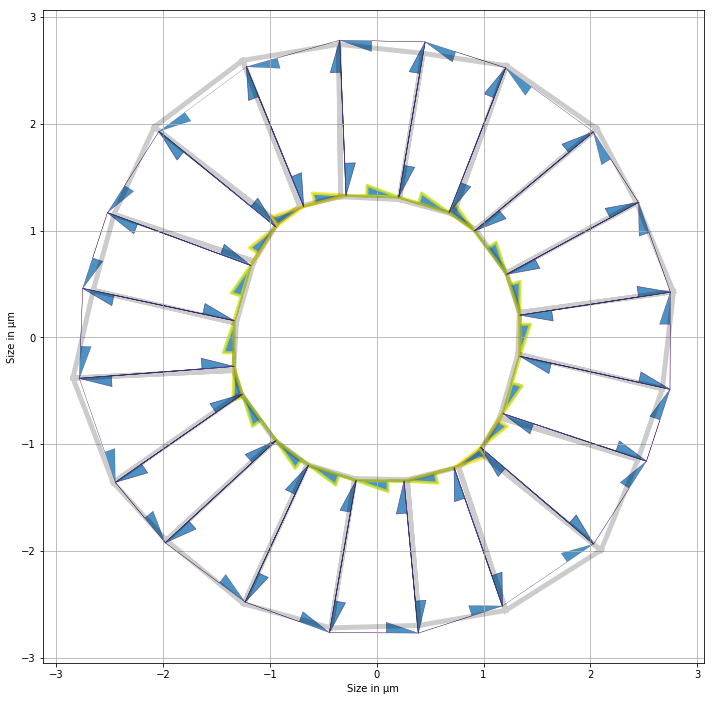

In [14]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

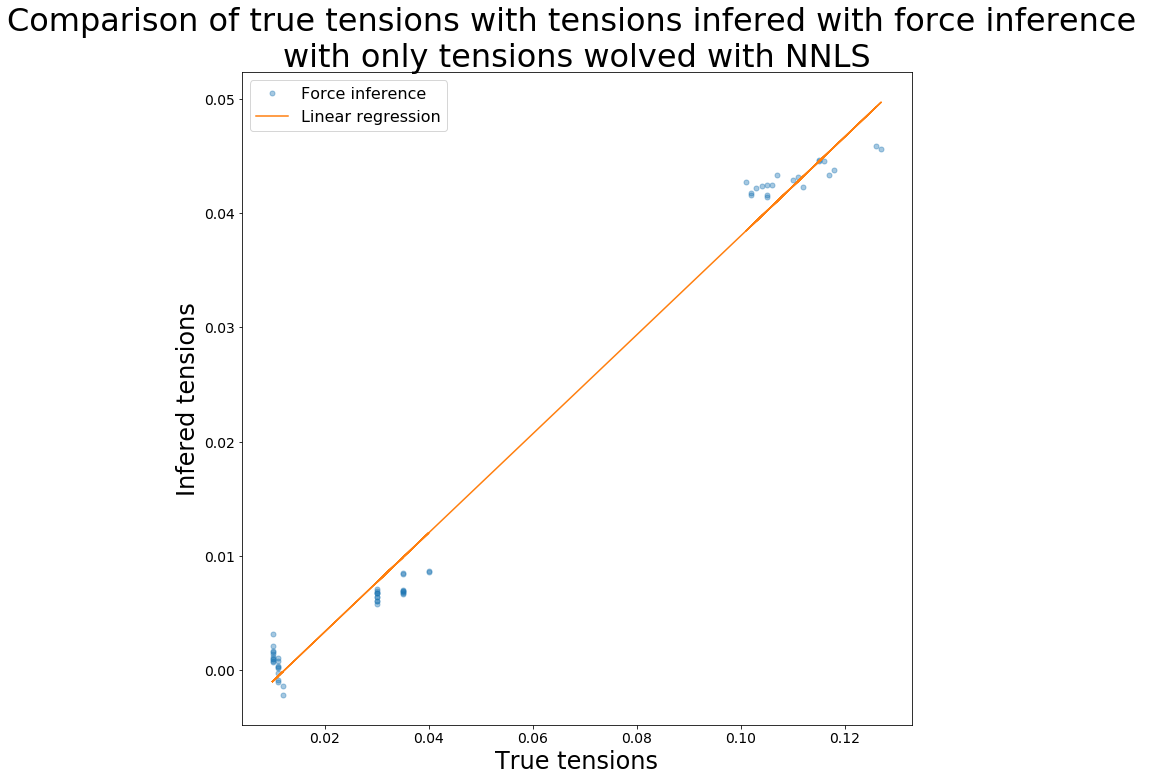

R value : 0.9933683857547145 
Standard error : 0.0018660474582992955


In [15]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

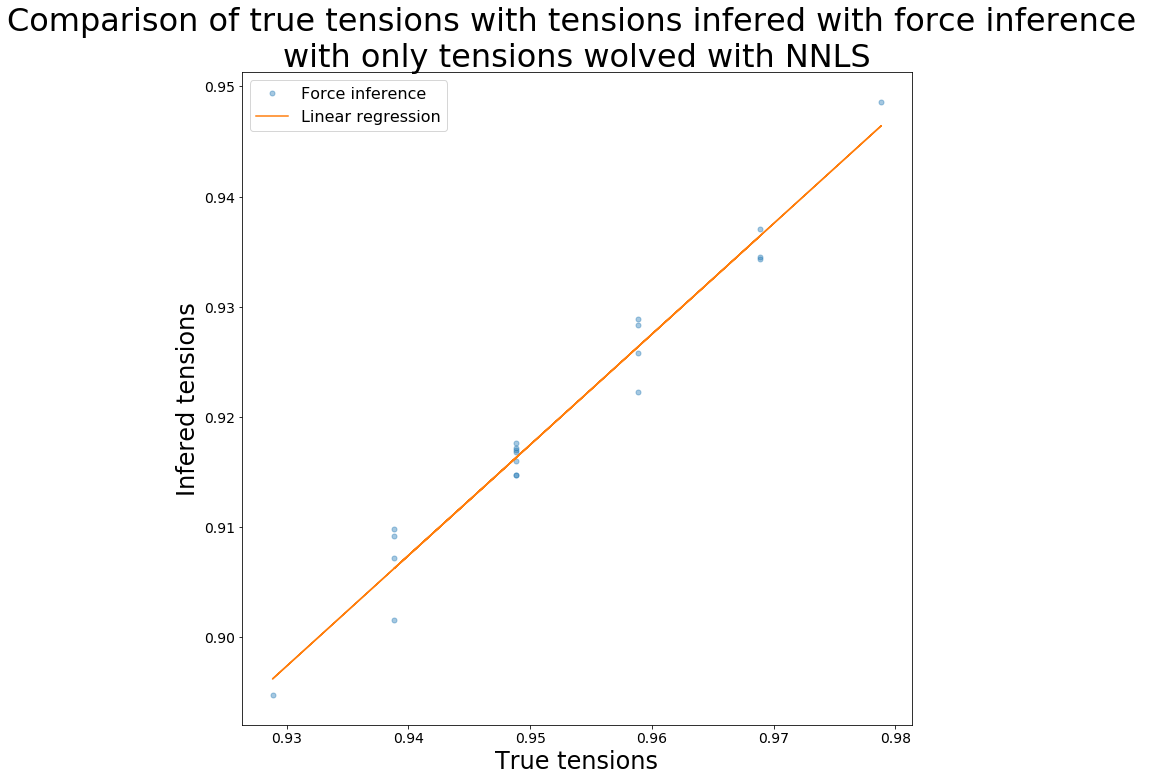

R value : 0.9849569038962707 
Standard error : 0.0010895413525864976


In [17]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))